In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\enajasa\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plotting', 'array', 'unique', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
from __future__ import print_function
from pandas import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
import pickle
from scipy import stats
import copy
from scipy.stats import entropy
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score

from sklearn.cluster import KMeans

# For statistics. Requires statsmodels 5.0 or more
#from statsmodels.formula.api import ols,gls,wls
# Analysis of Variance (ANOVA) on linear models
#from statsmodels.stats.anova import anova_lm
#tutorial link: https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch

(8, 5, 4) (8, 6) (3, 8, 2) (40, 3)


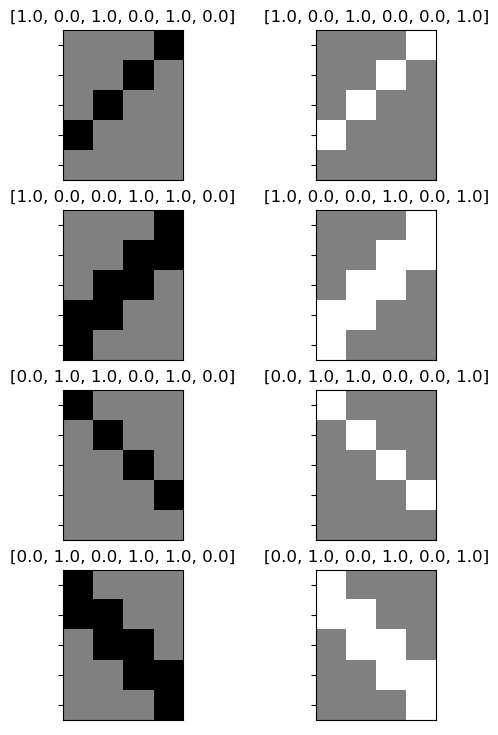

In [7]:
#make dataset
startCondition=[
    [ 0.0, 0.0, 0.0, 0.0,-1.0, 0.0],
    [ 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [ 0.0, 0.0, 0.0, 0.0,-1.0,-1.0],
    [ 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
    [ 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [ 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [-1.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [ 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
]
X=[]
Y=[]
worldS=[[],[],[]]
worldConcept=[]
figure(figsize=[2,8])
plt.gcf().set_size_inches(6, 10) 
for d in range(2):
    for s in range(2):
        for b in range(2):
            sequence=[]
            condInt=d*4+s*2+b
            currentCondition=startCondition[condInt]
            for steps in range(5):
                row=[0.0,0.0,0.0,0.0]
                for r in range(4):
                    row[r]=currentCondition[r+1]
                if d==0:
                    currentCondition.pop(0)
                    currentCondition.append(0.0)
                else:
                    currentCondition.pop()
                    currentCondition.insert(0,0.0)
                #print(d,s,b,steps,row)
                sequence.append(row)
                worldConcept.append([d,s,b])
            subplot(4,2,condInt+1)
            X.append(copy.deepcopy(sequence))
            answer=[0.0,0.0,0.0,0.0,0.0,0.0]
            answer[d]=1.0
            answer[s+2]=1.0
            answer[b+4]=1.0
            Y.append(answer)
            imshow(sequence,cmap="gray",vmin=-1.0,vmax=1.0)
            #ylim(-0.5,7.5)
            xticks([],[])
            yticks(range(5),[""]*5)
            subplots_adjust(top=0.8)
            title(answer)
            subAd=[0.0,0.0]
            subAd[d]=1.0
            subAs=[0.0,0.0]
            subAs[s]=1.0
            subAb=[0.0,0.0]
            subAb[b]=1.0
            worldS[0].append(subAd)
            worldS[1].append(subAs)
            worldS[2].append(subAb)
    #tight_layout()
X=numpy.array(X)
Y=numpy.array(Y)
worldS=numpy.array(worldS)
worldConcept=numpy.array(worldConcept)
print(X.shape,Y.shape,worldS.shape,worldConcept.shape)

In [8]:
def makeNoisyDataset(X,Y,replicatesPerItem,noise,randomize=True,delayRange=[3]):
    nX=[]
    nY=[]
    nW=[]
    wc=[[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
    for n in range(8):
        for i in range(replicatesPerItem):
            dr=numpy.random.choice(delayRange)
            M=numpy.concatenate((X[n],numpy.zeros((int(dr),4))))
            nX.append(M+numpy.random.normal(0.0,noise,(M.shape)))
            nY.append(Y[n])
            nW.append(wc[n])
    #nX=numpy.array(nX)
    nX=numpy.array(nX, dtype=object)
    nY=numpy.array(nY)
    nW=numpy.array(nW)
    if randomize:
        m=8*replicatesPerItem
        order=numpy.random.choice(list(range(m)),(m),replace=False)
        nX=nX[order]
        nY=nY[order]
        nW=nW[numpy.repeat(order,8)]
    nS=[]
    nS.append(nY.transpose()[0:2].transpose())
    nS.append(nY.transpose()[2:4].transpose())
    nS.append(nY.transpose()[4:6].transpose())
    nS=numpy.array(nS)
    return nX,nY,nS,nW 
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[1,5])
#h=hist(nX.flatten(),linspace(-1.5,1.5,101))
print(nX.shape,nY.shape,nS.shape,nW.shape)

(64,) (64, 6) (3, 64, 2) (512, 3)


In [9]:
def makeNoisyDataset(X,Y,replicatesPerItem,noise,randomize=True,delayRange=[3]):
    nX=[]
    nY=[]
    nW=[]
    wc=[[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
    for n in range(8):
        for i in range(replicatesPerItem):
            dr=numpy.random.choice(delayRange)
            M=numpy.concatenate((X[n],numpy.zeros((int(dr),4))))
            nX.append(M+numpy.random.normal(0.0,noise,(M.shape)).astype(numpy.float32)) #explicit cast to numpy.float32
            nY.append(Y[n].astype(numpy.float32))
            nW.append(wc[n])
    nX=numpy.array(nX)
    nY=numpy.array(nY)
    nW=numpy.array(nW)
    if randomize:
        m=8*replicatesPerItem
        order=numpy.random.choice(list(range(m)),(m),replace=False)
        nX=nX[order]
        nY=nY[order]
        nW=nW[numpy.repeat(order,8)]
    nS=[]
    nS.append(nY.transpose()[0:2].transpose())
    nS.append(nY.transpose()[2:4].transpose())
    nS.append(nY.transpose()[4:6].transpose())
    nS=numpy.array(nS)
    return nX,nY,nS,nW 
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[1,5])
print(nX.shape,nY.shape,nS.shape,nW.shape)

(64,) (64, 6) (3, 64, 2) (512, 3)


C:\Users\enajasa\AppData\Local\Temp\ipykernel_17384\1205567648.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nX=numpy.array(nX)


In [10]:
class Net(nn.Module):
    def __init__(self,hidden_dim=12,output_dim=6):
        super(Net, self).__init__()
        self.rnnLayer=nn.RNN(4,hidden_dim,batch_first=True)
        self.outputLayer=nn.Linear(hidden_dim,output_dim)
        self.hidden_dim=hidden_dim
        self.resetHidden()
        
    def resetHidden(self):
        self.hidden=list()
        
    def forward(self, x,return_activations=False):
        self.h0=torch.Tensor(numpy.zeros((1,x.shape[0],self.hidden_dim)))
        out,self.h0=self.rnnLayer(x,self.h0)
        out=torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out=torch.sigmoid(self.outputLayer(out[:, -1, :]))
        if return_activations:
            activations = out.detach().numpy()
            return out, activations
        return out
    

    
    def step(self,x):
        O=[]
        H=[]
        for l in range(x.shape[0]):
            h0=torch.Tensor(numpy.zeros((1,1,self.hidden_dim)))
            for i in range(x.shape[1]):
                out,h0=self.rnnLayer(x[l][i].reshape((1,1,4)),h0)
                H.append(out.detach().numpy().flatten())
            out=torch.tanh(out)
            out=torch.sigmoid(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O),numpy.array(H)
    
model=Net()

    

In [11]:
def test(model,X=X,Y=Y,S=worldS):
    model.resetHidden()
    output=model(torch.Tensor(X))
    O=1.0*(output.detach().numpy()>0.5)
    subA=[]
    antiA=[]
    for i in range(3):
        sY=O.transpose()[(i*2):(i*2)+2].transpose()
        subA.append((1.0*(sY==S[i])).mean())
        antiA.append((1.0*(sY==(1.0-S[i]))).mean())
    totalAcc=(1.0*(O==Y)).mean()
    return totalAcc,subA,antiA

model=Net(hidden_dim=12,output_dim=6)
#model.load_state_dict(torch.load("fullModel.model"))
print("full model:",test(model))

full model: (0.4791666666666667, [0.4375, 0.4375, 0.5625], [0.5625, 0.5625, 0.4375])


In [12]:
import matplotlib.pyplot as plt

delay_ranges = [[1],[2],[3],[4],[5]]
#delay_ranges = [[3]]
num_replicates = 5
models = {}

for delayRange in delay_ranges:
    print(f"Training for delay range {delayRange}...")
    all_w = []

    for replicate in range(num_replicates):
        model=Net(hidden_dim=12,output_dim=6)
        optimizer = optim.Adam(model.parameters(),lr=0.001)
        error = nn.MSELoss()
        acc=0.0
        W=[]
        Ts=[]
        iteration_list = []
        loss_list = []
        accuracy_list = []

        while acc<0.97:
            divs=[]
            model.resetHidden()
            nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=delayRange) #variance for the ND is 0.2
            for i in range(nX.shape[0]): #use 64 when training for single delayRange
                optimizer.zero_grad()
                output = model(torch.Tensor(nX[i].reshape(1,nX[i].shape[0],4))) #shape greater than 8
                loss = error(output, torch.Tensor(nY[i]))
                loss.backward()
                optimizer.step()
                div=output.detach().numpy().reshape(nY[i].shape)-nY[i]
                divs.append(1.0-abs(div).mean())
                current_iteration = len(iteration_list) + 1
                loss_list.append(loss.item())
                iteration_list.append(current_iteration)
                accuracy_list.append(mean(divs))

            acc=mean(divs)
            W.append(acc)
            total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
            Ts.append(subA)
            print(f"Iteration: {current_iteration}, Loss: {loss.item()}, Accuracy: {accuracy_list[-1]}")

        model_name = f"fullModel_dr{delayRange}_replicate{replicate}.model"
        torch.save(model.state_dict(), model_name)
        print(f"Saved {model_name}")
        models[model_name] = model

        W_name = f"W_dr{delayRange}_replicate{replicate}.p"
        with open(W_name, "wb") as f:
            pickle.dump(W, f)
        print(f"Saved {W_name}")

        w=[]
        for tr in delayRange:
            nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[tr])
            total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
            print(tr,total,subA)
            w.append(total)

        all_w.append(w)
        w_name = f"w_dr{delayRange}_replicate{replicate}.p"
        with open(w_name, "wb") as f:
            pickle.dump(w, f)
        print(f"Saved {w_name}")

        print(f"Replicate {replicate} completed")
        print(f"Time elapsed: {time.process_time()} seconds")




Training for delay range [1]...
Iteration: 64, Loss: 0.24682419002056122, Accuracy: 0.500138530973345


C:\Users\enajasa\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 128, Loss: 0.22344505786895752, Accuracy: 0.5089320433326066
Iteration: 192, Loss: 0.23048584163188934, Accuracy: 0.5336029925383627
Iteration: 256, Loss: 0.18812775611877441, Accuracy: 0.5821866733022034
Iteration: 320, Loss: 0.18843287229537964, Accuracy: 0.6080495663918555
Iteration: 384, Loss: 0.15734533965587616, Accuracy: 0.6193951917812228
Iteration: 448, Loss: 0.18023431301116943, Accuracy: 0.6280343234539032
Iteration: 512, Loss: 0.17923088371753693, Accuracy: 0.6330609931610525
Iteration: 576, Loss: 0.17203594744205475, Accuracy: 0.6371631692163646
Iteration: 640, Loss: 0.17788992822170258, Accuracy: 0.6394129390828311
Iteration: 704, Loss: 0.17097045481204987, Accuracy: 0.642461990006268
Iteration: 768, Loss: 0.17506007850170135, Accuracy: 0.6445096232928336
Iteration: 832, Loss: 0.17216531932353973, Accuracy: 0.6463481653481722
Iteration: 896, Loss: 0.17519985139369965, Accuracy: 0.6478479686193168
Iteration: 960, Loss: 0.16668786108493805, Accuracy: 0.6488542347

Iteration: 7360, Loss: 0.010178443975746632, Accuracy: 0.9253465414512902
Iteration: 7424, Loss: 0.006962530314922333, Accuracy: 0.9217315974528901
Iteration: 7488, Loss: 0.0021140589378774166, Accuracy: 0.9256848764489405
Iteration: 7552, Loss: 0.002448900369927287, Accuracy: 0.928550757758785
Iteration: 7616, Loss: 0.027487142011523247, Accuracy: 0.9282686249935068
Iteration: 7680, Loss: 0.0059843771159648895, Accuracy: 0.9335409929044545
Iteration: 7744, Loss: 0.0018599703907966614, Accuracy: 0.9364772851695307
Iteration: 7808, Loss: 0.008607096038758755, Accuracy: 0.9291332576540299
Iteration: 7872, Loss: 0.007335382048040628, Accuracy: 0.9319223237107508
Iteration: 7936, Loss: 0.002165810903534293, Accuracy: 0.9230516865500249
Iteration: 8000, Loss: 0.0035925600677728653, Accuracy: 0.9341572164557874
Iteration: 8064, Loss: 0.0053337253630161285, Accuracy: 0.9369398162816651
Iteration: 8128, Loss: 0.0032841796055436134, Accuracy: 0.9414527453482151
Iteration: 8192, Loss: 0.00295864

Iteration: 3136, Loss: 0.0811474621295929, Accuracy: 0.8155943196034059
Iteration: 3200, Loss: 0.07758814841508865, Accuracy: 0.8168920746538788
Iteration: 3264, Loss: 0.03845623508095741, Accuracy: 0.8189525333000347
Iteration: 3328, Loss: 0.04699667915701866, Accuracy: 0.8221443830989301
Iteration: 3392, Loss: 0.02227177657186985, Accuracy: 0.8257702693808824
Iteration: 3456, Loss: 0.053932394832372665, Accuracy: 0.830599176697433
Iteration: 3520, Loss: 0.044245168566703796, Accuracy: 0.8370842261938378
Iteration: 3584, Loss: 0.01494429912418127, Accuracy: 0.8361791315255687
Iteration: 3648, Loss: 0.05299845337867737, Accuracy: 0.8383838937152177
Iteration: 3712, Loss: 0.012272012419998646, Accuracy: 0.8437725126277655
Iteration: 3776, Loss: 0.01647130586206913, Accuracy: 0.8434320916421711
Iteration: 3840, Loss: 0.07923980802297592, Accuracy: 0.8558594596106559
Iteration: 3904, Loss: 0.011281885206699371, Accuracy: 0.8495088543277234
Iteration: 3968, Loss: 0.015621555037796497, Accu

Iteration: 1152, Loss: 0.12413341552019119, Accuracy: 0.6603113701567054
Iteration: 1216, Loss: 0.11043008416891098, Accuracy: 0.6633496889844537
Iteration: 1280, Loss: 0.17895515263080597, Accuracy: 0.6687614861875772
Iteration: 1344, Loss: 0.09303800016641617, Accuracy: 0.6709685153327882
Iteration: 1408, Loss: 0.1230783760547638, Accuracy: 0.6755850627087057
Iteration: 1472, Loss: 0.17282812297344208, Accuracy: 0.6771398773416877
Iteration: 1536, Loss: 0.121052585542202, Accuracy: 0.6845999842043966
Iteration: 1600, Loss: 0.12338545173406601, Accuracy: 0.6865223657805473
Iteration: 1664, Loss: 0.11906075477600098, Accuracy: 0.686987770954147
Iteration: 1728, Loss: 0.17375214397907257, Accuracy: 0.6923506699968129
Iteration: 1792, Loss: 0.12258913367986679, Accuracy: 0.6972675141878426
Iteration: 1856, Loss: 0.11381173878908157, Accuracy: 0.6984599691350013
Iteration: 1920, Loss: 0.1669507622718811, Accuracy: 0.6978358740452677
Iteration: 1984, Loss: 0.07512524724006653, Accuracy: 0.

Iteration: 8448, Loss: 0.008859885856509209, Accuracy: 0.9230404106201604
Iteration: 8512, Loss: 0.008734812028706074, Accuracy: 0.9205849075806327
Iteration: 8576, Loss: 0.00833099614828825, Accuracy: 0.9275654177181423
Iteration: 8640, Loss: 0.010630003176629543, Accuracy: 0.9253908687387593
Iteration: 8704, Loss: 0.013353101909160614, Accuracy: 0.9304452717769891
Iteration: 8768, Loss: 0.005094435065984726, Accuracy: 0.9269775119028054
Iteration: 8832, Loss: 0.012636731378734112, Accuracy: 0.9302897305460647
Iteration: 8896, Loss: 0.0047746081836521626, Accuracy: 0.9319371363963
Iteration: 8960, Loss: 0.005555875599384308, Accuracy: 0.9325215429998934
Iteration: 9024, Loss: 0.008904773741960526, Accuracy: 0.9361397380707785
Iteration: 9088, Loss: 0.0061135184951126575, Accuracy: 0.9278322190511972
Iteration: 9152, Loss: 0.005152750760316849, Accuracy: 0.9289367707096972
Iteration: 9216, Loss: 0.054196059703826904, Accuracy: 0.9353101346641779
Iteration: 9280, Loss: 0.004766941070556

Iteration: 2816, Loss: 0.1666950136423111, Accuracy: 0.660851685795933
Iteration: 2880, Loss: 0.15143750607967377, Accuracy: 0.6610307544469833
Iteration: 2944, Loss: 0.17164357006549835, Accuracy: 0.662571809720248
Iteration: 3008, Loss: 0.18066726624965668, Accuracy: 0.6625629682093859
Iteration: 3072, Loss: 0.18657241761684418, Accuracy: 0.6641289945691824
Iteration: 3136, Loss: 0.14087454974651337, Accuracy: 0.6639306377619505
Iteration: 3200, Loss: 0.18058861792087555, Accuracy: 0.6666280953213573
Iteration: 3264, Loss: 0.19511087238788605, Accuracy: 0.6685588248074055
Iteration: 3328, Loss: 0.13318610191345215, Accuracy: 0.6687874174676836
Iteration: 3392, Loss: 0.15083733201026917, Accuracy: 0.6704599456861615
Iteration: 3456, Loss: 0.13554783165454865, Accuracy: 0.6717886179685593
Iteration: 3520, Loss: 0.1205587387084961, Accuracy: 0.6726294909603894
Iteration: 3584, Loss: 0.15660522878170013, Accuracy: 0.6758378408849239
Iteration: 3648, Loss: 0.14653991162776947, Accuracy: 0

Iteration: 10048, Loss: 0.002410357119515538, Accuracy: 0.9427290859166533
Iteration: 10112, Loss: 0.0020942804403603077, Accuracy: 0.940565244643949
Iteration: 10176, Loss: 0.030867373570799828, Accuracy: 0.9296408609952778
Iteration: 10240, Loss: 0.004952121991664171, Accuracy: 0.9392952402122319
Iteration: 10304, Loss: 0.005256311502307653, Accuracy: 0.9401159224798903
Iteration: 10368, Loss: 0.0026562705170363188, Accuracy: 0.9408075557439588
Iteration: 10432, Loss: 0.0024126891512423754, Accuracy: 0.9510935619764496
Iteration: 10496, Loss: 0.0017916117794811726, Accuracy: 0.9406018155277707
Iteration: 10560, Loss: 0.0021708672866225243, Accuracy: 0.9481874433986377
Iteration: 10624, Loss: 0.021062692627310753, Accuracy: 0.937137552537024
Iteration: 10688, Loss: 0.0011823115637525916, Accuracy: 0.9487099919351749
Iteration: 10752, Loss: 0.0009211564902216196, Accuracy: 0.9482018229609821
Iteration: 10816, Loss: 0.003107405034825206, Accuracy: 0.946879649622133
Iteration: 10880, Los

Iteration: 4160, Loss: 0.10639520734548569, Accuracy: 0.8145459541119635
Iteration: 4224, Loss: 0.06681569665670395, Accuracy: 0.8176231917459518
Iteration: 4288, Loss: 0.11590337753295898, Accuracy: 0.8183109788224101
Iteration: 4352, Loss: 0.05986618995666504, Accuracy: 0.8192565944045782
Iteration: 4416, Loss: 0.10672082751989365, Accuracy: 0.8218481393996626
Iteration: 4480, Loss: 0.034095436334609985, Accuracy: 0.8177614379674196
Iteration: 4544, Loss: 0.0369359590113163, Accuracy: 0.8219999223947525
Iteration: 4608, Loss: 0.11995462328195572, Accuracy: 0.8238082500174642
Iteration: 4672, Loss: 0.11018996685743332, Accuracy: 0.8255697702988982
Iteration: 4736, Loss: 0.03327653929591179, Accuracy: 0.8264518384821713
Iteration: 4800, Loss: 0.11902478337287903, Accuracy: 0.8280733599094674
Iteration: 4864, Loss: 0.030812665820121765, Accuracy: 0.8287078399443999
Iteration: 4928, Loss: 0.030297525227069855, Accuracy: 0.8270614356733859
Iteration: 4992, Loss: 0.12018433213233948, Accur

Iteration: 11392, Loss: 0.08024907112121582, Accuracy: 0.9008868187956978
Iteration: 11456, Loss: 0.08076677471399307, Accuracy: 0.900460249336902
Iteration: 11520, Loss: 0.002416539704427123, Accuracy: 0.9034895802033134
Iteration: 11584, Loss: 0.0024000825360417366, Accuracy: 0.8984674002276734
Iteration: 11648, Loss: 0.00210271286778152, Accuracy: 0.8972261153103318
Iteration: 11712, Loss: 0.002573753707110882, Accuracy: 0.9029855771223083
Iteration: 11776, Loss: 0.0024329405277967453, Accuracy: 0.9060822648752946
Iteration: 11840, Loss: 0.08841818571090698, Accuracy: 0.9052076809457503
Iteration: 11904, Loss: 0.051336199045181274, Accuracy: 0.8995369226613548
Iteration: 11968, Loss: 0.0031033579725772142, Accuracy: 0.9025273209263105
Iteration: 12032, Loss: 0.08428975939750671, Accuracy: 0.9056530586094595
Iteration: 12096, Loss: 0.0033023550640791655, Accuracy: 0.9042736018018331
Iteration: 12160, Loss: 0.08806663006544113, Accuracy: 0.9075248797307722
Iteration: 12224, Loss: 0.08

Iteration: 18432, Loss: 0.0026703448966145515, Accuracy: 0.9384593861905159
Iteration: 18496, Loss: 0.011268675327301025, Accuracy: 0.9446650905301794
Iteration: 18560, Loss: 0.00016688148025423288, Accuracy: 0.9389010949525982
Iteration: 18624, Loss: 0.0030592482071369886, Accuracy: 0.943220868561184
Iteration: 18688, Loss: 0.004791086073964834, Accuracy: 0.9312212014338002
Iteration: 18752, Loss: 0.0028190503362566233, Accuracy: 0.9374350298312493
Iteration: 18816, Loss: 0.015294910408556461, Accuracy: 0.9399738848005654
Iteration: 18880, Loss: 0.03235962986946106, Accuracy: 0.9474199284450151
Iteration: 18944, Loss: 0.00033856008667498827, Accuracy: 0.9383671564573888
Iteration: 19008, Loss: 0.004520191345363855, Accuracy: 0.9443168304860592
Iteration: 19072, Loss: 0.0031283635180443525, Accuracy: 0.9447160830022767
Iteration: 19136, Loss: 0.021750153973698616, Accuracy: 0.9523352804390015
Iteration: 19200, Loss: 0.0030682815704494715, Accuracy: 0.949296940700151
Iteration: 19264, L

Iteration: 2688, Loss: 0.14796316623687744, Accuracy: 0.6880700511392206
Iteration: 2752, Loss: 0.17873942852020264, Accuracy: 0.6878852038644254
Iteration: 2816, Loss: 0.14697419106960297, Accuracy: 0.6931304065510631
Iteration: 2880, Loss: 0.1579330861568451, Accuracy: 0.6943862477783114
Iteration: 2944, Loss: 0.10609150677919388, Accuracy: 0.6997544602490962
Iteration: 3008, Loss: 0.1686701774597168, Accuracy: 0.6989905165974051
Iteration: 3072, Loss: 0.1466330736875534, Accuracy: 0.7039743161294609
Iteration: 3136, Loss: 0.13013751804828644, Accuracy: 0.7134557352401316
Iteration: 3200, Loss: 0.13614659011363983, Accuracy: 0.7160165936220437
Iteration: 3264, Loss: 0.14022469520568848, Accuracy: 0.717647259356454
Iteration: 3328, Loss: 0.056848589330911636, Accuracy: 0.7252737765666097
Iteration: 3392, Loss: 0.058463335037231445, Accuracy: 0.7288309873547405
Iteration: 3456, Loss: 0.05329084396362305, Accuracy: 0.733610343420878
Iteration: 3520, Loss: 0.0846644937992096, Accuracy: 0

Iteration: 9920, Loss: 0.002488643629476428, Accuracy: 0.9591312140983064
Iteration: 9984, Loss: 0.0018958396976813674, Accuracy: 0.9581580657977611
Iteration: 10048, Loss: 0.0015877188416197896, Accuracy: 0.9521778288763016
Iteration: 10112, Loss: 0.26162534952163696, Accuracy: 0.9487857566273306
Iteration: 10176, Loss: 0.0009056224953383207, Accuracy: 0.9654017990687862
Iteration: 10240, Loss: 0.0007776735001243651, Accuracy: 0.9615447683027014
Iteration: 10304, Loss: 0.0005937240784987807, Accuracy: 0.9672522821347229
Iteration: 10368, Loss: 0.0006802917923778296, Accuracy: 0.9637977208185475
Iteration: 10432, Loss: 0.0008853711769916117, Accuracy: 0.9592076700937469
Iteration: 10496, Loss: 0.0005703599308617413, Accuracy: 0.9650792881293455
Iteration: 10560, Loss: 0.0011080503463745117, Accuracy: 0.963889821927296
Iteration: 10624, Loss: 0.0005149265634827316, Accuracy: 0.9668066691956483
Iteration: 10688, Loss: 0.0011385518591850996, Accuracy: 0.9644518159911968
Iteration: 10752, 

Iteration: 6144, Loss: 0.09610641002655029, Accuracy: 0.8091633687727153
Iteration: 6208, Loss: 0.07525171339511871, Accuracy: 0.8103190502151847
Iteration: 6272, Loss: 0.09623843431472778, Accuracy: 0.8065003743395209
Iteration: 6336, Loss: 0.09650930762290955, Accuracy: 0.8094494806136936
Iteration: 6400, Loss: 0.0662887766957283, Accuracy: 0.8030283316038549
Iteration: 6464, Loss: 0.07324079424142838, Accuracy: 0.810507247922942
Iteration: 6528, Loss: 0.09808679670095444, Accuracy: 0.8097495494876057
Iteration: 6592, Loss: 0.05899050459265709, Accuracy: 0.8165109739638865
Iteration: 6656, Loss: 0.09760580211877823, Accuracy: 0.8142729073297232
Iteration: 6720, Loss: 0.06961151212453842, Accuracy: 0.8097876165993512
Iteration: 6784, Loss: 0.06843900680541992, Accuracy: 0.8160957125946879
Iteration: 6848, Loss: 0.06983832269906998, Accuracy: 0.8188915033824742
Iteration: 6912, Loss: 0.07059235125780106, Accuracy: 0.8058740876149386
Iteration: 6976, Loss: 0.06495314091444016, Accuracy:

Iteration: 13312, Loss: 0.09280472248792648, Accuracy: 0.8524272957583889
Iteration: 13376, Loss: 0.013855564408004284, Accuracy: 0.8655662438832223
Iteration: 13440, Loss: 0.08018487691879272, Accuracy: 0.8556577498093247
Iteration: 13504, Loss: 0.017785120755434036, Accuracy: 0.8650211573112756
Iteration: 13568, Loss: 0.06620101630687714, Accuracy: 0.8652256482746452
Iteration: 13632, Loss: 0.08084848523139954, Accuracy: 0.8629688604269177
Iteration: 13696, Loss: 0.08176051825284958, Accuracy: 0.8641025654505938
Iteration: 13760, Loss: 0.010319440625607967, Accuracy: 0.8591240952955559
Iteration: 13824, Loss: 0.07073599100112915, Accuracy: 0.8569547741208225
Iteration: 13888, Loss: 0.01289774477481842, Accuracy: 0.8620186530752108
Iteration: 13952, Loss: 0.011642108671367168, Accuracy: 0.8673772853799164
Iteration: 14016, Loss: 0.016871243715286255, Accuracy: 0.8599124642787501
Iteration: 14080, Loss: 0.09312935918569565, Accuracy: 0.8614352920558304
Iteration: 14144, Loss: 0.0149163

Iteration: 20352, Loss: 0.0023053253535181284, Accuracy: 0.9399385110009462
Iteration: 20416, Loss: 0.0020129717886447906, Accuracy: 0.9320798142580315
Iteration: 20480, Loss: 0.07618080824613571, Accuracy: 0.9347591591067612
Iteration: 20544, Loss: 0.003553866408765316, Accuracy: 0.9387245464604348
Iteration: 20608, Loss: 0.0021114361006766558, Accuracy: 0.9362872058409266
Iteration: 20672, Loss: 0.053963154554367065, Accuracy: 0.9360600217769388
Iteration: 20736, Loss: 0.002709454158321023, Accuracy: 0.9421588904224336
Iteration: 20800, Loss: 0.024243762716650963, Accuracy: 0.9458492650883272
Iteration: 20864, Loss: 0.003843930782750249, Accuracy: 0.9504378900746815
Iteration: 20928, Loss: 0.0020390325225889683, Accuracy: 0.9476918867439963
Iteration: 20992, Loss: 0.031442198902368546, Accuracy: 0.9451654127333313
Iteration: 21056, Loss: 0.004961830098181963, Accuracy: 0.9524697578744963
Iteration: 21120, Loss: 0.0020114954095333815, Accuracy: 0.9500402508710977
Iteration: 21184, Los

Iteration: 2688, Loss: 0.14987708628177643, Accuracy: 0.6707767136394978
Iteration: 2752, Loss: 0.18606136739253998, Accuracy: 0.6702433861792088
Iteration: 2816, Loss: 0.14703206717967987, Accuracy: 0.668465917930007
Iteration: 2880, Loss: 0.13587729632854462, Accuracy: 0.6725946739315987
Iteration: 2944, Loss: 0.13999485969543457, Accuracy: 0.6721569583751261
Iteration: 3008, Loss: 0.14615418016910553, Accuracy: 0.6755008711479604
Iteration: 3072, Loss: 0.14434581995010376, Accuracy: 0.677594228181988
Iteration: 3136, Loss: 0.1429748237133026, Accuracy: 0.6769932797178626
Iteration: 3200, Loss: 0.14600920677185059, Accuracy: 0.6766037060879171
Iteration: 3264, Loss: 0.1258905977010727, Accuracy: 0.6775498501956463
Iteration: 3328, Loss: 0.11593417078256607, Accuracy: 0.6775572588667274
Iteration: 3392, Loss: 0.11313644051551819, Accuracy: 0.6763636227697134
Iteration: 3456, Loss: 0.1153610423207283, Accuracy: 0.6784618580713868
Iteration: 3520, Loss: 0.1097877249121666, Accuracy: 0.6

Iteration: 9920, Loss: 0.05359399691224098, Accuracy: 0.8237658469006419
Iteration: 9984, Loss: 0.04898805916309357, Accuracy: 0.8164900674019009
Iteration: 10048, Loss: 0.06023958697915077, Accuracy: 0.8125212474260479
Iteration: 10112, Loss: 0.0622275210916996, Accuracy: 0.8186817716341466
Iteration: 10176, Loss: 0.08136724680662155, Accuracy: 0.8287124349735677
Iteration: 10240, Loss: 0.08209313452243805, Accuracy: 0.8298740792088211
Iteration: 10304, Loss: 0.16394644975662231, Accuracy: 0.8076231037266552
Iteration: 10368, Loss: 0.06946813315153122, Accuracy: 0.8328376160934567
Iteration: 10432, Loss: 0.07008000463247299, Accuracy: 0.824253887985833
Iteration: 10496, Loss: 0.07765763998031616, Accuracy: 0.8288324498571455
Iteration: 10560, Loss: 0.04303855076432228, Accuracy: 0.8208555857418105
Iteration: 10624, Loss: 0.06981278210878372, Accuracy: 0.8229909993242472
Iteration: 10688, Loss: 0.026341484859585762, Accuracy: 0.8370044827461243
Iteration: 10752, Loss: 0.034273751080036

Iteration: 17024, Loss: 0.0782211646437645, Accuracy: 0.8865605800237972
Iteration: 17088, Loss: 0.005741944536566734, Accuracy: 0.8843125543207861
Iteration: 17152, Loss: 0.018670929595828056, Accuracy: 0.8842162224464118
Iteration: 17216, Loss: 0.10073458403348923, Accuracy: 0.8941874689771794
Iteration: 17280, Loss: 0.06531268358230591, Accuracy: 0.8898332632379606
Iteration: 17344, Loss: 0.047125399112701416, Accuracy: 0.8869061385339592
Iteration: 17408, Loss: 0.06932470202445984, Accuracy: 0.8916304047452286
Iteration: 17472, Loss: 0.05418754741549492, Accuracy: 0.8894563822832424
Iteration: 17536, Loss: 0.06876279413700104, Accuracy: 0.8841219514724799
Iteration: 17600, Loss: 0.007893175818026066, Accuracy: 0.8937839020509273
Iteration: 17664, Loss: 0.05222351476550102, Accuracy: 0.8982187173096463
Iteration: 17728, Loss: 0.06463520973920822, Accuracy: 0.8917426426778547
Iteration: 17792, Loss: 0.01649237610399723, Accuracy: 0.8968467002559919
Iteration: 17856, Loss: 0.006509950

Iteration: 1728, Loss: 0.19264371693134308, Accuracy: 0.6890142066404223
Iteration: 1792, Loss: 0.13957808911800385, Accuracy: 0.6892665082123131
Iteration: 1856, Loss: 0.08433333039283752, Accuracy: 0.692613456165418
Iteration: 1920, Loss: 0.19678904116153717, Accuracy: 0.6978407495189458
Iteration: 1984, Loss: 0.18766267597675323, Accuracy: 0.7018372509628534
Iteration: 2048, Loss: 0.12657393515110016, Accuracy: 0.6938840197399259
Iteration: 2112, Loss: 0.08344509452581406, Accuracy: 0.6979056559503078
Iteration: 2176, Loss: 0.08628977090120316, Accuracy: 0.7016749889589846
Iteration: 2240, Loss: 0.1591009944677353, Accuracy: 0.6900065699592233
Iteration: 2304, Loss: 0.2400185465812683, Accuracy: 0.6997534255497158
Iteration: 2368, Loss: 0.1172880306839943, Accuracy: 0.704325465252623
Iteration: 2432, Loss: 0.07459232211112976, Accuracy: 0.7050236163195223
Iteration: 2496, Loss: 0.18135042488574982, Accuracy: 0.7004534900188446
Iteration: 2560, Loss: 0.07719596475362778, Accuracy: 0.

Iteration: 9024, Loss: 0.09004072099924088, Accuracy: 0.7829631408676505
Iteration: 9088, Loss: 0.1025131344795227, Accuracy: 0.7771799399051815
Iteration: 9152, Loss: 0.06864381581544876, Accuracy: 0.789849875960499
Iteration: 9216, Loss: 0.10172750800848007, Accuracy: 0.7678160180803388
Iteration: 9280, Loss: 0.09095997363328934, Accuracy: 0.7831382306758314
Iteration: 9344, Loss: 0.09327623248100281, Accuracy: 0.7875607365276664
Iteration: 9408, Loss: 0.08222617954015732, Accuracy: 0.7813268562313169
Iteration: 9472, Loss: 0.09689027070999146, Accuracy: 0.7932311112526804
Iteration: 9536, Loss: 0.05388587713241577, Accuracy: 0.7922156995628029
Iteration: 9600, Loss: 0.07980943471193314, Accuracy: 0.7944039122667164
Iteration: 9664, Loss: 0.09656498581171036, Accuracy: 0.7923774011433125
Iteration: 9728, Loss: 0.09633200615644455, Accuracy: 0.7948478756006807
Iteration: 9792, Loss: 0.08349329978227615, Accuracy: 0.7947759528178722
Iteration: 9856, Loss: 0.10687470436096191, Accuracy:

Iteration: 16256, Loss: 0.014471389353275299, Accuracy: 0.8589252983801998
Iteration: 16320, Loss: 0.06736984848976135, Accuracy: 0.8471007149782963
Iteration: 16384, Loss: 0.06837386637926102, Accuracy: 0.8575672031147406
Iteration: 16448, Loss: 0.10356395691633224, Accuracy: 0.8525593217927963
Iteration: 16512, Loss: 0.05513410642743111, Accuracy: 0.8594955440494232
Iteration: 16576, Loss: 0.04672754183411598, Accuracy: 0.8589437587652355
Iteration: 16640, Loss: 0.10705768316984177, Accuracy: 0.8551606366527267
Iteration: 16704, Loss: 0.07123174518346786, Accuracy: 0.8590762589592487
Iteration: 16768, Loss: 0.10796669870615005, Accuracy: 0.8618855136446655
Iteration: 16832, Loss: 0.03299647197127342, Accuracy: 0.8512921184301376
Iteration: 16896, Loss: 0.10912827402353287, Accuracy: 0.8626271744142286
Iteration: 16960, Loss: 0.012629702687263489, Accuracy: 0.8645712749566883
Iteration: 17024, Loss: 0.09750392287969589, Accuracy: 0.857235141156707
Iteration: 17088, Loss: 0.10101882368

Iteration: 23360, Loss: 0.0020639135036617517, Accuracy: 0.9151175693259574
Iteration: 23424, Loss: 0.057817328721284866, Accuracy: 0.9128940052469261
Iteration: 23488, Loss: 0.04932694509625435, Accuracy: 0.9210782969894353
Iteration: 23552, Loss: 0.003183932974934578, Accuracy: 0.9182138828036841
Iteration: 23616, Loss: 0.003803367493674159, Accuracy: 0.9014262320706621
Iteration: 23680, Loss: 0.001334567554295063, Accuracy: 0.9139675867627375
Iteration: 23744, Loss: 0.005425752606242895, Accuracy: 0.9184845256968401
Iteration: 23808, Loss: 0.056785959750413895, Accuracy: 0.9228363209404051
Iteration: 23872, Loss: 0.05688615143299103, Accuracy: 0.9150737039453816
Iteration: 23936, Loss: 0.015959814190864563, Accuracy: 0.9206027571344748
Iteration: 24000, Loss: 0.07395754009485245, Accuracy: 0.9159086016006768
Iteration: 24064, Loss: 0.01818034052848816, Accuracy: 0.9094129458244424
Iteration: 24128, Loss: 0.0033767633140087128, Accuracy: 0.9149838032317348
Iteration: 24192, Loss: 0.0

Iteration: 30400, Loss: 0.0046686939895153046, Accuracy: 0.9472570085636107
Iteration: 30464, Loss: 0.005555592942982912, Accuracy: 0.9599310750709265
Iteration: 30528, Loss: 0.021414384245872498, Accuracy: 0.9602600465950673
Iteration: 30592, Loss: 0.001155381673015654, Accuracy: 0.9626610240520677
Iteration: 30656, Loss: 0.0023528430610895157, Accuracy: 0.9658116446007625
Iteration: 30720, Loss: 0.0005268759559839964, Accuracy: 0.9662178215075983
Iteration: 30784, Loss: 0.0006396922399289906, Accuracy: 0.9594143383510527
Iteration: 30848, Loss: 0.0004676362732425332, Accuracy: 0.9615461810026318
Iteration: 30912, Loss: 0.0026740271132439375, Accuracy: 0.9582207472121809
Iteration: 30976, Loss: 0.011415046639740467, Accuracy: 0.9658258097697399
Iteration: 31040, Loss: 0.00016424100613221526, Accuracy: 0.9651397943671327
Iteration: 31104, Loss: 7.95170635683462e-05, Accuracy: 0.9640175662716501
Iteration: 31168, Loss: 0.006811304017901421, Accuracy: 0.9680690637032967
Iteration: 31232,

Iteration: 5632, Loss: 0.11548129469156265, Accuracy: 0.8388889788184315
Iteration: 5696, Loss: 0.04924950376152992, Accuracy: 0.8373334286734462
Iteration: 5760, Loss: 0.03482847288250923, Accuracy: 0.8202120128553361
Iteration: 5824, Loss: 0.11429039388895035, Accuracy: 0.836881595198065
Iteration: 5888, Loss: 0.11131715774536133, Accuracy: 0.8244880922138691
Iteration: 5952, Loss: 0.03390251472592354, Accuracy: 0.842755138524808
Iteration: 6016, Loss: 0.11028122156858444, Accuracy: 0.8367183144437149
Iteration: 6080, Loss: 0.022562069818377495, Accuracy: 0.8437170713441446
Iteration: 6144, Loss: 0.3164701759815216, Accuracy: 0.8324432309018448
Iteration: 6208, Loss: 0.03846121206879616, Accuracy: 0.8495308848796412
Iteration: 6272, Loss: 0.02164270170032978, Accuracy: 0.8487423385959119
Iteration: 6336, Loss: 0.017413290217518806, Accuracy: 0.8386961243813857
Iteration: 6400, Loss: 0.06472223997116089, Accuracy: 0.8381011994788423
Iteration: 6464, Loss: 0.21554817259311676, Accuracy

Iteration: 704, Loss: 0.16452978551387787, Accuracy: 0.6290917969308794
Iteration: 768, Loss: 0.16161489486694336, Accuracy: 0.6337577062658966
Iteration: 832, Loss: 0.1546824425458908, Accuracy: 0.6411531427875161
Iteration: 896, Loss: 0.15717653930187225, Accuracy: 0.6427362528629601
Iteration: 960, Loss: 0.11422663927078247, Accuracy: 0.6506911711767316
Iteration: 1024, Loss: 0.15190447866916656, Accuracy: 0.6531746117398143
Iteration: 1088, Loss: 0.20168165862560272, Accuracy: 0.6610307712107897
Iteration: 1152, Loss: 0.197132870554924, Accuracy: 0.6645787041634321
Iteration: 1216, Loss: 0.20456182956695557, Accuracy: 0.6644036681391299
Iteration: 1280, Loss: 0.09886076301336288, Accuracy: 0.6687882877886295
Iteration: 1344, Loss: 0.10340868681669235, Accuracy: 0.674482200294733
Iteration: 1408, Loss: 0.15242710709571838, Accuracy: 0.6765695051290095
Iteration: 1472, Loss: 0.19836978614330292, Accuracy: 0.680511424317956
Iteration: 1536, Loss: 0.19235432147979736, Accuracy: 0.68553

Iteration: 7936, Loss: 0.023782500997185707, Accuracy: 0.8432793864049017
Iteration: 8000, Loss: 0.052723512053489685, Accuracy: 0.8541108898352832
Iteration: 8064, Loss: 0.022235557436943054, Accuracy: 0.864304777700454
Iteration: 8128, Loss: 0.027313409373164177, Accuracy: 0.8665972226299345
Iteration: 8192, Loss: 0.028166182339191437, Accuracy: 0.8738356520188972
Iteration: 8256, Loss: 0.02225329913198948, Accuracy: 0.8775216368958354
Iteration: 8320, Loss: 0.11192181706428528, Accuracy: 0.864720843732357
Iteration: 8384, Loss: 0.023202503100037575, Accuracy: 0.8734311176231131
Iteration: 8448, Loss: 0.053250838071107864, Accuracy: 0.8700585699407384
Iteration: 8512, Loss: 0.025440411642193794, Accuracy: 0.8857624781085178
Iteration: 8576, Loss: 0.03781979903578758, Accuracy: 0.8849210973130539
Iteration: 8640, Loss: 0.020895756781101227, Accuracy: 0.8811356177320704
Iteration: 8704, Loss: 0.038315579295158386, Accuracy: 0.8827285870211199
Iteration: 8768, Loss: 0.018046291545033455

Iteration: 960, Loss: 0.1736770123243332, Accuracy: 0.6505832239054143
Iteration: 1024, Loss: 0.17390082776546478, Accuracy: 0.6511750076897442
Iteration: 1088, Loss: 0.16596101224422455, Accuracy: 0.6520257159136236
Iteration: 1152, Loss: 0.16690798103809357, Accuracy: 0.6528584696352482
Iteration: 1216, Loss: 0.1700902134180069, Accuracy: 0.6533402358181775
Iteration: 1280, Loss: 0.1672617793083191, Accuracy: 0.6542816129513085
Iteration: 1344, Loss: 0.1664258986711502, Accuracy: 0.6550047309137881
Iteration: 1408, Loss: 0.1696912795305252, Accuracy: 0.6553950081579387
Iteration: 1472, Loss: 0.167526975274086, Accuracy: 0.6561632831580937
Iteration: 1536, Loss: 0.16848866641521454, Accuracy: 0.6560445548966527
Iteration: 1600, Loss: 0.16827698051929474, Accuracy: 0.6565391994081438
Iteration: 1664, Loss: 0.1765439361333847, Accuracy: 0.6568505642935634
Iteration: 1728, Loss: 0.16912013292312622, Accuracy: 0.6575199123471975
Iteration: 1792, Loss: 0.16723351180553436, Accuracy: 0.6576

Iteration: 8256, Loss: 0.16051113605499268, Accuracy: 0.7045942386612296
Iteration: 8320, Loss: 0.10217729955911636, Accuracy: 0.7015741779468954
Iteration: 8384, Loss: 0.1746494174003601, Accuracy: 0.7051225528120995
Iteration: 8448, Loss: 0.1646028310060501, Accuracy: 0.7127821098547429
Iteration: 8512, Loss: 0.09572256356477737, Accuracy: 0.7033645231276751
Iteration: 8576, Loss: 0.17968802154064178, Accuracy: 0.7101503980811685
Iteration: 8640, Loss: 0.18735472857952118, Accuracy: 0.7102359249256551
Iteration: 8704, Loss: 0.12307232618331909, Accuracy: 0.7184139969758689
Iteration: 8768, Loss: 0.1269989013671875, Accuracy: 0.7181510960217565
Iteration: 8832, Loss: 0.14098712801933289, Accuracy: 0.7243050569668412
Iteration: 8896, Loss: 0.15023507177829742, Accuracy: 0.7282460364513099
Iteration: 8960, Loss: 0.1017613485455513, Accuracy: 0.7306651694234461
Iteration: 9024, Loss: 0.2204522341489792, Accuracy: 0.7254489469341934
Iteration: 9088, Loss: 0.09921789914369583, Accuracy: 0.

Iteration: 15488, Loss: 0.018843604251742363, Accuracy: 0.8404573136940598
Iteration: 15552, Loss: 0.034300267696380615, Accuracy: 0.8418220428284258
Iteration: 15616, Loss: 0.015701858326792717, Accuracy: 0.8564412855776027
Iteration: 15680, Loss: 0.25090572237968445, Accuracy: 0.8514019647845998
Iteration: 15744, Loss: 0.13988254964351654, Accuracy: 0.8363546328619123
Iteration: 15808, Loss: 0.045934777706861496, Accuracy: 0.8510797435883433
Iteration: 15872, Loss: 0.13414211571216583, Accuracy: 0.8596559673314914
Iteration: 15936, Loss: 0.019940054044127464, Accuracy: 0.8433651628438383
Iteration: 16000, Loss: 0.01855093613266945, Accuracy: 0.8589239498833194
Iteration: 16064, Loss: 0.099040687084198, Accuracy: 0.860945500084199
Iteration: 16128, Loss: 0.0638490542769432, Accuracy: 0.8598427302204072
Iteration: 16192, Loss: 0.046154771000146866, Accuracy: 0.8584682795917615
Iteration: 16256, Loss: 0.01623210497200489, Accuracy: 0.8625351680675521
Iteration: 16320, Loss: 0.0134114278

Iteration: 22592, Loss: 0.0039803520776331425, Accuracy: 0.9256555359461345
Iteration: 22656, Loss: 0.005315812770277262, Accuracy: 0.9343547206372023
Iteration: 22720, Loss: 0.0039261505007743835, Accuracy: 0.9152365468617063
Iteration: 22784, Loss: 0.004472485743463039, Accuracy: 0.9440326254698448
Iteration: 22848, Loss: 0.0030750080477446318, Accuracy: 0.9330376319121569
Iteration: 22912, Loss: 0.007130398880690336, Accuracy: 0.9286513653933071
Iteration: 22976, Loss: 0.012334582395851612, Accuracy: 0.9372684412810486
Iteration: 23040, Loss: 0.010471898131072521, Accuracy: 0.9334036148502491
Iteration: 23104, Loss: 0.0013856302248314023, Accuracy: 0.9378714393824339
Iteration: 23168, Loss: 0.0058891661465168, Accuracy: 0.9372586920508184
Iteration: 23232, Loss: 0.02562437765300274, Accuracy: 0.9349746819061693
Iteration: 23296, Loss: 0.002095861127600074, Accuracy: 0.9496544943249319
Iteration: 23360, Loss: 0.004569937940686941, Accuracy: 0.9506731669243891
Iteration: 23424, Loss: 

Iteration: 3264, Loss: 0.18834702670574188, Accuracy: 0.7538372634444386
Iteration: 3328, Loss: 0.1969750076532364, Accuracy: 0.7499871640466154
Iteration: 3392, Loss: 0.03263898566365242, Accuracy: 0.7542362899985164
Iteration: 3456, Loss: 0.1007305309176445, Accuracy: 0.753921878291294
Iteration: 3520, Loss: 0.04472437500953674, Accuracy: 0.7635110078845173
Iteration: 3584, Loss: 0.0350760817527771, Accuracy: 0.7581084971316159
Iteration: 3648, Loss: 0.024910688400268555, Accuracy: 0.7671887762844563
Iteration: 3712, Loss: 0.09266098588705063, Accuracy: 0.7522615666966885
Iteration: 3776, Loss: 0.13906322419643402, Accuracy: 0.7700203645508736
Iteration: 3840, Loss: 0.05901452526450157, Accuracy: 0.76112673827447
Iteration: 3904, Loss: 0.06815143674612045, Accuracy: 0.7684060856699944
Iteration: 3968, Loss: 0.0975576639175415, Accuracy: 0.772589398548007
Iteration: 4032, Loss: 0.17020243406295776, Accuracy: 0.7612858659122139
Iteration: 4096, Loss: 0.024429745972156525, Accuracy: 0.7

Iteration: 10496, Loss: 0.11460071057081223, Accuracy: 0.863415572908707
Iteration: 10560, Loss: 0.031027384102344513, Accuracy: 0.8489990715752356
Iteration: 10624, Loss: 0.09436211735010147, Accuracy: 0.8644960864912719
Iteration: 10688, Loss: 0.017312821000814438, Accuracy: 0.8484197985380888
Iteration: 10752, Loss: 0.02192465029656887, Accuracy: 0.8599098499980755
Iteration: 10816, Loss: 0.05728314444422722, Accuracy: 0.8641823896905407
Iteration: 10880, Loss: 0.02769760973751545, Accuracy: 0.8750610385322943
Iteration: 10944, Loss: 0.0048566642217338085, Accuracy: 0.8730203846353106
Iteration: 11008, Loss: 0.013535597361624241, Accuracy: 0.8608243226190098
Iteration: 11072, Loss: 0.0035516589414328337, Accuracy: 0.8695455234847032
Iteration: 11136, Loss: 0.029731852933764458, Accuracy: 0.8744501816108823
Iteration: 11200, Loss: 0.03937773033976555, Accuracy: 0.8792288093245588
Iteration: 11264, Loss: 0.004268638789653778, Accuracy: 0.8766137737547979
Iteration: 11328, Loss: 0.0364

Iteration: 17600, Loss: 0.004478121642023325, Accuracy: 0.949060925791855
Iteration: 17664, Loss: 0.005386271979659796, Accuracy: 0.951530173595529
Iteration: 17728, Loss: 0.0024044986348599195, Accuracy: 0.9487451171298744
Iteration: 17792, Loss: 0.012672662734985352, Accuracy: 0.9467187697009649
Iteration: 17856, Loss: 0.0027934617828577757, Accuracy: 0.9534070004738169
Iteration: 17920, Loss: 0.09171924740076065, Accuracy: 0.9565749502944527
Iteration: 17984, Loss: 0.0015125927748158574, Accuracy: 0.9596723033246235
Iteration: 18048, Loss: 0.0023232270032167435, Accuracy: 0.9463459912949475
Iteration: 18112, Loss: 0.0010640203254297376, Accuracy: 0.9376025492601912
Iteration: 18176, Loss: 0.00022374483523890376, Accuracy: 0.9319915762316668
Iteration: 18240, Loss: 0.030867816880345345, Accuracy: 0.9562145985983079
Iteration: 18304, Loss: 0.002289022086188197, Accuracy: 0.9624219540128252
Iteration: 18368, Loss: 0.0017140056006610394, Accuracy: 0.9564297799079213
Iteration: 18432, Lo

Iteration: 3712, Loss: 0.09953945130109787, Accuracy: 0.7428402898367494
Iteration: 3776, Loss: 0.1309577375650406, Accuracy: 0.7384285668376833
Iteration: 3840, Loss: 0.08364409953355789, Accuracy: 0.7428110230248421
Iteration: 3904, Loss: 0.07933446019887924, Accuracy: 0.7442312489729375
Iteration: 3968, Loss: 0.10207032412290573, Accuracy: 0.7440402419306338
Iteration: 4032, Loss: 0.08383917063474655, Accuracy: 0.7518709290307015
Iteration: 4096, Loss: 0.09877759963274002, Accuracy: 0.7490767582785338
Iteration: 4160, Loss: 0.10526099056005478, Accuracy: 0.7513282159343362
Iteration: 4224, Loss: 0.10087583214044571, Accuracy: 0.7570294055622071
Iteration: 4288, Loss: 0.1007409617304802, Accuracy: 0.7631744653917849
Iteration: 4352, Loss: 0.09845937043428421, Accuracy: 0.7604388033505529
Iteration: 4416, Loss: 0.09719518572092056, Accuracy: 0.7533540215808898
Iteration: 4480, Loss: 0.07165058702230453, Accuracy: 0.7573637550231069
Iteration: 4544, Loss: 0.08804922550916672, Accuracy:

Iteration: 10944, Loss: 0.04039410874247551, Accuracy: 0.8427186282351613
Iteration: 11008, Loss: 0.03490929305553436, Accuracy: 0.8421888208249584
Iteration: 11072, Loss: 0.07994043081998825, Accuracy: 0.8448999332031235
Iteration: 11136, Loss: 0.060618896037340164, Accuracy: 0.8446690938435495
Iteration: 11200, Loss: 0.09277423471212387, Accuracy: 0.8518652480561286
Iteration: 11264, Loss: 0.03467537462711334, Accuracy: 0.8498128015780821
Iteration: 11328, Loss: 0.011291789822280407, Accuracy: 0.8501359518850222
Iteration: 11392, Loss: 0.06982571631669998, Accuracy: 0.8418603705940768
Iteration: 11456, Loss: 0.08820287138223648, Accuracy: 0.8478978920029476
Iteration: 11520, Loss: 0.07770884037017822, Accuracy: 0.8500411335844547
Iteration: 11584, Loss: 0.08379753679037094, Accuracy: 0.8459777380339801
Iteration: 11648, Loss: 0.07272132486104965, Accuracy: 0.8526598355965689
Iteration: 11712, Loss: 0.026157021522521973, Accuracy: 0.8427258160663769
Iteration: 11776, Loss: 0.093896538

Iteration: 18112, Loss: 0.003634723834693432, Accuracy: 0.9067290077800862
Iteration: 18176, Loss: 0.00597320357337594, Accuracy: 0.9102453931118362
Iteration: 18240, Loss: 0.07637327164411545, Accuracy: 0.9133495047572069
Iteration: 18304, Loss: 0.04424488544464111, Accuracy: 0.9132373295724392
Iteration: 18368, Loss: 0.008724014274775982, Accuracy: 0.9074533525854349
Iteration: 18432, Loss: 0.006235755980014801, Accuracy: 0.9158622833783738
Iteration: 18496, Loss: 0.0300208181142807, Accuracy: 0.91764611878898
Iteration: 18560, Loss: 0.036009903997182846, Accuracy: 0.9138602606253698
Iteration: 18624, Loss: 0.033226534724235535, Accuracy: 0.9191974066197872
Iteration: 18688, Loss: 0.015351311303675175, Accuracy: 0.9146796901477501
Iteration: 18752, Loss: 0.0669708251953125, Accuracy: 0.9211740441969596
Iteration: 18816, Loss: 0.00550807686522603, Accuracy: 0.9207556609180756
Iteration: 18880, Loss: 0.010373219847679138, Accuracy: 0.9226955125341192
Iteration: 18944, Loss: 0.017438074

Iteration: 25152, Loss: 0.0025985047686845064, Accuracy: 0.9597496687492821
Iteration: 25216, Loss: 0.0072200545109808445, Accuracy: 0.9642436544963857
Iteration: 25280, Loss: 0.005338710267096758, Accuracy: 0.964490111626219
Iteration: 25344, Loss: 0.006008939351886511, Accuracy: 0.9635138974990696
Iteration: 25408, Loss: 0.0004990595043636858, Accuracy: 0.9671119776903652
Iteration: 25472, Loss: 0.0006008670316077769, Accuracy: 0.9646015633625211
Iteration: 25536, Loss: 0.0026536311488598585, Accuracy: 0.9647882036078954
Iteration: 25600, Loss: 0.001545641920529306, Accuracy: 0.9677258526935475
Iteration: 25664, Loss: 0.00413421681150794, Accuracy: 0.959546597165172
Iteration: 25728, Loss: 0.005522716790437698, Accuracy: 0.9607609625236364
Iteration: 25792, Loss: 0.0007177403313107789, Accuracy: 0.9553011418320239
Iteration: 25856, Loss: 0.0005866543506272137, Accuracy: 0.960131732019363
Iteration: 25920, Loss: 0.0016614780761301517, Accuracy: 0.9604974461835809
Iteration: 25984, Los

Iteration: 5312, Loss: 0.13266025483608246, Accuracy: 0.7149783624336123
Iteration: 5376, Loss: 0.1323096603155136, Accuracy: 0.7072413095738739
Iteration: 5440, Loss: 0.07750158756971359, Accuracy: 0.7159784762188792
Iteration: 5504, Loss: 0.0684065893292427, Accuracy: 0.7104315517935902
Iteration: 5568, Loss: 0.18824535608291626, Accuracy: 0.7111385287716985
Iteration: 5632, Loss: 0.13124525547027588, Accuracy: 0.7222423814237118
Iteration: 5696, Loss: 0.06932929903268814, Accuracy: 0.7249619737267494
Iteration: 5760, Loss: 0.24223612248897552, Accuracy: 0.7178644661325961
Iteration: 5824, Loss: 0.13221852481365204, Accuracy: 0.724406219786033
Iteration: 5888, Loss: 0.13221466541290283, Accuracy: 0.7179299262352288
Iteration: 5952, Loss: 0.11830893158912659, Accuracy: 0.7133902253117412
Iteration: 6016, Loss: 0.16833244264125824, Accuracy: 0.7265924687962979
Iteration: 6080, Loss: 0.10017728060483932, Accuracy: 0.7191139454953372
Iteration: 6144, Loss: 0.15084607899188995, Accuracy: 

Iteration: 12544, Loss: 0.08444291353225708, Accuracy: 0.7890911542344838
Iteration: 12608, Loss: 0.08316676318645477, Accuracy: 0.7917629827279598
Iteration: 12672, Loss: 0.09302464872598648, Accuracy: 0.7913233258295804
Iteration: 12736, Loss: 0.08318967372179031, Accuracy: 0.7951357481069863
Iteration: 12800, Loss: 0.1490296721458435, Accuracy: 0.790204580873251
Iteration: 12864, Loss: 0.07963089644908905, Accuracy: 0.7878599120303988
Iteration: 12928, Loss: 0.0935131311416626, Accuracy: 0.7887519164942205
Iteration: 12992, Loss: 0.3009929955005646, Accuracy: 0.7896013171412051
Iteration: 13056, Loss: 0.08643604069948196, Accuracy: 0.7939943962264806
Iteration: 13120, Loss: 0.0890626311302185, Accuracy: 0.7863903699908406
Iteration: 13184, Loss: 0.09232178330421448, Accuracy: 0.7799659515731037
Iteration: 13248, Loss: 0.09656000882387161, Accuracy: 0.7986207045614719
Iteration: 13312, Loss: 0.08110330253839493, Accuracy: 0.7980469057802111
Iteration: 13376, Loss: 0.08213739097118378

Iteration: 19712, Loss: 0.06443754583597183, Accuracy: 0.8026527632027864
Iteration: 19776, Loss: 0.08126719295978546, Accuracy: 0.81486672651954
Iteration: 19840, Loss: 0.11156444996595383, Accuracy: 0.8083578643854707
Iteration: 19904, Loss: 0.08098941296339035, Accuracy: 0.8081841475795954
Iteration: 19968, Loss: 0.073896124958992, Accuracy: 0.8178439331240952
Iteration: 20032, Loss: 0.04312608018517494, Accuracy: 0.8063301390502602
Iteration: 20096, Loss: 0.07939596474170685, Accuracy: 0.8135721667204052
Iteration: 20160, Loss: 0.0873115137219429, Accuracy: 0.8139512513298541
Iteration: 20224, Loss: 0.08708938956260681, Accuracy: 0.8167926571331918
Iteration: 20288, Loss: 0.1283634454011917, Accuracy: 0.8106698198243976
Iteration: 20352, Loss: 0.07717128843069077, Accuracy: 0.8113329627085477
Iteration: 20416, Loss: 0.08306924253702164, Accuracy: 0.7966209009755403
Iteration: 20480, Loss: 0.09212920069694519, Accuracy: 0.7606517332606018
Iteration: 20544, Loss: 0.07688970118761063,

Iteration: 26816, Loss: 0.10022112727165222, Accuracy: 0.87643003964331
Iteration: 26880, Loss: 0.03354238346219063, Accuracy: 0.8893682435154915
Iteration: 26944, Loss: 0.04703100398182869, Accuracy: 0.8820327293360606
Iteration: 27008, Loss: 0.09834569692611694, Accuracy: 0.8775563758681528
Iteration: 27072, Loss: 0.18588797748088837, Accuracy: 0.8949164384393953
Iteration: 27136, Loss: 0.018877772614359856, Accuracy: 0.8770225953194313
Iteration: 27200, Loss: 0.01782980002462864, Accuracy: 0.893827463965863
Iteration: 27264, Loss: 0.00539855333045125, Accuracy: 0.9008525694371201
Iteration: 27328, Loss: 0.016374671831727028, Accuracy: 0.9030365367652848
Iteration: 27392, Loss: 0.010856356471776962, Accuracy: 0.9012788162217475
Iteration: 27456, Loss: 0.008644881658256054, Accuracy: 0.8957942902343348
Iteration: 27520, Loss: 0.011627058498561382, Accuracy: 0.8954493483761325
Iteration: 27584, Loss: 0.00482685724273324, Accuracy: 0.9081807790789753
Iteration: 27648, Loss: 0.0023961786

Iteration: 320, Loss: 0.2537417411804199, Accuracy: 0.5013152100145817
Iteration: 384, Loss: 0.25482428073883057, Accuracy: 0.5007656747475266
Iteration: 448, Loss: 0.25825032591819763, Accuracy: 0.5024141171015799
Iteration: 512, Loss: 0.23570998013019562, Accuracy: 0.5072257565334439
Iteration: 576, Loss: 0.22893278300762177, Accuracy: 0.529319207649678
Iteration: 640, Loss: 0.19434015452861786, Accuracy: 0.5679279970936477
Iteration: 704, Loss: 0.19149594008922577, Accuracy: 0.5995674161240458
Iteration: 768, Loss: 0.20743028819561005, Accuracy: 0.6151443859562278
Iteration: 832, Loss: 0.17905934154987335, Accuracy: 0.622814672999084
Iteration: 896, Loss: 0.14726042747497559, Accuracy: 0.62934923870489
Iteration: 960, Loss: 0.17264844477176666, Accuracy: 0.6340721645392478
Iteration: 1024, Loss: 0.17863498628139496, Accuracy: 0.6393207730725408
Iteration: 1088, Loss: 0.13608859479427338, Accuracy: 0.6422175006009638
Iteration: 1152, Loss: 0.1258039027452469, Accuracy: 0.647401253227

Iteration: 7552, Loss: 0.020698683336377144, Accuracy: 0.8643740055849776
Iteration: 7616, Loss: 0.07957708090543747, Accuracy: 0.8639354327460751
Iteration: 7680, Loss: 0.012950181029736996, Accuracy: 0.8547809852752835
Iteration: 7744, Loss: 0.020919790491461754, Accuracy: 0.8639588303631172
Iteration: 7808, Loss: 0.024039337411522865, Accuracy: 0.8647552243201062
Iteration: 7872, Loss: 0.06943615525960922, Accuracy: 0.869284069747664
Iteration: 7936, Loss: 0.07712878286838531, Accuracy: 0.8691169369849376
Iteration: 8000, Loss: 0.09684281796216965, Accuracy: 0.8678191658109426
Iteration: 8064, Loss: 0.007093115244060755, Accuracy: 0.8726401105523109
Iteration: 8128, Loss: 0.09603790193796158, Accuracy: 0.8719696906628087
Iteration: 8192, Loss: 0.01005557645112276, Accuracy: 0.8751516282791272
Iteration: 8256, Loss: 0.09437219053506851, Accuracy: 0.8706495313090272
Iteration: 8320, Loss: 0.074160136282444, Accuracy: 0.8694574205437675
Iteration: 8384, Loss: 0.005662246141582727, Accu

Iteration: 14720, Loss: 0.0011030086316168308, Accuracy: 0.9637037372012855
Iteration: 14784, Loss: 0.005940681789070368, Accuracy: 0.9514595154760173
Iteration: 14848, Loss: 0.0005197139107622206, Accuracy: 0.9626954591803951
Iteration: 14912, Loss: 0.00019671564223244786, Accuracy: 0.965032363354112
Iteration: 14976, Loss: 0.011063802056014538, Accuracy: 0.9658133274497231
Iteration: 15040, Loss: 0.005980344023555517, Accuracy: 0.9646643207379384
Iteration: 15104, Loss: 0.012060579843819141, Accuracy: 0.965437136561377
Iteration: 15168, Loss: 0.19939406216144562, Accuracy: 0.9577435498940758
Iteration: 15232, Loss: 0.005133065860718489, Accuracy: 0.9654749785113381
Iteration: 15296, Loss: 0.0003664364048745483, Accuracy: 0.9663932908151764
Iteration: 15360, Loss: 0.014147411100566387, Accuracy: 0.9584718744736165
Iteration: 15424, Loss: 0.004279417917132378, Accuracy: 0.9580579315806972
Iteration: 15488, Loss: 0.0009606225066818297, Accuracy: 0.9639743586230907
Iteration: 15552, Loss

Iteration: 5504, Loss: 0.19446812570095062, Accuracy: 0.6745394123718143
Iteration: 5568, Loss: 0.156396746635437, Accuracy: 0.6814343566074967
Iteration: 5632, Loss: 0.19024209678173065, Accuracy: 0.687994996085763
Iteration: 5696, Loss: 0.19815470278263092, Accuracy: 0.6856438247486949
Iteration: 5760, Loss: 0.1505499929189682, Accuracy: 0.6847069633658975
Iteration: 5824, Loss: 0.14815592765808105, Accuracy: 0.6874197996221483
Iteration: 5888, Loss: 0.1406717449426651, Accuracy: 0.6811141134239733
Iteration: 5952, Loss: 0.17713944613933563, Accuracy: 0.6826544008217752
Iteration: 6016, Loss: 0.14574693143367767, Accuracy: 0.6892225511837751
Iteration: 6080, Loss: 0.104893259704113, Accuracy: 0.6813251874409616
Iteration: 6144, Loss: 0.15002207458019257, Accuracy: 0.6959159362595528
Iteration: 6208, Loss: 0.1826673299074173, Accuracy: 0.6911316777113825
Iteration: 6272, Loss: 0.08316448330879211, Accuracy: 0.6875907240901142
Iteration: 6336, Loss: 0.09338787198066711, Accuracy: 0.693

Iteration: 12800, Loss: 0.023797528818249702, Accuracy: 0.8287428021430969
Iteration: 12864, Loss: 0.01919899694621563, Accuracy: 0.8286201716400683
Iteration: 12928, Loss: 0.027158277109265327, Accuracy: 0.8384234001860023
Iteration: 12992, Loss: 0.020778823643922806, Accuracy: 0.8358932676492259
Iteration: 13056, Loss: 0.2264002412557602, Accuracy: 0.8288739800918847
Iteration: 13120, Loss: 0.01992197148501873, Accuracy: 0.833612164016813
Iteration: 13184, Loss: 0.01946328766644001, Accuracy: 0.8185393573949113
Iteration: 13248, Loss: 0.015675144270062447, Accuracy: 0.8281727003632113
Iteration: 13312, Loss: 0.022454211488366127, Accuracy: 0.8342389926547185
Iteration: 13376, Loss: 0.09124068170785904, Accuracy: 0.8330445237224922
Iteration: 13440, Loss: 0.027606012299656868, Accuracy: 0.8360894141951576
Iteration: 13504, Loss: 0.10925137996673584, Accuracy: 0.8368572313338518
Iteration: 13568, Loss: 0.04756283387541771, Accuracy: 0.838998346705921
Iteration: 13632, Loss: 0.017365468

Iteration: 19968, Loss: 0.17601077258586884, Accuracy: 0.8808884299360216
Iteration: 20032, Loss: 0.005965065211057663, Accuracy: 0.871966089354828
Iteration: 20096, Loss: 0.04790489748120308, Accuracy: 0.8805105069186538
Iteration: 20160, Loss: 0.05742260441184044, Accuracy: 0.8736698749125935
Iteration: 20224, Loss: 0.0050115701742470264, Accuracy: 0.8684260225854814
Iteration: 20288, Loss: 0.002439904725179076, Accuracy: 0.8661418947740458
Iteration: 20352, Loss: 0.26560723781585693, Accuracy: 0.8771232311264612
Iteration: 20416, Loss: 0.17291057109832764, Accuracy: 0.871053050737828
Iteration: 20480, Loss: 0.0026287578511983156, Accuracy: 0.8842304505524226
Iteration: 20544, Loss: 0.06658440083265305, Accuracy: 0.8637191485031508
Iteration: 20608, Loss: 0.0032802082132548094, Accuracy: 0.8819777042372152
Iteration: 20672, Loss: 0.2540270984172821, Accuracy: 0.8772424728376791
Iteration: 20736, Loss: 0.05006308853626251, Accuracy: 0.8735878505394794
Iteration: 20800, Loss: 0.0043338

Iteration: 27072, Loss: 0.0014322331408038735, Accuracy: 0.9473064568592235
Iteration: 27136, Loss: 0.0009080469026230276, Accuracy: 0.9049868857837282
Iteration: 27200, Loss: 0.005435448605567217, Accuracy: 0.9249514511611778
Iteration: 27264, Loss: 0.0004714704118669033, Accuracy: 0.9293735317187384
Iteration: 27328, Loss: 0.0005292979767546058, Accuracy: 0.9421808850602247
Iteration: 27392, Loss: 0.004212059546262026, Accuracy: 0.9485325624264078
Iteration: 27456, Loss: 0.0013289372436702251, Accuracy: 0.9442780144454446
Iteration: 27520, Loss: 0.003316947491839528, Accuracy: 0.936343941022642
Iteration: 27584, Loss: 0.0013843303313478827, Accuracy: 0.9459746993234148
Iteration: 27648, Loss: 0.0038790737744420767, Accuracy: 0.9441005500702886
Iteration: 27712, Loss: 0.00210153148509562, Accuracy: 0.9437597980431747
Iteration: 27776, Loss: 0.0061090788803994656, Accuracy: 0.9470283667906187
Iteration: 27840, Loss: 0.0016577545320615172, Accuracy: 0.9384364487341372
Iteration: 27904, 

Iteration: 3328, Loss: 0.10272622853517532, Accuracy: 0.7527200768236071
Iteration: 3392, Loss: 0.10254520177841187, Accuracy: 0.7567543014883995
Iteration: 3456, Loss: 0.09315621107816696, Accuracy: 0.7611563121899962
Iteration: 3520, Loss: 0.08551197499036789, Accuracy: 0.7594151692464948
Iteration: 3584, Loss: 0.09484771639108658, Accuracy: 0.744079700903967
Iteration: 3648, Loss: 0.09466970711946487, Accuracy: 0.765469100791961
Iteration: 3712, Loss: 0.09150441735982895, Accuracy: 0.7606185986660421
Iteration: 3776, Loss: 0.09229695796966553, Accuracy: 0.7525645641144365
Iteration: 3840, Loss: 0.08251434564590454, Accuracy: 0.7551455476786941
Iteration: 3904, Loss: 0.09497054666280746, Accuracy: 0.7682766099460423
Iteration: 3968, Loss: 0.09091616421937943, Accuracy: 0.7683663032948971
Iteration: 4032, Loss: 0.09886491298675537, Accuracy: 0.7697277157567441
Iteration: 4096, Loss: 0.09001579135656357, Accuracy: 0.7666999141220003
Iteration: 4160, Loss: 0.08245924860239029, Accuracy:

Iteration: 10688, Loss: 0.08234617114067078, Accuracy: 0.8165600078646094
Iteration: 10752, Loss: 0.08450552821159363, Accuracy: 0.8117079809308052
Iteration: 10816, Loss: 0.0870959460735321, Accuracy: 0.8146896634716541
Iteration: 10880, Loss: 0.08755182474851608, Accuracy: 0.8156296622473747
Iteration: 10944, Loss: 0.08764898777008057, Accuracy: 0.8045170998666435
Iteration: 11008, Loss: 0.0843115746974945, Accuracy: 0.8125618784688413
Iteration: 11072, Loss: 0.08468028903007507, Accuracy: 0.8126454120501876
Iteration: 11136, Loss: 0.08168382197618484, Accuracy: 0.816537932259962
Iteration: 11200, Loss: 0.08299198001623154, Accuracy: 0.8167730963323265
Iteration: 11264, Loss: 0.08307892829179764, Accuracy: 0.8094282720703632
Iteration: 11328, Loss: 0.08729144930839539, Accuracy: 0.8076294921338558
Iteration: 11392, Loss: 0.0850762203335762, Accuracy: 0.8159766627941281
Iteration: 11456, Loss: 0.08244200050830841, Accuracy: 0.809363059932366
Iteration: 11520, Loss: 0.08425906300544739

Iteration: 17856, Loss: 0.08245663344860077, Accuracy: 0.8206404980737716
Iteration: 17920, Loss: 0.08381468057632446, Accuracy: 0.8161269943229854
Iteration: 17984, Loss: 0.4081073999404907, Accuracy: 0.8091401609126478
Iteration: 18048, Loss: 0.08549071103334427, Accuracy: 0.8134074402041733
Iteration: 18112, Loss: 0.08208683878183365, Accuracy: 0.8023373975884169
Iteration: 18176, Loss: 0.08601883053779602, Accuracy: 0.8229947385843843
Iteration: 18240, Loss: 0.08270149677991867, Accuracy: 0.8066972838714719
Iteration: 18304, Loss: 0.08008242398500443, Accuracy: 0.8156239679083228
Iteration: 18368, Loss: 0.0822286456823349, Accuracy: 0.8171876592095941
Iteration: 18432, Loss: 0.0903472900390625, Accuracy: 0.8136007036082447
Iteration: 18496, Loss: 0.08691909909248352, Accuracy: 0.8215146360453218
Iteration: 18560, Loss: 0.07685691863298416, Accuracy: 0.8225945080630481
Iteration: 18624, Loss: 0.08376611024141312, Accuracy: 0.8198888665065169
Iteration: 18688, Loss: 0.099391303956508

Iteration: 25088, Loss: 0.0825040265917778, Accuracy: 0.8266568663530052
Iteration: 25152, Loss: 0.0864366814494133, Accuracy: 0.8262645839713514
Iteration: 25216, Loss: 0.08151600509881973, Accuracy: 0.8187140037771314
Iteration: 25280, Loss: 0.08523280173540115, Accuracy: 0.8230409824755043
Iteration: 25344, Loss: 0.08672388643026352, Accuracy: 0.8239001755136997
Iteration: 25408, Loss: 0.0873887836933136, Accuracy: 0.8253428305033594
Iteration: 25472, Loss: 0.082403264939785, Accuracy: 0.8157819777261466
Iteration: 25536, Loss: 0.08379483222961426, Accuracy: 0.8197393524460495
Iteration: 25600, Loss: 0.0947054997086525, Accuracy: 0.8247475735843182
Iteration: 25664, Loss: 0.0864514634013176, Accuracy: 0.8255611232016236
Iteration: 25728, Loss: 0.08233770728111267, Accuracy: 0.8066588959190995
Iteration: 25792, Loss: 0.09295406192541122, Accuracy: 0.8040066566318274
Iteration: 25856, Loss: 0.08334445208311081, Accuracy: 0.8201055931858718
Iteration: 25920, Loss: 0.0848371759057045, A

Iteration: 32320, Loss: 0.10413435846567154, Accuracy: 0.8502868734067306
Iteration: 32384, Loss: 0.1083172857761383, Accuracy: 0.8414190765470266
Iteration: 32448, Loss: 0.11774787306785583, Accuracy: 0.8304341224720702
Iteration: 32512, Loss: 0.020615821704268456, Accuracy: 0.8479170443024486
Iteration: 32576, Loss: 0.060167934745550156, Accuracy: 0.841898541431874
Iteration: 32640, Loss: 0.03240840882062912, Accuracy: 0.8375922315753996
Iteration: 32704, Loss: 0.06979705393314362, Accuracy: 0.83363651658874
Iteration: 32768, Loss: 0.13568687438964844, Accuracy: 0.8523210567655042
Iteration: 32832, Loss: 0.030081473290920258, Accuracy: 0.8488089265301824
Iteration: 32896, Loss: 0.021434009075164795, Accuracy: 0.8554685631534085
Iteration: 32960, Loss: 0.0912928655743599, Accuracy: 0.8552408474497497
Iteration: 33024, Loss: 0.07622560113668442, Accuracy: 0.8656210122862831
Iteration: 33088, Loss: 0.0059798043221235275, Accuracy: 0.857905613258481
Iteration: 33152, Loss: 0.055895198136

Iteration: 39360, Loss: 0.016014553606510162, Accuracy: 0.9587347888882505
Iteration: 39424, Loss: 0.00040636284393258393, Accuracy: 0.9557679563004058
Iteration: 39488, Loss: 0.02503838576376438, Accuracy: 0.959116541343974
Iteration: 39552, Loss: 0.0008494711946696043, Accuracy: 0.960780917230295
Iteration: 39616, Loss: 0.0001587311999173835, Accuracy: 0.9543492052180227
Iteration: 39680, Loss: 0.001103225047700107, Accuracy: 0.9583906269981526
Iteration: 39744, Loss: 0.00011360755888745189, Accuracy: 0.959917796368245
Iteration: 39808, Loss: 0.00022091635037213564, Accuracy: 0.9581102583615575
Iteration: 39872, Loss: 0.0009719766676425934, Accuracy: 0.9634757139137946
Iteration: 39936, Loss: 0.00023141753626987338, Accuracy: 0.9629382100538351
Iteration: 40000, Loss: 0.013186699710786343, Accuracy: 0.9618281800212571
Iteration: 40064, Loss: 0.0027324147522449493, Accuracy: 0.9594432310550474
Iteration: 40128, Loss: 0.0008952778880484402, Accuracy: 0.962152861407958
Iteration: 40192,

Iteration: 5056, Loss: 0.05793296918272972, Accuracy: 0.8112447333987802
Iteration: 5120, Loss: 0.06786701083183289, Accuracy: 0.8104295479133725
Iteration: 5184, Loss: 0.10560470074415207, Accuracy: 0.8095992153976113
Iteration: 5248, Loss: 0.06809556484222412, Accuracy: 0.804995356593281
Iteration: 5312, Loss: 0.0935383141040802, Accuracy: 0.7988022463396192
Iteration: 5376, Loss: 0.052712079137563705, Accuracy: 0.8064625740516931
Iteration: 5440, Loss: 0.0768476203083992, Accuracy: 0.8198575498536229
Iteration: 5504, Loss: 0.12513618171215057, Accuracy: 0.8055339090060443
Iteration: 5568, Loss: 0.10493103414773941, Accuracy: 0.8150565857067704
Iteration: 5632, Loss: 0.06853163987398148, Accuracy: 0.7937300931662321
Iteration: 5696, Loss: 0.050194140523672104, Accuracy: 0.8166156525257975
Iteration: 5760, Loss: 0.0943603441119194, Accuracy: 0.8119916548021138
Iteration: 5824, Loss: 0.04904669523239136, Accuracy: 0.815249846316874
Iteration: 5888, Loss: 0.11135200411081314, Accuracy: 

Iteration: 12224, Loss: 0.4012244939804077, Accuracy: 0.8652521490585059
Iteration: 12288, Loss: 0.07067761570215225, Accuracy: 0.8751122147659771
Iteration: 12352, Loss: 0.012284978292882442, Accuracy: 0.8579684197902679
Iteration: 12416, Loss: 0.025117546319961548, Accuracy: 0.8750173131702468
Iteration: 12480, Loss: 0.08582419902086258, Accuracy: 0.878818129946012
Iteration: 12544, Loss: 0.01104035321623087, Accuracy: 0.8321897506248206
Iteration: 12608, Loss: 0.031821656972169876, Accuracy: 0.8443292909651063
Iteration: 12672, Loss: 0.04842430725693703, Accuracy: 0.8709065847797319
Iteration: 12736, Loss: 0.02374732308089733, Accuracy: 0.8769447638187557
Iteration: 12800, Loss: 0.0805158019065857, Accuracy: 0.8694619643501937
Iteration: 12864, Loss: 0.07877892255783081, Accuracy: 0.8681980142719112
Iteration: 12928, Loss: 0.008904651738703251, Accuracy: 0.8756595536833629
Iteration: 12992, Loss: 0.011536914855241776, Accuracy: 0.8806225595180877
Iteration: 13056, Loss: 0.0714993849

Iteration: 19328, Loss: 0.0005523362779058516, Accuracy: 0.9531588933896273
Iteration: 19392, Loss: 0.0006335647776722908, Accuracy: 0.9565587289835094
Iteration: 19456, Loss: 0.006216846406459808, Accuracy: 0.9377036012010649
Iteration: 19520, Loss: 0.0006362907006405294, Accuracy: 0.9482100150926271
Iteration: 19584, Loss: 0.009256814606487751, Accuracy: 0.9484428533614846
Iteration: 19648, Loss: 0.0003241225203964859, Accuracy: 0.9574189182167174
Iteration: 19712, Loss: 0.0013401963515207171, Accuracy: 0.9568829099298455
Iteration: 19776, Loss: 0.0005962845752947032, Accuracy: 0.9595254731102614
Iteration: 19840, Loss: 0.0008419841178692877, Accuracy: 0.9489216233341722
Iteration: 19904, Loss: 0.004853239748626947, Accuracy: 0.9590812002134044
Iteration: 19968, Loss: 0.0005765680689364672, Accuracy: 0.9539703316695523
Iteration: 20032, Loss: 0.001254572533071041, Accuracy: 0.9494773878541309
Iteration: 20096, Loss: 0.23243440687656403, Accuracy: 0.9472074314981
Iteration: 20160, Los

Iteration: 4224, Loss: 0.019330302253365517, Accuracy: 0.7759658340364695
Iteration: 4288, Loss: 0.026083631440997124, Accuracy: 0.777551308972761
Iteration: 4352, Loss: 0.1262354850769043, Accuracy: 0.7789811254478991
Iteration: 4416, Loss: 0.12649695575237274, Accuracy: 0.7812475704122335
Iteration: 4480, Loss: 0.020221969112753868, Accuracy: 0.784639778197743
Iteration: 4544, Loss: 0.06657282263040543, Accuracy: 0.7835769088706002
Iteration: 4608, Loss: 0.023639613762497902, Accuracy: 0.7804185556015
Iteration: 4672, Loss: 0.057450611144304276, Accuracy: 0.7844049476552755
Iteration: 4736, Loss: 0.0755298063158989, Accuracy: 0.7863220113795251
Iteration: 4800, Loss: 0.09489656239748001, Accuracy: 0.7805169977946207
Iteration: 4864, Loss: 0.10814710706472397, Accuracy: 0.7821067955810577
Iteration: 4928, Loss: 0.03003615140914917, Accuracy: 0.7849988057278097
Iteration: 4992, Loss: 0.18293006718158722, Accuracy: 0.7896701832069084
Iteration: 5056, Loss: 0.06204887107014656, Accuracy:

Iteration: 11456, Loss: 0.07758497446775436, Accuracy: 0.8593944832100533
Iteration: 11520, Loss: 0.007233546581119299, Accuracy: 0.8566758155357093
Iteration: 11584, Loss: 0.015417523682117462, Accuracy: 0.8603036630083807
Iteration: 11648, Loss: 0.03366495668888092, Accuracy: 0.8587542965542525
Iteration: 11712, Loss: 0.0633310079574585, Accuracy: 0.8699499127687886
Iteration: 11776, Loss: 0.021667376160621643, Accuracy: 0.8581240109633654
Iteration: 11840, Loss: 0.06100667640566826, Accuracy: 0.8650112501345575
Iteration: 11904, Loss: 0.08909831196069717, Accuracy: 0.8654752980801277
Iteration: 11968, Loss: 0.005693736951798201, Accuracy: 0.8593097644625232
Iteration: 12032, Loss: 0.06391330808401108, Accuracy: 0.8673469836357981
Iteration: 12096, Loss: 0.09197794646024704, Accuracy: 0.8712425828562118
Iteration: 12160, Loss: 0.022980226203799248, Accuracy: 0.870316139771603
Iteration: 12224, Loss: 0.06287728995084763, Accuracy: 0.8704785028239712
Iteration: 12288, Loss: 0.059154640

Iteration: 18560, Loss: 0.023577960208058357, Accuracy: 0.9164981184003409
Iteration: 18624, Loss: 0.0018571907421573997, Accuracy: 0.9212571607204154
Iteration: 18688, Loss: 0.014358174987137318, Accuracy: 0.9191913354443386
Iteration: 18752, Loss: 0.002162229036912322, Accuracy: 0.9242195851111319
Iteration: 18816, Loss: 0.0008755633607506752, Accuracy: 0.9255924783064984
Iteration: 18880, Loss: 0.011274144053459167, Accuracy: 0.9208877218770795
Iteration: 18944, Loss: 0.011689248494803905, Accuracy: 0.9279549668717664
Iteration: 19008, Loss: 0.014658868312835693, Accuracy: 0.9284982284298167
Iteration: 19072, Loss: 0.010320308618247509, Accuracy: 0.9321026261313818
Iteration: 19136, Loss: 0.013169403187930584, Accuracy: 0.9229409953404684
Iteration: 19200, Loss: 0.0017884401604533195, Accuracy: 0.8878374905616511
Iteration: 19264, Loss: 0.010456961579620838, Accuracy: 0.9181461663392838
Iteration: 19328, Loss: 0.010033822618424892, Accuracy: 0.9314644730184227
Iteration: 19392, Loss

Iteration: 25600, Loss: 0.0061280191875994205, Accuracy: 0.956171679237741
Iteration: 25664, Loss: 0.0011474739294499159, Accuracy: 0.9620007506528054
Iteration: 25728, Loss: 0.0043597291223704815, Accuracy: 0.9529652051714947
Iteration: 25792, Loss: 0.0014930724864825606, Accuracy: 0.9588594756351085
Iteration: 25856, Loss: 0.005496673751622438, Accuracy: 0.9451258974004304
Iteration: 25920, Loss: 0.004187347833067179, Accuracy: 0.9583124307609978
Iteration: 25984, Loss: 0.004898737650364637, Accuracy: 0.9650427959713852
Iteration: 26048, Loss: 0.001932531944476068, Accuracy: 0.9619558609483647
Iteration: 26112, Loss: 0.005969040561467409, Accuracy: 0.9666896014750819
Iteration: 26176, Loss: 0.1450503021478653, Accuracy: 0.9582952811251744
Iteration: 26240, Loss: 0.0045397114008665085, Accuracy: 0.9547395049521583
Iteration: 26304, Loss: 0.0040241568349301815, Accuracy: 0.964624087602715
Iteration: 26368, Loss: 0.0015973210101947188, Accuracy: 0.9684161232435144
Iteration: 26432, Loss

Iteration: 5504, Loss: 0.07981856167316437, Accuracy: 0.8026673654094338
Iteration: 5568, Loss: 0.10350785404443741, Accuracy: 0.7988774292171001
Iteration: 5632, Loss: 0.10285398364067078, Accuracy: 0.802191415335983
Iteration: 5696, Loss: 0.07805744558572769, Accuracy: 0.8024146750103682
Iteration: 5760, Loss: 0.09029016643762589, Accuracy: 0.8047264823690057
Iteration: 5824, Loss: 0.0896964743733406, Accuracy: 0.8051876907702535
Iteration: 5888, Loss: 0.08060849457979202, Accuracy: 0.8040223536081612
Iteration: 5952, Loss: 0.08152643591165543, Accuracy: 0.8056542612612247
Iteration: 6016, Loss: 0.0756102129817009, Accuracy: 0.8061850261874497
Iteration: 6080, Loss: 0.0809742882847786, Accuracy: 0.8070802972652018
Iteration: 6144, Loss: 0.09040436893701553, Accuracy: 0.807341140229255
Iteration: 6208, Loss: 0.09433490037918091, Accuracy: 0.8077630198094994
Iteration: 6272, Loss: 0.08857032656669617, Accuracy: 0.8084036712534726
Iteration: 6336, Loss: 0.08437368273735046, Accuracy: 0.

Iteration: 12736, Loss: 0.06599431484937668, Accuracy: 0.8369114742381498
Iteration: 12800, Loss: 0.040683161467313766, Accuracy: 0.8339371047914028
Iteration: 12864, Loss: 0.09987439960241318, Accuracy: 0.8375605084002018
Iteration: 12928, Loss: 0.03350740671157837, Accuracy: 0.8373798654647544
Iteration: 12992, Loss: 0.10454517602920532, Accuracy: 0.8355255824280903
Iteration: 13056, Loss: 0.06319921463727951, Accuracy: 0.8373297291109338
Iteration: 13120, Loss: 0.07180292159318924, Accuracy: 0.8363548850174993
Iteration: 13184, Loss: 0.08472681790590286, Accuracy: 0.8349276507506147
Iteration: 13248, Loss: 0.08621712774038315, Accuracy: 0.8339419362600893
Iteration: 13312, Loss: 0.1511017084121704, Accuracy: 0.835790203185752
Iteration: 13376, Loss: 0.10268952697515488, Accuracy: 0.8352370675420389
Iteration: 13440, Loss: 0.07024543732404709, Accuracy: 0.8379397916141897
Iteration: 13504, Loss: 0.10044253617525101, Accuracy: 0.8373097345465794
Iteration: 13568, Loss: 0.0868835449218

Iteration: 19968, Loss: 0.07573602348566055, Accuracy: 0.8450419435976073
Iteration: 20032, Loss: 0.09239255636930466, Accuracy: 0.8556753283482976
Iteration: 20096, Loss: 0.08064151555299759, Accuracy: 0.8516086172894575
Iteration: 20160, Loss: 0.0930337905883789, Accuracy: 0.8547775681945495
Iteration: 20224, Loss: 0.08672931790351868, Accuracy: 0.8541977604036219
Iteration: 20288, Loss: 0.07913228869438171, Accuracy: 0.8559594080434181
Iteration: 20352, Loss: 0.07795533537864685, Accuracy: 0.8558155041537248
Iteration: 20416, Loss: 0.007728437427431345, Accuracy: 0.8534947260050103
Iteration: 20480, Loss: 0.08895347267389297, Accuracy: 0.8502910754177719
Iteration: 20544, Loss: 0.09425061196088791, Accuracy: 0.8549266867339611
Iteration: 20608, Loss: 0.0984552875161171, Accuracy: 0.8540133278584108
Iteration: 20672, Loss: 0.08084345608949661, Accuracy: 0.8558283180464059
Iteration: 20736, Loss: 0.006966557819396257, Accuracy: 0.8561368240043521
Iteration: 20800, Loss: 0.084762454032

Iteration: 27072, Loss: 0.03897172212600708, Accuracy: 0.8705968732829206
Iteration: 27136, Loss: 0.03359596058726311, Accuracy: 0.8716287005809136
Iteration: 27200, Loss: 0.08572157472372055, Accuracy: 0.873315425706096
Iteration: 27264, Loss: 0.09835842996835709, Accuracy: 0.8699691351212095
Iteration: 27328, Loss: 0.07707413285970688, Accuracy: 0.874347767647123
Iteration: 27392, Loss: 0.06697025895118713, Accuracy: 0.8726812821114436
Iteration: 27456, Loss: 0.08992275595664978, Accuracy: 0.87380205077352
Iteration: 27520, Loss: 0.07502888888120651, Accuracy: 0.8743706999521237
Iteration: 27584, Loss: 0.0038880694191902876, Accuracy: 0.8752220315218437
Iteration: 27648, Loss: 0.0022231650073081255, Accuracy: 0.8757604020938743
Iteration: 27712, Loss: 0.07120714336633682, Accuracy: 0.8765345875581261
Iteration: 27776, Loss: 0.024863550439476967, Accuracy: 0.8778923451900482
Iteration: 27840, Loss: 0.09006037563085556, Accuracy: 0.8697230930847581
Iteration: 27904, Loss: 0.08962205797

Iteration: 34240, Loss: 0.07919413596391678, Accuracy: 0.9236052024643868
Iteration: 34304, Loss: 0.0005886027938686311, Accuracy: 0.9254167488397798
Iteration: 34368, Loss: 0.08076967298984528, Accuracy: 0.9237198983755661
Iteration: 34432, Loss: 0.0006929507362656295, Accuracy: 0.9207640053646173
Iteration: 34496, Loss: 0.00513684144243598, Accuracy: 0.9254376442841021
Iteration: 34560, Loss: 0.004286832641810179, Accuracy: 0.9249062969174702
Iteration: 34624, Loss: 0.0006673590396530926, Accuracy: 0.9257040610391414
Iteration: 34688, Loss: 0.09466764330863953, Accuracy: 0.9208084952115314
Iteration: 34752, Loss: 0.0005502936546690762, Accuracy: 0.90770576018258
Iteration: 34816, Loss: 0.008599798195064068, Accuracy: 0.9238040951895528
Iteration: 34880, Loss: 0.032178279012441635, Accuracy: 0.9141585724573815
Iteration: 34944, Loss: 0.0009665534016676247, Accuracy: 0.9231320809485624
Iteration: 35008, Loss: 0.0004930362920276821, Accuracy: 0.9258934868266806
Iteration: 35072, Loss: 0

Iteration: 41280, Loss: 0.0004308583738747984, Accuracy: 0.9368990757866413
Iteration: 41344, Loss: 0.002671312540769577, Accuracy: 0.937728680401051
Iteration: 41408, Loss: 0.0001394961727783084, Accuracy: 0.9338862579024862
Iteration: 41472, Loss: 0.0021184326615184546, Accuracy: 0.9354210315141245
Iteration: 41536, Loss: 0.08905551582574844, Accuracy: 0.9379915148019791
Iteration: 41600, Loss: 0.0023387030232697725, Accuracy: 0.9330435418523848
Iteration: 41664, Loss: 0.0023335935547947884, Accuracy: 0.9362770922234631
Iteration: 41728, Loss: 0.00013669196050614119, Accuracy: 0.9363408996941871
Iteration: 41792, Loss: 0.00237877294421196, Accuracy: 0.932739043921174
Iteration: 41856, Loss: 0.0001513090537628159, Accuracy: 0.9327186452501337
Iteration: 41920, Loss: 0.0001618148380657658, Accuracy: 0.9374422491091536
Iteration: 41984, Loss: 0.0024129394441843033, Accuracy: 0.9369347845713492
Iteration: 42048, Loss: 0.0033265266101807356, Accuracy: 0.9376521835802123
Iteration: 42112, 

Iteration: 48256, Loss: 0.0024189602117985487, Accuracy: 0.9684992649272317
Iteration: 48320, Loss: 0.013476423919200897, Accuracy: 0.9647569200460566
Iteration: 48384, Loss: 0.003044039011001587, Accuracy: 0.9691073072972358
Iteration: 48448, Loss: 0.01228382159024477, Accuracy: 0.971130060741416
Saved fullModel_dr[5]_replicate0.model
Saved W_dr[5]_replicate0.p
5 1.0 [1.0, 1.0, 1.0]
Saved w_dr[5]_replicate0.p
Replicate 0 completed
Time elapsed: 1088.375 seconds
Iteration: 64, Loss: 0.30916494131088257, Accuracy: 0.4988706586882472
Iteration: 128, Loss: 0.28224101662635803, Accuracy: 0.500901039224118
Iteration: 192, Loss: 0.24933689832687378, Accuracy: 0.4992386386729777
Iteration: 256, Loss: 0.23316150903701782, Accuracy: 0.49926982959732413
Iteration: 320, Loss: 0.25246188044548035, Accuracy: 0.4998827073723078
Iteration: 384, Loss: 0.2503357529640198, Accuracy: 0.5012432867661119
Iteration: 448, Loss: 0.22977404296398163, Accuracy: 0.5019943518564105
Iteration: 512, Loss: 0.2554745

Iteration: 6976, Loss: 0.10198106616735458, Accuracy: 0.7953798200469464
Iteration: 7040, Loss: 0.08784317970275879, Accuracy: 0.8090958036482334
Iteration: 7104, Loss: 0.08232330530881882, Accuracy: 0.7895159132312983
Iteration: 7168, Loss: 0.08779188245534897, Accuracy: 0.8055928226094693
Iteration: 7232, Loss: 0.09858367592096329, Accuracy: 0.8057200291659683
Iteration: 7296, Loss: 0.07422246783971786, Accuracy: 0.8033510795794427
Iteration: 7360, Loss: 0.08916016668081284, Accuracy: 0.8099262546747923
Iteration: 7424, Loss: 0.09736225754022598, Accuracy: 0.806688955752179
Iteration: 7488, Loss: 0.09904873371124268, Accuracy: 0.802934582810849
Iteration: 7552, Loss: 0.0976574644446373, Accuracy: 0.8116347782779485
Iteration: 7616, Loss: 0.08666374534368515, Accuracy: 0.8091780035756528
Iteration: 7680, Loss: 0.07188630849123001, Accuracy: 0.8116293409839272
Iteration: 7744, Loss: 0.08307921886444092, Accuracy: 0.799700346076861
Iteration: 7808, Loss: 0.07388370484113693, Accuracy: 0

Iteration: 14208, Loss: 0.07666774839162827, Accuracy: 0.8138495176099241
Iteration: 14272, Loss: 0.08365404605865479, Accuracy: 0.8256896710954607
Iteration: 14336, Loss: 0.07993216067552567, Accuracy: 0.8257651580497622
Iteration: 14400, Loss: 0.08379057794809341, Accuracy: 0.8255887478590012
Iteration: 14464, Loss: 0.08319190889596939, Accuracy: 0.8241241632495075
Iteration: 14528, Loss: 0.08037066459655762, Accuracy: 0.8254301592241973
Iteration: 14592, Loss: 0.0814741924405098, Accuracy: 0.8255301334429532
Iteration: 14656, Loss: 0.08029575645923615, Accuracy: 0.8260537073947489
Iteration: 14720, Loss: 0.08286275714635849, Accuracy: 0.8258702582679689
Iteration: 14784, Loss: 0.08358907699584961, Accuracy: 0.8156055614817888
Iteration: 14848, Loss: 0.08136105537414551, Accuracy: 0.8260106912348419
Iteration: 14912, Loss: 0.082596056163311, Accuracy: 0.8261069802101701
Iteration: 14976, Loss: 0.08476448804140091, Accuracy: 0.8248458195012063
Iteration: 15040, Loss: 0.081846848130226

Iteration: 21376, Loss: 0.06390202045440674, Accuracy: 0.8374460053164512
Iteration: 21440, Loss: 0.05255870148539543, Accuracy: 0.837762416806072
Iteration: 21504, Loss: 0.10820885747671127, Accuracy: 0.8376606376841664
Iteration: 21568, Loss: 0.07753027230501175, Accuracy: 0.8372923023998737
Iteration: 21632, Loss: 0.07622832804918289, Accuracy: 0.8348386550787836
Iteration: 21696, Loss: 0.07436621189117432, Accuracy: 0.8398246001452208
Iteration: 21760, Loss: 0.06413253396749496, Accuracy: 0.8407782434951514
Iteration: 21824, Loss: 0.06253815442323685, Accuracy: 0.8420513891614974
Iteration: 21888, Loss: 0.07562284916639328, Accuracy: 0.839517883490771
Iteration: 21952, Loss: 0.09395315498113632, Accuracy: 0.8421891289763153
Iteration: 22016, Loss: 0.06462114304304123, Accuracy: 0.8420099434442818
Iteration: 22080, Loss: 0.043429601937532425, Accuracy: 0.8415198712609708
Iteration: 22144, Loss: 0.04195978865027428, Accuracy: 0.8429717316757888
Iteration: 22208, Loss: 0.0741150975227

Iteration: 28480, Loss: 0.013119801878929138, Accuracy: 0.9038378727273084
Iteration: 28544, Loss: 0.013289828784763813, Accuracy: 0.8959526779945008
Iteration: 28608, Loss: 0.017881611362099648, Accuracy: 0.8994218921870925
Iteration: 28672, Loss: 0.01389119029045105, Accuracy: 0.9038623051601462
Iteration: 28736, Loss: 0.010316286236047745, Accuracy: 0.8936492409557104
Iteration: 28800, Loss: 0.1080361008644104, Accuracy: 0.9011281709535979
Iteration: 28864, Loss: 0.011969142593443394, Accuracy: 0.9019051081268117
Iteration: 28928, Loss: 0.002966306172311306, Accuracy: 0.9053740862873383
Iteration: 28992, Loss: 0.006425885949283838, Accuracy: 0.9032483764458448
Iteration: 29056, Loss: 0.01616501994431019, Accuracy: 0.9052936080261134
Iteration: 29120, Loss: 0.07885930687189102, Accuracy: 0.8992800447158515
Iteration: 29184, Loss: 0.01667989231646061, Accuracy: 0.902133142342791
Iteration: 29248, Loss: 0.22315137088298798, Accuracy: 0.9049351618741639
Iteration: 29312, Loss: 0.0801180

Iteration: 35584, Loss: 0.00904154684394598, Accuracy: 0.9485763454576954
Iteration: 35648, Loss: 0.008021396584808826, Accuracy: 0.9576697186275851
Iteration: 35712, Loss: 0.0006279739900492132, Accuracy: 0.9248615503602196
Iteration: 35776, Loss: 0.003783261636272073, Accuracy: 0.9479021171136992
Iteration: 35840, Loss: 0.006069121416658163, Accuracy: 0.9575187970185652
Iteration: 35904, Loss: 0.0006521010654978454, Accuracy: 0.9529055139719276
Iteration: 35968, Loss: 0.008065654896199703, Accuracy: 0.9568812060751952
Iteration: 36032, Loss: 0.013315034098923206, Accuracy: 0.9572842139023123
Iteration: 36096, Loss: 0.0014424864202737808, Accuracy: 0.9526023336511571
Iteration: 36160, Loss: 0.012394542805850506, Accuracy: 0.9521649705857271
Iteration: 36224, Loss: 0.004214955493807793, Accuracy: 0.9592910419596592
Iteration: 36288, Loss: 0.0005666170618496835, Accuracy: 0.9616333929880057
Iteration: 36352, Loss: 0.0004630248586181551, Accuracy: 0.9586808474705322
Iteration: 36416, Los

Iteration: 4800, Loss: 0.0919356420636177, Accuracy: 0.7252177714835852
Iteration: 4864, Loss: 0.16529695689678192, Accuracy: 0.7283013262785971
Iteration: 4928, Loss: 0.17419786751270294, Accuracy: 0.7265332576353103
Iteration: 4992, Loss: 0.1603308469057083, Accuracy: 0.7221039759460837
Iteration: 5056, Loss: 0.08555293828248978, Accuracy: 0.7291513504460454
Iteration: 5120, Loss: 0.08475705236196518, Accuracy: 0.7314902001526207
Iteration: 5184, Loss: 0.08421426266431808, Accuracy: 0.7225593901239336
Iteration: 5248, Loss: 0.08738315850496292, Accuracy: 0.7233311370946467
Iteration: 5312, Loss: 0.08951061218976974, Accuracy: 0.7255422510206699
Iteration: 5376, Loss: 0.16948731243610382, Accuracy: 0.7283916999585927
Iteration: 5440, Loss: 0.08509770035743713, Accuracy: 0.7179745726753026
Iteration: 5504, Loss: 0.17176729440689087, Accuracy: 0.7293764520436525
Iteration: 5568, Loss: 0.16920922696590424, Accuracy: 0.7300967108458281
Iteration: 5632, Loss: 0.07953307032585144, Accuracy:

Iteration: 12096, Loss: 0.16607627272605896, Accuracy: 0.7399507176596671
Iteration: 12160, Loss: 0.0826806053519249, Accuracy: 0.7385817063041031
Iteration: 12224, Loss: 0.1673259139060974, Accuracy: 0.7396824408788234
Iteration: 12288, Loss: 0.1690799593925476, Accuracy: 0.7412837194278836
Iteration: 12352, Loss: 0.16825436055660248, Accuracy: 0.740976614644751
Iteration: 12416, Loss: 0.16795490682125092, Accuracy: 0.7410565114114434
Iteration: 12480, Loss: 0.17208951711654663, Accuracy: 0.7412471848074347
Iteration: 12544, Loss: 0.08619221299886703, Accuracy: 0.740923749981448
Iteration: 12608, Loss: 0.08747469633817673, Accuracy: 0.7386307311244309
Iteration: 12672, Loss: 0.08857669681310654, Accuracy: 0.7269439904484898
Iteration: 12736, Loss: 0.16693608462810516, Accuracy: 0.7412063046358526
Iteration: 12800, Loss: 0.08215292543172836, Accuracy: 0.7368830090854317
Iteration: 12864, Loss: 0.1692807525396347, Accuracy: 0.7409877043683082
Iteration: 12928, Loss: 0.16645966470241547,

Iteration: 19328, Loss: 0.08432228118181229, Accuracy: 0.7434808493126184
Iteration: 19392, Loss: 0.16940908133983612, Accuracy: 0.7429716866463423
Iteration: 19456, Loss: 0.084471695125103, Accuracy: 0.7437315341085196
Iteration: 19520, Loss: 0.17159248888492584, Accuracy: 0.7432032700162381
Iteration: 19584, Loss: 0.16561903059482574, Accuracy: 0.7389831333421171
Iteration: 19648, Loss: 0.08353043347597122, Accuracy: 0.739371599862352
Iteration: 19712, Loss: 0.1683015376329422, Accuracy: 0.7433659541420639
Iteration: 19776, Loss: 0.16721148788928986, Accuracy: 0.7430303811561316
Iteration: 19840, Loss: 0.08258944004774094, Accuracy: 0.7390149016864598
Iteration: 19904, Loss: 0.08222676068544388, Accuracy: 0.7418906798120588
Iteration: 19968, Loss: 0.1684780865907669, Accuracy: 0.7404400263912976
Iteration: 20032, Loss: 0.08609163016080856, Accuracy: 0.7432508808560669
Iteration: 20096, Loss: 0.16956932842731476, Accuracy: 0.7386601003818214
Iteration: 20160, Loss: 0.0839289203286171,

Iteration: 26496, Loss: 0.17895007133483887, Accuracy: 0.7562483070651069
Iteration: 26560, Loss: 0.178466334939003, Accuracy: 0.7541984305717051
Iteration: 26624, Loss: 0.17961393296718597, Accuracy: 0.7559295995160937
Iteration: 26688, Loss: 0.09663024544715881, Accuracy: 0.756350181880407
Iteration: 26752, Loss: 0.03250715509057045, Accuracy: 0.7615603256272152
Iteration: 26816, Loss: 0.15321816504001617, Accuracy: 0.7582654675934464
Iteration: 26880, Loss: 0.1631719172000885, Accuracy: 0.7591375929769129
Iteration: 26944, Loss: 0.16257734596729279, Accuracy: 0.7582992408424616
Iteration: 27008, Loss: 0.1773611307144165, Accuracy: 0.7590304976329207
Iteration: 27072, Loss: 0.027924129739403725, Accuracy: 0.7549020753940567
Iteration: 27136, Loss: 0.16480572521686554, Accuracy: 0.763007260276936
Iteration: 27200, Loss: 0.175210103392601, Accuracy: 0.7604804275324568
Iteration: 27264, Loss: 0.03178190812468529, Accuracy: 0.7663152772001922
Iteration: 27328, Loss: 0.16819334030151367, 

Iteration: 33664, Loss: 0.05328686162829399, Accuracy: 0.9327090705628507
Iteration: 33728, Loss: 0.013706638477742672, Accuracy: 0.9365144384792075
Iteration: 33792, Loss: 0.006547096651047468, Accuracy: 0.9438726659282111
Iteration: 33856, Loss: 0.007470248267054558, Accuracy: 0.9418927443621214
Iteration: 33920, Loss: 0.010054124519228935, Accuracy: 0.9266097237705253
Iteration: 33984, Loss: 0.004108933266252279, Accuracy: 0.9443552332522813
Iteration: 34048, Loss: 0.003526332089677453, Accuracy: 0.9371875363285653
Iteration: 34112, Loss: 0.0011984986485913396, Accuracy: 0.9388932133733761
Iteration: 34176, Loss: 0.0038703407626599073, Accuracy: 0.9459158461540937
Iteration: 34240, Loss: 0.0035955903586000204, Accuracy: 0.9421550883562304
Iteration: 34304, Loss: 0.001803797553293407, Accuracy: 0.9421017905988265
Iteration: 34368, Loss: 0.009665140882134438, Accuracy: 0.9413425603706855
Iteration: 34432, Loss: 0.0009982975898310542, Accuracy: 0.9388773932878394
Iteration: 34496, Loss

Iteration: 3456, Loss: 0.09817656874656677, Accuracy: 0.7113195357378572
Iteration: 3520, Loss: 0.17836792767047882, Accuracy: 0.7076578787527978
Iteration: 3584, Loss: 0.16907061636447906, Accuracy: 0.712718133116141
Iteration: 3648, Loss: 0.17343907058238983, Accuracy: 0.7152244932949543
Iteration: 3712, Loss: 0.09593521803617477, Accuracy: 0.7065797853283584
Iteration: 3776, Loss: 0.15672867000102997, Accuracy: 0.7121941042132676
Iteration: 3840, Loss: 0.21250642836093903, Accuracy: 0.7040462344884872
Iteration: 3904, Loss: 0.1656208336353302, Accuracy: 0.7139192265458405
Iteration: 3968, Loss: 0.09446097165346146, Accuracy: 0.720270193181932
Iteration: 4032, Loss: 0.17292623221874237, Accuracy: 0.7147128719370812
Iteration: 4096, Loss: 0.0838172659277916, Accuracy: 0.71402293513529
Iteration: 4160, Loss: 0.08627378195524216, Accuracy: 0.719975697575137
Iteration: 4224, Loss: 0.08468534797430038, Accuracy: 0.7211816154886037
Iteration: 4288, Loss: 0.17496925592422485, Accuracy: 0.71

Iteration: 10752, Loss: 0.4022815525531769, Accuracy: 0.8059608162147924
Iteration: 10816, Loss: 0.05057205632328987, Accuracy: 0.8137172182323411
Iteration: 10880, Loss: 0.07051027566194534, Accuracy: 0.8152219683397561
Iteration: 10944, Loss: 0.13068948686122894, Accuracy: 0.8125172820873559
Iteration: 11008, Loss: 0.08859226852655411, Accuracy: 0.8142226304626092
Iteration: 11072, Loss: 0.07150361686944962, Accuracy: 0.8039572382112965
Iteration: 11136, Loss: 0.048598285764455795, Accuracy: 0.8085645658429712
Iteration: 11200, Loss: 0.10295746475458145, Accuracy: 0.8125334487995133
Iteration: 11264, Loss: 0.04718797281384468, Accuracy: 0.8150144318351522
Iteration: 11328, Loss: 0.03956718370318413, Accuracy: 0.817516076611355
Iteration: 11392, Loss: 0.09732505679130554, Accuracy: 0.8090285806683823
Iteration: 11456, Loss: 0.10346432775259018, Accuracy: 0.8036314448108897
Iteration: 11520, Loss: 0.06908182054758072, Accuracy: 0.8216521153226495
Iteration: 11584, Loss: 0.0792513117194

Iteration: 17856, Loss: 0.07878424972295761, Accuracy: 0.8340290031628683
Iteration: 17920, Loss: 0.09764959663152695, Accuracy: 0.8332084788708016
Iteration: 17984, Loss: 0.07109854370355606, Accuracy: 0.8442141688428819
Iteration: 18048, Loss: 0.07232982665300369, Accuracy: 0.8441441292525269
Iteration: 18112, Loss: 0.015689710155129433, Accuracy: 0.8275851712678559
Iteration: 18176, Loss: 0.0979628935456276, Accuracy: 0.847967486421112
Iteration: 18240, Loss: 0.07152844965457916, Accuracy: 0.8403556800913066
Iteration: 18304, Loss: 0.0738712027668953, Accuracy: 0.8494367842795327
Iteration: 18368, Loss: 0.0519232340157032, Accuracy: 0.8496607383713126
Iteration: 18432, Loss: 0.08653239160776138, Accuracy: 0.8510667029768229
Iteration: 18496, Loss: 0.009283608756959438, Accuracy: 0.8519441751413979
Iteration: 18560, Loss: 0.12087735533714294, Accuracy: 0.8554942485061474
Iteration: 18624, Loss: 0.08489695936441422, Accuracy: 0.8342076055705547
Iteration: 18688, Loss: 0.10047513991594

Iteration: 24960, Loss: 0.003072354942560196, Accuracy: 0.8934826297918335
Iteration: 25024, Loss: 0.07526855915784836, Accuracy: 0.8937756796658505
Iteration: 25088, Loss: 0.006822751369327307, Accuracy: 0.8829541313461959
Iteration: 25152, Loss: 0.010854634456336498, Accuracy: 0.8880385712836869
Iteration: 25216, Loss: 0.006804219912737608, Accuracy: 0.8826081267907284
Iteration: 25280, Loss: 0.0029552876949310303, Accuracy: 0.8931724188441876
Iteration: 25344, Loss: 0.04082275554537773, Accuracy: 0.8940218176285271
Iteration: 25408, Loss: 0.08522287756204605, Accuracy: 0.9000279985484667
Iteration: 25472, Loss: 0.03948841616511345, Accuracy: 0.8981294870027341
Iteration: 25536, Loss: 0.04031939059495926, Accuracy: 0.8867886672960594
Iteration: 25600, Loss: 0.031408559530973434, Accuracy: 0.8937995107844472
Iteration: 25664, Loss: 0.0022406165953725576, Accuracy: 0.8995084989001043
Iteration: 25728, Loss: 0.005781566724181175, Accuracy: 0.8926497540378477
Iteration: 25792, Loss: 0.18

Iteration: 32000, Loss: 0.05674898251891136, Accuracy: 0.9546127773282933
Iteration: 32064, Loss: 0.006021216511726379, Accuracy: 0.9473430601647124
Iteration: 32128, Loss: 0.0003692055761348456, Accuracy: 0.9544400641243556
Iteration: 32192, Loss: 3.435496546444483e-05, Accuracy: 0.9509096947513171
Iteration: 32256, Loss: 0.006846654694527388, Accuracy: 0.9458605964900926
Iteration: 32320, Loss: 0.00018739490769803524, Accuracy: 0.9445951802626951
Iteration: 32384, Loss: 0.009776934050023556, Accuracy: 0.954096546425717
Iteration: 32448, Loss: 0.0017165812896564603, Accuracy: 0.9542362676220364
Iteration: 32512, Loss: 3.663076859083958e-05, Accuracy: 0.9428640865371563
Iteration: 32576, Loss: 0.021820975467562675, Accuracy: 0.9551527217190596
Iteration: 32640, Loss: 0.0020485413260757923, Accuracy: 0.9526419797111885
Iteration: 32704, Loss: 0.0024069908540695906, Accuracy: 0.9364459100106615
Iteration: 32768, Loss: 0.004865462426096201, Accuracy: 0.9592401987465564
Iteration: 32832, L

Iteration: 4800, Loss: 0.16885584592819214, Accuracy: 0.7179227999877185
Iteration: 4864, Loss: 0.09669715911149979, Accuracy: 0.7128657710272819
Iteration: 4928, Loss: 0.17046470940113068, Accuracy: 0.7216168059967458
Iteration: 4992, Loss: 0.08012761175632477, Accuracy: 0.7183078350499272
Iteration: 5056, Loss: 0.16625379025936127, Accuracy: 0.7165429885499179
Iteration: 5120, Loss: 0.17060203850269318, Accuracy: 0.7215362819842994
Iteration: 5184, Loss: 0.16431599855422974, Accuracy: 0.7158974688500166
Iteration: 5248, Loss: 0.0898546352982521, Accuracy: 0.7198246920015663
Iteration: 5312, Loss: 0.08500980585813522, Accuracy: 0.7242833310738206
Iteration: 5376, Loss: 0.08369187265634537, Accuracy: 0.725619049044326
Iteration: 5440, Loss: 0.08555353432893753, Accuracy: 0.7251553039532155
Iteration: 5504, Loss: 0.3619195520877838, Accuracy: 0.7132244573440403
Iteration: 5568, Loss: 0.09118643403053284, Accuracy: 0.7202612778637558
Iteration: 5632, Loss: 0.17489486932754517, Accuracy: 

Iteration: 12032, Loss: 0.18210344016551971, Accuracy: 0.7383185524959117
Iteration: 12096, Loss: 0.08297988027334213, Accuracy: 0.7344550327397883
Iteration: 12160, Loss: 0.08706224709749222, Accuracy: 0.7381449725944549
Iteration: 12224, Loss: 0.171491801738739, Accuracy: 0.7388570008333772
Iteration: 12288, Loss: 0.08806344866752625, Accuracy: 0.738618646748364
Iteration: 12352, Loss: 0.0822654739022255, Accuracy: 0.7355343224480748
Iteration: 12416, Loss: 0.15927471220493317, Accuracy: 0.7395597132854164
Iteration: 12480, Loss: 0.08639675378799438, Accuracy: 0.7375804854091257
Iteration: 12544, Loss: 0.18086077272891998, Accuracy: 0.7360406357329339
Iteration: 12608, Loss: 0.1645180583000183, Accuracy: 0.7363422480411828
Iteration: 12672, Loss: 0.18889331817626953, Accuracy: 0.7404823070392013
Iteration: 12736, Loss: 0.08367067575454712, Accuracy: 0.7359002518933266
Iteration: 12800, Loss: 0.18274854123592377, Accuracy: 0.7379241541493684
Iteration: 12864, Loss: 0.08762699365615845

Iteration: 19200, Loss: 0.08395089954137802, Accuracy: 0.8540294634876773
Iteration: 19264, Loss: 0.026334380730986595, Accuracy: 0.8560070819221437
Iteration: 19328, Loss: 0.07614075392484665, Accuracy: 0.8561858792090788
Iteration: 19392, Loss: 0.10822390764951706, Accuracy: 0.8596554106334224
Iteration: 19456, Loss: 0.0681130439043045, Accuracy: 0.860556696774438
Iteration: 19520, Loss: 0.023114368319511414, Accuracy: 0.8645860172109678
Iteration: 19584, Loss: 0.01283626351505518, Accuracy: 0.8643705272115767
Iteration: 19648, Loss: 0.10476737469434738, Accuracy: 0.8679452062351629
Iteration: 19712, Loss: 0.07409213483333588, Accuracy: 0.860818873392418
Iteration: 19776, Loss: 0.07570280879735947, Accuracy: 0.8680056649027392
Iteration: 19840, Loss: 0.058366160839796066, Accuracy: 0.8635688492795452
Iteration: 19904, Loss: 0.041081950068473816, Accuracy: 0.8640130943385884
Iteration: 19968, Loss: 0.0981440544128418, Accuracy: 0.8641113303601742
Iteration: 20032, Loss: 0.018959471955

Iteration: 26304, Loss: 0.005507524590939283, Accuracy: 0.8885084528010339
Iteration: 26368, Loss: 0.08779481798410416, Accuracy: 0.8837067754939198
Iteration: 26432, Loss: 0.08710888773202896, Accuracy: 0.8866045010508969
Iteration: 26496, Loss: 0.0052747055888175964, Accuracy: 0.8923632528167218
Iteration: 26560, Loss: 0.0050982036627829075, Accuracy: 0.8916570035507903
Iteration: 26624, Loss: 0.004397857002913952, Accuracy: 0.8875026398454793
Iteration: 26688, Loss: 0.08945909887552261, Accuracy: 0.8862172808730975
Iteration: 26752, Loss: 0.05131933093070984, Accuracy: 0.8880623800796457
Iteration: 26816, Loss: 0.005897276569157839, Accuracy: 0.8932573105557822
Iteration: 26880, Loss: 0.004490976221859455, Accuracy: 0.8929394945735112
Iteration: 26944, Loss: 0.006806901190429926, Accuracy: 0.8838461064733565
Iteration: 27008, Loss: 0.07243291288614273, Accuracy: 0.8900541214388795
Iteration: 27072, Loss: 0.08172355592250824, Accuracy: 0.8852652080822736
Iteration: 27136, Loss: 0.007

Iteration: 33344, Loss: 0.08827541023492813, Accuracy: 0.9203192391432822
Iteration: 33408, Loss: 0.00152666587382555, Accuracy: 0.9277184289239813
Iteration: 33472, Loss: 0.006626588758081198, Accuracy: 0.9257388495025225
Iteration: 33536, Loss: 0.001815765630453825, Accuracy: 0.9312856092001311
Iteration: 33600, Loss: 0.07400066405534744, Accuracy: 0.9222736060037278
Iteration: 33664, Loss: 0.0012614392908290029, Accuracy: 0.9202140515262727
Iteration: 33728, Loss: 0.008114260621368885, Accuracy: 0.9176472050894517
Iteration: 33792, Loss: 0.005942941177636385, Accuracy: 0.927714873367222
Iteration: 33856, Loss: 0.017829561606049538, Accuracy: 0.9256011198740453
Iteration: 33920, Loss: 0.010447788052260876, Accuracy: 0.9101114074874204
Iteration: 33984, Loss: 0.0009668872808106244, Accuracy: 0.9200833288487047
Iteration: 34048, Loss: 0.0021466100588440895, Accuracy: 0.917811766412342
Iteration: 34112, Loss: 0.0011121068382635713, Accuracy: 0.924707457452314
Iteration: 34176, Loss: 0.0

Iteration: 40448, Loss: 0.01359396893531084, Accuracy: 0.955827409401536
Iteration: 40512, Loss: 0.00036282860673964024, Accuracy: 0.9583305459527764
Iteration: 40576, Loss: 0.005021961871534586, Accuracy: 0.9660832056542858
Iteration: 40640, Loss: 0.006481514777988195, Accuracy: 0.9608116409362992
Iteration: 40704, Loss: 0.001362222246825695, Accuracy: 0.962125658756122
Iteration: 40768, Loss: 0.004451490938663483, Accuracy: 0.9505779974278994
Iteration: 40832, Loss: 0.002434311667457223, Accuracy: 0.968248371136724
Iteration: 40896, Loss: 0.001477577374316752, Accuracy: 0.9661534233018756
Iteration: 40960, Loss: 0.004223067779093981, Accuracy: 0.9660029997176025
Iteration: 41024, Loss: 0.2688716948032379, Accuracy: 0.9631208171340404
Iteration: 41088, Loss: 0.002597321756184101, Accuracy: 0.9679896318993997
Iteration: 41152, Loss: 0.007328825071454048, Accuracy: 0.9635075552359922
Iteration: 41216, Loss: 0.0025849256198853254, Accuracy: 0.9687916961556766
Iteration: 41280, Loss: 0.00

In [13]:
models

{'fullModel_dr[1]_replicate0.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'fullModel_dr[1]_replicate1.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'fullModel_dr[1]_replicate2.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'fullModel_dr[1]_replicate3.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'fullModel_dr[1]_replicate4.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'fullModel_dr[2]_replicate0.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'fullModel_dr[2]_replicate1.model': Net(
   (rnnLay

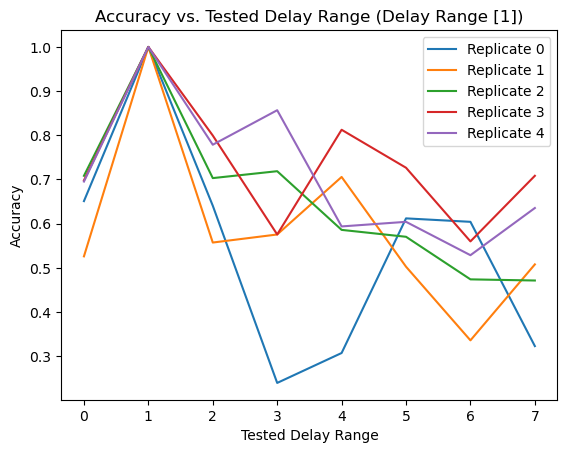

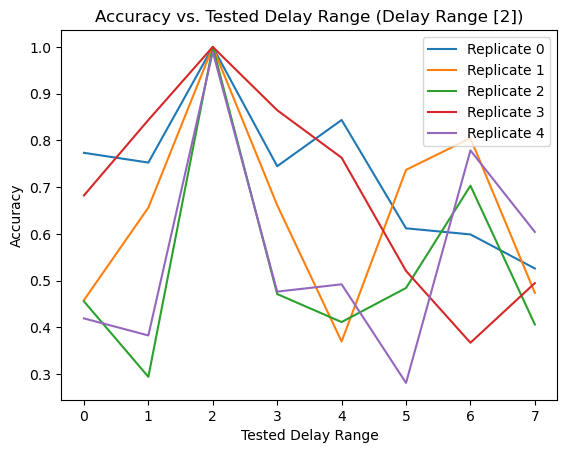

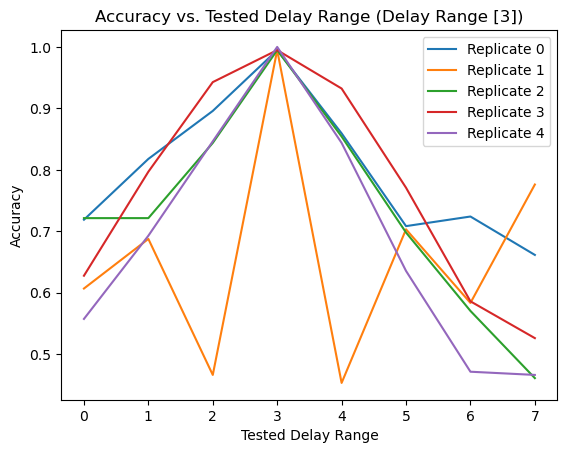

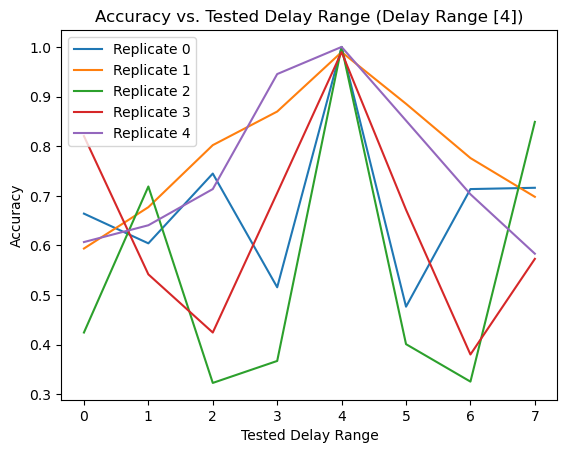

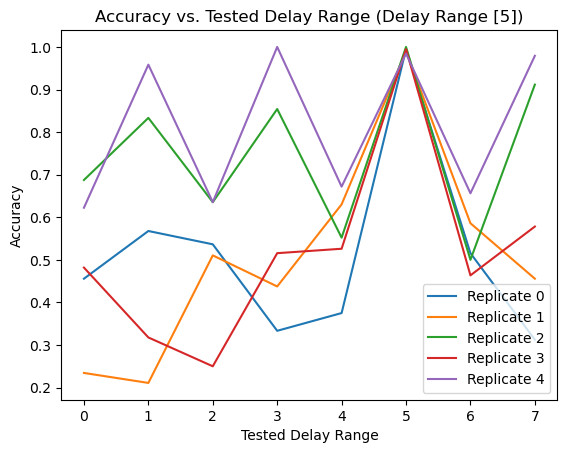

In [11]:
import numpy as np

# Choose the delay ranges and replicates to plot
delay_ranges = [[1],[2],[3],[4],[5]]
num_replicates = 5

# Define the delay ranges to test
test_delay_ranges = range(8)

# Loop over the delay ranges and replicates and test the models
for delayRange in delay_ranges:
    # Initialize list to store the accuracy for each delay range
    #accuracies = []
    
    for replicate in range(num_replicates):
        # Load the trained model for the current delay range and replicate
        accuracies = []
        model_name = f"fullModel_dr{delayRange}_replicate{replicate}.model"
        model = Net(hidden_dim=12,output_dim=6)
        model.load_state_dict(torch.load(model_name))
        #model.eval()

        # Loop over the test delay ranges and test the model
        for test_delay in test_delay_ranges:
            # Create a noisy dataset with the test delay
            nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.2, delayRange=[test_delay])
            # Test the model on the noisy dataset
            
            total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
            accuracy = total
            accuracies.append(accuracy)

        # Plot the accuracies against the test delay ranges
        plt.plot(test_delay_ranges, accuracies, label=f"Replicate {replicate}")
    plt.xlabel("Tested Delay Range")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs. Tested Delay Range (Delay Range {delayRange})")
    #plt.ylim(0, 1) # set y-axis limit to 0-1
    plt.legend() # show legend for replicate lines
    
    
    plt.savefig(f"Accuracy_vs_Delay_Dr{delayRange}.pdf", dpi=300, bbox_inches="tight")
    
    plt.show() # show plot for each replicate


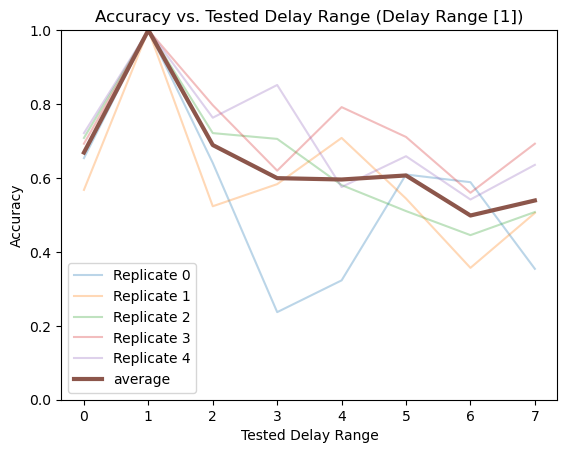

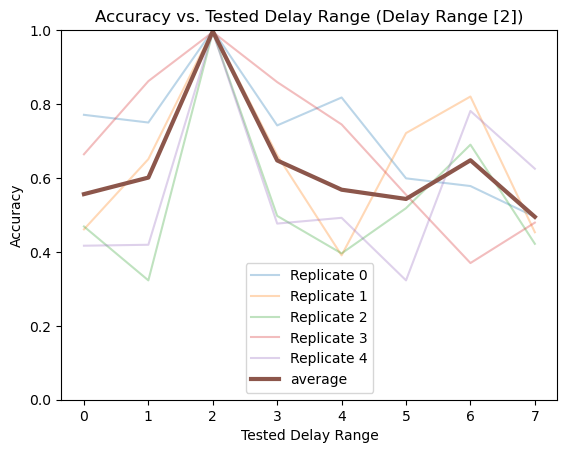

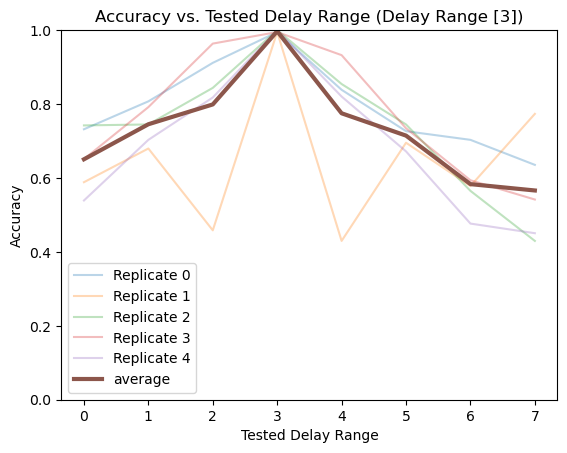

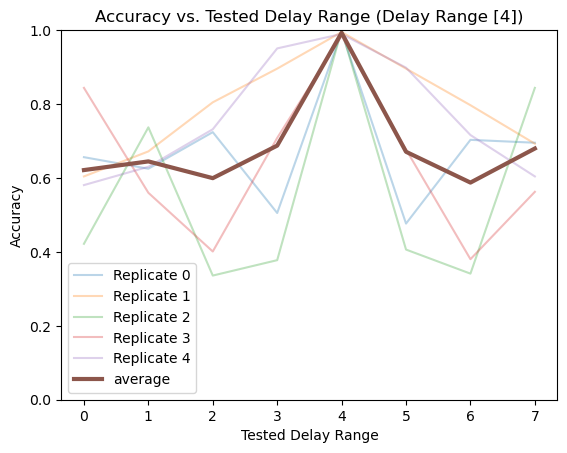

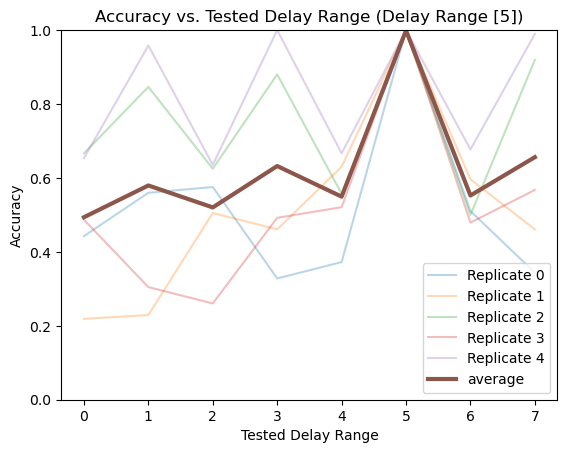

In [12]:
for delayRange in delay_ranges:
    # Initialize list to store the accuracy for each delay range
    accuracies = []
    
    for replicate in range(num_replicates):
        # Load the trained model for the current delay range and replicate
        model_name = f"fullModel_dr{delayRange}_replicate{replicate}.model"
        model = Net(hidden_dim=12,output_dim=6)
        model.load_state_dict(torch.load(model_name))
        
        # Initialize list to store the accuracy for each test delay range for the current replicate
        replicate_accuracies = []
        
        for test_delay in test_delay_ranges:
            # Create a noisy dataset with the test delay
            nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.2, delayRange=[test_delay])
            
            # Test the model on the noisy dataset
            total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
            accuracy = total
            
            # Add accuracy to the list for the current replicate
            replicate_accuracies.append(accuracy)
        
        # Plot the accuracies against the test delay ranges for the current replicate
        plt.plot(test_delay_ranges, replicate_accuracies, alpha=0.3, label=f"Replicate {replicate}")
        
        # Add the replicate accuracies to the list for the current delay range
        accuracies.append(replicate_accuracies)
    
    # Calculate and plot the average accuracy for all replicates for the current delay range
    accuracies = np.array(accuracies)
    mean_accuracies = np.mean(accuracies, axis=0)
    plt.plot(test_delay_ranges, mean_accuracies, label="average", linewidth=3)
    
    # Add legend and axis labels for the plot
    plt.xlabel("Tested Delay Range")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs. Tested Delay Range (Delay Range {delayRange})")
    plt.ylim(0, 1) # set y-axis limit to 0-1
    plt.legend() # show legend for replicate lines
    # Save the plot as a pdf file in the same directory
    plt.savefig(f"AverageAccuracy_vs_TestDelay_dr{delayRange}.png", dpi=300, bbox_inches='tight')
    
    plt.show() # show plot for each delay range


In [33]:
import os
print(os.getcwd())

C:\Users\enajasa\Downloads


In [14]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print(I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh


In [15]:
def getOutTaH(model,dataSet):
    O,H=model.step(torch.Tensor(dataSet))
    H=H.transpose()
    O=O.transpose()
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5):
    output,H=getOutTaH(model,dataSet)
    output=output.transpose()[whichTS::8].transpose()
    H=H.transpose()[whichTS::8].transpose()
    target=target.transpose()[whichTS::8].transpose()
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number*2]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

for model in models:
    #print(models[model])
    nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
    S,H=shrinkingDecompositionInformation(models[model],12,nX,nW.transpose())
#nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
#S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose())

In [16]:
def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    V=numpy.abs(V)
    if V.sum()<=0:
        return V
    return V #  return V/V.max() (playaround)

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)


In [17]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store mean correlation coefficients for all delay ranges
mean_corr_coefs_per_dr_IDR = []

# Loop through delay ranges
for dr in range(1, 6):
    print(f"Processing delay range: {dr}")

    # Initialize a list to store correlation coefficients for the current delay range
    all_corr_coefs_dr_IDR = []

    # Loop through all the models in `models`
    for key, model in models.items():
        if f"dr[{dr}]" in key:  # Select models within the current delay range
            print(f"  Processing model: {key}")

            # Initialize a list to store the images for the current model
            images_IDR = []

            # Loop through the time steps 1 to 5
            for ts in [1, 2, 3, 4, 5]:
                S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
                I = removalIntoMatrix(S, 12, H)
                images_IDR.append(I.flatten())

            # Loop through pairs of images, calculate their correlation coefficients, and print the results
            for i in range(len(images_IDR) - 1):
                for j in range(i + 1, len(images_IDR)):
                    corr_coef_IDR = np.corrcoef(images_IDR[i], images_IDR[j])[0, 1]
                    all_corr_coefs_dr_IDR.append(abs(corr_coef_IDR))
                    print(f"  Model: {key} | Comparing images {i + 1} and {j + 1}: {corr_coef_IDR}")

    # Calculate the mean correlation coefficient for the current delay range
    mean_corr_coef_dr_IDR = np.mean(all_corr_coefs_dr_IDR)
    mean_corr_coefs_per_dr_IDR.append(mean_corr_coef_dr_IDR)
    print(f"Mean correlation coefficient for delay range {dr}: {mean_corr_coef_dr_IDR}")

print(f"Mean correlation coefficients for all delay ranges: {mean_corr_coefs_per_dr_IDR}")


Processing delay range: 1
  Processing model: fullModel_dr[1]_replicate0.model
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 2: 0.5600686385999102
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 3: 0.4405619552264538
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 4: 0.6075590562148601
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 5: 0.4896445539997539
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 3: 0.46677978869277154
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 4: 0.5484379245523608
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 5: 0.6022210845000375
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 4: 0.8912509159003342
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 5: 0.7032789298801463
  Model: fullModel_dr[1]_replicate0.model | Comparing images 4 and 5: 0.6487873430575527
  Processing model: fullModel_

  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 2: 0.3973413058595462
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 3: 0.2765616687545751
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 4: 0.2692969498785746
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 5: -0.04527538508030676
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 3: 0.13398847460745567
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 4: 0.4498867418425039
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 5: 0.3872631185714066
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 4: 0.3276429590498407
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 5: 0.4769934413655537
  Model: fullModel_dr[2]_replicate4.model | Comparing images 4 and 5: 0.39856994062268225
Mean correlation coefficient for delay range 2: 0.2526864070616918
Processing delay range: 3
  Processing 

  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 2: 0.5396143112655019
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 3: 0.21355319307414425
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 4: -0.027968478932563903
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 5: 0.1992788022205657
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 3: 0.40032802000302353
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 4: -0.04275554868868693
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 5: -0.031527350780508216
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 4: 0.5669931305972049
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 5: -0.10431940645228531
  Model: fullModel_dr[4]_replicate3.model | Comparing images 4 and 5: -0.11264584936230851
  Processing model: fullModel_dr[4]_replicate4.model
  Model: fullModel_dr[4]_replicate4.model |

In [22]:
for key, model in models.items():
        if f"dr[{dr}]" in key:  # Select models within the current delay range
            print(f"  Processing model: {key}")

  Processing model: fullModel_dr[5]_replicate0.model
  Processing model: fullModel_dr[5]_replicate1.model
  Processing model: fullModel_dr[5]_replicate2.model
  Processing model: fullModel_dr[5]_replicate3.model
  Processing model: fullModel_dr[5]_replicate4.model


In [19]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store mean Euclidean distances for all delay ranges
mean_euclid_dists_per_dr_IDR = []

# Loop through delay ranges
for dr in range(1, 6):
    print(f"Processing delay range: {dr}")

    # Initialize a list to store Euclidean distances for the current delay range
    all_euclid_dists_dr_IDR = []

    # Loop through all the models in `models`
    for key, model in models.items():
        if f"dr[{dr}]" in key:  # Select models within the current delay range
            print(f"  Processing model: {key}")

            # Initialize a list to store the images for the current model
            images_IDR = []

            # Loop through the time steps 1 to 5
            for ts in [1, 2, 3, 4, 5]:
                S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
                I = removalIntoMatrix(S, 12, H)
                images_IDR.append(I.flatten())

            # Loop through pairs of images, calculate their Euclidean distances, and print the results
            for i in range(len(images_IDR) - 1):
                for j in range(i + 1, len(images_IDR)):
                    euclid_dist_IDR = euclidean_distance(images_IDR[i], images_IDR[j])
                    all_euclid_dists_dr_IDR.append(euclid_dist_IDR)
                    print(f"  Model: {key} | Comparing images {i + 1} and {j + 1}: {euclid_dist_IDR}")

    # Calculate the mean Euclidean distance for the current delay range
    mean_euclid_dist_dr_IDR = np.mean(all_euclid_dists_dr_IDR)
    mean_euclid_dists_per_dr_IDR.append(mean_euclid_dist_dr_IDR)
    print(f"Mean Euclidean distance for delay range {dr}: {mean_euclid_dist_dr_IDR}")

print(f"Mean Euclidean distances for all delay ranges: {mean_euclid_dists_per_dr_IDR}")


Processing delay range: 1
  Processing model: fullModel_dr[1]_replicate0.model
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 2: 1.9202775108059202
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 3: 2.106077360569519
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 4: 1.7866483013066157
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 5: 2.1785453100180554
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 3: 2.012438528917349
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 4: 1.8555329151956406
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 5: 1.8664750607897929
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 4: 0.9191841557640497
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 5: 1.6298295256637645
  Model: fullModel_dr[1]_replicate0.model | Comparing images 4 and 5: 1.7708732763179702
  Processing model: fullModel_dr[

  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 2: 2.2122399172982816
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 3: 2.609561226926605
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 4: 2.6222610565587448
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 5: 2.900579076423497
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 3: 2.73855613293696
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 4: 2.229507560308475
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 5: 2.18985394138393
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 4: 2.460977549135692
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 5: 2.1010256833966654
  Model: fullModel_dr[2]_replicate4.model | Comparing images 4 and 5: 2.2817397228840846
Mean Euclidean distance for delay range 2: 1.9378208753093822
Processing delay range: 3
  Processing model: fullModel_

  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 2: 1.0098388021677707
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 3: 1.5941952751852615
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 4: 1.8595158943009815
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 5: 1.5499789206610153
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 3: 1.407567139474563
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 4: 1.8690852243620393
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 5: 1.711798857997831
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 4: 1.1973258806724876
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 5: 1.7876418223757535
  Model: fullModel_dr[4]_replicate3.model | Comparing images 4 and 5: 1.7873453723681905
  Processing model: fullModel_dr[4]_replicate4.model
  Model: fullModel_dr[4]_replicate4.model | Comparing image

In [20]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store mean Euclidean distances for all delay ranges (using linalg.norm method)
mean_linalg_dists_per_dr = []

# Loop through delay ranges
for dr in range(1, 6):
    print(f"Processing delay range: {dr}")

    # Initialize a list to store Euclidean distances for the current delay range (using linalg.norm method)
    all_linalg_dists_dr = []

    # Loop through all the models in `models`
    for key, model in models.items():
        if f"dr[{dr}]" in key:  # Select models within the current delay range
            print(f"  Processing model: {key}")

            # Initialize a list to store the images for the current model
            images_IDR = []

            # Loop through the time steps 1 to 5
            for ts in [1, 2, 3, 4, 5]:
                S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
                I = removalIntoMatrix(S, 12, H)
                images_IDR.append(I.flatten())

            # Loop through pairs of images, calculate their Euclidean distances using linalg.norm, and print the results
            for i in range(len(images_IDR) - 1):
                for j in range(i + 1, len(images_IDR)):
                    linalg_dist_IDR = np.linalg.norm(images_IDR[i] - images_IDR[j])
                    all_linalg_dists_dr.append(linalg_dist_IDR)
                    print(f"  Model: {key} | Comparing images {i + 1} and {j + 1}: {linalg_dist_IDR}")

    # Calculate the mean Euclidean distance for the current delay range (using linalg.norm method)
    mean_linalg_dist_dr = np.mean(all_linalg_dists_dr)
    mean_linalg_dists_per_dr.append(mean_linalg_dist_dr)
    print(f"Mean Euclidean distance for delay range {dr} (using linalg.norm): {mean_linalg_dist_dr}")

print(f"Mean Euclidean distances for all delay ranges (using linalg.norm): {mean_linalg_dists_per_dr}")


Processing delay range: 1
  Processing model: fullModel_dr[1]_replicate0.model
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 2: 1.9202775108059202
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 3: 2.106077360569519
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 4: 1.7866483013066157
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 5: 2.1785453100180554
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 3: 2.012438528917349
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 4: 1.8555329151956408
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 5: 1.8664750607897929
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 4: 0.9191841557640495
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 5: 1.6298295256637645
  Model: fullModel_dr[1]_replicate0.model | Comparing images 4 and 5: 1.7708732763179702
  Processing model: fullModel_dr[

  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 2: 2.2122399172982816
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 3: 2.6095612269266044
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 4: 2.6222610565587448
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 5: 2.900579076423497
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 3: 2.7385561329369605
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 4: 2.229507560308475
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 5: 2.18985394138393
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 4: 2.4609775491356927
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 5: 2.101025683396665
  Model: fullModel_dr[2]_replicate4.model | Comparing images 4 and 5: 2.2817397228840846
Mean Euclidean distance for delay range 2 (using linalg.norm): 1.9378208753093824
Processing delay range: 3
  Proce

  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 2: 1.0098388021677709
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 3: 1.5941952751852615
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 4: 1.8595158943009815
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 5: 1.5499789206610153
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 3: 1.407567139474563
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 4: 1.8690852243620393
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 5: 1.7117988579978307
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 4: 1.1973258806724876
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 5: 1.7876418223757538
  Model: fullModel_dr[4]_replicate3.model | Comparing images 4 and 5: 1.7873453723681902
  Processing model: fullModel_dr[4]_replicate4.model
  Model: fullModel_dr[4]_replicate4.model | Comparing imag

In [21]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store mean Euclidean distances for all delay ranges (using custom method)
mean_custom_dists_per_dr = []

# Loop through delay ranges
for dr in range(1, 6):
    print(f"Processing delay range: {dr}")

    # Initialize a list to store Euclidean distances for the current delay range (using custom method)
    all_custom_dists_dr = []

    # Loop through all the models in `models`
    for key, model in models.items():
        if f"dr[{dr}]" in key:  # Select models within the current delay range
            print(f"  Processing model: {key}")

            # Initialize a list to store the images for the current model
            images_IDR = []

            # Loop through the time steps 1 to 5
            for ts in [1, 2, 3, 4, 5]:
                S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
                I = removalIntoMatrix(S, 12, H)
                images_IDR.append(I.flatten())

            # Loop through pairs of images, calculate their Euclidean distances using custom method, and print the results
            for i in range(len(images_IDR) - 1):
                for j in range(i + 1, len(images_IDR)):
                    diff = images_IDR[i] - images_IDR[j]
                    dot_product = np.dot(diff, diff.T)
                    custom_dist_IDR = np.sqrt(dot_product)
                    all_custom_dists_dr.append(custom_dist_IDR)
                    print(f"  Model: {key} | Comparing images {i + 1} and {j + 1}: {custom_dist_IDR}")

    # Calculate the mean Euclidean distance for the current delay range (using custom method)
    mean_custom_dist_dr = np.mean(all_custom_dists_dr)
    mean_custom_dists_per_dr.append(mean_custom_dist_dr)
    print(f"Mean Euclidean distance for delay range {dr} (using custom method): {mean_custom_dist_dr}")

print(f"Mean Euclidean distances for all delay ranges (using custom method): {mean_custom_dists_per_dr}")


Processing delay range: 1
  Processing model: fullModel_dr[1]_replicate0.model
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 2: 1.9202775108059202
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 3: 2.106077360569519
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 4: 1.7866483013066157
  Model: fullModel_dr[1]_replicate0.model | Comparing images 1 and 5: 2.1785453100180554
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 3: 2.012438528917349
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 4: 1.8555329151956408
  Model: fullModel_dr[1]_replicate0.model | Comparing images 2 and 5: 1.8664750607897929
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 4: 0.9191841557640495
  Model: fullModel_dr[1]_replicate0.model | Comparing images 3 and 5: 1.6298295256637645
  Model: fullModel_dr[1]_replicate0.model | Comparing images 4 and 5: 1.7708732763179702
  Processing model: fullModel_dr[

  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 2: 2.2122399172982816
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 3: 2.6095612269266044
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 4: 2.6222610565587448
  Model: fullModel_dr[2]_replicate4.model | Comparing images 1 and 5: 2.900579076423497
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 3: 2.7385561329369605
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 4: 2.229507560308475
  Model: fullModel_dr[2]_replicate4.model | Comparing images 2 and 5: 2.18985394138393
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 4: 2.4609775491356927
  Model: fullModel_dr[2]_replicate4.model | Comparing images 3 and 5: 2.101025683396665
  Model: fullModel_dr[2]_replicate4.model | Comparing images 4 and 5: 2.2817397228840846
Mean Euclidean distance for delay range 2 (using custom method): 1.9378208753093824
Processing delay range: 3
  Pro

  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 2: 1.0098388021677709
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 3: 1.5941952751852615
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 4: 1.8595158943009815
  Model: fullModel_dr[4]_replicate3.model | Comparing images 1 and 5: 1.5499789206610153
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 3: 1.407567139474563
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 4: 1.8690852243620393
  Model: fullModel_dr[4]_replicate3.model | Comparing images 2 and 5: 1.7117988579978307
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 4: 1.1973258806724876
  Model: fullModel_dr[4]_replicate3.model | Comparing images 3 and 5: 1.7876418223757538
  Model: fullModel_dr[4]_replicate3.model | Comparing images 4 and 5: 1.7873453723681902
  Processing model: fullModel_dr[4]_replicate4.model
  Model: fullModel_dr[4]_replicate4.model | Comparing imag

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_replicates = 5
n_ts = 5
n_models = len(models)
image_shape = (12, 8)

all_corr_coefs_ID = []
for rep in range(n_replicates):
    images = []
    for key, model in models.items():
        for ts in range(1, n_ts + 1):
            S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
            I = removalIntoMatrix(S, 12, H)
            images.append(I)

    corr_coefs_ID = []
    for i in range(0, n_models * n_ts, n_ts):  # Iterate through each model within the replicate
        for j in range(i, i + n_ts):  # Iterate through the time steps of the current model
            for k in range(j + 1, i + n_ts):  # Compare the current time step with the remaining time steps within the model
                corr_coef_ID = np.corrcoef(images[j].flatten(), images[k].flatten())[0, 1]
                corr_coefs_ID.append(abs(corr_coef_ID))  # Use absolute values for correlation coefficients
                print(f"Calculating correlation coefficient for images {j + 1} and {k + 1}: {corr_coef_ID}")

    mean_corr_coef = np.mean(corr_coefs_ID)
    all_corr_coefs_ID.append({'replicate': rep + 1, 'corr_coefs': corr_coefs_ID, 'mean_corr_coef': mean_corr_coef})

# Print results for each replicate
for res in all_corr_coefs_ID:
    print(f"Replicate {res['replicate']} - Mean correlation coefficient: {res['mean_corr_coef']}")


import numpy as np
import matplotlib.pyplot as plt

n_replicates = 5
n_ts = 5
n_models = len(models)
image_shape = (12, 8)

all_corr_coefs_ID = []
for rep in range(n_replicates):
    images = []
    start_index = 0
    for key, model in models.items():
        for ts in range(1, n_ts + 1):
            S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
            I = removalIntoMatrix(S, 12, H)
            images.append(I)
    
    corr_coefs_ID = []
    for i in range(n_models * n_ts):
        j = i + 1 if i < n_models * n_ts - 1 else start_index
        corr_coef_ID = np.corrcoef(images[i].flatten(), images[j].flatten())[0, 1]
        corr_coefs_ID.append(corr_coef_ID)
        print(f"Calculating correlation coefficient for images {i+1} and {j+1}: {corr_coef_ID}")
    
    mean_corr_coef = np.mean(corr_coefs_ID)
    all_corr_coefs_ID.append({'replicate': rep+1, 'corr_coefs': corr_coefs_ID, 'mean_corr_coef': mean_corr_coef})


In [86]:
#200 , 0.1, v

replicates = []
mean_corr_coefs = []

for d in all_corr_coefs_ID:
    replicates.append(d['replicate'])
    mean_corr_coefs.append(d['mean_corr_coef'])

print(replicates)  # output: [1, 2, 3]
print(mean_corr_coefs)  # output: [0.98, 0.95, 0.97]

[1, 2, 3, 4, 5]
[0.2962284295246492, 0.29008639389347896, 0.2943844196765734, 0.2976711522318834, 0.2945065089571854]


In [72]:
#80 , 0.1, v

replicates = []
mean_corr_coefs = []

for d in all_corr_coefs_ID:
    replicates.append(d['replicate'])
    mean_corr_coefs.append(d['mean_corr_coef'])

print(replicates)  # output: [1, 2, 3]
print(mean_corr_coefs)  # output: [0.98, 0.95, 0.97]

[1, 2, 3, 4, 5]
[0.29179541368539036, 0.29244136850860214, 0.2913533091772819, 0.29198028916151003, 0.29312338610390193]


In [81]:
#80 ,0.001,v

replicates = []
mean_corr_coefs = []

for d in all_corr_coefs_ID:
    replicates.append(d['replicate'])
    mean_corr_coefs.append(d['mean_corr_coef'])

print(replicates)  # output: [1, 2, 3]
print(mean_corr_coefs)  # output: [0.98, 0.95, 0.97]

[1, 2, 3, 4, 5]
[0.24537614326440843, 0.2458462932216038, 0.24599271672588402, 0.24670377642189623, 0.24675827391030938]


In [16]:
 #8 ,0.1, v/v(max)

replicates = []
mean_corr_coefs = []

for d in all_corr_coefs_ID:
    replicates.append(d['replicate'])
    mean_corr_coefs.append(d['mean_corr_coef'])

print(replicates)  # output: [1, 2, 3]
print(mean_corr_coefs)  # output: [0.98, 0.95, 0.97]

[1, 2, 3, 4, 5]
[0.10483892651248806, 0.10280118155653963, 0.10506060987067783, 0.10584410570152154, 0.10749694718809964]


In [21]:
 #100 ,0.1, v

replicates = []
mean_corr_coefs = []

for d in all_corr_coefs_ID:
    replicates.append(d['replicate'])
    mean_corr_coefs.append(d['mean_corr_coef'])

print(replicates)  # output: [1, 2, 3]
print(mean_corr_coefs)  # output: [0.98, 0.95, 0.97]

[1, 2, 3, 4, 5]
[0.1983729486344878, 0.19710640854714448, 0.194376282895089, 0.199040427755731, 0.19666930669524593]


KeyboardInterrupt: 

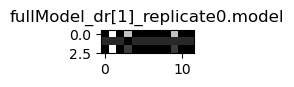

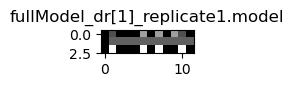

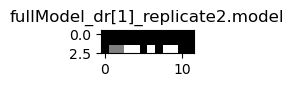

In [80]:
for ts in [0,1,2,3,4,5]:
    for key, model in models.items():
        S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
        figure(figsize=[1.2,0.3])
        imshow(removalIntoMatrix(S,12,H),cmap='gray')
        title(key)

C:\Users\enajasa\AppData\Local\Temp\ipykernel_11016\2581676191.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=[1.2,0.3])


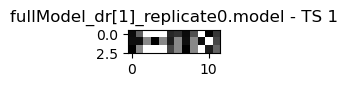

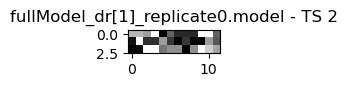

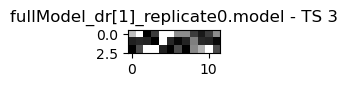

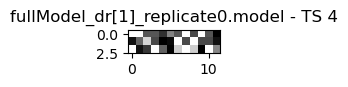

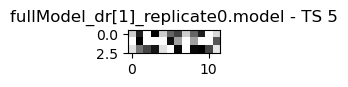

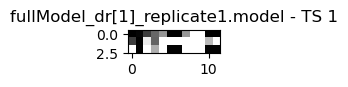

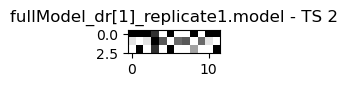

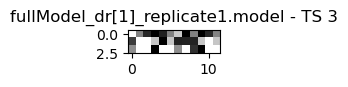

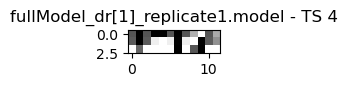

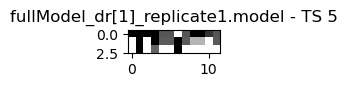

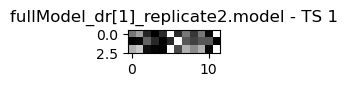

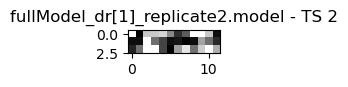

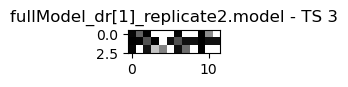

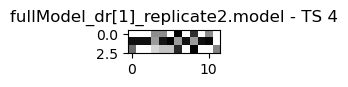

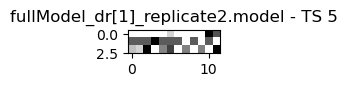

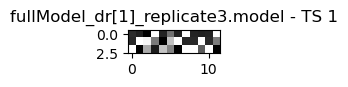

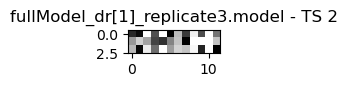

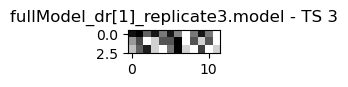

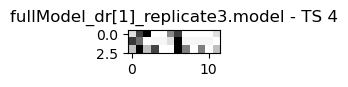

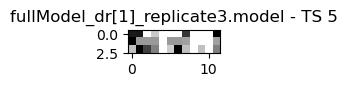

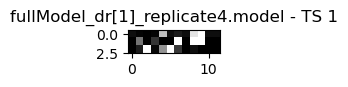

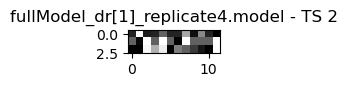

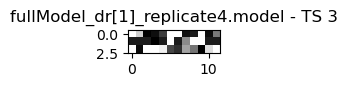

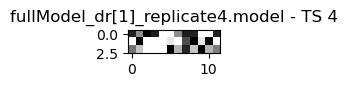

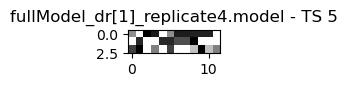

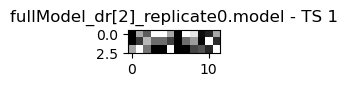

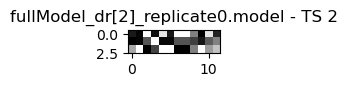

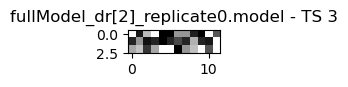

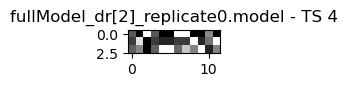

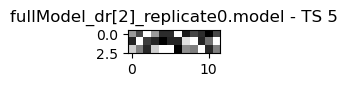

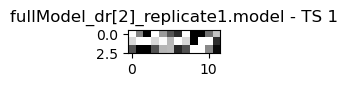

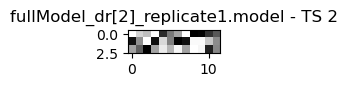

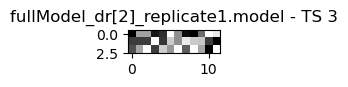

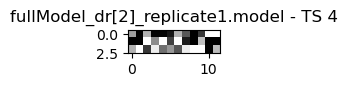

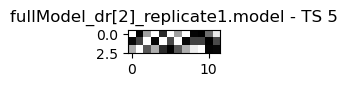

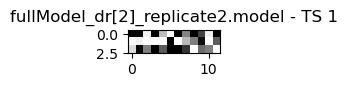

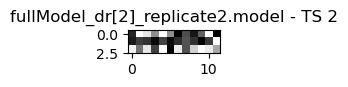

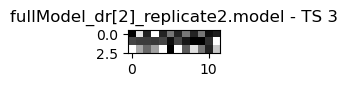

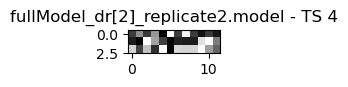

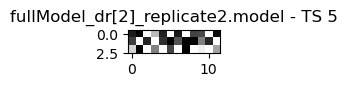

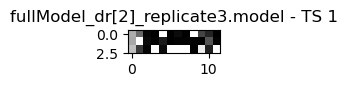

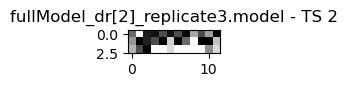

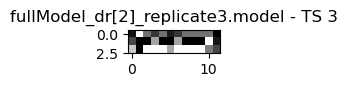

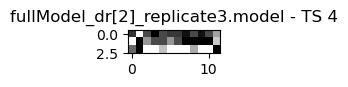

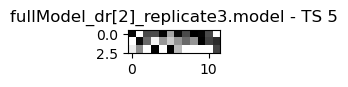

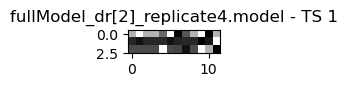

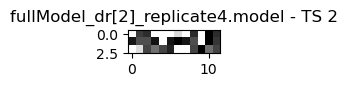

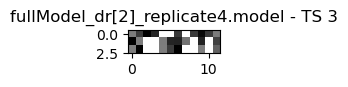

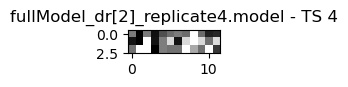

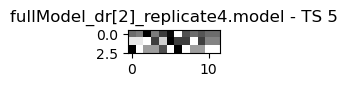

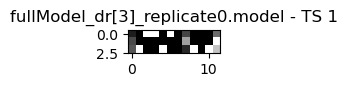

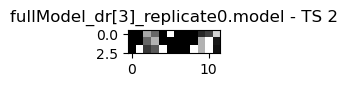

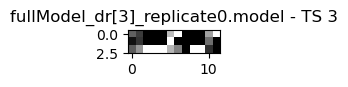

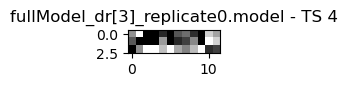

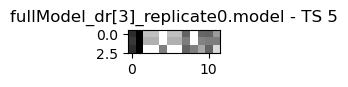

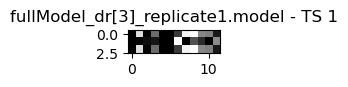

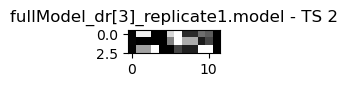

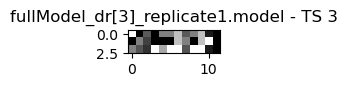

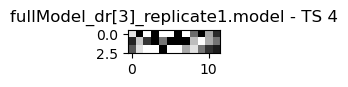

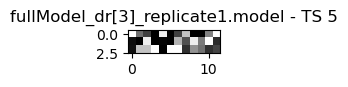

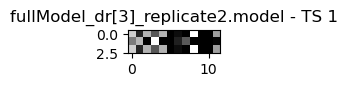

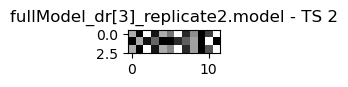

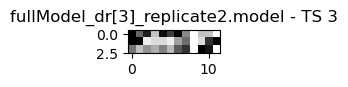

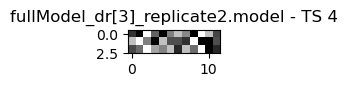

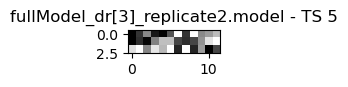

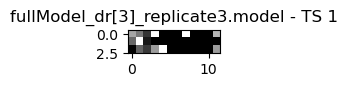

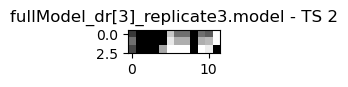

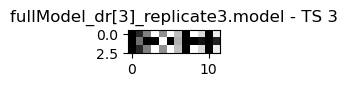

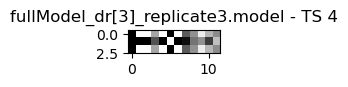

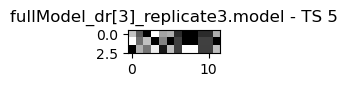

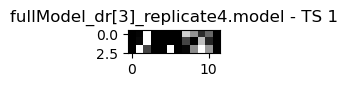

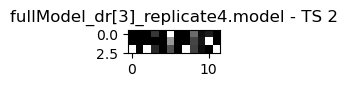

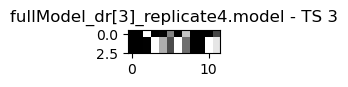

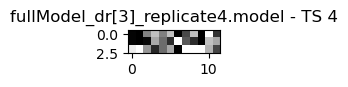

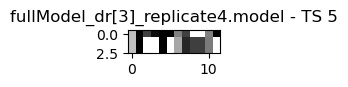

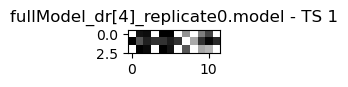

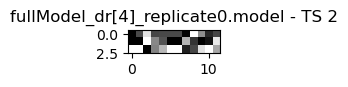

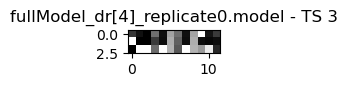

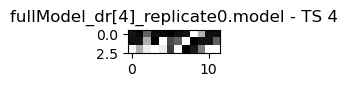

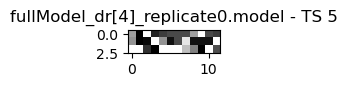

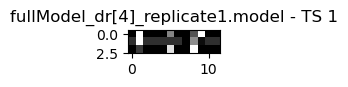

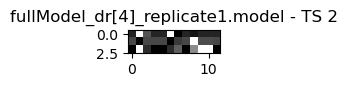

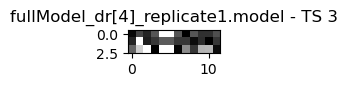

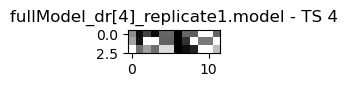

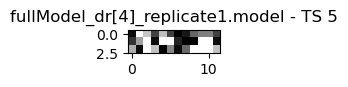

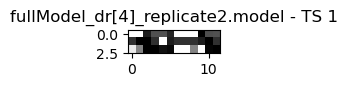

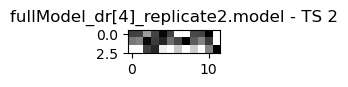

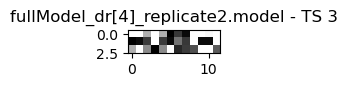

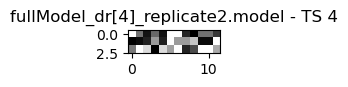

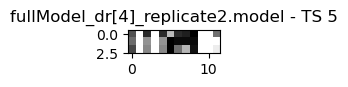

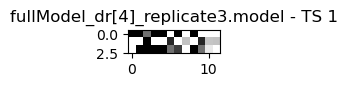

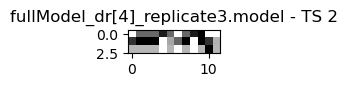

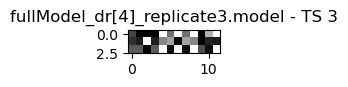

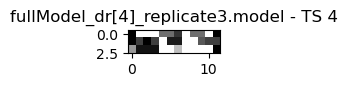

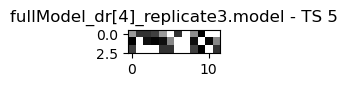

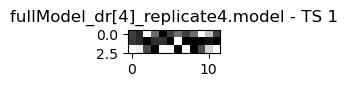

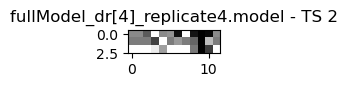

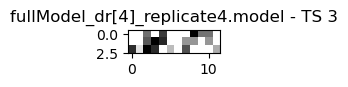

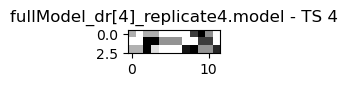

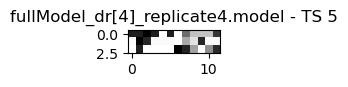

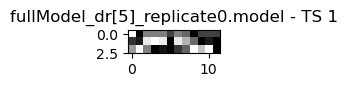

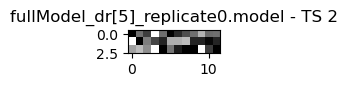

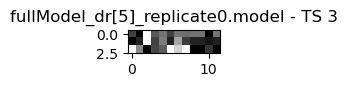

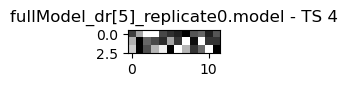

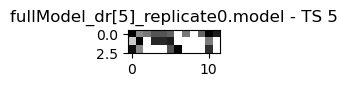

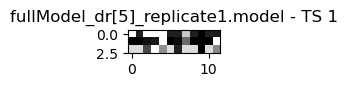

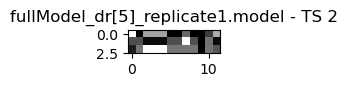

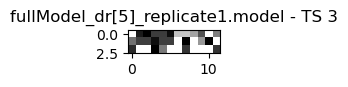

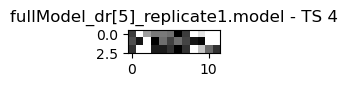

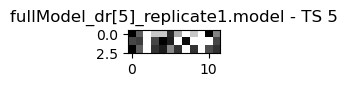

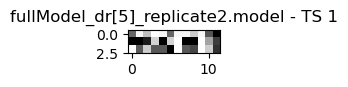

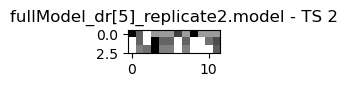

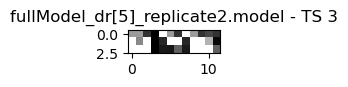

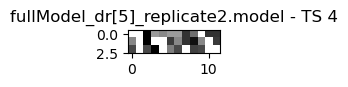

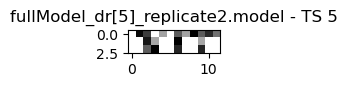

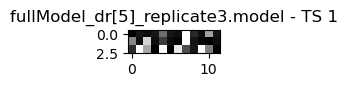

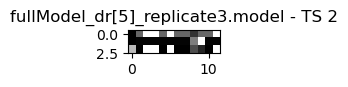

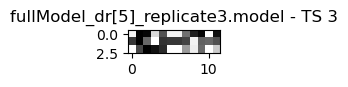

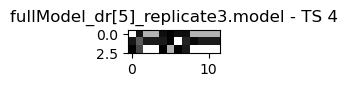

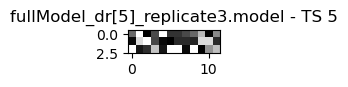

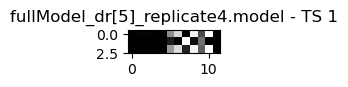

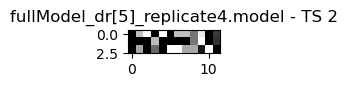

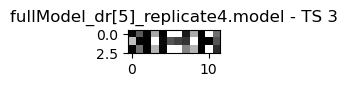

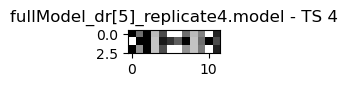

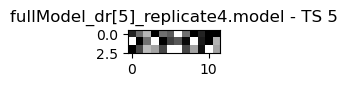

In [38]:
for key, model in models.items():
    for ts in [1,2,3,4,5]:
        S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
        figure(figsize=[1.2,0.3])
        imshow(removalIntoMatrix(S,12,H),cmap='gray')
        title(f"{key} - TS {ts}")


C:\Users\enajasa\AppData\Local\Temp\ipykernel_11016\1008282242.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=[1.2,0.3])


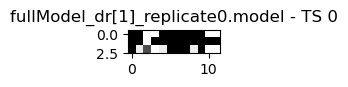

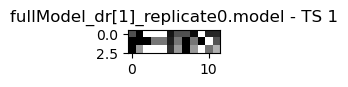

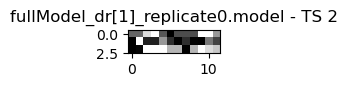

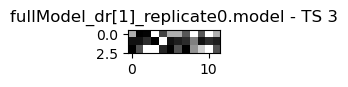

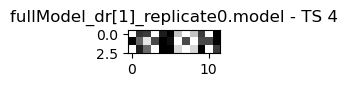

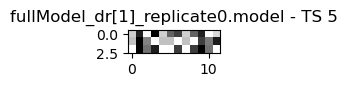

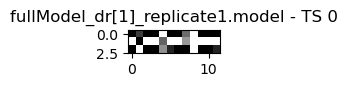

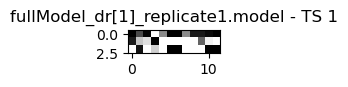

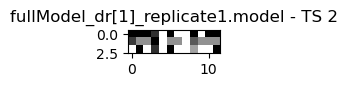

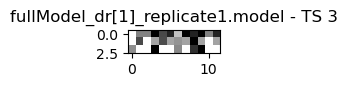

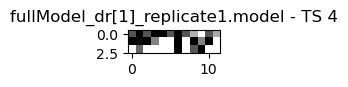

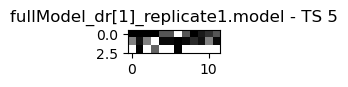

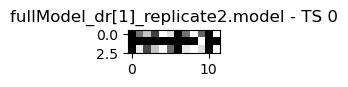

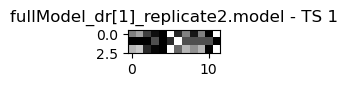

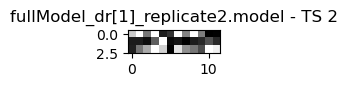

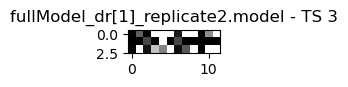

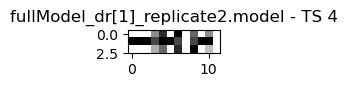

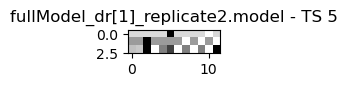

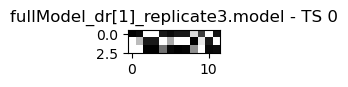

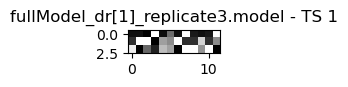

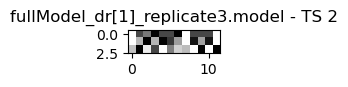

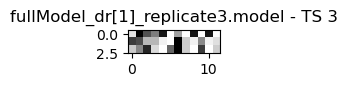

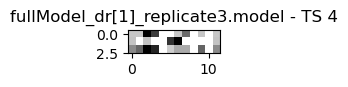

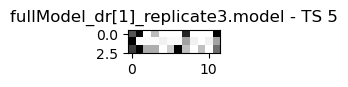

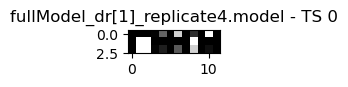

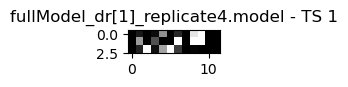

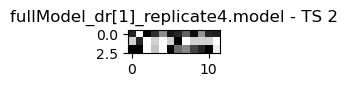

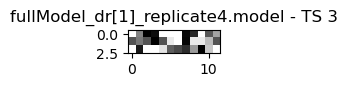

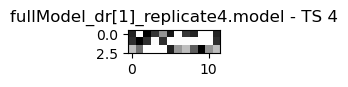

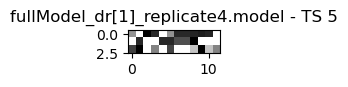

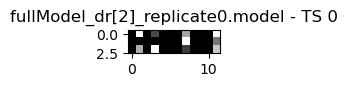

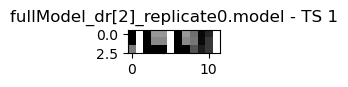

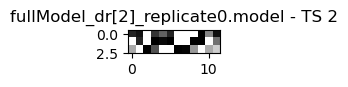

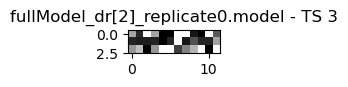

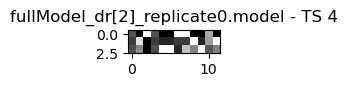

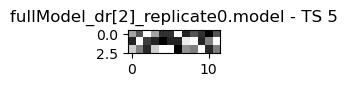

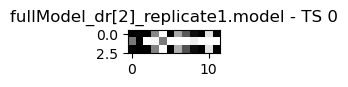

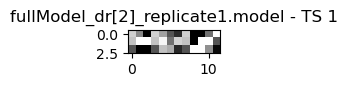

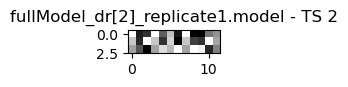

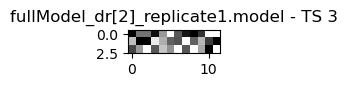

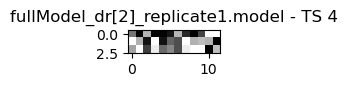

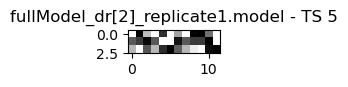

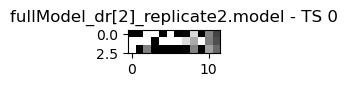

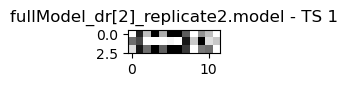

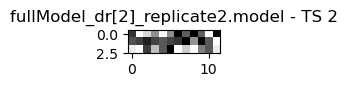

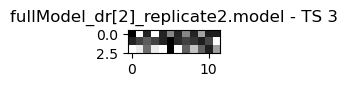

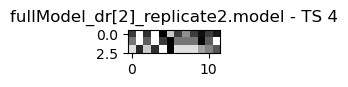

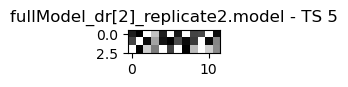

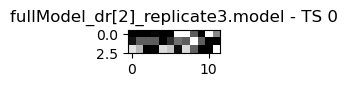

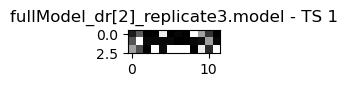

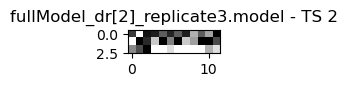

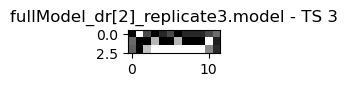

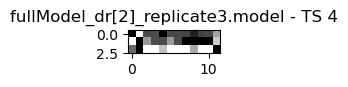

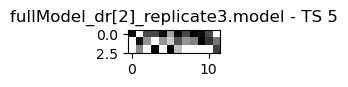

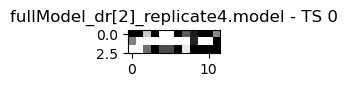

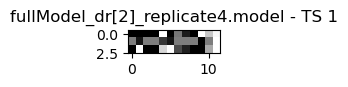

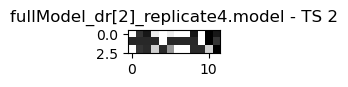

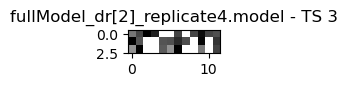

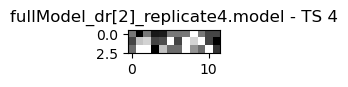

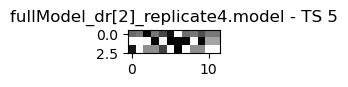

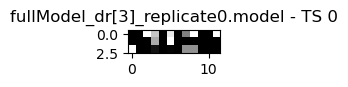

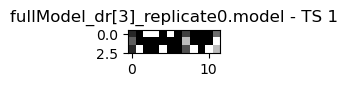

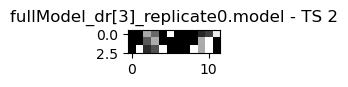

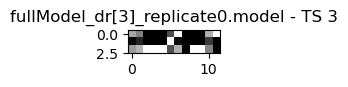

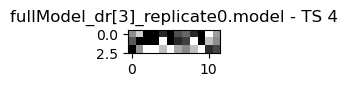

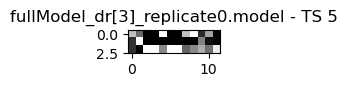

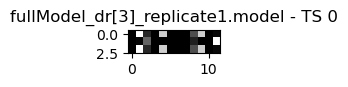

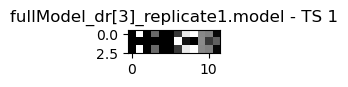

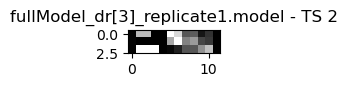

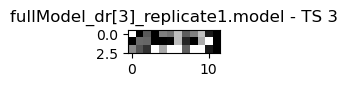

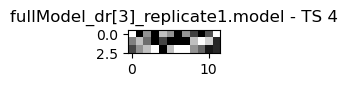

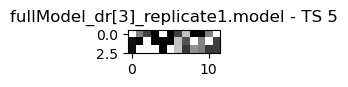

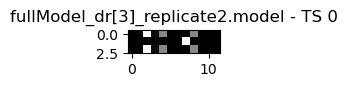

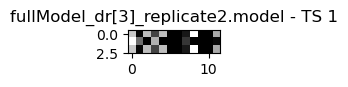

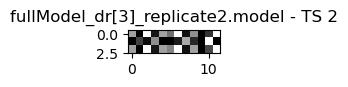

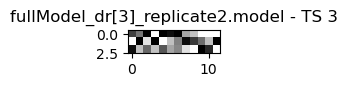

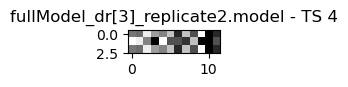

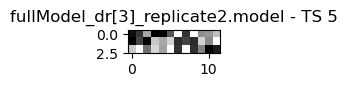

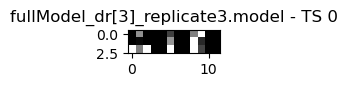

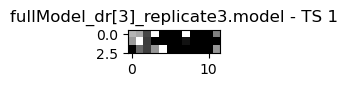

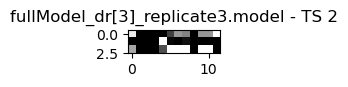

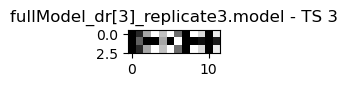

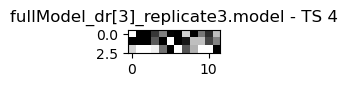

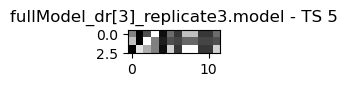

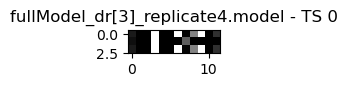

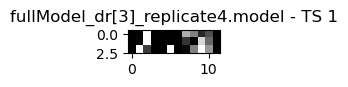

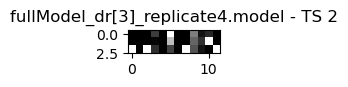

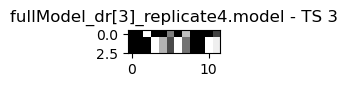

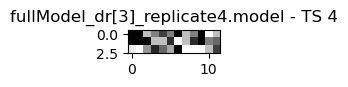

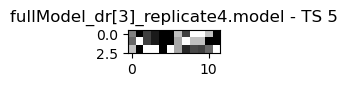

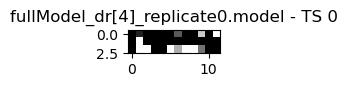

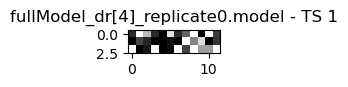

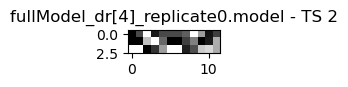

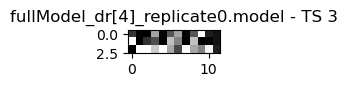

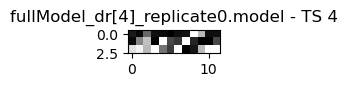

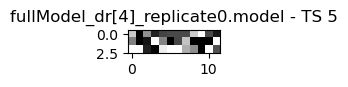

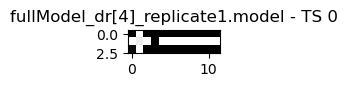

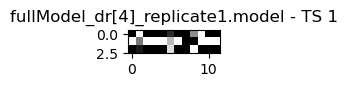

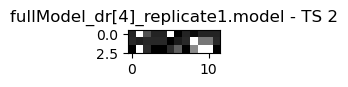

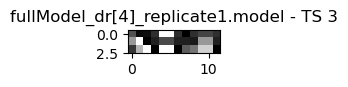

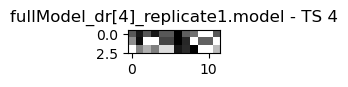

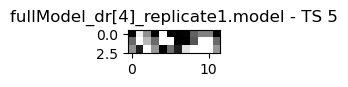

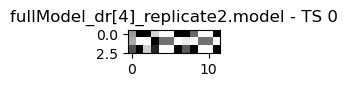

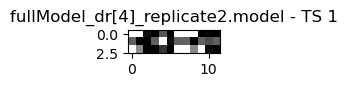

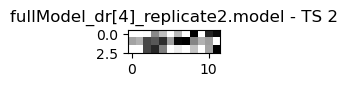

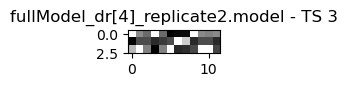

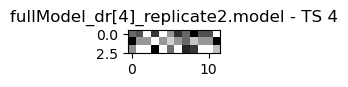

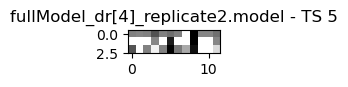

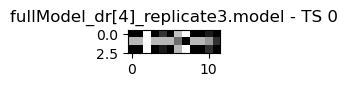

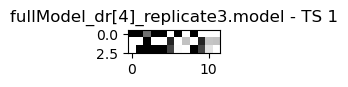

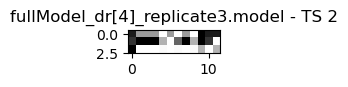

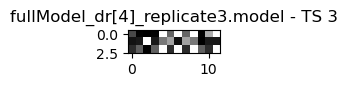

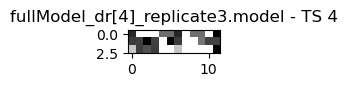

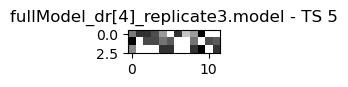

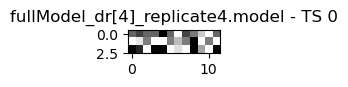

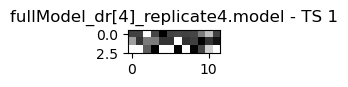

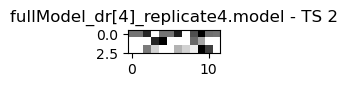

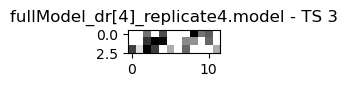

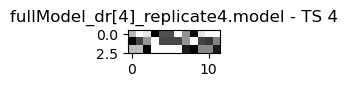

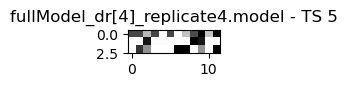

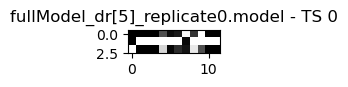

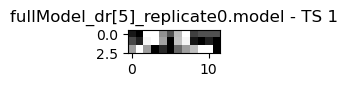

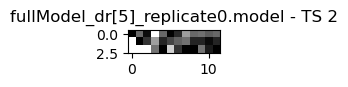

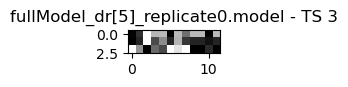

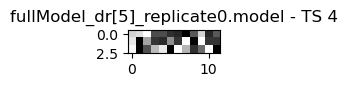

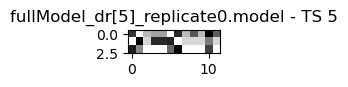

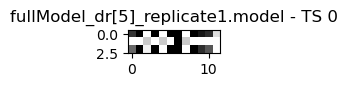

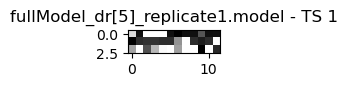

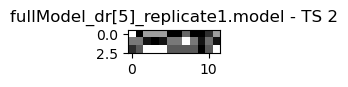

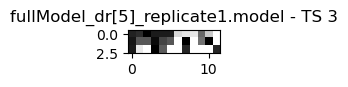

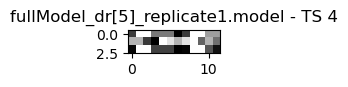

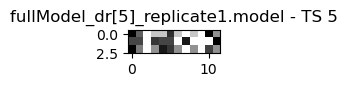

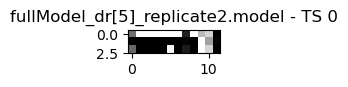

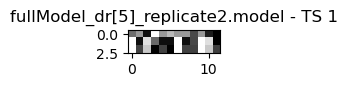

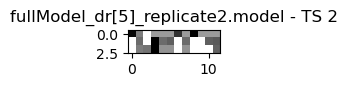

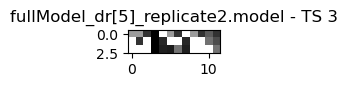

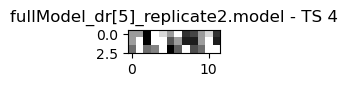

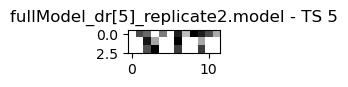

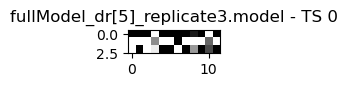

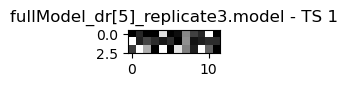

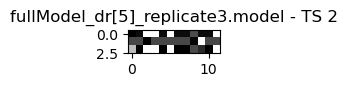

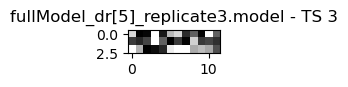

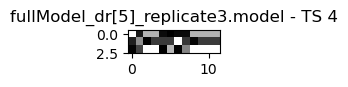

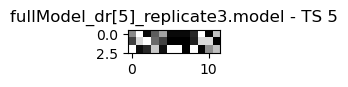

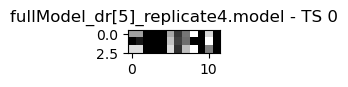

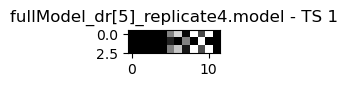

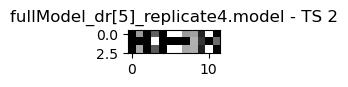

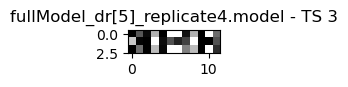

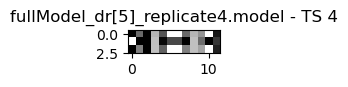

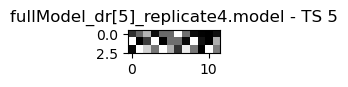

In [47]:
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
images=[]
for key, model in models.items():
    for ts in [0,1,2,3,4,5]:
        S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
        figure(figsize=[1.2,0.3])
        I=removalIntoMatrix(S,12,H)
        imshow(I,cmap="gray")
        #title(str(ts))
        title(f"{key} - TS {ts}")
        images.append(I.flatten())

1 0.17797138859783668
2 0.3969379658863054
3 0.5929203235661622
4 -0.1520323860251443
5 0.31279936652250956


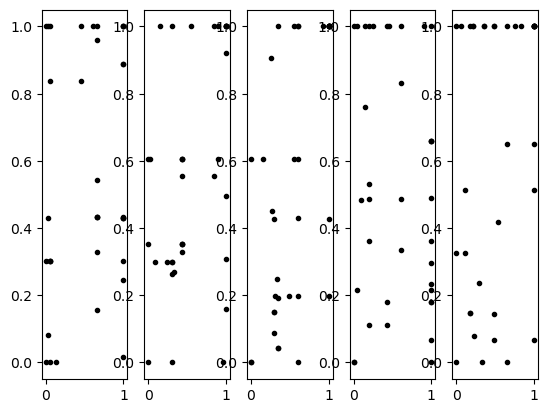

In [69]:
for i in range(1, len(images)):
    print(i, corrcoef(images[i-1], images[i])[0, 1])
    ax = subplot(1, 5, i)
    ax.plot(images[i-1], images[i], '.', color='k')


In [24]:
for ts in [0,1,2,3,4,5]:
    for key, model in models.items():
        S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
        figure(figsize=[2.1,0.6])
        imshow(removalIntoMatrix(S,12,H),cmap='gray')
        title(f"{key} - ts: {ts}", fontsize=8)

NameError: name 'models' is not defined

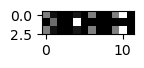

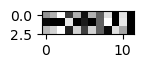

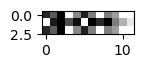

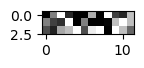

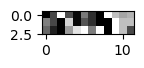

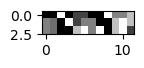

In [25]:
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
for ts in [0,1,2,3,4,5]:
    S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
    figure(figsize=[1.2,0.3])
    imshow(removalIntoMatrix(S,12,H),cmap='gray')

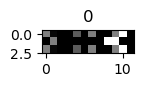

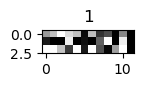

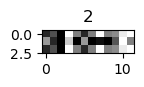

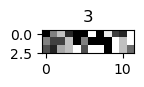

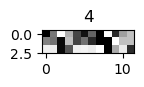

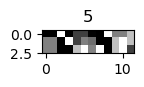

In [26]:
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
images=[]
for ts in [0,1,2,3,4,5]:
    S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
    figure(figsize=[1.2,0.3])
    I=removalIntoMatrix(S,12,H)
    imshow(I,cmap="gray")
    title(str(ts))
    images.append(I.flatten())

# Combined Delay Ranges

In [47]:
def test (model,X=X,Y=Y,S=worldS):
    divs=[]
    for i in range(X.shape[0]):
        model.resetHidden()
        output=model(torch.Tensor(X[i].reshape(1,X[i].shape[0],4)))
        div=output.detach().numpy().reshape(Y[i].shape)-Y[i]
        divs.append(1.0-abs(div).mean())
    acc=mean(divs)
    return acc

model=Net(hidden_dim=12,output_dim=6)
#model.load_state_dict(torch.load("fullModel.model"))
print("full model:",test(model))

full model: 0.49676442084213096


In [54]:
import matplotlib.pyplot as plt


num_replicates = 20
cdrmodels = {}

#for delayRange in delay_ranges:
#    print(f"Training for delay range {delayRange}...")
all_w = []

for replicate in range(num_replicates):
    model=Net(hidden_dim=12,output_dim=6)
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    error = nn.MSELoss()
    acc=0.0
    W=[]
    Ts=[]
    iteration_list = []
    loss_list = []
    accuracy_list = []

    while acc<0.97:
        divs=[]
        model.resetHidden()
        nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[1,2,3,4,5]) #variance for the ND is 0.2
        for i in range(nX.shape[0]): #use 64 when training for single delayRange
            optimizer.zero_grad()
            output = model(torch.Tensor(nX[i].reshape(1,nX[i].shape[0],4))) #shape greater than 8
            loss = error(output, torch.Tensor(nY[i]))
            loss.backward()
            optimizer.step()
            div=output.detach().numpy().reshape(nY[i].shape)-nY[i]
            divs.append(1.0-abs(div).mean())
            current_iteration = len(iteration_list) + 1
            loss_list.append(loss.item())
            iteration_list.append(current_iteration)
            accuracy_list.append(mean(divs))

        acc=mean(divs)
        W.append(acc)
        #total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
        total = test(model, X=nX, Y=nY, S=nS)
        #Ts.append(subA)
        print(f"Iteration: {current_iteration}, Loss: {loss.item()}, Accuracy: {accuracy_list[-1]}")

    model_name = f"CDRfullModel_dr_replicate{replicate}.model"
    torch.save(model.state_dict(), model_name)
    print(f"Saved {model_name}")
    cdrmodels[model_name] = model

    W_name = f"W_dr_replicate{replicate}.p"
    with open(W_name, "wb") as f:
        pickle.dump(W, f)
    print(f"Saved {W_name}")

    w=[]
    for tr in [0,1,2,3,4,5,6,7]:
        nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[tr])
        #total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
        total = test(model, X=nX, Y=nY, S=nS)
        print(tr,total)
        w.append(total)

    all_w.append(w)
    w_name = f"w_dr_replicate{replicate}.p"
    with open(w_name, "wb") as f:
        pickle.dump(w, f)
    print(f"Saved {w_name}")

    print(f"Replicate {replicate} completed")
    print(f"Time elapsed: {time.process_time()} seconds")


C:\Users\enajasa\AppData\Local\Temp\ipykernel_12600\1205567648.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nX=numpy.array(nX)
C:\Users\enajasa\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 64, Loss: 0.24578218162059784, Accuracy: 0.49922966491431
Iteration: 128, Loss: 0.2700108289718628, Accuracy: 0.4996950295753777
Iteration: 192, Loss: 0.2508387863636017, Accuracy: 0.4983642930164933
Iteration: 256, Loss: 0.25855109095573425, Accuracy: 0.5010422021150589
Iteration: 320, Loss: 0.24663347005844116, Accuracy: 0.4998479471541941
Iteration: 384, Loss: 0.24862460792064667, Accuracy: 0.5010267389006913
Iteration: 448, Loss: 0.24489761888980865, Accuracy: 0.49953565932810307
Iteration: 512, Loss: 0.25598660111427307, Accuracy: 0.4996134196408093
Iteration: 576, Loss: 0.2514587938785553, Accuracy: 0.4996882239356637
Iteration: 640, Loss: 0.24991554021835327, Accuracy: 0.5001084050163627
Iteration: 704, Loss: 0.25508931279182434, Accuracy: 0.5010738791897893
Iteration: 768, Loss: 0.24670319259166718, Accuracy: 0.5007515195757151
Iteration: 832, Loss: 0.2542669177055359, Accuracy: 0.5010740463621914
Iteration: 896, Loss: 0.2508451044559479, Accuracy: 0.506056600715965


Iteration: 7488, Loss: 0.10975263267755508, Accuracy: 0.764018083922565
Iteration: 7552, Loss: 0.1582810878753662, Accuracy: 0.7642920543439686
Iteration: 7616, Loss: 0.07243869453668594, Accuracy: 0.7655365755781531
Iteration: 7680, Loss: 0.12401551753282547, Accuracy: 0.7804401700850576
Iteration: 7744, Loss: 0.11444276571273804, Accuracy: 0.7834698625374585
Iteration: 7808, Loss: 0.07646722346544266, Accuracy: 0.7877252523321658
Iteration: 7872, Loss: 0.10447167605161667, Accuracy: 0.7873714652378112
Iteration: 7936, Loss: 0.10350754112005234, Accuracy: 0.7947415700182319
Iteration: 8000, Loss: 0.0760403722524643, Accuracy: 0.7847171318717301
Iteration: 8064, Loss: 0.07157274335622787, Accuracy: 0.7914895282592624
Iteration: 8128, Loss: 0.09779751300811768, Accuracy: 0.7805029025766999
Iteration: 8192, Loss: 0.07564547657966614, Accuracy: 0.7937344117090106
Iteration: 8256, Loss: 0.0648997575044632, Accuracy: 0.7878426678944379
Iteration: 8320, Loss: 0.09321308881044388, Accuracy: 0

Iteration: 14784, Loss: 0.07008910924196243, Accuracy: 0.8354477002285421
Iteration: 14848, Loss: 0.05391309782862663, Accuracy: 0.8330730526940897
Iteration: 14912, Loss: 0.062187548726797104, Accuracy: 0.8387531402986497
Iteration: 14976, Loss: 0.05154242739081383, Accuracy: 0.8414105123374611
Iteration: 15040, Loss: 0.0706162080168724, Accuracy: 0.8411036357283592
Iteration: 15104, Loss: 0.03644693270325661, Accuracy: 0.8334335720865056
Iteration: 15168, Loss: 0.09757087379693985, Accuracy: 0.8379827626049519
Iteration: 15232, Loss: 0.0791776105761528, Accuracy: 0.8390907855937257
Iteration: 15296, Loss: 0.09367146342992783, Accuracy: 0.8420497042825446
Iteration: 15360, Loss: 0.013375133275985718, Accuracy: 0.840030831634067
Iteration: 15424, Loss: 0.09930992871522903, Accuracy: 0.829449157230556
Iteration: 15488, Loss: 0.09116417169570923, Accuracy: 0.8425354629289359
Iteration: 15552, Loss: 0.07251181453466415, Accuracy: 0.837001318228431
Iteration: 15616, Loss: 0.068288922309875

Iteration: 21888, Loss: 0.002431891392916441, Accuracy: 0.9027833024738356
Iteration: 21952, Loss: 0.020508885383605957, Accuracy: 0.8950895635643974
Iteration: 22016, Loss: 0.0721108689904213, Accuracy: 0.9161637117504142
Iteration: 22080, Loss: 0.013880323618650436, Accuracy: 0.9076540796086192
Iteration: 22144, Loss: 0.008574052713811398, Accuracy: 0.9030125205172226
Iteration: 22208, Loss: 0.008595198392868042, Accuracy: 0.8899367732228711
Iteration: 22272, Loss: 0.01828446052968502, Accuracy: 0.9094786636997014
Iteration: 22336, Loss: 0.01682978868484497, Accuracy: 0.9024035668699071
Iteration: 22400, Loss: 0.021843185648322105, Accuracy: 0.9044263762771152
Iteration: 22464, Loss: 0.014876923523843288, Accuracy: 0.9164201827370562
Iteration: 22528, Loss: 0.18034470081329346, Accuracy: 0.909424772427883
Iteration: 22592, Loss: 0.021459296345710754, Accuracy: 0.9125434345914982
Iteration: 22656, Loss: 0.004634667653590441, Accuracy: 0.914717364765238
Iteration: 22720, Loss: 0.242541

Iteration: 28992, Loss: 0.008051133714616299, Accuracy: 0.9462678657437209
Iteration: 29056, Loss: 0.008961085230112076, Accuracy: 0.959091191412881
Iteration: 29120, Loss: 0.0008592871599830687, Accuracy: 0.9228018621797673
Iteration: 29184, Loss: 0.0006881295703351498, Accuracy: 0.9123123627214227
Iteration: 29248, Loss: 0.020535888150334358, Accuracy: 0.9604189173260238
Iteration: 29312, Loss: 0.003297535004094243, Accuracy: 0.9616616643033922
Iteration: 29376, Loss: 0.003171848366037011, Accuracy: 0.9532064596423879
Iteration: 29440, Loss: 0.0042449068278074265, Accuracy: 0.9611694421328139
Iteration: 29504, Loss: 0.0008905258146114647, Accuracy: 0.9600134901411366
Iteration: 29568, Loss: 0.0010747102787718177, Accuracy: 0.9655496110353852
Iteration: 29632, Loss: 0.0023570575285702944, Accuracy: 0.9636648360756226
Iteration: 29696, Loss: 0.008118041791021824, Accuracy: 0.960504486458376
Iteration: 29760, Loss: 0.002497372915968299, Accuracy: 0.9335709726146888
Iteration: 29824, Los

Iteration: 5440, Loss: 0.06287270784378052, Accuracy: 0.7057120695244521
Iteration: 5504, Loss: 0.08125025779008865, Accuracy: 0.7112086589913815
Iteration: 5568, Loss: 0.18258638679981232, Accuracy: 0.7141867196187377
Iteration: 5632, Loss: 0.12175730615854263, Accuracy: 0.7072929705027491
Iteration: 5696, Loss: 0.08455868810415268, Accuracy: 0.7203267659060657
Iteration: 5760, Loss: 0.1404515951871872, Accuracy: 0.7197898980230093
Iteration: 5824, Loss: 0.11085667461156845, Accuracy: 0.7302841877099127
Iteration: 5888, Loss: 0.1373157799243927, Accuracy: 0.7293830877169967
Iteration: 5952, Loss: 0.10737281292676926, Accuracy: 0.735495253931731
Iteration: 6016, Loss: 0.12523843348026276, Accuracy: 0.7417819425463676
Iteration: 6080, Loss: 0.10574807971715927, Accuracy: 0.7468739643227309
Iteration: 6144, Loss: 0.0747559443116188, Accuracy: 0.7487041875720024
Iteration: 6208, Loss: 0.07519650459289551, Accuracy: 0.7515685281250626
Iteration: 6272, Loss: 0.1153019443154335, Accuracy: 0.

Iteration: 12736, Loss: 0.07969824224710464, Accuracy: 0.8246039499063045
Iteration: 12800, Loss: 0.0687549039721489, Accuracy: 0.8243687758222222
Iteration: 12864, Loss: 0.0804976150393486, Accuracy: 0.823019779054448
Iteration: 12928, Loss: 0.08530902117490768, Accuracy: 0.8239702556747943
Iteration: 12992, Loss: 0.07987233251333237, Accuracy: 0.822752169566229
Iteration: 13056, Loss: 0.08191873878240585, Accuracy: 0.8242866874206811
Iteration: 13120, Loss: 0.0798875018954277, Accuracy: 0.8240969360340387
Iteration: 13184, Loss: 0.08835643529891968, Accuracy: 0.8236367031931877
Iteration: 13248, Loss: 0.0631350725889206, Accuracy: 0.8241248393896967
Iteration: 13312, Loss: 0.08544588088989258, Accuracy: 0.8239083488006145
Iteration: 13376, Loss: 0.062172066420316696, Accuracy: 0.825937177054584
Iteration: 13440, Loss: 0.07608889788389206, Accuracy: 0.8201707343105227
Iteration: 13504, Loss: 0.0866403579711914, Accuracy: 0.8176040330436081
Iteration: 13568, Loss: 0.07948213070631027, 

Iteration: 20032, Loss: 0.09972792863845825, Accuracy: 0.8411765964701772
Iteration: 20096, Loss: 0.1021808311343193, Accuracy: 0.8420914848102257
Iteration: 20160, Loss: 0.09215893596410751, Accuracy: 0.8378089712932706
Iteration: 20224, Loss: 0.056142162531614304, Accuracy: 0.8404653354082257
Iteration: 20288, Loss: 0.06276383250951767, Accuracy: 0.843281370587647
Iteration: 20352, Loss: 0.04055914655327797, Accuracy: 0.8367408929625526
Iteration: 20416, Loss: 0.03438245877623558, Accuracy: 0.8412682751659304
Iteration: 20480, Loss: 0.0942327082157135, Accuracy: 0.8358787030447274
Iteration: 20544, Loss: 0.08124572038650513, Accuracy: 0.8363843352999538
Iteration: 20608, Loss: 0.09325113147497177, Accuracy: 0.8353848767001182
Iteration: 20672, Loss: 0.07888653129339218, Accuracy: 0.832484046346508
Iteration: 20736, Loss: 0.07893434166908264, Accuracy: 0.8360676725860685
Iteration: 20800, Loss: 0.09579487890005112, Accuracy: 0.8302158486330882
Iteration: 20864, Loss: 0.063424237072467

Iteration: 27136, Loss: 0.07588470727205276, Accuracy: 0.8588756898534484
Iteration: 27200, Loss: 0.058678191155195236, Accuracy: 0.8594740210683085
Iteration: 27264, Loss: 0.10125605016946793, Accuracy: 0.8620938434032723
Iteration: 27328, Loss: 0.05034509301185608, Accuracy: 0.8624038433772512
Iteration: 27392, Loss: 0.06356292217969894, Accuracy: 0.8599583760369569
Iteration: 27456, Loss: 0.09818082302808762, Accuracy: 0.8613734945538454
Iteration: 27520, Loss: 0.013630334287881851, Accuracy: 0.8697772072046064
Iteration: 27584, Loss: 0.011211971752345562, Accuracy: 0.8623705620411783
Iteration: 27648, Loss: 0.025483444333076477, Accuracy: 0.8617513793869875
Iteration: 27712, Loss: 0.1464128941297531, Accuracy: 0.8687521900283173
Iteration: 27776, Loss: 0.10206258296966553, Accuracy: 0.861813840107061
Iteration: 27840, Loss: 0.07608731836080551, Accuracy: 0.8616717491531745
Iteration: 27904, Loss: 0.005297453608363867, Accuracy: 0.868084570276551
Iteration: 27968, Loss: 0.0735420808

Iteration: 34240, Loss: 0.0015287738060578704, Accuracy: 0.9171815549489111
Iteration: 34304, Loss: 0.10487867146730423, Accuracy: 0.9115498300234322
Iteration: 34368, Loss: 0.0009577434975653887, Accuracy: 0.9218130142253358
Iteration: 34432, Loss: 0.001973305596038699, Accuracy: 0.9114696967008058
Iteration: 34496, Loss: 0.007333157118409872, Accuracy: 0.9069337167020421
Iteration: 34560, Loss: 0.006778534036129713, Accuracy: 0.9118244879646227
Iteration: 34624, Loss: 0.020383166149258614, Accuracy: 0.910900806542486
Iteration: 34688, Loss: 0.09155813604593277, Accuracy: 0.9168955570203252
Iteration: 34752, Loss: 0.0006779840332455933, Accuracy: 0.9221432740450837
Iteration: 34816, Loss: 0.0005429386510513723, Accuracy: 0.9152536300534848
Iteration: 34880, Loss: 0.003529467387124896, Accuracy: 0.9183129329176154
Iteration: 34944, Loss: 0.0011602278100326657, Accuracy: 0.916385152580915
Iteration: 35008, Loss: 0.002537915948778391, Accuracy: 0.9203252437582705
Iteration: 35072, Loss: 

Iteration: 41344, Loss: 0.0004145924176555127, Accuracy: 0.9186426732339896
Iteration: 41408, Loss: 0.0019264668226242065, Accuracy: 0.9260861530492548
Iteration: 41472, Loss: 0.003460106672719121, Accuracy: 0.936838085835916
Iteration: 41536, Loss: 0.0007815270218998194, Accuracy: 0.9338465942128096
Iteration: 41600, Loss: 0.000633650051895529, Accuracy: 0.9366965698282002
Iteration: 41664, Loss: 0.04644298553466797, Accuracy: 0.9336171667819144
Iteration: 41728, Loss: 0.0011872262693941593, Accuracy: 0.9374767008703202
Iteration: 41792, Loss: 0.020240215584635735, Accuracy: 0.9250624993437668
Iteration: 41856, Loss: 0.07671022415161133, Accuracy: 0.932873883866705
Iteration: 41920, Loss: 0.0556311309337616, Accuracy: 0.9348348331259331
Iteration: 41984, Loss: 0.0006954926066100597, Accuracy: 0.9394473893626127
Iteration: 42048, Loss: 0.06450702995061874, Accuracy: 0.9336527101404499
Iteration: 42112, Loss: 0.03378576040267944, Accuracy: 0.9431822652986739
Iteration: 42176, Loss: 0.00

Iteration: 960, Loss: 0.19884569942951202, Accuracy: 0.5123257944360375
Iteration: 1024, Loss: 0.18898753821849823, Accuracy: 0.5146032408811152
Iteration: 1088, Loss: 0.3143409788608551, Accuracy: 0.5234605856239796
Iteration: 1152, Loss: 0.2716193199157715, Accuracy: 0.5055980747565627
Iteration: 1216, Loss: 0.1847413182258606, Accuracy: 0.5256785382516682
Iteration: 1280, Loss: 0.17592625319957733, Accuracy: 0.5241751242429018
Iteration: 1344, Loss: 0.26043978333473206, Accuracy: 0.5192042216658592
Iteration: 1408, Loss: 0.2886197865009308, Accuracy: 0.5096119046211243
Iteration: 1472, Loss: 0.2551157772541046, Accuracy: 0.5194719838909805
Iteration: 1536, Loss: 0.19842785596847534, Accuracy: 0.5500730900093913
Iteration: 1600, Loss: 0.17098979651927948, Accuracy: 0.586056369356811
Iteration: 1664, Loss: 0.1865602731704712, Accuracy: 0.6076910933479667
Iteration: 1728, Loss: 0.1955678015947342, Accuracy: 0.6182041084393859
Iteration: 1792, Loss: 0.18720470368862152, Accuracy: 0.6270

Iteration: 8256, Loss: 0.09830053895711899, Accuracy: 0.6920413002371788
Iteration: 8320, Loss: 0.1700785756111145, Accuracy: 0.683178772451356
Iteration: 8384, Loss: 0.16022174060344696, Accuracy: 0.6900130475405604
Iteration: 8448, Loss: 0.14988569915294647, Accuracy: 0.6937601799145341
Iteration: 8512, Loss: 0.13059274852275848, Accuracy: 0.6963205449283123
Iteration: 8576, Loss: 0.1651114970445633, Accuracy: 0.7013029740191996
Iteration: 8640, Loss: 0.1313781589269638, Accuracy: 0.7042361239437014
Iteration: 8704, Loss: 0.1793477088212967, Accuracy: 0.7069741422310472
Iteration: 8768, Loss: 0.08210496604442596, Accuracy: 0.7059069464448839
Iteration: 8832, Loss: 0.14446257054805756, Accuracy: 0.7219622493721545
Iteration: 8896, Loss: 0.07946472615003586, Accuracy: 0.7164717635605484
Iteration: 8960, Loss: 0.1382366567850113, Accuracy: 0.720378277823329
Iteration: 9024, Loss: 0.13062699139118195, Accuracy: 0.7298500903416425
Iteration: 9088, Loss: 0.06250791996717453, Accuracy: 0.72

Iteration: 15552, Loss: 0.10407868772745132, Accuracy: 0.8349962889915332
Iteration: 15616, Loss: 0.02014959417283535, Accuracy: 0.8396284104092047
Iteration: 15680, Loss: 0.06109733507037163, Accuracy: 0.839298190549016
Iteration: 15744, Loss: 0.06719884276390076, Accuracy: 0.8438969638664275
Iteration: 15808, Loss: 0.07796227186918259, Accuracy: 0.8455529306083918
Iteration: 15872, Loss: 0.03191898390650749, Accuracy: 0.8428307751892135
Iteration: 15936, Loss: 0.0368061363697052, Accuracy: 0.8459269379964098
Iteration: 16000, Loss: 0.0799332857131958, Accuracy: 0.8464797182241455
Iteration: 16064, Loss: 0.08619912713766098, Accuracy: 0.8426539868814871
Iteration: 16128, Loss: 0.07232561707496643, Accuracy: 0.8434797710506245
Iteration: 16192, Loss: 0.011952449567615986, Accuracy: 0.8474647097755224
Iteration: 16256, Loss: 0.06365173310041428, Accuracy: 0.8460650743218139
Iteration: 16320, Loss: 0.026030832901597023, Accuracy: 0.8448480602819473
Iteration: 16384, Loss: 0.0281568970531

Iteration: 22656, Loss: 0.004066068679094315, Accuracy: 0.9149588763830252
Iteration: 22720, Loss: 0.007873219437897205, Accuracy: 0.9166633668646682
Iteration: 22784, Loss: 0.001718844287097454, Accuracy: 0.8981602859275881
Iteration: 22848, Loss: 0.0015768042067065835, Accuracy: 0.9092481562838657
Iteration: 22912, Loss: 0.08635526150465012, Accuracy: 0.9171563945710659
Iteration: 22976, Loss: 0.017829662188887596, Accuracy: 0.9099276967754122
Iteration: 23040, Loss: 0.0020841045770794153, Accuracy: 0.9099433428782504
Iteration: 23104, Loss: 0.09394266456365585, Accuracy: 0.9084567443933338
Iteration: 23168, Loss: 0.010503917001187801, Accuracy: 0.9112950501439627
Iteration: 23232, Loss: 0.0036819351371377707, Accuracy: 0.9187812149757519
Iteration: 23296, Loss: 0.0738721489906311, Accuracy: 0.9185914046829566
Iteration: 23360, Loss: 0.0761868953704834, Accuracy: 0.9206897372787353
Iteration: 23424, Loss: 0.012387409806251526, Accuracy: 0.9173004501208197
Iteration: 23488, Loss: 0.00

Iteration: 29760, Loss: 0.05919533595442772, Accuracy: 0.9366042331821518
Iteration: 29824, Loss: 0.0007104176911525428, Accuracy: 0.9397515027667396
Iteration: 29888, Loss: 0.04094226658344269, Accuracy: 0.9295994622152648
Iteration: 29952, Loss: 0.0006243747775442898, Accuracy: 0.9470519012829755
Iteration: 30016, Loss: 0.02300102449953556, Accuracy: 0.9464334873046027
Iteration: 30080, Loss: 0.009569079615175724, Accuracy: 0.9350714218380745
Iteration: 30144, Loss: 0.0003554992435965687, Accuracy: 0.9459361413028091
Iteration: 30208, Loss: 0.03527466952800751, Accuracy: 0.9439386669982923
Iteration: 30272, Loss: 0.0023321444168686867, Accuracy: 0.9467956012813374
Iteration: 30336, Loss: 0.07440066337585449, Accuracy: 0.9516013005049899
Iteration: 30400, Loss: 0.0006501628085970879, Accuracy: 0.9499785723019158
Iteration: 30464, Loss: 0.0019508148543536663, Accuracy: 0.9425246157188667
Iteration: 30528, Loss: 0.03217118978500366, Accuracy: 0.9591592559518176
Iteration: 30592, Loss: 0

Iteration: 4352, Loss: 0.1712973564863205, Accuracy: 0.661944538820535
Iteration: 4416, Loss: 0.17005611956119537, Accuracy: 0.662120702676475
Iteration: 4480, Loss: 0.1677457094192505, Accuracy: 0.6620603795163333
Iteration: 4544, Loss: 0.1644734889268875, Accuracy: 0.6620411300100386
Iteration: 4608, Loss: 0.16637840867042542, Accuracy: 0.661779707763344
Iteration: 4672, Loss: 0.16829007863998413, Accuracy: 0.6619835267774761
Iteration: 4736, Loss: 0.16651083528995514, Accuracy: 0.6620407225564122
Iteration: 4800, Loss: 0.16639040410518646, Accuracy: 0.6626749401912093
Iteration: 4864, Loss: 0.16884124279022217, Accuracy: 0.6626886301673949
Iteration: 4928, Loss: 0.17006434500217438, Accuracy: 0.6624322519637644
Iteration: 4992, Loss: 0.16573061048984528, Accuracy: 0.6625454048626125
Iteration: 5056, Loss: 0.16594992578029633, Accuracy: 0.6627270253375173
Iteration: 5120, Loss: 0.16703800857067108, Accuracy: 0.6628377391025424
Iteration: 5184, Loss: 0.16915732622146606, Accuracy: 0.6

Iteration: 11584, Loss: 0.15601639449596405, Accuracy: 0.671399409417063
Iteration: 11648, Loss: 0.15673770010471344, Accuracy: 0.6702947248704731
Iteration: 11712, Loss: 0.1865137815475464, Accuracy: 0.6710926103405654
Iteration: 11776, Loss: 0.19658784568309784, Accuracy: 0.6756103043444455
Iteration: 11840, Loss: 0.19749312102794647, Accuracy: 0.679015367757529
Iteration: 11904, Loss: 0.115176260471344, Accuracy: 0.6795760993845761
Iteration: 11968, Loss: 0.143745556473732, Accuracy: 0.6834575049579144
Iteration: 12032, Loss: 0.11671552807092667, Accuracy: 0.679555032402277
Iteration: 12096, Loss: 0.13971400260925293, Accuracy: 0.6824276526458561
Iteration: 12160, Loss: 0.13795235753059387, Accuracy: 0.6870664698071778
Iteration: 12224, Loss: 0.11591589450836182, Accuracy: 0.6852574879303575
Iteration: 12288, Loss: 0.1412026435136795, Accuracy: 0.6865161964669824
Iteration: 12352, Loss: 0.14345084130764008, Accuracy: 0.6888799828011543
Iteration: 12416, Loss: 0.13402687013149261, Ac

Iteration: 18880, Loss: 0.11283889412879944, Accuracy: 0.7833283259533346
Iteration: 18944, Loss: 0.08613749593496323, Accuracy: 0.7959215207956731
Iteration: 19008, Loss: 0.08109807223081589, Accuracy: 0.7968541490845382
Iteration: 19072, Loss: 0.08087457716464996, Accuracy: 0.7886938664596528
Iteration: 19136, Loss: 0.08387869596481323, Accuracy: 0.7887386728543788
Iteration: 19200, Loss: 0.08433866500854492, Accuracy: 0.7875003579538316
Iteration: 19264, Loss: 0.08640462160110474, Accuracy: 0.7824104751925915
Iteration: 19328, Loss: 0.08146465569734573, Accuracy: 0.7915096427313983
Iteration: 19392, Loss: 0.08951923251152039, Accuracy: 0.7961716775316745
Iteration: 19456, Loss: 0.08354217559099197, Accuracy: 0.8070208595599979
Iteration: 19520, Loss: 0.0961899682879448, Accuracy: 0.7847636921796948
Iteration: 19584, Loss: 0.0830257460474968, Accuracy: 0.8016935708001256
Iteration: 19648, Loss: 0.07916171103715897, Accuracy: 0.7912774933502078
Iteration: 19712, Loss: 0.08596266061067

Iteration: 26176, Loss: 0.09342015534639359, Accuracy: 0.8151366563979536
Iteration: 26240, Loss: 0.08671411871910095, Accuracy: 0.8188901888206601
Iteration: 26304, Loss: 0.08779191225767136, Accuracy: 0.8103856141678989
Iteration: 26368, Loss: 0.0850929543375969, Accuracy: 0.8213161006569862
Iteration: 26432, Loss: 0.186850443482399, Accuracy: 0.7980715672019869
Iteration: 26496, Loss: 0.08020370453596115, Accuracy: 0.7909833574667573
Iteration: 26560, Loss: 0.08664783090353012, Accuracy: 0.8107411696109921
Iteration: 26624, Loss: 0.08328717201948166, Accuracy: 0.8102064426057041
Iteration: 26688, Loss: 0.08040720224380493, Accuracy: 0.8133796518668532
Iteration: 26752, Loss: 0.08214610069990158, Accuracy: 0.8135745346080512
Iteration: 26816, Loss: 0.08368945866823196, Accuracy: 0.8199808048084378
Iteration: 26880, Loss: 0.09007036685943604, Accuracy: 0.8034245923627168
Iteration: 26944, Loss: 0.08619003742933273, Accuracy: 0.8177388980984688
Iteration: 27008, Loss: 0.084020733833312

Iteration: 33280, Loss: 0.08652030676603317, Accuracy: 0.8199557063635439
Iteration: 33344, Loss: 0.08433949202299118, Accuracy: 0.8020565519109368
Iteration: 33408, Loss: 0.08427887409925461, Accuracy: 0.8213074221275747
Iteration: 33472, Loss: 0.08525833487510681, Accuracy: 0.8206372112035751
Iteration: 33536, Loss: 0.09198757261037827, Accuracy: 0.8106368097942322
Iteration: 33600, Loss: 0.08555895835161209, Accuracy: 0.8198865731246769
Iteration: 33664, Loss: 0.0867270901799202, Accuracy: 0.8243665709160268
Iteration: 33728, Loss: 0.13874451816082, Accuracy: 0.8188389556016773
Iteration: 33792, Loss: 0.08616752177476883, Accuracy: 0.8148402916267514
Iteration: 33856, Loss: 0.08469872921705246, Accuracy: 0.8178123158868402
Iteration: 33920, Loss: 0.07731472700834274, Accuracy: 0.8095742641016841
Iteration: 33984, Loss: 0.09292951226234436, Accuracy: 0.8202594397589564
Iteration: 34048, Loss: 0.07437535375356674, Accuracy: 0.821248228661716
Iteration: 34112, Loss: 0.06813184171915054

Iteration: 40576, Loss: 0.0910457968711853, Accuracy: 0.8105774117866531
Iteration: 40640, Loss: 0.11159994453191757, Accuracy: 0.8354502632282674
Iteration: 40704, Loss: 0.057907093316316605, Accuracy: 0.8253816269570962
Iteration: 40768, Loss: 0.07001786679029465, Accuracy: 0.8352560580242425
Iteration: 40832, Loss: 0.0839948058128357, Accuracy: 0.8345594550482929
Iteration: 40896, Loss: 0.052303362637758255, Accuracy: 0.8272174422163516
Iteration: 40960, Loss: 0.0892849937081337, Accuracy: 0.8300511204870418
Iteration: 41024, Loss: 0.08630970120429993, Accuracy: 0.837321798899211
Iteration: 41088, Loss: 0.04544768109917641, Accuracy: 0.801217085449025
Iteration: 41152, Loss: 0.09182790666818619, Accuracy: 0.8214957277523354
Iteration: 41216, Loss: 0.12183966487646103, Accuracy: 0.8247834600042552
Iteration: 41280, Loss: 0.07498767226934433, Accuracy: 0.83342080633156
Iteration: 41344, Loss: 0.06146888807415962, Accuracy: 0.832524218596518
Iteration: 41408, Loss: 0.45022106170654297,

Iteration: 47680, Loss: 0.11668530851602554, Accuracy: 0.9047335059731267
Iteration: 47744, Loss: 0.014975342899560928, Accuracy: 0.9008885407820344
Iteration: 47808, Loss: 0.050493866205215454, Accuracy: 0.9016991825774312
Iteration: 47872, Loss: 0.04149309918284416, Accuracy: 0.9059375198266935
Iteration: 47936, Loss: 0.01885726861655712, Accuracy: 0.9053445250610821
Iteration: 48000, Loss: 0.16131092607975006, Accuracy: 0.9074561834859196
Iteration: 48064, Loss: 0.1345735639333725, Accuracy: 0.8963990244374145
Iteration: 48128, Loss: 0.007438537199050188, Accuracy: 0.9009388941340148
Iteration: 48192, Loss: 0.009542163461446762, Accuracy: 0.9122241812292486
Iteration: 48256, Loss: 0.14184251427650452, Accuracy: 0.912931748534902
Iteration: 48320, Loss: 0.00624320050701499, Accuracy: 0.9150227738136891
Iteration: 48384, Loss: 0.03564736247062683, Accuracy: 0.9029211316810688
Iteration: 48448, Loss: 0.02182142250239849, Accuracy: 0.9116318606829736
Iteration: 48512, Loss: 0.0008381757

Iteration: 54784, Loss: 0.00013477930042427033, Accuracy: 0.96225137168949
Iteration: 54848, Loss: 0.00011813842138508335, Accuracy: 0.9605857511924114
Iteration: 54912, Loss: 0.0034390948712825775, Accuracy: 0.9651887371510384
Iteration: 54976, Loss: 4.538899884209968e-05, Accuracy: 0.9541538954799762
Iteration: 55040, Loss: 0.001788665889762342, Accuracy: 0.9597980200705933
Iteration: 55104, Loss: 0.001880571711808443, Accuracy: 0.95859375398868
Iteration: 55168, Loss: 0.01046435534954071, Accuracy: 0.9587435859721154
Iteration: 55232, Loss: 0.0003340188122820109, Accuracy: 0.9563089519760979
Iteration: 55296, Loss: 0.04273166134953499, Accuracy: 0.9608235195664747
Iteration: 55360, Loss: 0.0001964270049938932, Accuracy: 0.9594074923734297
Iteration: 55424, Loss: 0.008954144082963467, Accuracy: 0.9513699540948437
Iteration: 55488, Loss: 0.0005873311311006546, Accuracy: 0.9525585444243916
Iteration: 55552, Loss: 0.0017080315155908465, Accuracy: 0.9621848310016503
Iteration: 55616, Los

Iteration: 6272, Loss: 0.11085709184408188, Accuracy: 0.7429264690726995
Iteration: 6336, Loss: 0.1022404208779335, Accuracy: 0.7489565815776587
Iteration: 6400, Loss: 0.09683813899755478, Accuracy: 0.7497955833096057
Iteration: 6464, Loss: 0.10706839710474014, Accuracy: 0.7597709214314818
Iteration: 6528, Loss: 0.0866473838686943, Accuracy: 0.7626328188925982
Iteration: 6592, Loss: 0.093999944627285, Accuracy: 0.7646560741122812
Iteration: 6656, Loss: 0.08497509360313416, Accuracy: 0.7681341974530369
Iteration: 6720, Loss: 0.08646104484796524, Accuracy: 0.7720298052299768
Iteration: 6784, Loss: 0.09549374133348465, Accuracy: 0.7706135776825249
Iteration: 6848, Loss: 0.08621583133935928, Accuracy: 0.7754906134214252
Iteration: 6912, Loss: 0.09146478027105331, Accuracy: 0.7734304883051664
Iteration: 6976, Loss: 0.08646795153617859, Accuracy: 0.77227320545353
Iteration: 7040, Loss: 0.08603692054748535, Accuracy: 0.7864950746297836
Iteration: 7104, Loss: 0.08263669162988663, Accuracy: 0.7

Iteration: 13568, Loss: 0.0777534544467926, Accuracy: 0.8191529046744108
Iteration: 13632, Loss: 0.07781565189361572, Accuracy: 0.8192636398598552
Iteration: 13696, Loss: 0.08155077695846558, Accuracy: 0.826275628991425
Iteration: 13760, Loss: 0.08551325649023056, Accuracy: 0.8204654187429696
Iteration: 13824, Loss: 0.07077328860759735, Accuracy: 0.824589769821614
Iteration: 13888, Loss: 0.08839339017868042, Accuracy: 0.8175670297350734
Iteration: 13952, Loss: 0.08685556054115295, Accuracy: 0.8236612698528916
Iteration: 14016, Loss: 0.10467617958784103, Accuracy: 0.8245852217078209
Iteration: 14080, Loss: 0.08279917389154434, Accuracy: 0.8253663799259812
Iteration: 14144, Loss: 0.0962018072605133, Accuracy: 0.8240929204039276
Iteration: 14208, Loss: 0.08680853247642517, Accuracy: 0.8262743134982884
Iteration: 14272, Loss: 0.07996811717748642, Accuracy: 0.8254893540870398
Iteration: 14336, Loss: 0.08232726901769638, Accuracy: 0.8200003528036177
Iteration: 14400, Loss: 0.0893137082457542

Iteration: 20736, Loss: 0.08233561366796494, Accuracy: 0.8304512882605195
Iteration: 20800, Loss: 0.08437135070562363, Accuracy: 0.829456171952188
Iteration: 20864, Loss: 0.08490396291017532, Accuracy: 0.8309317585080862
Iteration: 20928, Loss: 0.10181933641433716, Accuracy: 0.8269176315516233
Iteration: 20992, Loss: 0.08493220806121826, Accuracy: 0.8286527809686959
Iteration: 21056, Loss: 0.08522292971611023, Accuracy: 0.8215866652317345
Iteration: 21120, Loss: 0.09827222675085068, Accuracy: 0.8298997289966792
Iteration: 21184, Loss: 0.10267587751150131, Accuracy: 0.825550738023594
Iteration: 21248, Loss: 0.08134981989860535, Accuracy: 0.8238237253390253
Iteration: 21312, Loss: 0.08220817893743515, Accuracy: 0.8208254461642355
Iteration: 21376, Loss: 0.09454544633626938, Accuracy: 0.8287455586250871
Iteration: 21440, Loss: 0.07711708545684814, Accuracy: 0.8278041102457792
Iteration: 21504, Loss: 0.09140019863843918, Accuracy: 0.8249909698497504
Iteration: 21568, Loss: 0.09630820900201

Iteration: 28032, Loss: 0.06518832594156265, Accuracy: 0.8301598278339952
Iteration: 28096, Loss: 0.08263150602579117, Accuracy: 0.8325371663086116
Iteration: 28160, Loss: 0.07802888751029968, Accuracy: 0.8310870153363794
Iteration: 28224, Loss: 0.10562849044799805, Accuracy: 0.8321663020178676
Iteration: 28288, Loss: 0.0844636783003807, Accuracy: 0.8315964925568551
Iteration: 28352, Loss: 0.08236347883939743, Accuracy: 0.8336571950931102
Iteration: 28416, Loss: 0.08513984829187393, Accuracy: 0.8311350184958428
Iteration: 28480, Loss: 0.0572822242975235, Accuracy: 0.8333945909980685
Iteration: 28544, Loss: 0.09596898406744003, Accuracy: 0.8330364592839032
Iteration: 28608, Loss: 0.07095196098089218, Accuracy: 0.8252706611528993
Iteration: 28672, Loss: 0.08821967989206314, Accuracy: 0.834640473825857
Iteration: 28736, Loss: 0.09842067211866379, Accuracy: 0.8317603974137455
Iteration: 28800, Loss: 0.10242986679077148, Accuracy: 0.8291854502167553
Iteration: 28864, Loss: 0.064404182136058

Iteration: 35136, Loss: 0.033266063779592514, Accuracy: 0.851930872653611
Iteration: 35200, Loss: 0.07530060410499573, Accuracy: 0.8547109785722569
Iteration: 35264, Loss: 0.07451381534337997, Accuracy: 0.8527023195056245
Iteration: 35328, Loss: 0.10511305183172226, Accuracy: 0.8589139574905857
Iteration: 35392, Loss: 0.053094908595085144, Accuracy: 0.8529725499683991
Iteration: 35456, Loss: 0.05254555866122246, Accuracy: 0.848976741079241
Iteration: 35520, Loss: 0.08407461643218994, Accuracy: 0.8583631754154339
Iteration: 35584, Loss: 0.0935765877366066, Accuracy: 0.856153026688844
Iteration: 35648, Loss: 0.11587468534708023, Accuracy: 0.8664150661788881
Iteration: 35712, Loss: 0.026653895154595375, Accuracy: 0.8648180775344372
Iteration: 35776, Loss: 0.12879766523838043, Accuracy: 0.8493986028479412
Iteration: 35840, Loss: 0.08007562160491943, Accuracy: 0.8584421161795035
Iteration: 35904, Loss: 0.05993862450122833, Accuracy: 0.8642108945641667
Iteration: 35968, Loss: 0.0850539803504

Iteration: 42240, Loss: 0.001069208257831633, Accuracy: 0.9154141234466806
Iteration: 42304, Loss: 0.0693885087966919, Accuracy: 0.9091475243039895
Iteration: 42368, Loss: 0.006807348225265741, Accuracy: 0.9038748150051106
Iteration: 42432, Loss: 0.001668458222411573, Accuracy: 0.9081707684963476
Iteration: 42496, Loss: 0.009394568391144276, Accuracy: 0.910178535792511
Iteration: 42560, Loss: 0.0013391220709308982, Accuracy: 0.9087069345114287
Iteration: 42624, Loss: 0.001979607157409191, Accuracy: 0.8831457768101245
Iteration: 42688, Loss: 0.09166695922613144, Accuracy: 0.9035642798407935
Iteration: 42752, Loss: 0.18183891475200653, Accuracy: 0.8985825127165299
Iteration: 42816, Loss: 0.04538769647479057, Accuracy: 0.900501836265903
Iteration: 42880, Loss: 0.2435130625963211, Accuracy: 0.9023828394419979
Iteration: 42944, Loss: 0.0014876533532515168, Accuracy: 0.9089778714987915
Iteration: 43008, Loss: 0.039249029010534286, Accuracy: 0.8868192530353554
Iteration: 43072, Loss: 0.006948

Iteration: 49344, Loss: 0.0030990459490567446, Accuracy: 0.9265405235055368
Iteration: 49408, Loss: 0.002027868991717696, Accuracy: 0.9283263816760154
Iteration: 49472, Loss: 0.00585882319137454, Accuracy: 0.9087371552159311
Iteration: 49536, Loss: 0.07972171157598495, Accuracy: 0.9109657180524664
Iteration: 49600, Loss: 0.0992618128657341, Accuracy: 0.8984650759666692
Iteration: 49664, Loss: 0.00479095196351409, Accuracy: 0.9202071990730474
Iteration: 49728, Loss: 0.00042070201016031206, Accuracy: 0.9166148554068059
Iteration: 49792, Loss: 0.008884858340024948, Accuracy: 0.9232532705209451
Iteration: 49856, Loss: 0.0013528658309951425, Accuracy: 0.9226225008169422
Iteration: 49920, Loss: 0.0003926124481949955, Accuracy: 0.9055801914510084
Iteration: 49984, Loss: 0.08664900809526443, Accuracy: 0.9080902079731459
Iteration: 50048, Loss: 0.08371270447969437, Accuracy: 0.9278535084085888
Iteration: 50112, Loss: 0.002638261066749692, Accuracy: 0.9204412834951654
Iteration: 50176, Loss: 0.0

Iteration: 56448, Loss: 0.11201610416173935, Accuracy: 0.8922734489460709
Iteration: 56512, Loss: 0.07719477266073227, Accuracy: 0.9286340566759463
Iteration: 56576, Loss: 0.09357108920812607, Accuracy: 0.9281647907700972
Iteration: 56640, Loss: 0.02027108706533909, Accuracy: 0.9254111421105335
Iteration: 56704, Loss: 0.0008481025579385459, Accuracy: 0.9309397974575404
Iteration: 56768, Loss: 0.0042730881832540035, Accuracy: 0.9263146971643437
Iteration: 56832, Loss: 0.07781422883272171, Accuracy: 0.9174311564129312
Iteration: 56896, Loss: 0.004198003094643354, Accuracy: 0.918296029776684
Iteration: 56960, Loss: 0.085860975086689, Accuracy: 0.8851244667166611
Iteration: 57024, Loss: 0.18073494732379913, Accuracy: 0.8845416377080255
Iteration: 57088, Loss: 0.0037465624045580626, Accuracy: 0.9220458832496661
Iteration: 57152, Loss: 0.07778920978307724, Accuracy: 0.9235681162463152
Iteration: 57216, Loss: 0.07682716846466064, Accuracy: 0.9316927507315995
Iteration: 57280, Loss: 0.00293959

Iteration: 63552, Loss: 0.00046378481783904135, Accuracy: 0.9595223521318985
Iteration: 63616, Loss: 0.0021514641121029854, Accuracy: 0.9517097517673392
Iteration: 63680, Loss: 0.001038990099914372, Accuracy: 0.943376102768525
Iteration: 63744, Loss: 0.0022784678731113672, Accuracy: 0.9459478518692777
Iteration: 63808, Loss: 0.02571617253124714, Accuracy: 0.9407819478365127
Iteration: 63872, Loss: 6.735620991094038e-05, Accuracy: 0.9530166991316946
Iteration: 63936, Loss: 0.0007939441711641848, Accuracy: 0.9523763825418428
Iteration: 64000, Loss: 0.0017842184752225876, Accuracy: 0.9384614973241696
Iteration: 64064, Loss: 0.0007195406942628324, Accuracy: 0.9475722727911489
Iteration: 64128, Loss: 0.008957121521234512, Accuracy: 0.9475701458723051
Iteration: 64192, Loss: 0.05453360080718994, Accuracy: 0.9591508496378083
Iteration: 64256, Loss: 0.00010563470277702436, Accuracy: 0.9680727360610035
Iteration: 64320, Loss: 0.0007942967931739986, Accuracy: 0.9612369889291585
Iteration: 64384,

Iteration: 4672, Loss: 0.1520823985338211, Accuracy: 0.7265732055529952
Iteration: 4736, Loss: 0.09964042901992798, Accuracy: 0.731853238074109
Iteration: 4800, Loss: 0.10262015461921692, Accuracy: 0.7455189859028906
Iteration: 4864, Loss: 0.13289019465446472, Accuracy: 0.7449310747906566
Iteration: 4928, Loss: 0.09810038655996323, Accuracy: 0.7452116524800658
Iteration: 4992, Loss: 0.08487316966056824, Accuracy: 0.7260260100010782
Iteration: 5056, Loss: 0.08668509870767593, Accuracy: 0.7557183725293726
Iteration: 5120, Loss: 0.09639233350753784, Accuracy: 0.7544020304922014
Iteration: 5184, Loss: 0.09509680420160294, Accuracy: 0.754103223560378
Iteration: 5248, Loss: 0.10073741525411606, Accuracy: 0.7473840771708637
Iteration: 5312, Loss: 0.08911773562431335, Accuracy: 0.7696826255414635
Iteration: 5376, Loss: 0.08555879443883896, Accuracy: 0.7639369666576385
Iteration: 5440, Loss: 0.09593793004751205, Accuracy: 0.7631261488422751
Iteration: 5504, Loss: 0.10044834762811661, Accuracy: 

Iteration: 11968, Loss: 0.07746819406747818, Accuracy: 0.801903533982113
Iteration: 12032, Loss: 0.07163620740175247, Accuracy: 0.8060981892049313
Iteration: 12096, Loss: 0.07824874669313431, Accuracy: 0.801951008150354
Iteration: 12160, Loss: 0.06333911418914795, Accuracy: 0.8181409118697047
Iteration: 12224, Loss: 0.05082036554813385, Accuracy: 0.8214989057742059
Iteration: 12288, Loss: 0.07832302898168564, Accuracy: 0.8006547500845045
Iteration: 12352, Loss: 0.1098516508936882, Accuracy: 0.7916532198432833
Iteration: 12416, Loss: 0.1885254830121994, Accuracy: 0.8184370622038841
Iteration: 12480, Loss: 0.07537076622247696, Accuracy: 0.8091110344976187
Iteration: 12544, Loss: 0.11420765519142151, Accuracy: 0.8120960242813453
Iteration: 12608, Loss: 0.044905561953783035, Accuracy: 0.8089926124084741
Iteration: 12672, Loss: 0.044172484427690506, Accuracy: 0.8082868980709463
Iteration: 12736, Loss: 0.06058541312813759, Accuracy: 0.7976376994047314
Iteration: 12800, Loss: 0.09600763767957

Iteration: 19072, Loss: 0.03428519144654274, Accuracy: 0.8350993779022247
Iteration: 19136, Loss: 0.09992426633834839, Accuracy: 0.8171988492831588
Iteration: 19200, Loss: 0.021156230941414833, Accuracy: 0.8440423913998529
Iteration: 19264, Loss: 0.06741359829902649, Accuracy: 0.8475914633600041
Iteration: 19328, Loss: 0.015568268485367298, Accuracy: 0.8210977193666622
Iteration: 19392, Loss: 0.07196848839521408, Accuracy: 0.8368569102603942
Iteration: 19456, Loss: 0.0669286698102951, Accuracy: 0.8314569543581456
Iteration: 19520, Loss: 0.032634127885103226, Accuracy: 0.825542164966464
Iteration: 19584, Loss: 0.07776842266321182, Accuracy: 0.8164900437695906
Iteration: 19648, Loss: 0.08195864409208298, Accuracy: 0.8502321050036699
Iteration: 19712, Loss: 0.08155849575996399, Accuracy: 0.8443172411061823
Iteration: 19776, Loss: 0.01992390863597393, Accuracy: 0.8487663752166554
Iteration: 19840, Loss: 0.017689745873212814, Accuracy: 0.8354654528666288
Iteration: 19904, Loss: 0.0180026888

Iteration: 26176, Loss: 0.0696311667561531, Accuracy: 0.842662598064635
Iteration: 26240, Loss: 0.38499489426612854, Accuracy: 0.8186731433379464
Iteration: 26304, Loss: 0.06808730214834213, Accuracy: 0.8647537332726642
Iteration: 26368, Loss: 0.09274590015411377, Accuracy: 0.8667612426215783
Iteration: 26432, Loss: 0.33194851875305176, Accuracy: 0.849609893921297
Iteration: 26496, Loss: 0.07414284348487854, Accuracy: 0.860541665519122
Iteration: 26560, Loss: 0.014529102481901646, Accuracy: 0.8736517794895917
Iteration: 26624, Loss: 0.07958848774433136, Accuracy: 0.8810825195978396
Iteration: 26688, Loss: 0.008372629061341286, Accuracy: 0.882230238057673
Iteration: 26752, Loss: 0.005738614592701197, Accuracy: 0.8802376825478859
Iteration: 26816, Loss: 0.017636269330978394, Accuracy: 0.8817718296777457
Iteration: 26880, Loss: 0.0722268745303154, Accuracy: 0.8580720746540464
Iteration: 26944, Loss: 0.09294033795595169, Accuracy: 0.8721814734162763
Iteration: 27008, Loss: 0.10253727436065

Iteration: 33280, Loss: 0.0014242326142266393, Accuracy: 0.9082740737358108
Iteration: 33344, Loss: 0.02984369732439518, Accuracy: 0.910213917522924
Iteration: 33408, Loss: 0.0015820363769307733, Accuracy: 0.8721943195851054
Iteration: 33472, Loss: 0.18281207978725433, Accuracy: 0.909968455467606
Iteration: 33536, Loss: 0.001980198547244072, Accuracy: 0.9048327922064345
Iteration: 33600, Loss: 0.027500657364726067, Accuracy: 0.9099672085430939
Iteration: 33664, Loss: 0.047708433121442795, Accuracy: 0.9195923087827396
Iteration: 33728, Loss: 0.004084679763764143, Accuracy: 0.9175189593515825
Iteration: 33792, Loss: 0.0013183210976421833, Accuracy: 0.9186289329954889
Iteration: 33856, Loss: 0.023143602535128593, Accuracy: 0.9252892295771744
Iteration: 33920, Loss: 0.019180594012141228, Accuracy: 0.9214134485227987
Iteration: 33984, Loss: 0.0014878581278026104, Accuracy: 0.9248042362160049
Iteration: 34048, Loss: 0.02557871676981449, Accuracy: 0.9249470861104783
Iteration: 34112, Loss: 0.

Iteration: 40384, Loss: 0.006926335394382477, Accuracy: 0.9404671475786017
Iteration: 40448, Loss: 0.004923353902995586, Accuracy: 0.9488119216694031
Iteration: 40512, Loss: 0.0008435945492237806, Accuracy: 0.9509274879092118
Iteration: 40576, Loss: 0.003002067096531391, Accuracy: 0.9595290863217087
Iteration: 40640, Loss: 0.005171243567019701, Accuracy: 0.9621124516270356
Iteration: 40704, Loss: 0.003585680155083537, Accuracy: 0.9553447505022632
Iteration: 40768, Loss: 0.0020645172335207462, Accuracy: 0.9606113020709017
Iteration: 40832, Loss: 0.0038613472133874893, Accuracy: 0.9389467547298409
Iteration: 40896, Loss: 0.0015976530266925693, Accuracy: 0.9569208873726893
Iteration: 40960, Loss: 0.0032343401107937098, Accuracy: 0.9602891698450549
Iteration: 41024, Loss: 0.021333664655685425, Accuracy: 0.9459870190330548
Iteration: 41088, Loss: 0.0022192448377609253, Accuracy: 0.9661605081782909
Iteration: 41152, Loss: 0.006868383381515741, Accuracy: 0.9633521501964424
Iteration: 41216, L

Iteration: 4800, Loss: 0.11883005499839783, Accuracy: 0.6970861395820975
Iteration: 4864, Loss: 0.12053471803665161, Accuracy: 0.7056313152424991
Iteration: 4928, Loss: 0.1327856034040451, Accuracy: 0.700829999987036
Iteration: 4992, Loss: 0.2097739726305008, Accuracy: 0.7028942082542926
Iteration: 5056, Loss: 0.1058686301112175, Accuracy: 0.7057522940449417
Iteration: 5120, Loss: 0.1704823523759842, Accuracy: 0.7101170138921589
Iteration: 5184, Loss: 0.11858328431844711, Accuracy: 0.7060587683226913
Iteration: 5248, Loss: 0.08867192268371582, Accuracy: 0.7054910876322538
Iteration: 5312, Loss: 0.11508005857467651, Accuracy: 0.7086728345602751
Iteration: 5376, Loss: 0.14648973941802979, Accuracy: 0.7071629464626312
Iteration: 5440, Loss: 0.09478835016489029, Accuracy: 0.7187813350465149
Iteration: 5504, Loss: 0.13741044700145721, Accuracy: 0.7177449360024184
Iteration: 5568, Loss: 0.1447426676750183, Accuracy: 0.7221532799303532
Iteration: 5632, Loss: 0.09859135746955872, Accuracy: 0.7

Iteration: 12096, Loss: 0.08708951622247696, Accuracy: 0.7929389693308622
Iteration: 12160, Loss: 0.08569907397031784, Accuracy: 0.7902402009349316
Iteration: 12224, Loss: 0.09026645869016647, Accuracy: 0.7957207188010216
Iteration: 12288, Loss: 0.08513256162405014, Accuracy: 0.7929497368168086
Iteration: 12352, Loss: 0.0840369239449501, Accuracy: 0.7997987540438771
Iteration: 12416, Loss: 0.09316441416740417, Accuracy: 0.8006547028198838
Iteration: 12480, Loss: 0.07808207720518112, Accuracy: 0.7544699555728585
Iteration: 12544, Loss: 0.09001778811216354, Accuracy: 0.7778916598763317
Iteration: 12608, Loss: 0.08714526146650314, Accuracy: 0.7954067934770137
Iteration: 12672, Loss: 0.114764004945755, Accuracy: 0.7972721375990659
Iteration: 12736, Loss: 0.08919396251440048, Accuracy: 0.7950725208502263
Iteration: 12800, Loss: 0.06389082968235016, Accuracy: 0.7991213141940534
Iteration: 12864, Loss: 0.09258032590150833, Accuracy: 0.7964429496787488
Iteration: 12928, Loss: 0.086352191865444

Iteration: 19392, Loss: 0.10801061987876892, Accuracy: 0.819763382198289
Iteration: 19456, Loss: 0.08361079543828964, Accuracy: 0.8201894115190953
Iteration: 19520, Loss: 0.06308985501527786, Accuracy: 0.8112121620215476
Iteration: 19584, Loss: 0.08175510913133621, Accuracy: 0.8157079606316984
Iteration: 19648, Loss: 0.0786474347114563, Accuracy: 0.8217866262421012
Iteration: 19712, Loss: 0.08647621423006058, Accuracy: 0.8170634349808097
Iteration: 19776, Loss: 0.08760250359773636, Accuracy: 0.8087289789691567
Iteration: 19840, Loss: 0.08555658906698227, Accuracy: 0.8181272561196238
Iteration: 19904, Loss: 0.08451130241155624, Accuracy: 0.8186379240360111
Iteration: 19968, Loss: 0.08566093444824219, Accuracy: 0.8200608994811773
Iteration: 20032, Loss: 0.0706542357802391, Accuracy: 0.810869388282299
Iteration: 20096, Loss: 0.08482331037521362, Accuracy: 0.8087168554775417
Iteration: 20160, Loss: 0.10788992792367935, Accuracy: 0.8028120703529567
Iteration: 20224, Loss: 0.0756225064396858

Iteration: 26688, Loss: 0.08636700361967087, Accuracy: 0.8270519685465842
Iteration: 26752, Loss: 0.08879383653402328, Accuracy: 0.818822864908725
Iteration: 26816, Loss: 0.08233436942100525, Accuracy: 0.8267074883915484
Iteration: 26880, Loss: 0.0865609273314476, Accuracy: 0.8250554555561393
Iteration: 26944, Loss: 0.11224076896905899, Accuracy: 0.8221684275195003
Iteration: 27008, Loss: 0.08485361933708191, Accuracy: 0.8262824290432036
Iteration: 27072, Loss: 0.08571886271238327, Accuracy: 0.8263440181035548
Iteration: 27136, Loss: 0.08133212476968765, Accuracy: 0.8278490959201008
Iteration: 27200, Loss: 0.08750502020120621, Accuracy: 0.827076646964997
Iteration: 27264, Loss: 0.09441938251256943, Accuracy: 0.8259372168686241
Iteration: 27328, Loss: 0.08867255598306656, Accuracy: 0.8260187804698944
Iteration: 27392, Loss: 0.08222027868032455, Accuracy: 0.8291393024846911
Iteration: 27456, Loss: 0.08775770664215088, Accuracy: 0.8199195717461407
Iteration: 27520, Loss: 0.080730490386486

Iteration: 33984, Loss: 0.08621298521757126, Accuracy: 0.8307757314760238
Iteration: 34048, Loss: 0.08741015195846558, Accuracy: 0.8248838295694441
Iteration: 34112, Loss: 0.2679474353790283, Accuracy: 0.8234013747423887
Iteration: 34176, Loss: 0.08380601555109024, Accuracy: 0.8248195163905621
Iteration: 34240, Loss: 0.1087067723274231, Accuracy: 0.8200512405019253
Iteration: 34304, Loss: 0.09302111715078354, Accuracy: 0.824391343165189
Iteration: 34368, Loss: 0.07640671730041504, Accuracy: 0.8216338525526226
Iteration: 34432, Loss: 0.0843207836151123, Accuracy: 0.8298136000521481
Iteration: 34496, Loss: 0.09287219494581223, Accuracy: 0.8281870137434453
Iteration: 34560, Loss: 0.08676919341087341, Accuracy: 0.8274634939152747
Iteration: 34624, Loss: 0.05941786989569664, Accuracy: 0.8297609253786504
Iteration: 34688, Loss: 0.08074832707643509, Accuracy: 0.8265737225301564
Iteration: 34752, Loss: 0.08344694972038269, Accuracy: 0.8256302461959422
Iteration: 34816, Loss: 0.0847117230296135

Iteration: 41280, Loss: 0.11459657549858093, Accuracy: 0.8394500301219523
Iteration: 41344, Loss: 0.05987246334552765, Accuracy: 0.8337753755040467
Iteration: 41408, Loss: 0.1017204225063324, Accuracy: 0.8328503150260076
Iteration: 41472, Loss: 0.06435774266719818, Accuracy: 0.8363111964426935
Iteration: 41536, Loss: 0.06476134806871414, Accuracy: 0.838440787862055
Iteration: 41600, Loss: 0.06176629662513733, Accuracy: 0.8371230579214171
Iteration: 41664, Loss: 0.061339277774095535, Accuracy: 0.8354105285834521
Iteration: 41728, Loss: 0.03927015885710716, Accuracy: 0.8394114860566333
Iteration: 41792, Loss: 0.03695061430335045, Accuracy: 0.8411256230901927
Iteration: 41856, Loss: 0.054546866565942764, Accuracy: 0.836919927620329
Iteration: 41920, Loss: 0.07885921746492386, Accuracy: 0.8463677369290963
Iteration: 41984, Loss: 0.10627972334623337, Accuracy: 0.8279447465902194
Iteration: 42048, Loss: 0.11875005811452866, Accuracy: 0.841342405998148
Iteration: 42112, Loss: 0.02958491258323

Iteration: 48384, Loss: 0.07533606141805649, Accuracy: 0.8649574450100772
Iteration: 48448, Loss: 0.05365118384361267, Accuracy: 0.8766901234339457
Iteration: 48512, Loss: 0.013701849617064, Accuracy: 0.8630365962162614
Iteration: 48576, Loss: 0.01545193511992693, Accuracy: 0.8732169882860035
Iteration: 48640, Loss: 0.013086953200399876, Accuracy: 0.8762908733042423
Iteration: 48704, Loss: 0.07199107855558395, Accuracy: 0.8622900576738175
Iteration: 48768, Loss: 0.12295612692832947, Accuracy: 0.8744915637944359
Iteration: 48832, Loss: 0.0862620547413826, Accuracy: 0.87860362851643
Iteration: 48896, Loss: 0.01212205272167921, Accuracy: 0.8679196148877963
Iteration: 48960, Loss: 0.07898484915494919, Accuracy: 0.8770218747085892
Iteration: 49024, Loss: 0.012856819666922092, Accuracy: 0.8774314845504705
Iteration: 49088, Loss: 0.06987372040748596, Accuracy: 0.8707163544604555
Iteration: 49152, Loss: 0.05434137210249901, Accuracy: 0.873039266152773
Iteration: 49216, Loss: 0.431693434715271,

Iteration: 55488, Loss: 0.00478405924513936, Accuracy: 0.8951813585154014
Iteration: 55552, Loss: 0.004351248499006033, Accuracy: 0.8901280059217243
Iteration: 55616, Loss: 0.11048825830221176, Accuracy: 0.8889829857507721
Iteration: 55680, Loss: 0.06022225692868233, Accuracy: 0.8892780412425054
Iteration: 55744, Loss: 0.008878787979483604, Accuracy: 0.8885192568850471
Iteration: 55808, Loss: 0.01992868445813656, Accuracy: 0.8878933892701752
Iteration: 55872, Loss: 0.0005303843063302338, Accuracy: 0.896502010844415
Iteration: 55936, Loss: 0.09650614112615585, Accuracy: 0.890447737503564
Iteration: 56000, Loss: 0.06064099073410034, Accuracy: 0.88913570085424
Iteration: 56064, Loss: 0.07631097733974457, Accuracy: 0.8902739846089389
Iteration: 56128, Loss: 0.056684549897909164, Accuracy: 0.8910670781042427
Iteration: 56192, Loss: 0.10735473036766052, Accuracy: 0.8813487913866993
Iteration: 56256, Loss: 0.005607100203633308, Accuracy: 0.8831566790177021
Iteration: 56320, Loss: 0.0881175175

Iteration: 62592, Loss: 0.02742692083120346, Accuracy: 0.9116995170988957
Iteration: 62656, Loss: 0.17212985455989838, Accuracy: 0.9128897823829902
Iteration: 62720, Loss: 0.013268448412418365, Accuracy: 0.9205423512321431
Iteration: 62784, Loss: 0.03741608187556267, Accuracy: 0.9149494208031683
Iteration: 62848, Loss: 0.0009615466115064919, Accuracy: 0.9179737144440878
Iteration: 62912, Loss: 0.040072109550237656, Accuracy: 0.927311544874101
Iteration: 62976, Loss: 0.001768384245224297, Accuracy: 0.9256952040377655
Iteration: 63040, Loss: 0.00922479946166277, Accuracy: 0.9208047870124574
Iteration: 63104, Loss: 0.022753411903977394, Accuracy: 0.9262406498091877
Iteration: 63168, Loss: 0.011362497694790363, Accuracy: 0.9316367643259582
Iteration: 63232, Loss: 0.03625135496258736, Accuracy: 0.9209575807108195
Iteration: 63296, Loss: 0.003208845155313611, Accuracy: 0.9354745398522937
Iteration: 63360, Loss: 0.001338956062681973, Accuracy: 0.9344385190779576
Iteration: 63424, Loss: 0.0116

Iteration: 69696, Loss: 7.3088267527055e-05, Accuracy: 0.9584648976560857
Iteration: 69760, Loss: 0.00013236305676400661, Accuracy: 0.9533524592443428
Iteration: 69824, Loss: 0.010961088351905346, Accuracy: 0.9598505416943226
Iteration: 69888, Loss: 0.007471082732081413, Accuracy: 0.955865767384239
Iteration: 69952, Loss: 0.001245714258402586, Accuracy: 0.9628236311036744
Iteration: 70016, Loss: 0.00224103732034564, Accuracy: 0.9545627050192707
Iteration: 70080, Loss: 0.0012160117039456964, Accuracy: 0.9514656224928331
Iteration: 70144, Loss: 0.000518233806360513, Accuracy: 0.9497853719058185
Iteration: 70208, Loss: 0.0026097565423697233, Accuracy: 0.9568456440192676
Iteration: 70272, Loss: 0.015060835517942905, Accuracy: 0.9598950741856243
Iteration: 70336, Loss: 0.012944049201905727, Accuracy: 0.9592037394686486
Iteration: 70400, Loss: 0.0010032863356173038, Accuracy: 0.9436261311202543
Iteration: 70464, Loss: 0.004381397273391485, Accuracy: 0.9605559306000941
Iteration: 70528, Loss:

Iteration: 1280, Loss: 0.1795452982187271, Accuracy: 0.652820035815239
Iteration: 1344, Loss: 0.15302030742168427, Accuracy: 0.6556634032167494
Iteration: 1408, Loss: 0.18615448474884033, Accuracy: 0.657006430439651
Iteration: 1472, Loss: 0.19630445539951324, Accuracy: 0.6598967276513577
Iteration: 1536, Loss: 0.1877375841140747, Accuracy: 0.6625830009579659
Iteration: 1600, Loss: 0.13321538269519806, Accuracy: 0.6646434548310935
Iteration: 1664, Loss: 0.14118342101573944, Accuracy: 0.6601717351004481
Iteration: 1728, Loss: 0.10169064253568649, Accuracy: 0.6639492269605398
Iteration: 1792, Loss: 0.14524607360363007, Accuracy: 0.6708494648337364
Iteration: 1856, Loss: 0.1387941986322403, Accuracy: 0.6658325879834592
Iteration: 1920, Loss: 0.15261922776699066, Accuracy: 0.6755920075811446
Iteration: 1984, Loss: 0.1925991326570511, Accuracy: 0.668703066650778
Iteration: 2048, Loss: 0.18728987872600555, Accuracy: 0.6698153971228749
Iteration: 2112, Loss: 0.15293057262897491, Accuracy: 0.66

Iteration: 8576, Loss: 0.09600263833999634, Accuracy: 0.7678772821091115
Iteration: 8640, Loss: 0.09522413462400436, Accuracy: 0.7659816287923604
Iteration: 8704, Loss: 0.08222409337759018, Accuracy: 0.7525929368566722
Iteration: 8768, Loss: 0.08278775215148926, Accuracy: 0.7599566190037876
Iteration: 8832, Loss: 0.08306348323822021, Accuracy: 0.7650365764275193
Iteration: 8896, Loss: 0.09284001588821411, Accuracy: 0.764884015545249
Iteration: 8960, Loss: 0.09109970927238464, Accuracy: 0.7753349745180458
Iteration: 9024, Loss: 0.08627587556838989, Accuracy: 0.7542881544213742
Iteration: 9088, Loss: 0.21327270567417145, Accuracy: 0.7614954602904618
Iteration: 9152, Loss: 0.08832323551177979, Accuracy: 0.7655948200263083
Iteration: 9216, Loss: 0.08909434080123901, Accuracy: 0.7702771665062755
Iteration: 9280, Loss: 0.08672206848859787, Accuracy: 0.780680714873597
Iteration: 9344, Loss: 0.09720660001039505, Accuracy: 0.7894628993235528
Iteration: 9408, Loss: 0.08362861722707748, Accuracy:

Iteration: 15872, Loss: 0.07712288200855255, Accuracy: 0.8182072087656707
Iteration: 15936, Loss: 0.09822472929954529, Accuracy: 0.8061252948828042
Iteration: 16000, Loss: 0.0887223407626152, Accuracy: 0.7884072633460164
Iteration: 16064, Loss: 0.09098285436630249, Accuracy: 0.8034220782574266
Iteration: 16128, Loss: 0.07592373341321945, Accuracy: 0.8062082673422992
Iteration: 16192, Loss: 0.08546438068151474, Accuracy: 0.8068872855510563
Iteration: 16256, Loss: 0.09494271129369736, Accuracy: 0.8087393974419683
Iteration: 16320, Loss: 0.09735109657049179, Accuracy: 0.8084533840883523
Iteration: 16384, Loss: 0.08448425680398941, Accuracy: 0.812529708025977
Iteration: 16448, Loss: 0.090634785592556, Accuracy: 0.8157135320361704
Iteration: 16512, Loss: 0.09326016157865524, Accuracy: 0.8177045357879251
Iteration: 16576, Loss: 0.09298210591077805, Accuracy: 0.8153804577887058
Iteration: 16640, Loss: 0.07937143743038177, Accuracy: 0.8124657706357539
Iteration: 16704, Loss: 0.0807819142937660

Iteration: 23168, Loss: 0.05727369710803032, Accuracy: 0.8310886090621352
Iteration: 23232, Loss: 0.04058113321661949, Accuracy: 0.834192523965612
Iteration: 23296, Loss: 0.01988014206290245, Accuracy: 0.8381956615485251
Iteration: 23360, Loss: 0.03846365585923195, Accuracy: 0.8368364779744297
Iteration: 23424, Loss: 0.029576420783996582, Accuracy: 0.832605937961489
Iteration: 23488, Loss: 0.08570602536201477, Accuracy: 0.8383789859944955
Iteration: 23552, Loss: 0.05175193026661873, Accuracy: 0.8341810739366338
Iteration: 23616, Loss: 0.02156045474112034, Accuracy: 0.8401848000939935
Iteration: 23680, Loss: 0.0304632056504488, Accuracy: 0.8326090382179245
Iteration: 23744, Loss: 0.023532845079898834, Accuracy: 0.8374800075544044
Iteration: 23808, Loss: 0.056672725826501846, Accuracy: 0.829225089168176
Iteration: 23872, Loss: 0.023684566840529442, Accuracy: 0.8408641024725512
Iteration: 23936, Loss: 0.055087219923734665, Accuracy: 0.8504940283019096
Iteration: 24000, Loss: 0.13003009557

Iteration: 30272, Loss: 0.3184781074523926, Accuracy: 0.907968656742014
Iteration: 30336, Loss: 0.029376136139035225, Accuracy: 0.8967194375582039
Iteration: 30400, Loss: 0.0005862675607204437, Accuracy: 0.9155459005851299
Iteration: 30464, Loss: 0.3296918570995331, Accuracy: 0.8907993414904922
Iteration: 30528, Loss: 0.005117024295032024, Accuracy: 0.8202969699341338
Iteration: 30592, Loss: 0.006234820932149887, Accuracy: 0.882981476810528
Iteration: 30656, Loss: 0.050869088619947433, Accuracy: 0.8989633275195956
Iteration: 30720, Loss: 0.00522605562582612, Accuracy: 0.9133355662343092
Iteration: 30784, Loss: 0.0025733874645084143, Accuracy: 0.9218679997138679
Iteration: 30848, Loss: 0.10922756046056747, Accuracy: 0.9273930634662975
Iteration: 30912, Loss: 0.002404937520623207, Accuracy: 0.9325376774941105
Iteration: 30976, Loss: 0.019057651981711388, Accuracy: 0.9191554138669744
Iteration: 31040, Loss: 0.0029980260878801346, Accuracy: 0.9299973986344412
Iteration: 31104, Loss: 0.0094

Iteration: 64, Loss: 0.245473250746727, Accuracy: 0.4992778617888689
Iteration: 128, Loss: 0.2748682498931885, Accuracy: 0.49996787356212735
Iteration: 192, Loss: 0.23784448206424713, Accuracy: 0.49921206338331103
Iteration: 256, Loss: 0.23501549661159515, Accuracy: 0.5004683444276452
Iteration: 320, Loss: 0.26416730880737305, Accuracy: 0.5009911572560668
Iteration: 384, Loss: 0.24828238785266876, Accuracy: 0.5076971091330051
Iteration: 448, Loss: 0.1926172971725464, Accuracy: 0.5514956787228584
Iteration: 512, Loss: 0.18854649364948273, Accuracy: 0.5987552665174007
Iteration: 576, Loss: 0.19637787342071533, Accuracy: 0.6174334776587784
Iteration: 640, Loss: 0.1858617663383484, Accuracy: 0.6268683117814362
Iteration: 704, Loss: 0.18415363132953644, Accuracy: 0.6323554338887334
Iteration: 768, Loss: 0.16227497160434723, Accuracy: 0.636964313685894
Iteration: 832, Loss: 0.1790086030960083, Accuracy: 0.6398757621645927
Iteration: 896, Loss: 0.1635589599609375, Accuracy: 0.6427559796720743

Iteration: 7488, Loss: 0.08977774530649185, Accuracy: 0.8001000755466521
Iteration: 7552, Loss: 0.08475255966186523, Accuracy: 0.797812019707635
Iteration: 7616, Loss: 0.08560190349817276, Accuracy: 0.8031548478174955
Iteration: 7680, Loss: 0.0890982523560524, Accuracy: 0.7987766882870346
Iteration: 7744, Loss: 0.08316289633512497, Accuracy: 0.8032279070466757
Iteration: 7808, Loss: 0.08817964792251587, Accuracy: 0.800170146394521
Iteration: 7872, Loss: 0.085190050303936, Accuracy: 0.8052927346434444
Iteration: 7936, Loss: 0.08800935745239258, Accuracy: 0.800454204203561
Iteration: 8000, Loss: 0.08801770210266113, Accuracy: 0.8055304852314293
Iteration: 8064, Loss: 0.08765711635351181, Accuracy: 0.8029891985934228
Iteration: 8128, Loss: 0.08587595820426941, Accuracy: 0.8000326815526932
Iteration: 8192, Loss: 0.0849614143371582, Accuracy: 0.8048537007998675
Iteration: 8256, Loss: 0.08106347173452377, Accuracy: 0.7681969539262354
Iteration: 8320, Loss: 0.10563679784536362, Accuracy: 0.76

Iteration: 14784, Loss: 0.09658965468406677, Accuracy: 0.82236543064937
Iteration: 14848, Loss: 0.08006653189659119, Accuracy: 0.8281871692743152
Iteration: 14912, Loss: 0.3570968806743622, Accuracy: 0.8244452646467835
Iteration: 14976, Loss: 0.09669685363769531, Accuracy: 0.8289710097014904
Iteration: 15040, Loss: 0.08658608049154282, Accuracy: 0.8271601814776659
Iteration: 15104, Loss: 0.10297253727912903, Accuracy: 0.8303374911192805
Iteration: 15168, Loss: 0.08014354854822159, Accuracy: 0.8178821706678718
Iteration: 15232, Loss: 0.4151308834552765, Accuracy: 0.8251917976886034
Iteration: 15296, Loss: 0.08283436298370361, Accuracy: 0.8311944268643856
Iteration: 15360, Loss: 0.06063758209347725, Accuracy: 0.8250255980528891
Iteration: 15424, Loss: 0.052772313356399536, Accuracy: 0.8312190580181777
Iteration: 15488, Loss: 0.28936567902565, Accuracy: 0.8239583640825003
Iteration: 15552, Loss: 0.38008859753608704, Accuracy: 0.8152984557673335
Iteration: 15616, Loss: 0.06249270960688591,

Iteration: 22016, Loss: 0.009701007977128029, Accuracy: 0.8919322532601655
Iteration: 22080, Loss: 0.04307284951210022, Accuracy: 0.8825667793862522
Iteration: 22144, Loss: 0.008634481579065323, Accuracy: 0.8789387767319568
Iteration: 22208, Loss: 0.11874087899923325, Accuracy: 0.8851057149586268
Iteration: 22272, Loss: 0.011621725745499134, Accuracy: 0.8924563132459298
Iteration: 22336, Loss: 0.01880030147731304, Accuracy: 0.8913784291944467
Iteration: 22400, Loss: 0.016750449314713478, Accuracy: 0.8765501669840887
Iteration: 22464, Loss: 0.017532208934426308, Accuracy: 0.8919004849740304
Iteration: 22528, Loss: 0.019507193937897682, Accuracy: 0.8933427048614249
Iteration: 22592, Loss: 0.02402397245168686, Accuracy: 0.8887259839102626
Iteration: 22656, Loss: 0.034509096294641495, Accuracy: 0.8944456396857277
Iteration: 22720, Loss: 0.01346155907958746, Accuracy: 0.8901690151542425
Iteration: 22784, Loss: 0.05432723090052605, Accuracy: 0.89699691766873
Iteration: 22848, Loss: 0.0088965

Iteration: 29120, Loss: 0.004247636068612337, Accuracy: 0.9389573778025806
Iteration: 29184, Loss: 0.002541550202295184, Accuracy: 0.9520074964675587
Iteration: 29248, Loss: 0.0058488487266004086, Accuracy: 0.9472093003278133
Iteration: 29312, Loss: 0.0011900773970410228, Accuracy: 0.9459812549466733
Iteration: 29376, Loss: 0.03291385993361473, Accuracy: 0.9482868027407676
Iteration: 29440, Loss: 0.0026380408089607954, Accuracy: 0.9482433994999155
Iteration: 29504, Loss: 0.028898799791932106, Accuracy: 0.940157212986378
Iteration: 29568, Loss: 0.002803228562697768, Accuracy: 0.9554309300729074
Iteration: 29632, Loss: 0.001574454247020185, Accuracy: 0.9510187211853918
Iteration: 29696, Loss: 0.003850444918498397, Accuracy: 0.9449818558059633
Iteration: 29760, Loss: 0.3377971947193146, Accuracy: 0.9411845436843578
Iteration: 29824, Loss: 0.00915481522679329, Accuracy: 0.9510828539496288
Iteration: 29888, Loss: 0.2813822329044342, Accuracy: 0.94776560831815
Iteration: 29952, Loss: 0.08608

Iteration: 3712, Loss: 0.16932104527950287, Accuracy: 0.661296309903264
Iteration: 3776, Loss: 0.1666703224182129, Accuracy: 0.6614565653726459
Iteration: 3840, Loss: 0.16707991063594818, Accuracy: 0.661722487770021
Iteration: 3904, Loss: 0.16882850229740143, Accuracy: 0.6611401084810495
Iteration: 3968, Loss: 0.16790558397769928, Accuracy: 0.6617572172544897
Iteration: 4032, Loss: 0.1687879115343094, Accuracy: 0.6618171031586826
Iteration: 4096, Loss: 0.1712641716003418, Accuracy: 0.6618217476643622
Iteration: 4160, Loss: 0.17093433439731598, Accuracy: 0.6616443833336234
Iteration: 4224, Loss: 0.16866427659988403, Accuracy: 0.6622429448179901
Iteration: 4288, Loss: 0.17009346187114716, Accuracy: 0.6619697632268071
Iteration: 4352, Loss: 0.1690715104341507, Accuracy: 0.6618314445950091
Iteration: 4416, Loss: 0.1669965535402298, Accuracy: 0.662173138000071
Iteration: 4480, Loss: 0.1728486269712448, Accuracy: 0.6622656621038914
Iteration: 4544, Loss: 0.16916334629058838, Accuracy: 0.6619

Iteration: 11008, Loss: 0.15479740500450134, Accuracy: 0.6969157170969993
Iteration: 11072, Loss: 0.1501511186361313, Accuracy: 0.7071407255716622
Iteration: 11136, Loss: 0.11273089796304703, Accuracy: 0.706543801818043
Iteration: 11200, Loss: 0.11177609115839005, Accuracy: 0.6986046417150646
Iteration: 11264, Loss: 0.10375121980905533, Accuracy: 0.7156836371868849
Iteration: 11328, Loss: 0.11032777279615402, Accuracy: 0.7147570380475372
Iteration: 11392, Loss: 0.09754715114831924, Accuracy: 0.7134950815234333
Iteration: 11456, Loss: 0.12009591609239578, Accuracy: 0.7186213685199618
Iteration: 11520, Loss: 0.11116508394479752, Accuracy: 0.7212684762198478
Iteration: 11584, Loss: 0.08854079991579056, Accuracy: 0.7102045551873744
Iteration: 11648, Loss: 0.12682002782821655, Accuracy: 0.7215687639545649
Iteration: 11712, Loss: 0.098774254322052, Accuracy: 0.7294309758581221
Iteration: 11776, Loss: 0.1478472501039505, Accuracy: 0.7233759646769613
Iteration: 11840, Loss: 0.1024870052933693,

Iteration: 18304, Loss: 0.11125794798135757, Accuracy: 0.8144606351852417
Iteration: 18368, Loss: 0.08454280346632004, Accuracy: 0.8120104402769357
Iteration: 18432, Loss: 0.40927186608314514, Accuracy: 0.7975360923446715
Iteration: 18496, Loss: 0.08823641389608383, Accuracy: 0.80735890311189
Iteration: 18560, Loss: 0.08564620465040207, Accuracy: 0.7992509237956256
Iteration: 18624, Loss: 0.09435940533876419, Accuracy: 0.8100157508160919
Iteration: 18688, Loss: 0.09530115127563477, Accuracy: 0.8136795919854194
Iteration: 18752, Loss: 0.08193468302488327, Accuracy: 0.8173223126213998
Iteration: 18816, Loss: 0.07973886281251907, Accuracy: 0.8122775545343757
Iteration: 18880, Loss: 0.07557234913110733, Accuracy: 0.8147850348614156
Iteration: 18944, Loss: 0.08499128371477127, Accuracy: 0.810004475992173
Iteration: 19008, Loss: 0.08339760452508926, Accuracy: 0.8154968833550811
Iteration: 19072, Loss: 0.0743127167224884, Accuracy: 0.8129943639505655
Iteration: 19136, Loss: 0.0914330556988716

Iteration: 25600, Loss: 0.11497794836759567, Accuracy: 0.8297967447433621
Iteration: 25664, Loss: 0.02787564881145954, Accuracy: 0.8292101408587769
Iteration: 25728, Loss: 0.051609352231025696, Accuracy: 0.8370313838822767
Iteration: 25792, Loss: 0.08177491277456284, Accuracy: 0.8274923888966441
Iteration: 25856, Loss: 0.06681647896766663, Accuracy: 0.8290767989819869
Iteration: 25920, Loss: 0.03792906180024147, Accuracy: 0.8293690051650628
Iteration: 25984, Loss: 0.022440852597355843, Accuracy: 0.8414308740757406
Iteration: 26048, Loss: 0.09206601977348328, Accuracy: 0.8368884408846498
Iteration: 26112, Loss: 0.05733584240078926, Accuracy: 0.8401357184629887
Iteration: 26176, Loss: 0.11888246983289719, Accuracy: 0.8392391132656485
Iteration: 26240, Loss: 0.06721526384353638, Accuracy: 0.8438503785291687
Iteration: 26304, Loss: 0.05560292303562164, Accuracy: 0.8424894355703145
Iteration: 26368, Loss: 0.0228583887219429, Accuracy: 0.8435945520177484
Iteration: 26432, Loss: 0.02252297662

Iteration: 32704, Loss: 0.0044571999460458755, Accuracy: 0.8606998982140794
Iteration: 32768, Loss: 0.012560016475617886, Accuracy: 0.8621745228301734
Iteration: 32832, Loss: 0.39711108803749084, Accuracy: 0.8449848479358479
Iteration: 32896, Loss: 0.022755397483706474, Accuracy: 0.8603507001535036
Iteration: 32960, Loss: 0.06125662848353386, Accuracy: 0.8758816666668281
Iteration: 33024, Loss: 0.01657833717763424, Accuracy: 0.8709755275631323
Iteration: 33088, Loss: 0.021531356498599052, Accuracy: 0.8625718428520486
Iteration: 33152, Loss: 0.16329318284988403, Accuracy: 0.8678053811308928
Iteration: 33216, Loss: 0.14007049798965454, Accuracy: 0.8734136536368169
Iteration: 33280, Loss: 0.07251352816820145, Accuracy: 0.8626292868284509
Iteration: 33344, Loss: 0.006082090083509684, Accuracy: 0.8659653135691769
Iteration: 33408, Loss: 0.005671466235071421, Accuracy: 0.8869144213967957
Iteration: 33472, Loss: 0.016387879848480225, Accuracy: 0.879278116801288
Iteration: 33536, Loss: 0.01016

Iteration: 39808, Loss: 0.007574234623461962, Accuracy: 0.9239404260879382
Iteration: 39872, Loss: 0.005034883972257376, Accuracy: 0.9274556303571444
Iteration: 39936, Loss: 0.00391765171661973, Accuracy: 0.9201045232766774
Iteration: 40000, Loss: 0.022066423669457436, Accuracy: 0.9329115536238533
Iteration: 40064, Loss: 0.00049606739776209, Accuracy: 0.9160502592276316
Iteration: 40128, Loss: 0.004448102321475744, Accuracy: 0.9236085209849989
Iteration: 40192, Loss: 0.007397102192044258, Accuracy: 0.9338579628092702
Iteration: 40256, Loss: 0.026965098455548286, Accuracy: 0.933351768180728
Iteration: 40320, Loss: 0.03888307884335518, Accuracy: 0.9251280870812479
Iteration: 40384, Loss: 0.0037173486780375242, Accuracy: 0.9260527332953643
Iteration: 40448, Loss: 0.0017815224127843976, Accuracy: 0.9317387870396487
Iteration: 40512, Loss: 0.00031920152832753956, Accuracy: 0.9324347526417114
Iteration: 40576, Loss: 0.0008656429126858711, Accuracy: 0.9335596044984413
Iteration: 40640, Loss: 

Iteration: 192, Loss: 0.27015310525894165, Accuracy: 0.49968170234933496
Iteration: 256, Loss: 0.2415030598640442, Accuracy: 0.4996289131231606
Iteration: 320, Loss: 0.2478964924812317, Accuracy: 0.4995347885414958
Iteration: 384, Loss: 0.25037580728530884, Accuracy: 0.5008352329023182
Iteration: 448, Loss: 0.23131370544433594, Accuracy: 0.5023267804645002
Iteration: 512, Loss: 0.20333124697208405, Accuracy: 0.5204396969638765
Iteration: 576, Loss: 0.1903069019317627, Accuracy: 0.5761040090583265
Iteration: 640, Loss: 0.1870756298303604, Accuracy: 0.6074501466937363
Iteration: 704, Loss: 0.16981248557567596, Accuracy: 0.6204475071281195
Iteration: 768, Loss: 0.1637212187051773, Accuracy: 0.6283454429358244
Iteration: 832, Loss: 0.1779233068227768, Accuracy: 0.6323773371987045
Iteration: 896, Loss: 0.17273013293743134, Accuracy: 0.6364982398226857
Iteration: 960, Loss: 0.16428053379058838, Accuracy: 0.6399491159245372
Iteration: 1024, Loss: 0.1689913272857666, Accuracy: 0.64149341825395

Iteration: 7488, Loss: 0.0777781754732132, Accuracy: 0.8157323827035725
Iteration: 7552, Loss: 0.09510356187820435, Accuracy: 0.8166333918925375
Iteration: 7616, Loss: 0.08655988425016403, Accuracy: 0.8169345259666443
Iteration: 7680, Loss: 0.08248613774776459, Accuracy: 0.8170141903683543
Iteration: 7744, Loss: 0.08127772063016891, Accuracy: 0.8162333422806114
Iteration: 7808, Loss: 0.08693911880254745, Accuracy: 0.8177265739068389
Iteration: 7872, Loss: 0.08725980669260025, Accuracy: 0.8177877000998706
Iteration: 7936, Loss: 0.08824960142374039, Accuracy: 0.8190045293886214
Iteration: 8000, Loss: 0.08572762459516525, Accuracy: 0.8183150195982307
Iteration: 8064, Loss: 0.08181776851415634, Accuracy: 0.8193870289251208
Iteration: 8128, Loss: 0.08612837642431259, Accuracy: 0.8185959581751376
Iteration: 8192, Loss: 0.08955708146095276, Accuracy: 0.8196943989023566
Iteration: 8256, Loss: 0.07079645991325378, Accuracy: 0.8204721307847649
Iteration: 8320, Loss: 0.07657339423894882, Accuracy

Iteration: 14784, Loss: 0.0687122717499733, Accuracy: 0.8382836732780561
Iteration: 14848, Loss: 0.08808360248804092, Accuracy: 0.8477462488226593
Iteration: 14912, Loss: 0.07824620604515076, Accuracy: 0.8557707889704034
Iteration: 14976, Loss: 0.06886813789606094, Accuracy: 0.8595346041256562
Iteration: 15040, Loss: 0.06900015473365784, Accuracy: 0.857448028284125
Iteration: 15104, Loss: 0.012712452560663223, Accuracy: 0.8522689916426316
Iteration: 15168, Loss: 0.09037699550390244, Accuracy: 0.8459220655495301
Iteration: 15232, Loss: 0.013159796595573425, Accuracy: 0.8497118221130222
Iteration: 15296, Loss: 0.01340388786047697, Accuracy: 0.8518249103799462
Iteration: 15360, Loss: 0.054596662521362305, Accuracy: 0.8575708396965638
Iteration: 15424, Loss: 0.09388401359319687, Accuracy: 0.8519618781283498
Iteration: 15488, Loss: 0.0669325664639473, Accuracy: 0.8409725778037682
Iteration: 15552, Loss: 0.01272397767752409, Accuracy: 0.8513396044727415
Iteration: 15616, Loss: 0.069247849285

Iteration: 21888, Loss: 0.0058508156798779964, Accuracy: 0.9283798799442593
Iteration: 21952, Loss: 0.002779632108286023, Accuracy: 0.9319881080882624
Iteration: 22016, Loss: 0.05816349387168884, Accuracy: 0.9248639489524066
Iteration: 22080, Loss: 0.009502054192125797, Accuracy: 0.9223709501384292
Iteration: 22144, Loss: 0.010849145241081715, Accuracy: 0.9189378013834357
Iteration: 22208, Loss: 0.0014698161976411939, Accuracy: 0.9277789642219432
Iteration: 22272, Loss: 0.006564939860254526, Accuracy: 0.932342241430888
Iteration: 22336, Loss: 0.002682756632566452, Accuracy: 0.9299575058394112
Iteration: 22400, Loss: 0.005537103861570358, Accuracy: 0.919018970336765
Iteration: 22464, Loss: 0.05567852780222893, Accuracy: 0.9233191880339291
Iteration: 22528, Loss: 0.05416400730609894, Accuracy: 0.93565184486215
Iteration: 22592, Loss: 0.017992578446865082, Accuracy: 0.9327111150487326
Iteration: 22656, Loss: 0.012529428116977215, Accuracy: 0.9359139550360851
Iteration: 22720, Loss: 0.0165

Iteration: 28992, Loss: 0.002451471984386444, Accuracy: 0.9635851948260097
Iteration: 29056, Loss: 0.0006582458154298365, Accuracy: 0.9594914766203146
Iteration: 29120, Loss: 0.0003462124150246382, Accuracy: 0.962262540255324
Iteration: 29184, Loss: 0.08810359239578247, Accuracy: 0.9345568350108806
Iteration: 29248, Loss: 0.0034012601245194674, Accuracy: 0.9566388015373377
Iteration: 29312, Loss: 0.00026625985628925264, Accuracy: 0.9632281296508154
Iteration: 29376, Loss: 0.000532770121935755, Accuracy: 0.9582532946078572
Iteration: 29440, Loss: 0.010546837002038956, Accuracy: 0.9358978640666464
Iteration: 29504, Loss: 0.001311977976001799, Accuracy: 0.9612742002354935
Iteration: 29568, Loss: 0.0019214916974306107, Accuracy: 0.9551200637652073
Iteration: 29632, Loss: 0.00028980939532630146, Accuracy: 0.9637126778252423
Iteration: 29696, Loss: 0.0010233031352981925, Accuracy: 0.9695123544806847
Iteration: 29760, Loss: 0.002550007775425911, Accuracy: 0.9708677857852308
Saved CDRfullModel

Iteration: 6208, Loss: 0.1731044501066208, Accuracy: 0.6651010597124696
Iteration: 6272, Loss: 0.1654060184955597, Accuracy: 0.6656873994506896
Iteration: 6336, Loss: 0.1489487737417221, Accuracy: 0.6663818396627903
Iteration: 6400, Loss: 0.15579412877559662, Accuracy: 0.6669566151686013
Iteration: 6464, Loss: 0.17698480188846588, Accuracy: 0.668886445928365
Iteration: 6528, Loss: 0.1641167551279068, Accuracy: 0.670116622466594
Iteration: 6592, Loss: 0.15584683418273926, Accuracy: 0.6718971095979214
Iteration: 6656, Loss: 0.15422691404819489, Accuracy: 0.6742294766008854
Iteration: 6720, Loss: 0.17993324995040894, Accuracy: 0.6747330240905285
Iteration: 6784, Loss: 0.1191435232758522, Accuracy: 0.6765712187625468
Iteration: 6848, Loss: 0.13869023323059082, Accuracy: 0.6787480311468244
Iteration: 6912, Loss: 0.13892662525177002, Accuracy: 0.6803285893984139
Iteration: 6976, Loss: 0.18722368776798248, Accuracy: 0.6814976697787642
Iteration: 7040, Loss: 0.1109325960278511, Accuracy: 0.685

Iteration: 13504, Loss: 0.08374032378196716, Accuracy: 0.8184973851311952
Iteration: 13568, Loss: 0.08397968858480453, Accuracy: 0.8060451387427747
Iteration: 13632, Loss: 0.08159022778272629, Accuracy: 0.8214167235419154
Iteration: 13696, Loss: 0.08610600978136063, Accuracy: 0.8177759614773095
Iteration: 13760, Loss: 0.08594775944948196, Accuracy: 0.8208041929174215
Iteration: 13824, Loss: 0.0771266371011734, Accuracy: 0.8230524777900428
Iteration: 13888, Loss: 0.0830853059887886, Accuracy: 0.8221961478702724
Iteration: 13952, Loss: 0.07997209578752518, Accuracy: 0.8235790161415935
Iteration: 14016, Loss: 0.0821416899561882, Accuracy: 0.8245129184797406
Iteration: 14080, Loss: 0.0837903618812561, Accuracy: 0.8190319507848471
Iteration: 14144, Loss: 0.0853671133518219, Accuracy: 0.8192442555446178
Iteration: 14208, Loss: 0.0814281553030014, Accuracy: 0.8187808601651341
Iteration: 14272, Loss: 0.08377494663000107, Accuracy: 0.8210454350337386
Iteration: 14336, Loss: 0.08525509387254715,

Iteration: 20800, Loss: 0.08214456588029861, Accuracy: 0.8290166046936065
Iteration: 20864, Loss: 0.08118317276239395, Accuracy: 0.8300601677037776
Iteration: 20928, Loss: 0.08486229181289673, Accuracy: 0.8298407131806016
Iteration: 20992, Loss: 0.08273466676473618, Accuracy: 0.8287559810560197
Iteration: 21056, Loss: 0.08288326859474182, Accuracy: 0.8297623859252781
Iteration: 21120, Loss: 0.08523615449666977, Accuracy: 0.8299397865775973
Iteration: 21184, Loss: 0.08908239752054214, Accuracy: 0.8247364913113415
Iteration: 21248, Loss: 0.08683802932500839, Accuracy: 0.8304650459904224
Iteration: 21312, Loss: 0.08204615861177444, Accuracy: 0.8302489472553134
Iteration: 21376, Loss: 0.08157719671726227, Accuracy: 0.8301722267642617
Iteration: 21440, Loss: 0.08323265612125397, Accuracy: 0.8304330583196133
Iteration: 21504, Loss: 0.08664122968912125, Accuracy: 0.8298948486335576
Iteration: 21568, Loss: 0.09675808995962143, Accuracy: 0.819283778546378
Iteration: 21632, Loss: 0.0828743502497

Iteration: 28096, Loss: 0.08102776855230331, Accuracy: 0.8332167125772685
Iteration: 28160, Loss: 0.07519582659006119, Accuracy: 0.8350922674871981
Iteration: 28224, Loss: 0.07722208648920059, Accuracy: 0.8344411966390908
Iteration: 28288, Loss: 0.08045389503240585, Accuracy: 0.8349463932681829
Iteration: 28352, Loss: 0.06340712308883667, Accuracy: 0.8327872809022665
Iteration: 28416, Loss: 0.07233508676290512, Accuracy: 0.8316399331670254
Iteration: 28480, Loss: 0.08115853369235992, Accuracy: 0.8297103268560022
Iteration: 28544, Loss: 0.08857318013906479, Accuracy: 0.8327207244001329
Iteration: 28608, Loss: 0.0806904062628746, Accuracy: 0.8364621547516435
Iteration: 28672, Loss: 0.10131418704986572, Accuracy: 0.830024580238387
Iteration: 28736, Loss: 0.07019064575433731, Accuracy: 0.8280196466948837
Iteration: 28800, Loss: 0.07549497485160828, Accuracy: 0.8301235834369436
Iteration: 28864, Loss: 0.08389651775360107, Accuracy: 0.8333412832580507
Iteration: 28928, Loss: 0.07238422334194

Iteration: 35200, Loss: 0.059959765523672104, Accuracy: 0.8867353209061548
Iteration: 35264, Loss: 0.03364234045147896, Accuracy: 0.881735133822076
Iteration: 35328, Loss: 0.06090821698307991, Accuracy: 0.8767776369932108
Iteration: 35392, Loss: 0.03638066351413727, Accuracy: 0.879264902905561
Iteration: 35456, Loss: 0.1076456680893898, Accuracy: 0.8773429609718733
Iteration: 35520, Loss: 0.01449561957269907, Accuracy: 0.8824796495609917
Iteration: 35584, Loss: 0.04312578961253166, Accuracy: 0.8805564562208019
Iteration: 35648, Loss: 0.031123043969273567, Accuracy: 0.8872660262859426
Iteration: 35712, Loss: 0.033194977790117264, Accuracy: 0.8849693082738668
Iteration: 35776, Loss: 0.008249067701399326, Accuracy: 0.8903767055599019
Iteration: 35840, Loss: 0.025912025943398476, Accuracy: 0.8756263398099691
Iteration: 35904, Loss: 0.12085115909576416, Accuracy: 0.8830041440087371
Iteration: 35968, Loss: 0.011443025432527065, Accuracy: 0.8913765398319811
Iteration: 36032, Loss: 0.024317746

Iteration: 42304, Loss: 0.08449923992156982, Accuracy: 0.9266208304616157
Iteration: 42368, Loss: 0.10516399145126343, Accuracy: 0.9361971779726446
Iteration: 42432, Loss: 0.008652586489915848, Accuracy: 0.9380462088156492
Iteration: 42496, Loss: 0.0015397551469504833, Accuracy: 0.9388707405887544
Iteration: 42560, Loss: 0.0598439984023571, Accuracy: 0.9374584387696814
Iteration: 42624, Loss: 0.0037721116095781326, Accuracy: 0.9375446867343271
Iteration: 42688, Loss: 0.020961878821253777, Accuracy: 0.9225332569330931
Iteration: 42752, Loss: 0.006569438148289919, Accuracy: 0.914731045224471
Iteration: 42816, Loss: 0.1123090460896492, Accuracy: 0.9352434588945471
Iteration: 42880, Loss: 0.004501235205680132, Accuracy: 0.9337631753878668
Iteration: 42944, Loss: 0.005163661204278469, Accuracy: 0.9283973810379393
Iteration: 43008, Loss: 0.004770555067807436, Accuracy: 0.9379559442750178
Iteration: 43072, Loss: 0.002081450307741761, Accuracy: 0.9277479715819936
Iteration: 43136, Loss: 0.0011

Iteration: 49408, Loss: 0.0025983108207583427, Accuracy: 0.9599312316422584
Iteration: 49472, Loss: 0.00313335913233459, Accuracy: 0.9627303337983903
Iteration: 49536, Loss: 0.0027853611391037703, Accuracy: 0.9675258198258234
Iteration: 49600, Loss: 0.0028597868513315916, Accuracy: 0.9659403717741952
Iteration: 49664, Loss: 0.0001590106257935986, Accuracy: 0.9652939916195464
Iteration: 49728, Loss: 0.00010997401113854721, Accuracy: 0.9641325834963936
Iteration: 49792, Loss: 0.00011973978689638898, Accuracy: 0.96430987030908
Iteration: 49856, Loss: 0.0020945314317941666, Accuracy: 0.9615881075224024
Iteration: 49920, Loss: 0.0019780395086854696, Accuracy: 0.9571482228056993
Iteration: 49984, Loss: 0.00045643499470315874, Accuracy: 0.9645184509572573
Iteration: 50048, Loss: 0.31157755851745605, Accuracy: 0.9496628123888513
Iteration: 50112, Loss: 0.0007480705971829593, Accuracy: 0.9666368505495484
Iteration: 50176, Loss: 0.00020898460934404284, Accuracy: 0.9679887827733182
Iteration: 502

Iteration: 5568, Loss: 0.17095761001110077, Accuracy: 0.6629538205452263
Iteration: 5632, Loss: 0.16646990180015564, Accuracy: 0.6632371880114079
Iteration: 5696, Loss: 0.16503538191318512, Accuracy: 0.6630561840720475
Iteration: 5760, Loss: 0.17291152477264404, Accuracy: 0.6630741632543504
Iteration: 5824, Loss: 0.16852474212646484, Accuracy: 0.66332848649472
Iteration: 5888, Loss: 0.1691063642501831, Accuracy: 0.6632081982679665
Iteration: 5952, Loss: 0.1690758317708969, Accuracy: 0.663291628472507
Iteration: 6016, Loss: 0.16144591569900513, Accuracy: 0.6637378945015371
Iteration: 6080, Loss: 0.17154906690120697, Accuracy: 0.6631046161055565
Iteration: 6144, Loss: 0.152415469288826, Accuracy: 0.6631375164724886
Iteration: 6208, Loss: 0.16905774176120758, Accuracy: 0.6634447341784835
Iteration: 6272, Loss: 0.16191183030605316, Accuracy: 0.6639802069403231
Iteration: 6336, Loss: 0.1715412586927414, Accuracy: 0.6634503155946732
Iteration: 6400, Loss: 0.1713934689760208, Accuracy: 0.6644

Iteration: 12864, Loss: 0.08394187688827515, Accuracy: 0.8175179227255285
Iteration: 12928, Loss: 0.09044034034013748, Accuracy: 0.8162481395993382
Iteration: 12992, Loss: 0.08535417169332504, Accuracy: 0.8160997361410409
Iteration: 13056, Loss: 0.06454674154520035, Accuracy: 0.8203240644652396
Iteration: 13120, Loss: 0.07329227775335312, Accuracy: 0.8194124107249081
Iteration: 13184, Loss: 0.08404091745615005, Accuracy: 0.8164432740304619
Iteration: 13248, Loss: 0.07931574434041977, Accuracy: 0.8185952596832067
Iteration: 13312, Loss: 0.05623065307736397, Accuracy: 0.8204807522706687
Iteration: 13376, Loss: 0.07695910334587097, Accuracy: 0.8191774007864296
Iteration: 13440, Loss: 0.0791403204202652, Accuracy: 0.8112512601073831
Iteration: 13504, Loss: 0.08117147535085678, Accuracy: 0.8213888253085315
Iteration: 13568, Loss: 0.06334684789180756, Accuracy: 0.8102671459782869
Iteration: 13632, Loss: 0.0558403842151165, Accuracy: 0.817325086100027
Iteration: 13696, Loss: 0.069646887481212

Iteration: 19968, Loss: 0.06233710050582886, Accuracy: 0.8405691495863721
Iteration: 20032, Loss: 0.06247914209961891, Accuracy: 0.8381807091645896
Iteration: 20096, Loss: 0.05865141376852989, Accuracy: 0.8483635416487232
Iteration: 20160, Loss: 0.0614355206489563, Accuracy: 0.8483887109905481
Iteration: 20224, Loss: 0.060191188007593155, Accuracy: 0.8432968349661678
Iteration: 20288, Loss: 0.023807235062122345, Accuracy: 0.8410041180904955
Iteration: 20352, Loss: 0.08659663051366806, Accuracy: 0.8449968447675928
Iteration: 20416, Loss: 0.04303401708602905, Accuracy: 0.8518760243896395
Iteration: 20480, Loss: 0.11445531994104385, Accuracy: 0.8527061105705798
Iteration: 20544, Loss: 0.05962454900145531, Accuracy: 0.838506673113443
Iteration: 20608, Loss: 0.060433823615312576, Accuracy: 0.8446395890787244
Iteration: 20672, Loss: 0.12564370036125183, Accuracy: 0.8393190698698163
Iteration: 20736, Loss: 0.1119770035147667, Accuracy: 0.83642809453886
Iteration: 20800, Loss: 0.10973987728357

Iteration: 27200, Loss: 0.0041245161555707455, Accuracy: 0.8835453630308621
Iteration: 27264, Loss: 0.07057895511388779, Accuracy: 0.8887263457290828
Iteration: 27328, Loss: 0.004917910322546959, Accuracy: 0.8786348189460114
Iteration: 27392, Loss: 0.032034117728471756, Accuracy: 0.8748456296743825
Iteration: 27456, Loss: 0.1215234324336052, Accuracy: 0.8808357467642054
Iteration: 27520, Loss: 0.011743682436645031, Accuracy: 0.8772132627200335
Iteration: 27584, Loss: 0.09792459011077881, Accuracy: 0.8778215931961313
Iteration: 27648, Loss: 0.0039031337946653366, Accuracy: 0.8757209671894088
Iteration: 27712, Loss: 0.10930714756250381, Accuracy: 0.8872539440053515
Iteration: 27776, Loss: 0.09540218114852905, Accuracy: 0.8884012427297421
Iteration: 27840, Loss: 0.2836205065250397, Accuracy: 0.8496745325974189
Iteration: 27904, Loss: 0.09398695081472397, Accuracy: 0.8673061773297377
Iteration: 27968, Loss: 0.0972057580947876, Accuracy: 0.8885771831846796
Iteration: 28032, Loss: 0.00543456

Iteration: 34304, Loss: 0.002553619910031557, Accuracy: 0.897415796702262
Iteration: 34368, Loss: 0.0033571773674339056, Accuracy: 0.8980377865082119
Iteration: 34432, Loss: 0.0711270198225975, Accuracy: 0.899070905521512
Iteration: 34496, Loss: 0.08711294084787369, Accuracy: 0.898491278727306
Iteration: 34560, Loss: 0.07948946207761765, Accuracy: 0.8973706022661645
Iteration: 34624, Loss: 0.06404972821474075, Accuracy: 0.8970320284133777
Iteration: 34688, Loss: 0.08873728662729263, Accuracy: 0.8973365667043254
Iteration: 34752, Loss: 0.08325261622667313, Accuracy: 0.8853186809574254
Iteration: 34816, Loss: 0.002048668684437871, Accuracy: 0.8835598356963601
Iteration: 34880, Loss: 0.0018352569313719869, Accuracy: 0.8911596397229005
Iteration: 34944, Loss: 0.07535260915756226, Accuracy: 0.8965298148104921
Iteration: 35008, Loss: 0.08340539783239365, Accuracy: 0.8975210340868216
Iteration: 35072, Loss: 0.07843233644962311, Accuracy: 0.8981183378491551
Iteration: 35136, Loss: 0.0015525013

Iteration: 41408, Loss: 0.01038546022027731, Accuracy: 0.8985119997523725
Iteration: 41472, Loss: 0.09397753328084946, Accuracy: 0.8950196965888608
Iteration: 41536, Loss: 0.0009689520229585469, Accuracy: 0.8947552393074147
Iteration: 41600, Loss: 0.07640469819307327, Accuracy: 0.9008058716135565
Iteration: 41664, Loss: 0.07082011550664902, Accuracy: 0.9037108554621227
Iteration: 41728, Loss: 0.005336375441402197, Accuracy: 0.9016479200217873
Iteration: 41792, Loss: 0.0014526169979944825, Accuracy: 0.895483598287683
Iteration: 41856, Loss: 0.006376348435878754, Accuracy: 0.900342451146571
Iteration: 41920, Loss: 0.0014145852765068412, Accuracy: 0.8904571699094959
Iteration: 41984, Loss: 0.0012704635737463832, Accuracy: 0.8997405086120125
Iteration: 42048, Loss: 0.0011573763331398368, Accuracy: 0.9018580914416816
Iteration: 42112, Loss: 0.0014319283654913306, Accuracy: 0.8828601430286653
Iteration: 42176, Loss: 0.07983267307281494, Accuracy: 0.9013119691226166
Iteration: 42240, Loss: 0.

Iteration: 48512, Loss: 0.027767449617385864, Accuracy: 0.9179255659109913
Iteration: 48576, Loss: 0.002429482527077198, Accuracy: 0.9169432249909732
Iteration: 48640, Loss: 0.031141817569732666, Accuracy: 0.9058822690567467
Iteration: 48704, Loss: 0.030296340584754944, Accuracy: 0.9146523372037336
Iteration: 48768, Loss: 0.03390289470553398, Accuracy: 0.9155328166816616
Iteration: 48832, Loss: 0.04748719930648804, Accuracy: 0.9109394276310923
Iteration: 48896, Loss: 0.0696510598063469, Accuracy: 0.9110610249917954
Iteration: 48960, Loss: 0.002738559851422906, Accuracy: 0.9093151480483357
Iteration: 49024, Loss: 0.02367377281188965, Accuracy: 0.9154469120403519
Iteration: 49088, Loss: 0.0013601240934804082, Accuracy: 0.91341512510553
Iteration: 49152, Loss: 0.0003716981445904821, Accuracy: 0.9179678917716956
Iteration: 49216, Loss: 0.028307318687438965, Accuracy: 0.9255619097675662
Iteration: 49280, Loss: 0.03056919574737549, Accuracy: 0.9157791923062177
Iteration: 49344, Loss: 0.01738

Iteration: 55616, Loss: 0.00773240253329277, Accuracy: 0.9378404811577639
Iteration: 55680, Loss: 0.0007226502639241517, Accuracy: 0.9423587154815323
Iteration: 55744, Loss: 0.00039246908272616565, Accuracy: 0.9560295867413515
Iteration: 55808, Loss: 0.0001595674839336425, Accuracy: 0.9598117428540718
Iteration: 55872, Loss: 0.0037634011823683977, Accuracy: 0.9596004206759972
Iteration: 55936, Loss: 0.0027848612517118454, Accuracy: 0.9645670300160418
Iteration: 56000, Loss: 0.003025610698387027, Accuracy: 0.9622624370385893
Iteration: 56064, Loss: 0.004458771552890539, Accuracy: 0.9557280882872874
Iteration: 56128, Loss: 0.005516922101378441, Accuracy: 0.9532817392246216
Iteration: 56192, Loss: 0.010149113833904266, Accuracy: 0.9657076164585305
Iteration: 56256, Loss: 0.00027640387997962534, Accuracy: 0.9582932216944755
Iteration: 56320, Loss: 0.03523175045847893, Accuracy: 0.9608873720280826
Iteration: 56384, Loss: 0.0003137417952530086, Accuracy: 0.9654291693659616
Iteration: 56448, 

Iteration: 5760, Loss: 0.07529305666685104, Accuracy: 0.768395782681182
Iteration: 5824, Loss: 0.09413417428731918, Accuracy: 0.791833006311208
Iteration: 5888, Loss: 0.11489084362983704, Accuracy: 0.7863589173648506
Iteration: 5952, Loss: 0.08155891299247742, Accuracy: 0.7985835655126721
Iteration: 6016, Loss: 0.08975142985582352, Accuracy: 0.7937935087829828
Iteration: 6080, Loss: 0.08356794714927673, Accuracy: 0.7979909491259605
Iteration: 6144, Loss: 0.09710074216127396, Accuracy: 0.7907235606107861
Iteration: 6208, Loss: 0.08515092730522156, Accuracy: 0.8027768582105637
Iteration: 6272, Loss: 0.09365902096033096, Accuracy: 0.8035933133214712
Iteration: 6336, Loss: 0.07718876004219055, Accuracy: 0.8048301641829312
Iteration: 6400, Loss: 0.08475770801305771, Accuracy: 0.7965559191070497
Iteration: 6464, Loss: 0.09229985624551773, Accuracy: 0.7984674153849483
Iteration: 6528, Loss: 0.10995862632989883, Accuracy: 0.7996161307673901
Iteration: 6592, Loss: 0.08437094837427139, Accuracy:

Iteration: 13056, Loss: 0.0826006606221199, Accuracy: 0.8192936233244836
Iteration: 13120, Loss: 0.07994323968887329, Accuracy: 0.8268862420227379
Iteration: 13184, Loss: 0.08707257360219955, Accuracy: 0.8256270317360759
Iteration: 13248, Loss: 0.08026061207056046, Accuracy: 0.8222647132351995
Iteration: 13312, Loss: 0.09248471260070801, Accuracy: 0.8190976057667285
Iteration: 13376, Loss: 0.0802924782037735, Accuracy: 0.8264598685782403
Iteration: 13440, Loss: 0.08294684439897537, Accuracy: 0.8223807003814727
Iteration: 13504, Loss: 0.06784647703170776, Accuracy: 0.816717675421387
Iteration: 13568, Loss: 0.07240717858076096, Accuracy: 0.8268011130858213
Iteration: 13632, Loss: 0.08600489050149918, Accuracy: 0.827110685640946
Iteration: 13696, Loss: 0.08363485336303711, Accuracy: 0.8258443810045719
Iteration: 13760, Loss: 0.0674431324005127, Accuracy: 0.8280256770085543
Iteration: 13824, Loss: 0.08236294239759445, Accuracy: 0.8254440480377525
Iteration: 13888, Loss: 0.07141344994306564

Iteration: 20352, Loss: 0.08095145970582962, Accuracy: 0.8399564927676693
Iteration: 20416, Loss: 0.04379996284842491, Accuracy: 0.8397640760522336
Iteration: 20480, Loss: 0.10143262147903442, Accuracy: 0.8210273679578677
Iteration: 20544, Loss: 0.1030757799744606, Accuracy: 0.83314671786502
Iteration: 20608, Loss: 0.06692373007535934, Accuracy: 0.8317609062651172
Iteration: 20672, Loss: 0.10187846422195435, Accuracy: 0.8384569621412084
Iteration: 20736, Loss: 0.10030370950698853, Accuracy: 0.8391688645351678
Iteration: 20800, Loss: 0.08987320214509964, Accuracy: 0.8402003560913727
Iteration: 20864, Loss: 0.06843014806509018, Accuracy: 0.8235937474528328
Iteration: 20928, Loss: 0.10443931072950363, Accuracy: 0.8396241741720587
Iteration: 20992, Loss: 0.06813293695449829, Accuracy: 0.8272795053198934
Iteration: 21056, Loss: 0.03148036077618599, Accuracy: 0.8328335890546441
Iteration: 21120, Loss: 0.0975387915968895, Accuracy: 0.8327593968715519
Iteration: 21184, Loss: 0.0602896474301815

Iteration: 27456, Loss: 0.03407455235719681, Accuracy: 0.8582336643594317
Iteration: 27520, Loss: 0.0861179456114769, Accuracy: 0.8499228518921882
Iteration: 27584, Loss: 0.018020251765847206, Accuracy: 0.850400342955254
Iteration: 27648, Loss: 0.08485283702611923, Accuracy: 0.8553692781133577
Iteration: 27712, Loss: 0.017620190978050232, Accuracy: 0.8562998152337968
Iteration: 27776, Loss: 0.08791863918304443, Accuracy: 0.8497259021969512
Iteration: 27840, Loss: 0.054082006216049194, Accuracy: 0.8621452337829396
Iteration: 27904, Loss: 0.04152984917163849, Accuracy: 0.8554899076698348
Iteration: 27968, Loss: 0.08850403875112534, Accuracy: 0.8559768839040771
Iteration: 28032, Loss: 0.06868994235992432, Accuracy: 0.8508354176301509
Iteration: 28096, Loss: 0.010961615480482578, Accuracy: 0.8530271878698841
Iteration: 28160, Loss: 0.08606603741645813, Accuracy: 0.8579278406687081
Iteration: 28224, Loss: 0.08610423654317856, Accuracy: 0.8547508280607872
Iteration: 28288, Loss: 0.0383577793

Iteration: 34560, Loss: 0.026895344257354736, Accuracy: 0.9018274226982612
Iteration: 34624, Loss: 0.09190592914819717, Accuracy: 0.9077666719676927
Iteration: 34688, Loss: 0.005789611022919416, Accuracy: 0.9065145106578711
Iteration: 34752, Loss: 0.11026514321565628, Accuracy: 0.9127891240350436
Iteration: 34816, Loss: 0.05842524766921997, Accuracy: 0.9092308865510859
Iteration: 34880, Loss: 0.1013769581913948, Accuracy: 0.8944554562040139
Iteration: 34944, Loss: 0.0033987241331487894, Accuracy: 0.9009313004207797
Iteration: 35008, Loss: 0.09882762283086777, Accuracy: 0.9018303094198927
Iteration: 35072, Loss: 0.0036816822830587626, Accuracy: 0.9015104341087863
Iteration: 35136, Loss: 0.0738249197602272, Accuracy: 0.8988101201248355
Iteration: 35200, Loss: 0.013000204227864742, Accuracy: 0.9076093638141174
Iteration: 35264, Loss: 0.06279456615447998, Accuracy: 0.9078363866428845
Iteration: 35328, Loss: 0.0054886904545128345, Accuracy: 0.8999546131526586
Iteration: 35392, Loss: 0.02262

Iteration: 41664, Loss: 0.0024417024105787277, Accuracy: 0.9295042457233649
Iteration: 41728, Loss: 0.004243562463670969, Accuracy: 0.9222831836086698
Iteration: 41792, Loss: 0.0021417969837784767, Accuracy: 0.9283661655790638
Iteration: 41856, Loss: 0.044271375983953476, Accuracy: 0.928027192800073
Iteration: 41920, Loss: 0.0016229739412665367, Accuracy: 0.9293037463503424
Iteration: 41984, Loss: 0.006456486880779266, Accuracy: 0.9305707126331981
Iteration: 42048, Loss: 0.006064926739782095, Accuracy: 0.9223638510156889
Iteration: 42112, Loss: 0.04735894128680229, Accuracy: 0.9254634864628315
Iteration: 42176, Loss: 0.0015414915978908539, Accuracy: 0.9090432615776081
Iteration: 42240, Loss: 0.0008220627787522972, Accuracy: 0.9313665034715086
Iteration: 42304, Loss: 0.017505571246147156, Accuracy: 0.9299356230767444
Iteration: 42368, Loss: 0.0016751261427998543, Accuracy: 0.9080780900403624
Iteration: 42432, Loss: 0.0007202199776656926, Accuracy: 0.9195951927395072
Iteration: 42496, Lo

Iteration: 48768, Loss: 0.005653137806802988, Accuracy: 0.9378188551927451
Iteration: 48832, Loss: 0.005555609241127968, Accuracy: 0.9314333724760218
Iteration: 48896, Loss: 0.0028233269695192575, Accuracy: 0.9385592340768198
Iteration: 48960, Loss: 0.004099421668797731, Accuracy: 0.9488214857628918
Iteration: 49024, Loss: 0.007728262338787317, Accuracy: 0.9460043286162545
Iteration: 49088, Loss: 0.01250775158405304, Accuracy: 0.945141654839972
Iteration: 49152, Loss: 0.0003077028668485582, Accuracy: 0.9369500916145626
Iteration: 49216, Loss: 0.0002363497478654608, Accuracy: 0.9522936468420085
Iteration: 49280, Loss: 0.0016227016458287835, Accuracy: 0.9511277750498266
Iteration: 49344, Loss: 0.22707994282245636, Accuracy: 0.9319409373201779
Iteration: 49408, Loss: 0.004970389883965254, Accuracy: 0.9365601007084479
Iteration: 49472, Loss: 0.003908970393240452, Accuracy: 0.9332104053682997
Iteration: 49536, Loss: 0.0005509104230441153, Accuracy: 0.9278178521635709
Iteration: 49600, Loss:

Iteration: 576, Loss: 0.16612090170383453, Accuracy: 0.6342269647866488
Iteration: 640, Loss: 0.16766412556171417, Accuracy: 0.6384076313115656
Iteration: 704, Loss: 0.18180781602859497, Accuracy: 0.6405276679433882
Iteration: 768, Loss: 0.1670139580965042, Accuracy: 0.6438272427767515
Iteration: 832, Loss: 0.16557841002941132, Accuracy: 0.6456844019703567
Iteration: 896, Loss: 0.1748785376548767, Accuracy: 0.6477560726925731
Iteration: 960, Loss: 0.16704446077346802, Accuracy: 0.6490555885247886
Iteration: 1024, Loss: 0.16310007870197296, Accuracy: 0.649886118248105
Iteration: 1088, Loss: 0.16886092722415924, Accuracy: 0.6512392642907798
Iteration: 1152, Loss: 0.16299329698085785, Accuracy: 0.6520881182514131
Iteration: 1216, Loss: 0.17611093819141388, Accuracy: 0.6522537530399859
Iteration: 1280, Loss: 0.16702528297901154, Accuracy: 0.6533537381328642
Iteration: 1344, Loss: 0.16676552593708038, Accuracy: 0.654376876540482
Iteration: 1408, Loss: 0.16455280780792236, Accuracy: 0.654447

Iteration: 7872, Loss: 0.16605199873447418, Accuracy: 0.6638917261734605
Iteration: 7936, Loss: 0.16973662376403809, Accuracy: 0.6632301067002118
Iteration: 8000, Loss: 0.1670241504907608, Accuracy: 0.6640890152193606
Iteration: 8064, Loss: 0.1683359146118164, Accuracy: 0.6641504191793501
Iteration: 8128, Loss: 0.16703538596630096, Accuracy: 0.6638222010806203
Iteration: 8192, Loss: 0.16862988471984863, Accuracy: 0.6638333154842257
Iteration: 8256, Loss: 0.16568972170352936, Accuracy: 0.6633954280987382
Iteration: 8320, Loss: 0.16810242831707, Accuracy: 0.663302328903228
Iteration: 8384, Loss: 0.16768324375152588, Accuracy: 0.6637719492428005
Iteration: 8448, Loss: 0.16959863901138306, Accuracy: 0.6638153842650354
Iteration: 8512, Loss: 0.167136549949646, Accuracy: 0.6642297613434494
Iteration: 8576, Loss: 0.16872620582580566, Accuracy: 0.6639445414766669
Iteration: 8640, Loss: 0.16898703575134277, Accuracy: 0.6639202982187271
Iteration: 8704, Loss: 0.16887284815311432, Accuracy: 0.664

Iteration: 15168, Loss: 0.08693549782037735, Accuracy: 0.7515210809651762
Iteration: 15232, Loss: 0.10773270577192307, Accuracy: 0.7446986557915807
Iteration: 15296, Loss: 0.09278299659490585, Accuracy: 0.7552421835716814
Iteration: 15360, Loss: 0.0944298729300499, Accuracy: 0.7601891856174916
Iteration: 15424, Loss: 0.08726126700639725, Accuracy: 0.763346905587241
Iteration: 15488, Loss: 0.26934295892715454, Accuracy: 0.7718257578089833
Iteration: 15552, Loss: 0.10437288135290146, Accuracy: 0.7509688457939774
Iteration: 15616, Loss: 0.3209267556667328, Accuracy: 0.7571574973408133
Iteration: 15680, Loss: 0.0921393409371376, Accuracy: 0.7696251075249165
Iteration: 15744, Loss: 0.1026931181550026, Accuracy: 0.772940019145608
Iteration: 15808, Loss: 0.09828272461891174, Accuracy: 0.7670654407702386
Iteration: 15872, Loss: 0.16713185608386993, Accuracy: 0.7706942220684141
Iteration: 15936, Loss: 0.08892761915922165, Accuracy: 0.7608401316683739
Iteration: 16000, Loss: 0.08101438730955124,

Iteration: 22336, Loss: 0.06585115194320679, Accuracy: 0.8222307611722499
Iteration: 22400, Loss: 0.06506120413541794, Accuracy: 0.8041483594570309
Iteration: 22464, Loss: 0.09884815663099289, Accuracy: 0.7879707748070359
Iteration: 22528, Loss: 0.1043703556060791, Accuracy: 0.8042139385361224
Iteration: 22592, Loss: 0.08911693841218948, Accuracy: 0.8162128953263164
Iteration: 22656, Loss: 0.1007038876414299, Accuracy: 0.8161361108068377
Iteration: 22720, Loss: 0.10098761320114136, Accuracy: 0.8022707900963724
Iteration: 22784, Loss: 0.09774041920900345, Accuracy: 0.8184138128999621
Iteration: 22848, Loss: 0.10397972911596298, Accuracy: 0.8165774047374725
Iteration: 22912, Loss: 0.09748225659132004, Accuracy: 0.8161948283668607
Iteration: 22976, Loss: 0.07733307033777237, Accuracy: 0.7996657309122384
Iteration: 23040, Loss: 0.07956942170858383, Accuracy: 0.7666267084423453
Iteration: 23104, Loss: 0.12909457087516785, Accuracy: 0.8192452776711434
Iteration: 23168, Loss: 0.06109004095196

Iteration: 29632, Loss: 0.04232437536120415, Accuracy: 0.8314249685499817
Iteration: 29696, Loss: 0.06835541874170303, Accuracy: 0.8320219025481492
Iteration: 29760, Loss: 0.13208813965320587, Accuracy: 0.8202762717846781
Iteration: 29824, Loss: 0.11610769480466843, Accuracy: 0.8350700543960556
Iteration: 29888, Loss: 0.03153035044670105, Accuracy: 0.8336109640076756
Iteration: 29952, Loss: 0.04334684833884239, Accuracy: 0.8258510566083714
Iteration: 30016, Loss: 0.12960608303546906, Accuracy: 0.827553880517371
Iteration: 30080, Loss: 0.0958990678191185, Accuracy: 0.8311292722355574
Iteration: 30144, Loss: 0.12886041402816772, Accuracy: 0.8262700989143923
Iteration: 30208, Loss: 0.05812099203467369, Accuracy: 0.8083256217651069
Iteration: 30272, Loss: 0.05215425416827202, Accuracy: 0.8271880311658606
Iteration: 30336, Loss: 0.12629325687885284, Accuracy: 0.831451348029077
Iteration: 30400, Loss: 0.047728899866342545, Accuracy: 0.8181693612132221
Iteration: 30464, Loss: 0.00946213398128

Iteration: 36736, Loss: 0.016971776261925697, Accuracy: 0.8776374171720818
Iteration: 36800, Loss: 0.011954509653151035, Accuracy: 0.8766428666422144
Iteration: 36864, Loss: 0.11821604520082474, Accuracy: 0.8509628364699893
Iteration: 36928, Loss: 0.003642778843641281, Accuracy: 0.8668188226874918
Iteration: 36992, Loss: 0.004466509912163019, Accuracy: 0.8736175035592169
Iteration: 37056, Loss: 0.049098070710897446, Accuracy: 0.8806711924844421
Iteration: 37120, Loss: 0.0029314644634723663, Accuracy: 0.8649168504634872
Iteration: 37184, Loss: 0.018094941973686218, Accuracy: 0.86790061800275
Iteration: 37248, Loss: 0.07003368437290192, Accuracy: 0.8801357659394853
Iteration: 37312, Loss: 0.0065804230980575085, Accuracy: 0.8754639280959964
Iteration: 37376, Loss: 0.15025962889194489, Accuracy: 0.8783937384723686
Iteration: 37440, Loss: 0.02643044851720333, Accuracy: 0.8832508752238937
Iteration: 37504, Loss: 0.05295097827911377, Accuracy: 0.8495728825218976
Iteration: 37568, Loss: 0.0024

Iteration: 43776, Loss: 0.06581821292638779, Accuracy: 0.9125968526059296
Iteration: 43840, Loss: 0.005314994137734175, Accuracy: 0.9098842562234495
Iteration: 43904, Loss: 0.0003799729747697711, Accuracy: 0.8529648935655132
Iteration: 43968, Loss: 0.007506709545850754, Accuracy: 0.9140163692063652
Iteration: 44032, Loss: 0.007254842668771744, Accuracy: 0.901907652587397
Iteration: 44096, Loss: 0.013924977742135525, Accuracy: 0.8869780712993816
Iteration: 44160, Loss: 0.0007307754713110626, Accuracy: 0.8989303062699037
Iteration: 44224, Loss: 0.019023360684514046, Accuracy: 0.9008364719338715
Iteration: 44288, Loss: 0.0011781759094446898, Accuracy: 0.9150832039886154
Iteration: 44352, Loss: 0.07115275412797928, Accuracy: 0.9056971432000864
Iteration: 44416, Loss: 0.06449506431818008, Accuracy: 0.9010407669120468
Iteration: 44480, Loss: 0.0016965005779638886, Accuracy: 0.911512791950372
Iteration: 44544, Loss: 0.10899099707603455, Accuracy: 0.9105752559553366
Iteration: 44608, Loss: 0.0

Iteration: 50944, Loss: 0.01056069228798151, Accuracy: 0.9230278709583217
Iteration: 51008, Loss: 0.08711818605661392, Accuracy: 0.9200702907837695
Iteration: 51072, Loss: 0.0071559869684278965, Accuracy: 0.9228207955311518
Iteration: 51136, Loss: 0.07253716886043549, Accuracy: 0.9221437823143788
Iteration: 51200, Loss: 0.0003412866499274969, Accuracy: 0.9306033335014945
Iteration: 51264, Loss: 0.07890359312295914, Accuracy: 0.9286489885562332
Iteration: 51328, Loss: 0.10219081491231918, Accuracy: 0.9283539216121426
Iteration: 51392, Loss: 0.00130155635997653, Accuracy: 0.9292604421352735
Iteration: 51456, Loss: 0.08370267599821091, Accuracy: 0.9147922169358935
Iteration: 51520, Loss: 0.00828251801431179, Accuracy: 0.9241582740069134
Iteration: 51584, Loss: 0.0009042794699780643, Accuracy: 0.9237807130703004
Iteration: 51648, Loss: 0.000444788922322914, Accuracy: 0.9241660498228157
Iteration: 51712, Loss: 0.0013665856095030904, Accuracy: 0.9311350351927103
Iteration: 51776, Loss: 0.004

Iteration: 58112, Loss: 0.02322145737707615, Accuracy: 0.9212854511933983
Iteration: 58176, Loss: 0.028862230479717255, Accuracy: 0.9140453010550118
Iteration: 58240, Loss: 0.005151434801518917, Accuracy: 0.936872495294665
Iteration: 58304, Loss: 0.003951133228838444, Accuracy: 0.9399050311330939
Iteration: 58368, Loss: 0.03331216797232628, Accuracy: 0.9391707070280972
Iteration: 58432, Loss: 0.00011865582200698555, Accuracy: 0.9465800699763349
Iteration: 58496, Loss: 0.0073999748565256596, Accuracy: 0.9383291795384139
Iteration: 58560, Loss: 0.0023940957617014647, Accuracy: 0.9449800479123951
Iteration: 58624, Loss: 0.007698489353060722, Accuracy: 0.9420129880818422
Iteration: 58688, Loss: 0.05852587893605232, Accuracy: 0.9193741671406315
Iteration: 58752, Loss: 0.000800881942268461, Accuracy: 0.9222203867830103
Iteration: 58816, Loss: 0.003580433316528797, Accuracy: 0.9343940279868548
Iteration: 58880, Loss: 0.006513125728815794, Accuracy: 0.9185678756184643
Iteration: 58944, Loss: 0

Iteration: 65216, Loss: 0.0012871903600171208, Accuracy: 0.9603650679637212
Iteration: 65280, Loss: 0.001135515165515244, Accuracy: 0.9562740433721046
Iteration: 65344, Loss: 0.004506147000938654, Accuracy: 0.9679848704290634
Iteration: 65408, Loss: 0.24183927476406097, Accuracy: 0.9576138559968967
Iteration: 65472, Loss: 2.3011780285742134e-05, Accuracy: 0.9644199660160666
Iteration: 65536, Loss: 2.6287403670721687e-05, Accuracy: 0.9606381219091418
Iteration: 65600, Loss: 2.748137376329396e-06, Accuracy: 0.959706117720998
Iteration: 65664, Loss: 0.0005892851622775197, Accuracy: 0.968105147136157
Iteration: 65728, Loss: 0.00281680840998888, Accuracy: 0.9617546660683729
Iteration: 65792, Loss: 0.004865944851189852, Accuracy: 0.9691619941349927
Iteration: 65856, Loss: 0.00018920858565252274, Accuracy: 0.9681438093075485
Iteration: 65920, Loss: 0.011245439760386944, Accuracy: 0.9643408513220493
Iteration: 65984, Loss: 0.010802588425576687, Accuracy: 0.9732667823354859
Saved CDRfullModel_d

Iteration: 6208, Loss: 0.1474551409482956, Accuracy: 0.6734295235946774
Iteration: 6272, Loss: 0.13843001425266266, Accuracy: 0.6757825734093785
Iteration: 6336, Loss: 0.12517212331295013, Accuracy: 0.6811720551922917
Iteration: 6400, Loss: 0.12239118665456772, Accuracy: 0.6834520660340786
Iteration: 6464, Loss: 0.21083705127239227, Accuracy: 0.6831209096126258
Iteration: 6528, Loss: 0.13632865250110626, Accuracy: 0.6827505878172815
Iteration: 6592, Loss: 0.09771477431058884, Accuracy: 0.6903898851014674
Iteration: 6656, Loss: 0.1379001885652542, Accuracy: 0.681902889162302
Iteration: 6720, Loss: 0.14108557999134064, Accuracy: 0.6848536394536495
Iteration: 6784, Loss: 0.11816797405481339, Accuracy: 0.6886859207879752
Iteration: 6848, Loss: 0.2004455178976059, Accuracy: 0.6895230410154909
Iteration: 6912, Loss: 0.13231037557125092, Accuracy: 0.6944419259671122
Iteration: 6976, Loss: 0.10971493273973465, Accuracy: 0.6886956277303398
Iteration: 7040, Loss: 0.17518079280853271, Accuracy: 0

Iteration: 13440, Loss: 0.0972311794757843, Accuracy: 0.7655506879091263
Iteration: 13504, Loss: 0.08319784700870514, Accuracy: 0.7674702354706824
Iteration: 13568, Loss: 0.08303022384643555, Accuracy: 0.7769697273615748
Iteration: 13632, Loss: 0.08734752982854843, Accuracy: 0.767062044236809
Iteration: 13696, Loss: 0.09919723123311996, Accuracy: 0.765134364599362
Iteration: 13760, Loss: 0.09285012632608414, Accuracy: 0.7687158980406821
Iteration: 13824, Loss: 0.09116452187299728, Accuracy: 0.7650348008610308
Iteration: 13888, Loss: 0.08727499097585678, Accuracy: 0.77132309647277
Iteration: 13952, Loss: 0.08612648397684097, Accuracy: 0.7766042030416429
Iteration: 14016, Loss: 0.3050656020641327, Accuracy: 0.7761781276203692
Iteration: 14080, Loss: 0.0908878743648529, Accuracy: 0.7751591186970472
Iteration: 14144, Loss: 0.09296084195375443, Accuracy: 0.7710490913596004
Iteration: 14208, Loss: 0.09940773993730545, Accuracy: 0.7803556045982987
Iteration: 14272, Loss: 0.08694079518318176, 

Iteration: 20736, Loss: 0.07676539570093155, Accuracy: 0.7901574305724353
Iteration: 20800, Loss: 0.07880843430757523, Accuracy: 0.8000366855412722
Iteration: 20864, Loss: 0.08346518129110336, Accuracy: 0.8039475933182985
Iteration: 20928, Loss: 0.0831751748919487, Accuracy: 0.7930320098530501
Iteration: 20992, Loss: 0.08266963809728622, Accuracy: 0.7952701316680759
Iteration: 21056, Loss: 0.08034711331129074, Accuracy: 0.8007976543158293
Iteration: 21120, Loss: 0.08113273233175278, Accuracy: 0.8034321705345064
Iteration: 21184, Loss: 0.09012789279222488, Accuracy: 0.7960293043870479
Iteration: 21248, Loss: 0.08150887489318848, Accuracy: 0.7794784924481064
Iteration: 21312, Loss: 0.15828384459018707, Accuracy: 0.8015780411660671
Iteration: 21376, Loss: 0.08931269496679306, Accuracy: 0.7965511051006615
Iteration: 21440, Loss: 0.08249028027057648, Accuracy: 0.806610498810187
Iteration: 21504, Loss: 0.08830858021974564, Accuracy: 0.8064314341172576
Iteration: 21568, Loss: 0.08812355250120

Iteration: 28032, Loss: 0.08369407057762146, Accuracy: 0.8161943010054529
Iteration: 28096, Loss: 0.07873239368200302, Accuracy: 0.8181618785019964
Iteration: 28160, Loss: 0.08431458473205566, Accuracy: 0.8176566881593317
Iteration: 28224, Loss: 0.08484271913766861, Accuracy: 0.8176705993246287
Iteration: 28288, Loss: 0.08578526973724365, Accuracy: 0.8185181361623108
Iteration: 28352, Loss: 0.08519461005926132, Accuracy: 0.8181427530944347
Iteration: 28416, Loss: 0.08415472507476807, Accuracy: 0.8174747140146792
Iteration: 28480, Loss: 0.0845598354935646, Accuracy: 0.8193600787781179
Iteration: 28544, Loss: 0.08534196764230728, Accuracy: 0.8177718878723681
Iteration: 28608, Loss: 0.0827065110206604, Accuracy: 0.8199555727187544
Iteration: 28672, Loss: 0.08990082889795303, Accuracy: 0.8196274498477578
Iteration: 28736, Loss: 0.08725190907716751, Accuracy: 0.8189905995968729
Iteration: 28800, Loss: 0.08491011708974838, Accuracy: 0.810221892548725
Iteration: 28864, Loss: 0.086914211511611

Iteration: 35264, Loss: 0.08592826128005981, Accuracy: 0.8197309647221118
Iteration: 35328, Loss: 0.06595269590616226, Accuracy: 0.7991823754273355
Iteration: 35392, Loss: 0.08434707671403885, Accuracy: 0.8209088835865259
Iteration: 35456, Loss: 0.08107981830835342, Accuracy: 0.8170551715884358
Iteration: 35520, Loss: 0.08562292903661728, Accuracy: 0.8214349749032408
Iteration: 35584, Loss: 0.07767131179571152, Accuracy: 0.8226350238546729
Iteration: 35648, Loss: 0.08354183286428452, Accuracy: 0.8222702525090426
Iteration: 35712, Loss: 0.08650428056716919, Accuracy: 0.8179108402691782
Iteration: 35776, Loss: 0.08492247015237808, Accuracy: 0.8172642772551626
Iteration: 35840, Loss: 0.08037978410720825, Accuracy: 0.8029991688672453
Iteration: 35904, Loss: 0.0816626027226448, Accuracy: 0.8221648142207414
Iteration: 35968, Loss: 0.08285955339670181, Accuracy: 0.8126493934541941
Iteration: 36032, Loss: 0.08217305690050125, Accuracy: 0.8213590090163052
Iteration: 36096, Loss: 0.0869535729289

Iteration: 42560, Loss: 0.05175456032156944, Accuracy: 0.8260275598149747
Iteration: 42624, Loss: 0.07672761380672455, Accuracy: 0.8221984845586121
Iteration: 42688, Loss: 0.08278179168701172, Accuracy: 0.8256371596362442
Iteration: 42752, Loss: 0.08470764756202698, Accuracy: 0.8247812024783343
Iteration: 42816, Loss: 0.08600890636444092, Accuracy: 0.8228476529475302
Iteration: 42880, Loss: 0.1177302822470665, Accuracy: 0.8207772842142731
Iteration: 42944, Loss: 0.08502060174942017, Accuracy: 0.8184052493888885
Iteration: 43008, Loss: 0.08340834826231003, Accuracy: 0.8213149846997112
Iteration: 43072, Loss: 0.08442363888025284, Accuracy: 0.8226663256064057
Iteration: 43136, Loss: 0.08363521099090576, Accuracy: 0.8202606367412955
Iteration: 43200, Loss: 0.08688583970069885, Accuracy: 0.8240840313956141
Iteration: 43264, Loss: 0.09034359455108643, Accuracy: 0.8228238022420555
Iteration: 43328, Loss: 0.10799840092658997, Accuracy: 0.825371902436018
Iteration: 43392, Loss: 0.08460228890180

Iteration: 49856, Loss: 0.08552902936935425, Accuracy: 0.8248758795671165
Iteration: 49920, Loss: 0.2871001958847046, Accuracy: 0.8225650684908032
Iteration: 49984, Loss: 0.07924070954322815, Accuracy: 0.8129319755826145
Iteration: 50048, Loss: 0.08340132236480713, Accuracy: 0.8236946670804173
Iteration: 50112, Loss: 0.08304808288812637, Accuracy: 0.8256116432603449
Iteration: 50176, Loss: 0.1221393421292305, Accuracy: 0.8246665822807699
Iteration: 50240, Loss: 0.08519124239683151, Accuracy: 0.8264718689024448
Iteration: 50304, Loss: 0.08757200092077255, Accuracy: 0.8250908378977329
Iteration: 50368, Loss: 0.08724454790353775, Accuracy: 0.8272285303100944
Iteration: 50432, Loss: 0.08167289197444916, Accuracy: 0.8246436058543622
Iteration: 50496, Loss: 0.08067706972360611, Accuracy: 0.828230187529698
Iteration: 50560, Loss: 0.08448103070259094, Accuracy: 0.8268779325298965
Iteration: 50624, Loss: 0.08717447519302368, Accuracy: 0.8283265777863562
Iteration: 50688, Loss: 0.077385328710079

Iteration: 57152, Loss: 0.050029393285512924, Accuracy: 0.8323774454183877
Iteration: 57216, Loss: 0.08514263480901718, Accuracy: 0.8360029740724713
Iteration: 57280, Loss: 0.06810899823904037, Accuracy: 0.8331407295772806
Iteration: 57344, Loss: 0.0810549184679985, Accuracy: 0.836090903962031
Iteration: 57408, Loss: 0.03158752620220184, Accuracy: 0.8352712515043095
Iteration: 57472, Loss: 0.0868934765458107, Accuracy: 0.8312164270319045
Iteration: 57536, Loss: 0.09277711063623428, Accuracy: 0.8376507451757789
Iteration: 57600, Loss: 0.09083890169858932, Accuracy: 0.8310063173994422
Iteration: 57664, Loss: 0.03984484449028969, Accuracy: 0.8151346874656156
Iteration: 57728, Loss: 0.13162864744663239, Accuracy: 0.833318765158765
Iteration: 57792, Loss: 0.06575172394514084, Accuracy: 0.8349246369907632
Iteration: 57856, Loss: 0.029428089037537575, Accuracy: 0.8082521507749334
Iteration: 57920, Loss: 0.08087796717882156, Accuracy: 0.8156511527486145
Iteration: 57984, Loss: 0.09516417235136

Iteration: 64256, Loss: 0.08927205204963684, Accuracy: 0.8577215659897774
Iteration: 64320, Loss: 0.024835841730237007, Accuracy: 0.8631907975941431
Iteration: 64384, Loss: 0.0015406678430736065, Accuracy: 0.8371367474319413
Iteration: 64448, Loss: 0.001982310088351369, Accuracy: 0.8517566887894645
Iteration: 64512, Loss: 0.06766729801893234, Accuracy: 0.8609062117175199
Iteration: 64576, Loss: 0.16933776438236237, Accuracy: 0.8621118043083698
Iteration: 64640, Loss: 0.10644509643316269, Accuracy: 0.8679404555587098
Iteration: 64704, Loss: 0.0024722989182919264, Accuracy: 0.8457299620495178
Iteration: 64768, Loss: 0.004099403973668814, Accuracy: 0.8568635818664916
Iteration: 64832, Loss: 0.07513044774532318, Accuracy: 0.853410601237556
Iteration: 64896, Loss: 0.10060939937829971, Accuracy: 0.8487666898872703
Iteration: 64960, Loss: 0.07673880457878113, Accuracy: 0.859657885011984
Iteration: 65024, Loss: 0.09864262491464615, Accuracy: 0.8651346550032031
Iteration: 65088, Loss: 0.0279757

Iteration: 71296, Loss: 0.004270594101399183, Accuracy: 0.9064800856576767
Iteration: 71360, Loss: 0.023808635771274567, Accuracy: 0.8981864715460688
Iteration: 71424, Loss: 0.00937745999544859, Accuracy: 0.9084850130311679
Iteration: 71488, Loss: 0.08834686875343323, Accuracy: 0.9083307691325899
Iteration: 71552, Loss: 0.067985400557518, Accuracy: 0.9073440138890874
Iteration: 71616, Loss: 0.007438413333147764, Accuracy: 0.9112688491004519
Iteration: 71680, Loss: 0.011970062740147114, Accuracy: 0.9007963885960635
Iteration: 71744, Loss: 0.0011866471031680703, Accuracy: 0.9023816606786568
Iteration: 71808, Loss: 0.010090189054608345, Accuracy: 0.9120149756490719
Iteration: 71872, Loss: 0.0107931112870574, Accuracy: 0.9098859143559821
Iteration: 71936, Loss: 0.06951124221086502, Accuracy: 0.9029672034375835
Iteration: 72000, Loss: 0.05767363682389259, Accuracy: 0.900784237019252
Iteration: 72064, Loss: 0.0011349155101925135, Accuracy: 0.8908295614819508
Iteration: 72128, Loss: 0.0013815

Iteration: 78400, Loss: 0.0027732544112950563, Accuracy: 0.9258325836854056
Iteration: 78464, Loss: 0.016952503472566605, Accuracy: 0.936567983837449
Iteration: 78528, Loss: 0.008833266794681549, Accuracy: 0.9365882833517389
Iteration: 78592, Loss: 0.0015166354132816195, Accuracy: 0.9377698922762647
Iteration: 78656, Loss: 0.00037904398050159216, Accuracy: 0.9325268037937349
Iteration: 78720, Loss: 0.0008036239887587726, Accuracy: 0.9428062282968313
Iteration: 78784, Loss: 0.044399652630090714, Accuracy: 0.9430526404466946
Iteration: 78848, Loss: 0.003181859152391553, Accuracy: 0.9453553101920988
Iteration: 78912, Loss: 0.00047328523942269385, Accuracy: 0.9425334254628979
Iteration: 78976, Loss: 0.00044502635137178004, Accuracy: 0.9438224591285689
Iteration: 79040, Loss: 0.01769600249826908, Accuracy: 0.9397014230780769
Iteration: 79104, Loss: 0.04784495010972023, Accuracy: 0.9330311618832638
Iteration: 79168, Loss: 0.015453781001269817, Accuracy: 0.9429261519835563
Iteration: 79232, L

Iteration: 85504, Loss: 0.004880091641098261, Accuracy: 0.968425375118386
Iteration: 85568, Loss: 0.006221977528184652, Accuracy: 0.9609501613886096
Iteration: 85632, Loss: 0.0045121037401258945, Accuracy: 0.9611248420187621
Iteration: 85696, Loss: 0.007345942314714193, Accuracy: 0.9497736322518904
Iteration: 85760, Loss: 0.004446965176612139, Accuracy: 0.9611750671247137
Iteration: 85824, Loss: 0.0012219444615766406, Accuracy: 0.9641212187198107
Iteration: 85888, Loss: 0.0007482601213268936, Accuracy: 0.9643317184818443
Iteration: 85952, Loss: 0.0008344363304786384, Accuracy: 0.954441107751336
Iteration: 86016, Loss: 0.00032299241865985096, Accuracy: 0.964441683878249
Iteration: 86080, Loss: 0.0011855943594127893, Accuracy: 0.9625610348739428
Iteration: 86144, Loss: 0.005865315441042185, Accuracy: 0.9664376416476443
Iteration: 86208, Loss: 0.0007314031827263534, Accuracy: 0.9695728836377384
Iteration: 86272, Loss: 0.0009601251222193241, Accuracy: 0.9705864500065218
Saved CDRfullModel_

Iteration: 6208, Loss: 0.18062935769557953, Accuracy: 0.7128204382024705
Iteration: 6272, Loss: 0.11815949529409409, Accuracy: 0.7090621322859079
Iteration: 6336, Loss: 0.16088859736919403, Accuracy: 0.711313036037609
Iteration: 6400, Loss: 0.15595124661922455, Accuracy: 0.7119985532481223
Iteration: 6464, Loss: 0.10054746270179749, Accuracy: 0.718180731870234
Iteration: 6528, Loss: 0.07908164709806442, Accuracy: 0.7147297270130366
Iteration: 6592, Loss: 0.10220006108283997, Accuracy: 0.7106454188469797
Iteration: 6656, Loss: 0.17517425119876862, Accuracy: 0.7079415458720177
Iteration: 6720, Loss: 0.0817607194185257, Accuracy: 0.7150535129476339
Iteration: 6784, Loss: 0.09590774029493332, Accuracy: 0.7104596439749002
Iteration: 6848, Loss: 0.1705939769744873, Accuracy: 0.7090020671021193
Iteration: 6912, Loss: 0.08551988005638123, Accuracy: 0.7127085670363158
Iteration: 6976, Loss: 0.15954099595546722, Accuracy: 0.7183002873789519
Iteration: 7040, Loss: 0.09993549436330795, Accuracy: 0

Iteration: 13504, Loss: 0.08060289174318314, Accuracy: 0.793519162805751
Iteration: 13568, Loss: 0.08393985033035278, Accuracy: 0.7838198351673782
Iteration: 13632, Loss: 0.11812324076890945, Accuracy: 0.7957976344041526
Iteration: 13696, Loss: 0.08236277103424072, Accuracy: 0.803450525039807
Iteration: 13760, Loss: 0.08223193138837814, Accuracy: 0.8055990196298808
Iteration: 13824, Loss: 0.08538224548101425, Accuracy: 0.7991226713638753
Iteration: 13888, Loss: 0.0926046296954155, Accuracy: 0.7823610128834844
Iteration: 13952, Loss: 0.11324506253004074, Accuracy: 0.787209305446595
Iteration: 14016, Loss: 0.07920024544000626, Accuracy: 0.772907356498763
Iteration: 14080, Loss: 0.08664682507514954, Accuracy: 0.783989719580859
Iteration: 14144, Loss: 0.09020626544952393, Accuracy: 0.7925000092945993
Iteration: 14208, Loss: 0.09114710241556168, Accuracy: 0.7985849531833082
Iteration: 14272, Loss: 0.08112800121307373, Accuracy: 0.808694704901427
Iteration: 14336, Loss: 0.08945610374212265, 

Iteration: 20800, Loss: 0.0857100561261177, Accuracy: 0.8126403377391398
Iteration: 20864, Loss: 0.08638473600149155, Accuracy: 0.8141435331199318
Iteration: 20928, Loss: 0.0849071741104126, Accuracy: 0.8001636043190956
Iteration: 20992, Loss: 0.08563858270645142, Accuracy: 0.805884862318635
Iteration: 21056, Loss: 0.08440890163183212, Accuracy: 0.817274872912094
Iteration: 21120, Loss: 0.0827823355793953, Accuracy: 0.8088543796911836
Iteration: 21184, Loss: 0.08369100093841553, Accuracy: 0.8027436526026577
Iteration: 21248, Loss: 0.0811595544219017, Accuracy: 0.8098182724788785
Iteration: 21312, Loss: 0.08678984642028809, Accuracy: 0.8123016206081957
Iteration: 21376, Loss: 0.08958083391189575, Accuracy: 0.8135217665694654
Iteration: 21440, Loss: 0.08424407988786697, Accuracy: 0.7993037549313158
Iteration: 21504, Loss: 0.08674874901771545, Accuracy: 0.8198714556638151
Iteration: 21568, Loss: 0.09150603413581848, Accuracy: 0.8072491232305765
Iteration: 21632, Loss: 0.09610328823328018,

Iteration: 28032, Loss: 0.08502901345491409, Accuracy: 0.816385145066306
Iteration: 28096, Loss: 0.07959268242120743, Accuracy: 0.8203939858358353
Iteration: 28160, Loss: 0.0755554810166359, Accuracy: 0.8265129986684769
Iteration: 28224, Loss: 0.07514847069978714, Accuracy: 0.8256183455232531
Iteration: 28288, Loss: 0.09052100777626038, Accuracy: 0.8251611583400518
Iteration: 28352, Loss: 0.08924170583486557, Accuracy: 0.8255428906995803
Iteration: 28416, Loss: 0.08258921653032303, Accuracy: 0.8170097412075847
Iteration: 28480, Loss: 0.08083776384592056, Accuracy: 0.8228267324157059
Iteration: 28544, Loss: 0.08828435093164444, Accuracy: 0.8256782912649214
Iteration: 28608, Loss: 0.09157741069793701, Accuracy: 0.8218741992022842
Iteration: 28672, Loss: 0.08973196148872375, Accuracy: 0.8171820002608001
Iteration: 28736, Loss: 0.08533263206481934, Accuracy: 0.8172731180675328
Iteration: 28800, Loss: 0.09004416316747665, Accuracy: 0.827591244596988
Iteration: 28864, Loss: 0.083002448081970

Iteration: 35328, Loss: 0.0877404436469078, Accuracy: 0.8264753662515432
Iteration: 35392, Loss: 0.08140095323324203, Accuracy: 0.8259606382343918
Iteration: 35456, Loss: 0.08883898705244064, Accuracy: 0.825386340264231
Iteration: 35520, Loss: 0.0803135484457016, Accuracy: 0.8213749644346535
Iteration: 35584, Loss: 0.084918312728405, Accuracy: 0.8278940140735358
Iteration: 35648, Loss: 0.09644972532987595, Accuracy: 0.8136657872237265
Iteration: 35712, Loss: 0.07049161940813065, Accuracy: 0.8150689429603517
Iteration: 35776, Loss: 0.07774991542100906, Accuracy: 0.8291188129223883
Iteration: 35840, Loss: 0.08571773022413254, Accuracy: 0.8280433299951255
Iteration: 35904, Loss: 0.08945981413125992, Accuracy: 0.8209704032633454
Iteration: 35968, Loss: 0.08482653647661209, Accuracy: 0.8286318511236459
Iteration: 36032, Loss: 0.08993417024612427, Accuracy: 0.8297892822884023
Iteration: 36096, Loss: 0.08324936777353287, Accuracy: 0.8245180603116751
Iteration: 36160, Loss: 0.06284376233816147

Iteration: 42624, Loss: 0.1009078323841095, Accuracy: 0.8300963835790753
Iteration: 42688, Loss: 0.09543964266777039, Accuracy: 0.8327501160092652
Iteration: 42752, Loss: 0.10761212557554245, Accuracy: 0.8325998620130122
Iteration: 42816, Loss: 0.05837267264723778, Accuracy: 0.8222719554323703
Iteration: 42880, Loss: 0.08022366464138031, Accuracy: 0.8249489277368411
Iteration: 42944, Loss: 0.060612380504608154, Accuracy: 0.8330841775750741
Iteration: 43008, Loss: 0.0669032484292984, Accuracy: 0.825325416168198
Iteration: 43072, Loss: 0.0835181251168251, Accuracy: 0.8301299816230312
Iteration: 43136, Loss: 0.06156802177429199, Accuracy: 0.8294126346008852
Iteration: 43200, Loss: 0.07326743006706238, Accuracy: 0.834262536955066
Iteration: 43264, Loss: 0.03939470648765564, Accuracy: 0.8255624279845506
Iteration: 43328, Loss: 0.07205592840909958, Accuracy: 0.8315392305376008
Iteration: 43392, Loss: 0.10656317323446274, Accuracy: 0.8265394135378301
Iteration: 43456, Loss: 0.0631912276148796

Iteration: 49728, Loss: 0.010743913240730762, Accuracy: 0.8643656518543139
Iteration: 49792, Loss: 0.08388581871986389, Accuracy: 0.868849142047111
Iteration: 49856, Loss: 0.014689787290990353, Accuracy: 0.8694148342474364
Iteration: 49920, Loss: 0.012036938220262527, Accuracy: 0.8669229279039428
Iteration: 49984, Loss: 0.03147348389029503, Accuracy: 0.8615453268866986
Iteration: 50048, Loss: 0.08424627780914307, Accuracy: 0.8668370572850108
Iteration: 50112, Loss: 0.008548538200557232, Accuracy: 0.857634377956856
Iteration: 50176, Loss: 0.021381324157118797, Accuracy: 0.873505555849988
Iteration: 50240, Loss: 0.017269624397158623, Accuracy: 0.8661866317270324
Iteration: 50304, Loss: 0.08140186220407486, Accuracy: 0.8602171645616181
Iteration: 50368, Loss: 0.2620249092578888, Accuracy: 0.8568252278491855
Iteration: 50432, Loss: 0.019611498340964317, Accuracy: 0.860653949144762
Iteration: 50496, Loss: 0.06832287460565567, Accuracy: 0.8683254740317352
Iteration: 50560, Loss: 0.0138100376

Iteration: 56832, Loss: 0.09894457459449768, Accuracy: 0.8816360438650008
Iteration: 56896, Loss: 0.0033956735860556364, Accuracy: 0.8883774935966358
Iteration: 56960, Loss: 0.003721639746800065, Accuracy: 0.8936296209285501
Iteration: 57024, Loss: 0.07243157178163528, Accuracy: 0.8918248408008367
Iteration: 57088, Loss: 0.00335643975995481, Accuracy: 0.8869901240977924
Iteration: 57152, Loss: 0.09489604085683823, Accuracy: 0.8870906704978552
Iteration: 57216, Loss: 0.004199597518891096, Accuracy: 0.8916671157348901
Iteration: 57280, Loss: 0.07258181273937225, Accuracy: 0.8957790183776524
Iteration: 57344, Loss: 0.004078666213899851, Accuracy: 0.8876279792166315
Iteration: 57408, Loss: 0.009063933975994587, Accuracy: 0.8959559476643335
Iteration: 57472, Loss: 0.09773825854063034, Accuracy: 0.8956422815099359
Iteration: 57536, Loss: 0.006754356902092695, Accuracy: 0.8893509346526116
Iteration: 57600, Loss: 0.08180505037307739, Accuracy: 0.8920130232581869
Iteration: 57664, Loss: 0.04462

Iteration: 63936, Loss: 0.0058634779416024685, Accuracy: 0.9287242884165607
Iteration: 64000, Loss: 0.035346947610378265, Accuracy: 0.9255822489067214
Iteration: 64064, Loss: 0.006108466070145369, Accuracy: 0.9180434265726944
Iteration: 64128, Loss: 0.04380295053124428, Accuracy: 0.925017486064462
Iteration: 64192, Loss: 0.006399497389793396, Accuracy: 0.9226592685008654
Iteration: 64256, Loss: 0.047000985592603683, Accuracy: 0.9353380346583435
Iteration: 64320, Loss: 0.023544572293758392, Accuracy: 0.9331013804476243
Iteration: 64384, Loss: 0.01391413901001215, Accuracy: 0.9308615596673917
Iteration: 64448, Loss: 0.012642077170312405, Accuracy: 0.9271726660808781
Iteration: 64512, Loss: 0.008096819743514061, Accuracy: 0.9325829760055058
Iteration: 64576, Loss: 0.058860570192337036, Accuracy: 0.9364478327843244
Iteration: 64640, Loss: 0.30978795886039734, Accuracy: 0.9223839777550893
Iteration: 64704, Loss: 0.020364901050925255, Accuracy: 0.9317387556002359
Iteration: 64768, Loss: 0.00

Iteration: 71040, Loss: 0.04049096256494522, Accuracy: 0.9684124117338797
Iteration: 71104, Loss: 0.007788976188749075, Accuracy: 0.9575448217001394
Iteration: 71168, Loss: 0.002025959314778447, Accuracy: 0.9618527791608358
Iteration: 71232, Loss: 0.0002584625908639282, Accuracy: 0.9681038488342892
Iteration: 71296, Loss: 0.0016249321633949876, Accuracy: 0.960473961669777
Iteration: 71360, Loss: 0.004004059359431267, Accuracy: 0.9706668466606061
Saved CDRfullModel_dr_replicate16.model
Saved W_dr_replicate16.p
0 0.8430934679636266
1 0.9535974796017399
2 0.9665474624780472
3 0.9719510434515541
4 0.9660155989913619
5 0.9605087799573084
6 0.955989487018087
7 0.913862349363626
Saved w_dr_replicate16.p
Replicate 16 completed
Time elapsed: 6903.34375 seconds
Iteration: 64, Loss: 0.23892617225646973, Accuracy: 0.500186457298696
Iteration: 128, Loss: 0.2511061131954193, Accuracy: 0.5009817932732403
Iteration: 192, Loss: 0.21883051097393036, Accuracy: 0.5026150033809245
Iteration: 256, Loss: 0.2

Iteration: 6784, Loss: 0.0819801315665245, Accuracy: 0.7632723415736109
Iteration: 6848, Loss: 0.10181529074907303, Accuracy: 0.7742765098810196
Iteration: 6912, Loss: 0.08809377998113632, Accuracy: 0.770650650607422
Iteration: 6976, Loss: 0.0838225856423378, Accuracy: 0.7718341024592519
Iteration: 7040, Loss: 0.08422237634658813, Accuracy: 0.773109512636438
Iteration: 7104, Loss: 0.09036899358034134, Accuracy: 0.7682012049481273
Iteration: 7168, Loss: 0.08294552564620972, Accuracy: 0.7804334512911737
Iteration: 7232, Loss: 0.07974277436733246, Accuracy: 0.7714316991623491
Iteration: 7296, Loss: 0.08356878161430359, Accuracy: 0.7655389276333153
Iteration: 7360, Loss: 0.10118179768323898, Accuracy: 0.7757180444896221
Iteration: 7424, Loss: 0.07808458060026169, Accuracy: 0.7751281301025301
Iteration: 7488, Loss: 0.08608449250459671, Accuracy: 0.7714166834484786
Iteration: 7552, Loss: 0.0803912952542305, Accuracy: 0.7736586662940681
Iteration: 7616, Loss: 0.09460880607366562, Accuracy: 0.

Iteration: 14080, Loss: 0.09062924981117249, Accuracy: 0.8053268929943442
Iteration: 14144, Loss: 0.07952491194009781, Accuracy: 0.8121237566228956
Iteration: 14208, Loss: 0.09362459927797318, Accuracy: 0.7928813968319446
Iteration: 14272, Loss: 0.08842068910598755, Accuracy: 0.8067704883869737
Iteration: 14336, Loss: 0.07749655842781067, Accuracy: 0.8041058846283704
Iteration: 14400, Loss: 0.0790659710764885, Accuracy: 0.8119434418622404
Iteration: 14464, Loss: 0.09411851316690445, Accuracy: 0.8014151032548398
Iteration: 14528, Loss: 0.08574850112199783, Accuracy: 0.8065422847867012
Iteration: 14592, Loss: 0.09322426468133926, Accuracy: 0.805812161648646
Iteration: 14656, Loss: 0.07894069701433182, Accuracy: 0.795761899324134
Iteration: 14720, Loss: 0.0820167288184166, Accuracy: 0.7909410088323057
Iteration: 14784, Loss: 0.09376892447471619, Accuracy: 0.8086877735331655
Iteration: 14848, Loss: 0.08292929083108902, Accuracy: 0.8077384463977069
Iteration: 14912, Loss: 0.0831146463751792

Iteration: 21376, Loss: 0.06439035385847092, Accuracy: 0.7859489296097308
Iteration: 21440, Loss: 0.0921025276184082, Accuracy: 0.794281970243901
Iteration: 21504, Loss: 0.09038611501455307, Accuracy: 0.8076354309450835
Iteration: 21568, Loss: 0.0984010323882103, Accuracy: 0.8167774595785886
Iteration: 21632, Loss: 0.07525661587715149, Accuracy: 0.8178802316542715
Iteration: 21696, Loss: 0.0735783725976944, Accuracy: 0.7863544961437583
Iteration: 21760, Loss: 0.08898553997278214, Accuracy: 0.8048249997664243
Iteration: 21824, Loss: 0.06881078332662582, Accuracy: 0.806255167350173
Iteration: 21888, Loss: 0.09145917743444443, Accuracy: 0.7950833407230675
Iteration: 21952, Loss: 0.08379750698804855, Accuracy: 0.791326783131808
Iteration: 22016, Loss: 0.08461257070302963, Accuracy: 0.8057100768201053
Iteration: 22080, Loss: 0.05742557719349861, Accuracy: 0.7985008910764009
Iteration: 22144, Loss: 0.10288085788488388, Accuracy: 0.8135562958195806
Iteration: 22208, Loss: 0.06713703274726868,

Iteration: 28672, Loss: 0.0793309137225151, Accuracy: 0.8249965136637911
Iteration: 28736, Loss: 0.03413260355591774, Accuracy: 0.8152369179297239
Iteration: 28800, Loss: 0.0307257529348135, Accuracy: 0.8200185688911006
Iteration: 28864, Loss: 0.08072570711374283, Accuracy: 0.8177928378572688
Iteration: 28928, Loss: 0.09122664481401443, Accuracy: 0.8299012265633792
Iteration: 28992, Loss: 0.09296795725822449, Accuracy: 0.8233398360898718
Iteration: 29056, Loss: 0.08317572623491287, Accuracy: 0.8259430446196347
Iteration: 29120, Loss: 0.08380666375160217, Accuracy: 0.8318144099321216
Iteration: 29184, Loss: 0.08253902941942215, Accuracy: 0.8316124759148806
Iteration: 29248, Loss: 0.035759080201387405, Accuracy: 0.8273571090539917
Iteration: 29312, Loss: 0.06060899421572685, Accuracy: 0.828346066060476
Iteration: 29376, Loss: 0.08869621902704239, Accuracy: 0.836818236624822
Iteration: 29440, Loss: 0.07861460000276566, Accuracy: 0.8316221917048097
Iteration: 29504, Loss: 0.111089579761028

Iteration: 35904, Loss: 0.005838345270603895, Accuracy: 0.8661333404597826
Iteration: 35968, Loss: 0.0905066728591919, Accuracy: 0.8646643525571562
Iteration: 36032, Loss: 0.01226593554019928, Accuracy: 0.8629857891937718
Iteration: 36096, Loss: 0.005913311615586281, Accuracy: 0.8585798453423195
Iteration: 36160, Loss: 0.012334282509982586, Accuracy: 0.8665428949170746
Iteration: 36224, Loss: 0.10163316875696182, Accuracy: 0.8622789560467936
Iteration: 36288, Loss: 0.09821239858865738, Accuracy: 0.8481560227228329
Iteration: 36352, Loss: 0.0778936818242073, Accuracy: 0.8651389894657768
Iteration: 36416, Loss: 0.26646000146865845, Accuracy: 0.8596418417291716
Iteration: 36480, Loss: 0.07274935394525528, Accuracy: 0.8637380877044052
Iteration: 36544, Loss: 0.006511334795504808, Accuracy: 0.8681726416689344
Iteration: 36608, Loss: 0.006805218290537596, Accuracy: 0.8679287301492877
Iteration: 36672, Loss: 0.005155480466783047, Accuracy: 0.8720801219460554
Iteration: 36736, Loss: 0.08167634

Iteration: 43008, Loss: 0.07648760080337524, Accuracy: 0.8448796233860776
Iteration: 43072, Loss: 0.07730890065431595, Accuracy: 0.8749329813290387
Iteration: 43136, Loss: 0.0767083689570427, Accuracy: 0.8540772758424282
Iteration: 43200, Loss: 0.08832886070013046, Accuracy: 0.876602875883691
Iteration: 43264, Loss: 0.0908602699637413, Accuracy: 0.8740919024276081
Iteration: 43328, Loss: 0.003720015287399292, Accuracy: 0.8757585273997393
Iteration: 43392, Loss: 0.006479774136096239, Accuracy: 0.8678329547401518
Iteration: 43456, Loss: 0.011474872939288616, Accuracy: 0.8740801228559576
Iteration: 43520, Loss: 0.06829483807086945, Accuracy: 0.864564107672777
Iteration: 43584, Loss: 0.0043297274969518185, Accuracy: 0.8712048379820772
Iteration: 43648, Loss: 0.07686451822519302, Accuracy: 0.8629383031511679
Iteration: 43712, Loss: 0.0026654049288481474, Accuracy: 0.8780419682734646
Iteration: 43776, Loss: 0.0929170474410057, Accuracy: 0.8713677153573371
Iteration: 43840, Loss: 0.0035442430

Iteration: 50112, Loss: 0.001051003928296268, Accuracy: 0.8670397087989841
Iteration: 50176, Loss: 0.006423043552786112, Accuracy: 0.8876586802361999
Iteration: 50240, Loss: 0.06928636878728867, Accuracy: 0.8775346077454742
Iteration: 50304, Loss: 0.0019703980069607496, Accuracy: 0.8878876742091961
Iteration: 50368, Loss: 0.08542712777853012, Accuracy: 0.8651077906251885
Iteration: 50432, Loss: 0.002860648324713111, Accuracy: 0.8864044170477428
Iteration: 50496, Loss: 0.001518542063422501, Accuracy: 0.8862788183614612
Iteration: 50560, Loss: 0.08537787944078445, Accuracy: 0.8867116258479655
Iteration: 50624, Loss: 0.08992594480514526, Accuracy: 0.8860435565584339
Iteration: 50688, Loss: 0.08757224678993225, Accuracy: 0.8905955061491113
Iteration: 50752, Loss: 0.0027135254349559546, Accuracy: 0.8912466741167009
Iteration: 50816, Loss: 0.0020459063816815615, Accuracy: 0.8926612978684716
Iteration: 50880, Loss: 0.0016082614893093705, Accuracy: 0.8894518884771969
Iteration: 50944, Loss: 0.

Iteration: 57216, Loss: 0.0800793319940567, Accuracy: 0.8943970265681855
Iteration: 57280, Loss: 0.09673663228750229, Accuracy: 0.894763340940699
Iteration: 57344, Loss: 0.0006565018557012081, Accuracy: 0.8952920563460793
Iteration: 57408, Loss: 0.0020690839737653732, Accuracy: 0.8969213044329081
Iteration: 57472, Loss: 0.0016769961221143603, Accuracy: 0.8949776558147278
Iteration: 57536, Loss: 0.005328898783773184, Accuracy: 0.8919610000448301
Iteration: 57600, Loss: 0.08442267030477524, Accuracy: 0.8909210715937661
Iteration: 57664, Loss: 0.08492843061685562, Accuracy: 0.8893630292732269
Iteration: 57728, Loss: 0.07930581271648407, Accuracy: 0.8941387980012223
Iteration: 57792, Loss: 0.05802218243479729, Accuracy: 0.8954895464412402
Iteration: 57856, Loss: 0.07038158923387527, Accuracy: 0.8918442214926472
Iteration: 57920, Loss: 0.0009283337858505547, Accuracy: 0.8957912393670995
Iteration: 57984, Loss: 0.0015526512870565057, Accuracy: 0.8895012711000163
Iteration: 58048, Loss: 0.000

Iteration: 64320, Loss: 0.08503151684999466, Accuracy: 0.8973981419258052
Iteration: 64384, Loss: 0.07854201644659042, Accuracy: 0.8973502527078381
Iteration: 64448, Loss: 0.0009407633333466947, Accuracy: 0.8961774652416352
Iteration: 64512, Loss: 0.000824218150228262, Accuracy: 0.8990234443190275
Iteration: 64576, Loss: 0.0010496611939743161, Accuracy: 0.8992694234184455
Iteration: 64640, Loss: 0.08093146979808807, Accuracy: 0.8936571093072416
Iteration: 64704, Loss: 0.0896843671798706, Accuracy: 0.8928071697737323
Iteration: 64768, Loss: 0.09354118257761002, Accuracy: 0.8979591944662388
Iteration: 64832, Loss: 0.08649513125419617, Accuracy: 0.8973870512272697
Iteration: 64896, Loss: 0.0015965299680829048, Accuracy: 0.8986848101776559
Iteration: 64960, Loss: 0.0028131615836173296, Accuracy: 0.8901383432530565
Iteration: 65024, Loss: 0.0007876763702370226, Accuracy: 0.8972650577925378
Iteration: 65088, Loss: 0.0890904888510704, Accuracy: 0.8934942040941678
Iteration: 65152, Loss: 0.071

Iteration: 71488, Loss: 0.0005891922046430409, Accuracy: 0.8982998213905375
Iteration: 71552, Loss: 0.0032675110269337893, Accuracy: 0.9002286836766871
Iteration: 71616, Loss: 0.0009312164038419724, Accuracy: 0.8988140427391045
Iteration: 71680, Loss: 0.0023398720659315586, Accuracy: 0.9005311255459674
Iteration: 71744, Loss: 0.0008308792603202164, Accuracy: 0.8963286803336814
Iteration: 71808, Loss: 0.08817839622497559, Accuracy: 0.8933336081099696
Iteration: 71872, Loss: 0.0009540457394905388, Accuracy: 0.9015932650363538
Iteration: 71936, Loss: 0.0014973740326240659, Accuracy: 0.8997765126405284
Iteration: 72000, Loss: 0.052947577089071274, Accuracy: 0.8947046285611577
Iteration: 72064, Loss: 0.0015261783264577389, Accuracy: 0.8954211080417736
Iteration: 72128, Loss: 0.0005187259521335363, Accuracy: 0.8973233427095693
Iteration: 72192, Loss: 0.0007593028713017702, Accuracy: 0.9008839126472594
Iteration: 72256, Loss: 0.08567095547914505, Accuracy: 0.9051326620392501
Iteration: 72320,

Iteration: 78592, Loss: 0.0013428303645923734, Accuracy: 0.9389903690316714
Iteration: 78656, Loss: 0.010639785788953304, Accuracy: 0.9432672251496115
Iteration: 78720, Loss: 2.3182736185844988e-05, Accuracy: 0.9381280916240939
Iteration: 78784, Loss: 0.00031769362976774573, Accuracy: 0.9449483278476691
Iteration: 78848, Loss: 0.025242304429411888, Accuracy: 0.9455934003199218
Iteration: 78912, Loss: 0.0034799452405422926, Accuracy: 0.938588916164008
Iteration: 78976, Loss: 0.006792296189814806, Accuracy: 0.9414881123593659
Iteration: 79040, Loss: 0.0008745390805415809, Accuracy: 0.9295874932140578
Iteration: 79104, Loss: 0.004694661591202021, Accuracy: 0.9399167119918275
Iteration: 79168, Loss: 0.007852091453969479, Accuracy: 0.9497159655038558
Iteration: 79232, Loss: 0.035382602363824844, Accuracy: 0.9498084400875086
Iteration: 79296, Loss: 0.011359659023582935, Accuracy: 0.9383292277234432
Iteration: 79360, Loss: 0.00582691328600049, Accuracy: 0.9197256688748894
Iteration: 79424, Lo

Iteration: 3520, Loss: 0.16338087618350983, Accuracy: 0.6604657806456089
Iteration: 3584, Loss: 0.16682755947113037, Accuracy: 0.6581096183508635
Iteration: 3648, Loss: 0.16895174980163574, Accuracy: 0.6597973490133882
Iteration: 3712, Loss: 0.17269198596477509, Accuracy: 0.6601051795296371
Iteration: 3776, Loss: 0.16616924107074738, Accuracy: 0.6604711972177029
Iteration: 3840, Loss: 0.16288655996322632, Accuracy: 0.6599436695687473
Iteration: 3904, Loss: 0.17434628307819366, Accuracy: 0.6602165964432061
Iteration: 3968, Loss: 0.16260121762752533, Accuracy: 0.6598109509795904
Iteration: 4032, Loss: 0.1530689150094986, Accuracy: 0.6602867343463004
Iteration: 4096, Loss: 0.17317551374435425, Accuracy: 0.6621332904323936
Iteration: 4160, Loss: 0.14611820876598358, Accuracy: 0.6644065473228693
Iteration: 4224, Loss: 0.1795329600572586, Accuracy: 0.6576813436113298
Iteration: 4288, Loss: 0.12533821165561676, Accuracy: 0.665850942954421
Iteration: 4352, Loss: 0.1606452614068985, Accuracy: 0

Iteration: 10816, Loss: 0.07728350162506104, Accuracy: 0.813020012807101
Iteration: 10880, Loss: 0.0837881863117218, Accuracy: 0.8140911792870611
Iteration: 10944, Loss: 0.08802777528762817, Accuracy: 0.814012432936579
Iteration: 11008, Loss: 0.08687222748994827, Accuracy: 0.8139577866531909
Iteration: 11072, Loss: 0.08715685456991196, Accuracy: 0.8041773913428187
Iteration: 11136, Loss: 0.07957259565591812, Accuracy: 0.808827007887885
Iteration: 11200, Loss: 0.09128665924072266, Accuracy: 0.8153828463982791
Iteration: 11264, Loss: 0.09039285033941269, Accuracy: 0.815707212779671
Iteration: 11328, Loss: 0.08108081668615341, Accuracy: 0.8119865336921066
Iteration: 11392, Loss: 0.07954315096139908, Accuracy: 0.8143215021118522
Iteration: 11456, Loss: 0.08548566699028015, Accuracy: 0.810909868683666
Iteration: 11520, Loss: 0.09133332967758179, Accuracy: 0.7961689436342567
Iteration: 11584, Loss: 0.07870372384786606, Accuracy: 0.8008441161364317
Iteration: 11648, Loss: 0.08490743488073349,

Iteration: 18048, Loss: 0.09003186225891113, Accuracy: 0.8391357104992494
Iteration: 18112, Loss: 0.09175652265548706, Accuracy: 0.8458467131713405
Iteration: 18176, Loss: 0.050476592034101486, Accuracy: 0.8373114123241976
Iteration: 18240, Loss: 0.02548915147781372, Accuracy: 0.8320710301632062
Iteration: 18304, Loss: 0.09249339252710342, Accuracy: 0.8292602875735611
Iteration: 18368, Loss: 0.046378567814826965, Accuracy: 0.8390102172270417
Iteration: 18432, Loss: 0.03491608425974846, Accuracy: 0.8330262514064088
Iteration: 18496, Loss: 0.07866360247135162, Accuracy: 0.8409291040152311
Iteration: 18560, Loss: 0.09055862575769424, Accuracy: 0.8409598609432578
Iteration: 18624, Loss: 0.02990570105612278, Accuracy: 0.8413602190557867
Iteration: 18688, Loss: 0.1014408990740776, Accuracy: 0.8434426486492157
Iteration: 18752, Loss: 0.043274879455566406, Accuracy: 0.8289611735381186
Iteration: 18816, Loss: 0.01967429555952549, Accuracy: 0.8434862380381674
Iteration: 18880, Loss: 0.0711211338

Iteration: 25152, Loss: 0.03429284319281578, Accuracy: 0.868662249064073
Iteration: 25216, Loss: 0.10621368885040283, Accuracy: 0.8826521227601916
Iteration: 25280, Loss: 0.03437479957938194, Accuracy: 0.8855201046681032
Iteration: 25344, Loss: 0.023652588948607445, Accuracy: 0.8805424603051506
Iteration: 25408, Loss: 0.021436134353280067, Accuracy: 0.8860936993733048
Iteration: 25472, Loss: 0.028890540823340416, Accuracy: 0.8829675970773678
Iteration: 25536, Loss: 0.019283151254057884, Accuracy: 0.8863779446401168
Iteration: 25600, Loss: 0.006581790745258331, Accuracy: 0.8778625905688386
Iteration: 25664, Loss: 0.011175558902323246, Accuracy: 0.884003832237795
Iteration: 25728, Loss: 0.012215969152748585, Accuracy: 0.8826849043834955
Iteration: 25792, Loss: 0.35780069231987, Accuracy: 0.8834802990604658
Iteration: 25856, Loss: 0.09764338284730911, Accuracy: 0.8870799476862885
Iteration: 25920, Loss: 0.007390653248876333, Accuracy: 0.8854849411873147
Iteration: 25984, Loss: 0.024335732

Iteration: 32192, Loss: 0.002583184279501438, Accuracy: 0.9180098726792494
Iteration: 32256, Loss: 0.006406426429748535, Accuracy: 0.9130119580368046
Iteration: 32320, Loss: 0.011991060338914394, Accuracy: 0.9115898601303343
Iteration: 32384, Loss: 0.0016812492394819856, Accuracy: 0.9069013804983115
Iteration: 32448, Loss: 0.08161574602127075, Accuracy: 0.9168886034749448
Iteration: 32512, Loss: 0.0034228030126541853, Accuracy: 0.9114592486148467
Iteration: 32576, Loss: 0.007110603153705597, Accuracy: 0.9058546776359435
Iteration: 32640, Loss: 0.005392851773649454, Accuracy: 0.9114657759637339
Iteration: 32704, Loss: 0.011332091875374317, Accuracy: 0.8987884440866765
Iteration: 32768, Loss: 0.010804797522723675, Accuracy: 0.9033881795185152
Iteration: 32832, Loss: 0.09678858518600464, Accuracy: 0.9082196522940649
Iteration: 32896, Loss: 0.0028431962709873915, Accuracy: 0.9172175625280943
Iteration: 32960, Loss: 0.005037036724388599, Accuracy: 0.8853502023266628
Iteration: 33024, Loss: 

Iteration: 39232, Loss: 0.004696185234934092, Accuracy: 0.917311997836805
Iteration: 39296, Loss: 0.04027304798364639, Accuracy: 0.9289187502145069
Iteration: 39360, Loss: 0.02600765973329544, Accuracy: 0.9195907152461587
Iteration: 39424, Loss: 9.91151318885386e-05, Accuracy: 0.9208925953789731
Iteration: 39488, Loss: 0.004330709110945463, Accuracy: 0.9213584126409842
Iteration: 39552, Loss: 0.0005080559640191495, Accuracy: 0.9112376414923347
Iteration: 39616, Loss: 0.0016379113076254725, Accuracy: 0.9221421183392522
Iteration: 39680, Loss: 0.006498838309198618, Accuracy: 0.9270836936702835
Iteration: 39744, Loss: 0.004828127566725016, Accuracy: 0.9270184179476928
Iteration: 39808, Loss: 0.0024281989317387342, Accuracy: 0.9104538309911732
Iteration: 39872, Loss: 0.26714131236076355, Accuracy: 0.8661609009432141
Iteration: 39936, Loss: 0.0014960402622818947, Accuracy: 0.8965260991681134
Iteration: 40000, Loss: 0.0016843859339132905, Accuracy: 0.8978285487537505
Iteration: 40064, Loss: 

Iteration: 46400, Loss: 0.0008202645112760365, Accuracy: 0.9289908533610287
Iteration: 46464, Loss: 0.001574902911670506, Accuracy: 0.9299562129017431
Iteration: 46528, Loss: 0.0026432909071445465, Accuracy: 0.9306894303445006
Iteration: 46592, Loss: 0.0011447230353951454, Accuracy: 0.9328877899097279
Iteration: 46656, Loss: 0.002864516107365489, Accuracy: 0.8889805539583904
Iteration: 46720, Loss: 0.002466126112267375, Accuracy: 0.9278126857243478
Iteration: 46784, Loss: 0.002066603861749172, Accuracy: 0.9201056243473431
Iteration: 46848, Loss: 0.0026787975803017616, Accuracy: 0.9279893520943006
Iteration: 46912, Loss: 0.07788915187120438, Accuracy: 0.9243479601864237
Iteration: 46976, Loss: 0.0012195310555398464, Accuracy: 0.9280075955030043
Iteration: 47040, Loss: 0.0009856513934209943, Accuracy: 0.9362442658166401
Iteration: 47104, Loss: 0.006778379436582327, Accuracy: 0.9303577918399242
Iteration: 47168, Loss: 0.0024839367251843214, Accuracy: 0.9307935905744671
Iteration: 47232, L

Iteration: 53504, Loss: 0.001776434131897986, Accuracy: 0.9331192767022003
Iteration: 53568, Loss: 0.0005549516645260155, Accuracy: 0.9397949120611884
Iteration: 53632, Loss: 0.0006184134399518371, Accuracy: 0.9346138307519141
Iteration: 53696, Loss: 0.0005928243626840413, Accuracy: 0.9350773551122984
Iteration: 53760, Loss: 0.08909798413515091, Accuracy: 0.9407159882539418
Iteration: 53824, Loss: 0.08542650192975998, Accuracy: 0.9348763157031499
Iteration: 53888, Loss: 0.09095551818609238, Accuracy: 0.930225041200174
Iteration: 53952, Loss: 0.00034410320222377777, Accuracy: 0.9234717567815096
Iteration: 54016, Loss: 0.00025809407816268504, Accuracy: 0.9394079657358816
Iteration: 54080, Loss: 0.2795105576515198, Accuracy: 0.8977180222937022
Iteration: 54144, Loss: 0.0008407461573369801, Accuracy: 0.9184883660636842
Iteration: 54208, Loss: 0.0007396690198220313, Accuracy: 0.9294830250510131
Iteration: 54272, Loss: 0.0755283460021019, Accuracy: 0.9353525665937923
Iteration: 54336, Loss: 

Iteration: 60608, Loss: 0.0006270349840633571, Accuracy: 0.9421614703715022
Iteration: 60672, Loss: 0.0009679910726845264, Accuracy: 0.9429598682399956
Iteration: 60736, Loss: 0.004260839428752661, Accuracy: 0.9387684871253441
Iteration: 60800, Loss: 0.0841493308544159, Accuracy: 0.9423362611087214
Iteration: 60864, Loss: 0.08274630457162857, Accuracy: 0.9417314842576161
Iteration: 60928, Loss: 0.0011613861424848437, Accuracy: 0.9403604913131858
Iteration: 60992, Loss: 0.08289775997400284, Accuracy: 0.9432325494854013
Iteration: 61056, Loss: 0.0004552076570689678, Accuracy: 0.9378987682503066
Iteration: 61120, Loss: 0.001024484052322805, Accuracy: 0.9389913218474248
Iteration: 61184, Loss: 0.0006683699321001768, Accuracy: 0.9420042441925034
Iteration: 61248, Loss: 0.08767125755548477, Accuracy: 0.9311008021031739
Iteration: 61312, Loss: 0.0007102447561919689, Accuracy: 0.9067558486276539
Iteration: 61376, Loss: 0.00014742044731974602, Accuracy: 0.9206085576879559
Iteration: 61440, Loss

Iteration: 67712, Loss: 0.00047955921036191285, Accuracy: 0.945919703146501
Iteration: 67776, Loss: 5.412000973592512e-05, Accuracy: 0.9353192719136132
Iteration: 67840, Loss: 0.0012030649231746793, Accuracy: 0.9323954492901976
Iteration: 67904, Loss: 0.0003921991738025099, Accuracy: 0.944055218657013
Iteration: 67968, Loss: 1.3195561223255936e-05, Accuracy: 0.9399552378563385
Iteration: 68032, Loss: 0.00035461518564261496, Accuracy: 0.9453328948875424
Iteration: 68096, Loss: 0.000844570982735604, Accuracy: 0.9431931480467028
Iteration: 68160, Loss: 0.08573317527770996, Accuracy: 0.9455548789665045
Iteration: 68224, Loss: 6.970929098315537e-05, Accuracy: 0.9462566517067899
Iteration: 68288, Loss: 0.00043954793363809586, Accuracy: 0.9455065447291418
Iteration: 68352, Loss: 0.0010074792662635446, Accuracy: 0.9439404330460093
Iteration: 68416, Loss: 0.000413685804232955, Accuracy: 0.9255333100445569
Iteration: 68480, Loss: 0.004204487893730402, Accuracy: 0.9442121505271643
Iteration: 6854

Iteration: 74752, Loss: 0.00021439317788463086, Accuracy: 0.9250026840200007
Iteration: 74816, Loss: 2.8882050173706375e-05, Accuracy: 0.9317725872042502
Iteration: 74880, Loss: 0.0007116620545275509, Accuracy: 0.9320473275583936
Iteration: 74944, Loss: 0.0003214204916730523, Accuracy: 0.9421659604704473
Iteration: 75008, Loss: 0.0012154624564573169, Accuracy: 0.9443653787311632
Iteration: 75072, Loss: 0.001039396389387548, Accuracy: 0.9466599916377163
Iteration: 75136, Loss: 0.0011413024039939046, Accuracy: 0.9448462454092805
Iteration: 75200, Loss: 0.00043359873234294355, Accuracy: 0.9420906898158137
Iteration: 75264, Loss: 0.000303014850942418, Accuracy: 0.94462672780719
Iteration: 75328, Loss: 0.0003201832587365061, Accuracy: 0.9468107980574132
Iteration: 75392, Loss: 0.08669409900903702, Accuracy: 0.946859604868223
Iteration: 75456, Loss: 0.08586686104536057, Accuracy: 0.946239952401811
Iteration: 75520, Loss: 0.00014421426749322563, Accuracy: 0.9476862892806821
Iteration: 75584, 

Iteration: 81792, Loss: 0.014788360334932804, Accuracy: 0.9463974006066564
Iteration: 81856, Loss: 0.08424714207649231, Accuracy: 0.9482963647114957
Iteration: 81920, Loss: 0.0001713312667561695, Accuracy: 0.9486319212301169
Iteration: 81984, Loss: 0.08656191825866699, Accuracy: 0.9481678773299791
Iteration: 82048, Loss: 2.342726475035306e-05, Accuracy: 0.9478006018434826
Iteration: 82112, Loss: 0.0007428878452628851, Accuracy: 0.9485913329608593
Iteration: 82176, Loss: 0.0004758377617690712, Accuracy: 0.9478161976585397
Iteration: 82240, Loss: 0.002068393165245652, Accuracy: 0.9483892905554967
Iteration: 82304, Loss: 0.00027348045841790736, Accuracy: 0.9487360015064041
Iteration: 82368, Loss: 0.00023980531841516495, Accuracy: 0.9496007667676167
Iteration: 82432, Loss: 0.0007476445171050727, Accuracy: 0.9489974928164884
Iteration: 82496, Loss: 0.00035168699105270207, Accuracy: 0.9476619744018535
Iteration: 82560, Loss: 0.0003216702025383711, Accuracy: 0.9433915697518387
Iteration: 8262

Iteration: 88768, Loss: 0.00023546315787825733, Accuracy: 0.9485870183871157
Iteration: 88832, Loss: 0.0002135781542165205, Accuracy: 0.9405573377407563
Iteration: 88896, Loss: 1.4755368283658754e-05, Accuracy: 0.948125289480231
Iteration: 88960, Loss: 0.0006363440188579261, Accuracy: 0.9463723624248814
Iteration: 89024, Loss: 0.002908353926613927, Accuracy: 0.947914104865049
Iteration: 89088, Loss: 0.08234072476625443, Accuracy: 0.9441866898378066
Iteration: 89152, Loss: 0.08234027028083801, Accuracy: 0.9485850436012697
Iteration: 89216, Loss: 0.08355509489774704, Accuracy: 0.9463737694713927
Iteration: 89280, Loss: 0.08428069204092026, Accuracy: 0.9477722390183771
Iteration: 89344, Loss: 3.98739030060824e-05, Accuracy: 0.9471656546011218
Iteration: 89408, Loss: 0.0005508955218829215, Accuracy: 0.9478317475695803
Iteration: 89472, Loss: 0.0001978671207325533, Accuracy: 0.9486555533567298
Iteration: 89536, Loss: 0.07982740551233292, Accuracy: 0.9490191521781526
Iteration: 89600, Loss: 

Iteration: 95744, Loss: 5.9399873862275854e-05, Accuracy: 0.9432074382402789
Iteration: 95808, Loss: 0.0005236422875896096, Accuracy: 0.9471773923633009
Iteration: 95872, Loss: 0.08834651857614517, Accuracy: 0.9481754237931455
Iteration: 95936, Loss: 0.08985813707113266, Accuracy: 0.9481607972593338
Iteration: 96000, Loss: 0.0001510210131527856, Accuracy: 0.9438082826600294
Iteration: 96064, Loss: 0.00025117359473370016, Accuracy: 0.947984276463103
Iteration: 96128, Loss: 5.39925713383127e-05, Accuracy: 0.9470082274128799
Iteration: 96192, Loss: 0.08354419469833374, Accuracy: 0.9464220632362412
Iteration: 96256, Loss: 0.002623055363073945, Accuracy: 0.9465133375233563
Iteration: 96320, Loss: 0.00017544615548104048, Accuracy: 0.9373762005252502
Iteration: 96384, Loss: 0.08666825294494629, Accuracy: 0.9450786604575114
Iteration: 96448, Loss: 0.00029716783319599926, Accuracy: 0.9433163204485027
Iteration: 96512, Loss: 0.08344804495573044, Accuracy: 0.9434924026900262
Iteration: 96576, Los

Iteration: 102848, Loss: 0.0002804847899824381, Accuracy: 0.9494628560078127
Iteration: 102912, Loss: 0.08567430824041367, Accuracy: 0.9476748759880138
Iteration: 102976, Loss: 0.00011997052934020758, Accuracy: 0.9494504756785318
Iteration: 103040, Loss: 0.00023577020328957587, Accuracy: 0.9481527356001607
Iteration: 103104, Loss: 0.00012887416232842952, Accuracy: 0.9489049300154875
Iteration: 103168, Loss: 0.00020984983711969107, Accuracy: 0.9489667817651934
Iteration: 103232, Loss: 0.0009023823658935726, Accuracy: 0.9493593539664289
Iteration: 103296, Loss: 0.002204985124990344, Accuracy: 0.9492261771883932
Iteration: 103360, Loss: 0.085337795317173, Accuracy: 0.9493033981216286
Iteration: 103424, Loss: 0.00016408576630055904, Accuracy: 0.9497139892009727
Iteration: 103488, Loss: 0.00029281002935022116, Accuracy: 0.9494045171486505
Iteration: 103552, Loss: 0.0003797021054197103, Accuracy: 0.9498878631020489
Iteration: 103616, Loss: 0.08920571953058243, Accuracy: 0.9498036076365679
It

Iteration: 109760, Loss: 0.08378853648900986, Accuracy: 0.9504878136522166
Iteration: 109824, Loss: 0.0003045538906008005, Accuracy: 0.9508205823040043
Iteration: 109888, Loss: 4.2692263377830386e-05, Accuracy: 0.9514269374049036
Iteration: 109952, Loss: 0.00011561226710909978, Accuracy: 0.9498365482886584
Iteration: 110016, Loss: 0.084624744951725, Accuracy: 0.9497819985099341
Iteration: 110080, Loss: 0.00047874709707684815, Accuracy: 0.9508318169555423
Iteration: 110144, Loss: 0.08544117957353592, Accuracy: 0.9506924770648766
Iteration: 110208, Loss: 0.00047706844634376466, Accuracy: 0.9502221297443612
Iteration: 110272, Loss: 0.0873822569847107, Accuracy: 0.9500817450152681
Iteration: 110336, Loss: 0.00014473655028268695, Accuracy: 0.9504537074117252
Iteration: 110400, Loss: 0.00013919889170210809, Accuracy: 0.9410996430324303
Iteration: 110464, Loss: 0.08298563212156296, Accuracy: 0.9480210216825071
Iteration: 110528, Loss: 0.0004472870787139982, Accuracy: 0.9507603871807078
Iterat

Iteration: 116608, Loss: 0.08654668182134628, Accuracy: 0.9505901995635213
Iteration: 116672, Loss: 1.1240630556130782e-05, Accuracy: 0.9514489498997136
Iteration: 116736, Loss: 0.0854276791214943, Accuracy: 0.9511941887285502
Iteration: 116800, Loss: 0.00014355596795212477, Accuracy: 0.950722302176473
Iteration: 116864, Loss: 0.00016839524323586375, Accuracy: 0.9507439886019711
Iteration: 116928, Loss: 0.00018762487161438912, Accuracy: 0.9505542600636545
Iteration: 116992, Loss: 0.00020995171507820487, Accuracy: 0.951689371793691
Iteration: 117056, Loss: 0.08379802107810974, Accuracy: 0.9502704053638809
Iteration: 117120, Loss: 0.00017195491818711162, Accuracy: 0.9504992139427486
Iteration: 117184, Loss: 0.08868101984262466, Accuracy: 0.951655862691041
Iteration: 117248, Loss: 0.00039685843512415886, Accuracy: 0.9510869789537537
Iteration: 117312, Loss: 0.0001650364138185978, Accuracy: 0.9486521195485693
Iteration: 117376, Loss: 0.0004171279724687338, Accuracy: 0.9309648076850863
Iter

Iteration: 123584, Loss: 0.0004903415683656931, Accuracy: 0.9523508149504778
Iteration: 123648, Loss: 0.0857529416680336, Accuracy: 0.9507829579251847
Iteration: 123712, Loss: 0.0003765344445127994, Accuracy: 0.9522021515094821
Iteration: 123776, Loss: 0.0005796992336399853, Accuracy: 0.9518223602517537
Iteration: 123840, Loss: 0.08178785443305969, Accuracy: 0.9519526139301888
Iteration: 123904, Loss: 0.0003465095069259405, Accuracy: 0.9465111881181656
Iteration: 123968, Loss: 0.08487499505281448, Accuracy: 0.9515166076907917
Iteration: 124032, Loss: 0.08587826043367386, Accuracy: 0.9510131031584024
Iteration: 124096, Loss: 0.08426777273416519, Accuracy: 0.9509122574327193
Iteration: 124160, Loss: 0.08838513493537903, Accuracy: 0.9511844758981169
Iteration: 124224, Loss: 0.08929739147424698, Accuracy: 0.9523772153443133
Iteration: 124288, Loss: 3.3246462862734916e-06, Accuracy: 0.9512860741342593
Iteration: 124352, Loss: 0.07819590717554092, Accuracy: 0.9510887676333368
Iteration: 1244

Iteration: 130496, Loss: 0.09237197786569595, Accuracy: 0.9511215458496736
Iteration: 130560, Loss: 0.00011495326907606795, Accuracy: 0.9521476251811691
Iteration: 130624, Loss: 0.08468014001846313, Accuracy: 0.9520166956044704
Iteration: 130688, Loss: 0.00010758236749097705, Accuracy: 0.9469258666504174
Iteration: 130752, Loss: 0.00020832777954638004, Accuracy: 0.9522503034986585
Iteration: 130816, Loss: 1.4562886462954339e-05, Accuracy: 0.9522776454014092
Iteration: 130880, Loss: 0.00018043672025669366, Accuracy: 0.9502863711395548
Iteration: 130944, Loss: 0.0007082356023602188, Accuracy: 0.9461510986111534
Iteration: 131008, Loss: 0.08937212079763412, Accuracy: 0.9521679484259948
Iteration: 131072, Loss: 0.0019535792525857687, Accuracy: 0.9520523229839455
Iteration: 131136, Loss: 0.0003546426014509052, Accuracy: 0.9472665269622667
Iteration: 131200, Loss: 0.08639085292816162, Accuracy: 0.9466988879248674
Iteration: 131264, Loss: 2.5815024855546653e-05, Accuracy: 0.9462762335879233
I

Iteration: 137408, Loss: 0.00014273321721702814, Accuracy: 0.9541109880501608
Iteration: 137472, Loss: 6.86933781253174e-05, Accuracy: 0.9457521215008455
Iteration: 137536, Loss: 5.0054328312398866e-05, Accuracy: 0.9530409779399633
Iteration: 137600, Loss: 0.016211874783039093, Accuracy: 0.953196537146141
Iteration: 137664, Loss: 0.0001684159506112337, Accuracy: 0.9515245708262228
Iteration: 137728, Loss: 0.0997825637459755, Accuracy: 0.9512408871160005
Iteration: 137792, Loss: 0.00016794526891317219, Accuracy: 0.9540859116896172
Iteration: 137856, Loss: 0.00024097401183098555, Accuracy: 0.9533655333179922
Iteration: 137920, Loss: 3.4596832847455516e-05, Accuracy: 0.9520332897427579
Iteration: 137984, Loss: 0.00011926537990802899, Accuracy: 0.951446322231277
Iteration: 138048, Loss: 8.07166361482814e-05, Accuracy: 0.9533993527638813
Iteration: 138112, Loss: 0.00014534247748088092, Accuracy: 0.9541310994591186
Iteration: 138176, Loss: 0.00013250720803625882, Accuracy: 0.954073607895225


Iteration: 144320, Loss: 1.0162193575524725e-06, Accuracy: 0.954276103920165
Iteration: 144384, Loss: 9.942357428371906e-05, Accuracy: 0.9606683004376464
Iteration: 144448, Loss: 0.042968183755874634, Accuracy: 0.9510064198084365
Iteration: 144512, Loss: 0.04061417281627655, Accuracy: 0.9611248449227787
Iteration: 144576, Loss: 7.958227797644213e-05, Accuracy: 0.9626044377864673
Iteration: 144640, Loss: 0.036856669932603836, Accuracy: 0.9599423882009432
Iteration: 144704, Loss: 0.0002980838471557945, Accuracy: 0.9675001019950287
Iteration: 144768, Loss: 0.0004929297720082104, Accuracy: 0.9603951502849668
Iteration: 144832, Loss: 0.0005653358530253172, Accuracy: 0.9618891872578388
Iteration: 144896, Loss: 5.1336101023480296e-05, Accuracy: 0.961116207186933
Iteration: 144960, Loss: 2.4825319997034967e-05, Accuracy: 0.9648854225561081
Iteration: 145024, Loss: 0.02688419818878174, Accuracy: 0.9659347816213995
Iteration: 145088, Loss: 1.0140066706298967e-06, Accuracy: 0.9650466976254393
Ite

Iteration: 5568, Loss: 0.11582978814840317, Accuracy: 0.7043483089655638
Iteration: 5632, Loss: 0.13391642272472382, Accuracy: 0.7164161396212876
Iteration: 5696, Loss: 0.12457972764968872, Accuracy: 0.7157044177874923
Iteration: 5760, Loss: 0.18498815596103668, Accuracy: 0.7221314427442849
Iteration: 5824, Loss: 0.10378322750329971, Accuracy: 0.7270955247804523
Iteration: 5888, Loss: 0.1262776404619217, Accuracy: 0.7233349077869207
Iteration: 5952, Loss: 0.10465861111879349, Accuracy: 0.7359546273946762
Iteration: 6016, Loss: 0.1216648742556572, Accuracy: 0.7193138443399221
Iteration: 6080, Loss: 0.08841186761856079, Accuracy: 0.7294903821311891
Iteration: 6144, Loss: 0.12985432147979736, Accuracy: 0.7175876765977591
Iteration: 6208, Loss: 0.1180889904499054, Accuracy: 0.7324388585984707
Iteration: 6272, Loss: 0.127769336104393, Accuracy: 0.7281246434431523
Iteration: 6336, Loss: 0.09544561058282852, Accuracy: 0.7255164496600628
Iteration: 6400, Loss: 0.08082056045532227, Accuracy: 0.

Iteration: 12864, Loss: 0.08877437561750412, Accuracy: 0.8001828107517213
Iteration: 12928, Loss: 0.08531301468610764, Accuracy: 0.7990963438060135
Iteration: 12992, Loss: 0.0912528708577156, Accuracy: 0.8036905266344547
Iteration: 13056, Loss: 0.08925414830446243, Accuracy: 0.804758534533903
Iteration: 13120, Loss: 0.09072112292051315, Accuracy: 0.8049470379482955
Iteration: 13184, Loss: 0.08291389793157578, Accuracy: 0.8041930545587093
Iteration: 13248, Loss: 0.09736665338277817, Accuracy: 0.8010772739071399
Iteration: 13312, Loss: 0.09051462262868881, Accuracy: 0.8002291161101311
Iteration: 13376, Loss: 0.08933281153440475, Accuracy: 0.8048147500958294
Iteration: 13440, Loss: 0.09148005396127701, Accuracy: 0.8072042956482619
Iteration: 13504, Loss: 0.0869985818862915, Accuracy: 0.8059990357141942
Iteration: 13568, Loss: 0.08788204938173294, Accuracy: 0.8041658378206193
Iteration: 13632, Loss: 0.09086834639310837, Accuracy: 0.8095660137478262
Iteration: 13696, Loss: 0.084139645099639

Iteration: 20160, Loss: 0.07052257657051086, Accuracy: 0.8171027111820877
Iteration: 20224, Loss: 0.08263523876667023, Accuracy: 0.811583292670548
Iteration: 20288, Loss: 0.09061575680971146, Accuracy: 0.8144892349373549
Iteration: 20352, Loss: 0.07599247992038727, Accuracy: 0.8171948345843703
Iteration: 20416, Loss: 0.09060170501470566, Accuracy: 0.8230618196539581
Iteration: 20480, Loss: 0.08776747435331345, Accuracy: 0.8195082768797874
Iteration: 20544, Loss: 0.08197464048862457, Accuracy: 0.8213733129668981
Iteration: 20608, Loss: 0.07638469338417053, Accuracy: 0.8172980558592826
Iteration: 20672, Loss: 0.07765031605958939, Accuracy: 0.8216365487314761
Iteration: 20736, Loss: 0.07948759198188782, Accuracy: 0.8168305386789143
Iteration: 20800, Loss: 0.09072086960077286, Accuracy: 0.8214888223446906
Iteration: 20864, Loss: 0.07337870448827744, Accuracy: 0.8237142246216536
Iteration: 20928, Loss: 0.09178514033555984, Accuracy: 0.8215288096107543
Iteration: 20992, Loss: 0.0735492482781

Iteration: 27392, Loss: 0.05134592950344086, Accuracy: 0.8477452444494702
Iteration: 27456, Loss: 0.12110766023397446, Accuracy: 0.8412007450824603
Iteration: 27520, Loss: 0.034175075590610504, Accuracy: 0.848318470583763
Iteration: 27584, Loss: 0.0655100867152214, Accuracy: 0.8519723498029634
Iteration: 27648, Loss: 0.11202549934387207, Accuracy: 0.8498533245292492
Iteration: 27712, Loss: 0.08164119720458984, Accuracy: 0.8542538258479908
Iteration: 27776, Loss: 0.04323461279273033, Accuracy: 0.8469408854725771
Iteration: 27840, Loss: 0.026029804721474648, Accuracy: 0.8525147624895908
Iteration: 27904, Loss: 0.16316621005535126, Accuracy: 0.8454018367920071
Iteration: 27968, Loss: 0.03172586113214493, Accuracy: 0.8482867497368716
Iteration: 28032, Loss: 0.02884833700954914, Accuracy: 0.8519201303715818
Iteration: 28096, Loss: 0.09019038826227188, Accuracy: 0.8501812189933844
Iteration: 28160, Loss: 0.010157008655369282, Accuracy: 0.8545056548318826
Iteration: 28224, Loss: 0.11717039346

Iteration: 34496, Loss: 0.07300088554620743, Accuracy: 0.9078510843683034
Iteration: 34560, Loss: 0.004966125823557377, Accuracy: 0.9096501819149125
Iteration: 34624, Loss: 0.004670809023082256, Accuracy: 0.9073732142569497
Iteration: 34688, Loss: 0.074672169983387, Accuracy: 0.9002637185622007
Iteration: 34752, Loss: 0.009605838917195797, Accuracy: 0.9095862873946317
Iteration: 34816, Loss: 0.07911254465579987, Accuracy: 0.9047844894812442
Iteration: 34880, Loss: 0.014847530983388424, Accuracy: 0.9136099377647042
Iteration: 34944, Loss: 0.004620902240276337, Accuracy: 0.9096453045203816
Iteration: 35008, Loss: 0.0008785086683928967, Accuracy: 0.9030987417208962
Iteration: 35072, Loss: 0.03489740565419197, Accuracy: 0.9058124149742071
Iteration: 35136, Loss: 0.0006349466857500374, Accuracy: 0.9073511877213605
Iteration: 35200, Loss: 0.007738568354398012, Accuracy: 0.9178889148170128
Iteration: 35264, Loss: 0.0007905988022685051, Accuracy: 0.9092248715169262
Iteration: 35328, Loss: 0.01

Iteration: 41600, Loss: 0.011715766042470932, Accuracy: 0.948150018841261
Iteration: 41664, Loss: 0.00043167066178284585, Accuracy: 0.9490763789071934
Iteration: 41728, Loss: 0.011407344602048397, Accuracy: 0.9562633380410261
Iteration: 41792, Loss: 0.0002483300631865859, Accuracy: 0.954824641245068
Iteration: 41856, Loss: 0.0003637803310994059, Accuracy: 0.9448417798266746
Iteration: 41920, Loss: 0.00238003465346992, Accuracy: 0.9535161168460036
Iteration: 41984, Loss: 0.013448621146380901, Accuracy: 0.9507689471647609
Iteration: 42048, Loss: 0.0005166013143025339, Accuracy: 0.9505696757696569
Iteration: 42112, Loss: 0.009386499412357807, Accuracy: 0.960097742266953
Iteration: 42176, Loss: 0.0003477194404695183, Accuracy: 0.9497851129999617
Iteration: 42240, Loss: 0.01098207850009203, Accuracy: 0.9579811525327386
Iteration: 42304, Loss: 0.002155574504286051, Accuracy: 0.9514448817062657
Iteration: 42368, Loss: 0.0008427337161265314, Accuracy: 0.9523877736646682
Iteration: 42432, Loss:

In [67]:
cdrmodels

{'CDRfullModel_dr_replicate0.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'CDRfullModel_dr_replicate1.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'CDRfullModel_dr_replicate2.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'CDRfullModel_dr_replicate3.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'CDRfullModel_dr_replicate4.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'CDRfullModel_dr_replicate5.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'CDRfullModel_dr_replicate6.model': Net(
   (rnnLay

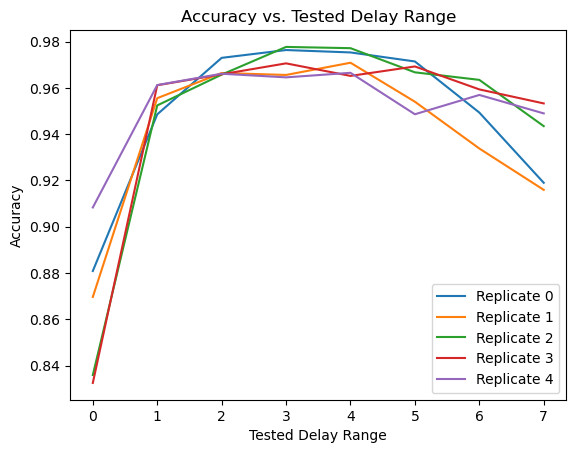

In [43]:
test_delay_ranges = range(8)

for replicate in range(num_replicates):
    # Load the trained model for the current delay range and replicate
    accuracies = []
    model_name = f"CDRfullModel_dr_replicate{replicate}.model"
    model = Net(hidden_dim=12, output_dim=6)
    model.load_state_dict(torch.load(model_name))
    #model.eval()

    # Loop over the test delay ranges and test the model
    for test_delay in test_delay_ranges:
        # Create a noisy dataset with the test delay
        nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.2, delayRange=[test_delay])
        # Test the model on the noisy dataset
        total = test(model, X=nX, Y=nY, S=nS)
        accuracy = total
        accuracies.append(accuracy)

    # Plot the accuracies against the test delay ranges
    plt.plot(test_delay_ranges, accuracies, label=f"Replicate {replicate}")

# Add axis labels and title to the plot
plt.xlabel("Tested Delay Range")
plt.ylabel("Accuracy")
plt.title(f"Accuracy vs. Tested Delay Range")

# Set y-axis limit to 0-1
#plt.ylim(0, 1)

# Show legend for replicate lines
plt.legend()
    
plt.savefig(f"Accuracy_vs_DelayRange.png", dpi=300, bbox_inches="tight")


# Show the plot for all replicates
plt.show()


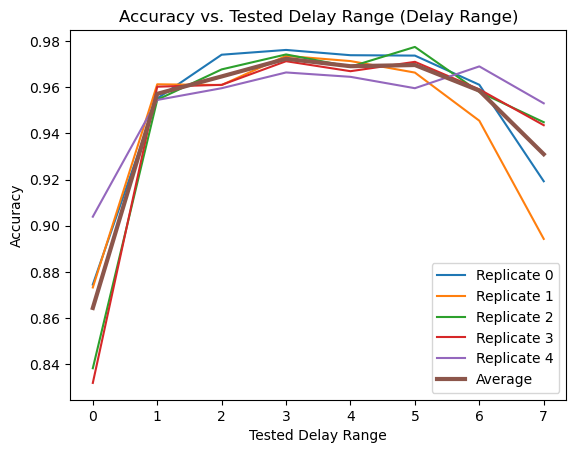

In [46]:
test_delay_ranges = range(8)

# Create a list to store the accuracies for each replicate
all_accuracies = []

for replicate in range(num_replicates):
    # Load the trained model for the current delay range and replicate
    accuracies = []
    model_name = f"CDRfullModel_dr_replicate{replicate}.model"
    model = Net(hidden_dim=12, output_dim=6)
    model.load_state_dict(torch.load(model_name))
    #model.eval()

    # Loop over the test delay ranges and test the model
    for test_delay in test_delay_ranges:
        # Create a noisy dataset with the test delay
        nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.2, delayRange=[test_delay])
        # Test the model on the noisy dataset
        total = test(model, X=nX, Y=nY, S=nS)
        accuracy = total
        accuracies.append(accuracy)

    # Add the accuracies for this replicate to the list
    all_accuracies.append(accuracies)

    # Plot the accuracies against the test delay ranges for this replicate
    plt.plot(test_delay_ranges, accuracies, label=f"Replicate {replicate}")

# Take the mean of the accuracies for all replicates to create the average plot
average_accuracies = np.mean(all_accuracies, axis=0)

# Plot the average accuracies against the test delay ranges
plt.plot(test_delay_ranges, average_accuracies, label="Average", linewidth=3)

# Add axis labels and title to the plot
plt.xlabel("Tested Delay Range")
plt.ylabel("Accuracy")
plt.title(f"Accuracy vs. Tested Delay Range (Delay Range)")

# Set y-axis limit to 0-1
#plt.ylim(0, 1)

# Show legend for all lines
plt.legend()

plt.savefig(f"AverageAccuracy_vs_TestDelay.png", dpi=300, bbox_inches='tight')

# Show the plot for all replicates and the average
plt.show()


In [68]:
def getOutTaH(model,dataSet):
    O,H=model.step(torch.Tensor(dataSet))
    H=H.transpose()
    O=O.transpose()
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5):
    output,H=getOutTaH(model,dataSet)
    output=output.transpose()[whichTS::8].transpose()
    H=H.transpose()[whichTS::8].transpose()
    target=target.transpose()[whichTS::8].transpose()
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number*2]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

for model in cdrmodels:
    #print(models[model])
    nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
    S,H=shrinkingDecompositionInformation(cdrmodels[model],12,nX,nW.transpose())
#nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
#S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose())

C:\Users\enajasa\AppData\Local\Temp\ipykernel_11016\1963444059.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=[1.2,0.3])


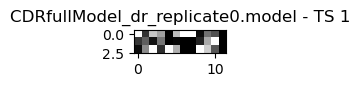

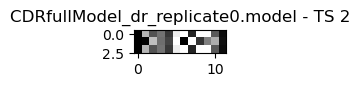

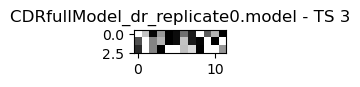

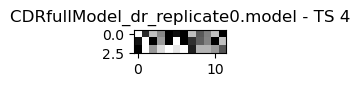

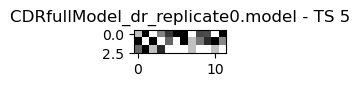

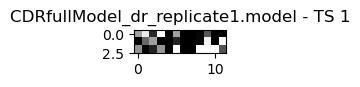

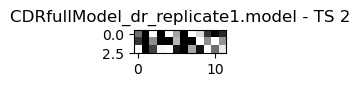

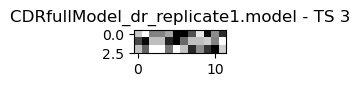

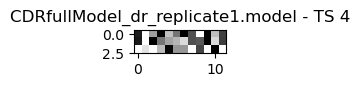

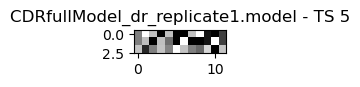

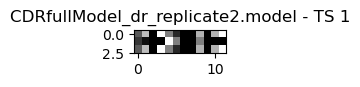

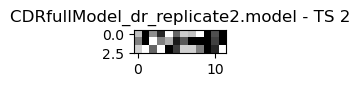

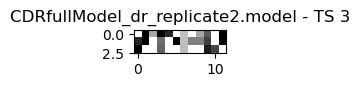

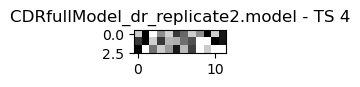

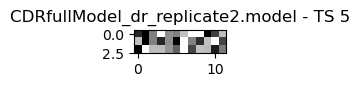

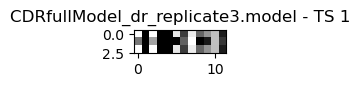

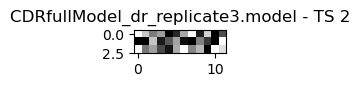

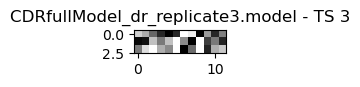

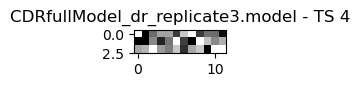

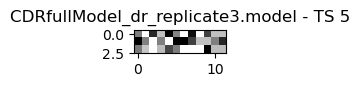

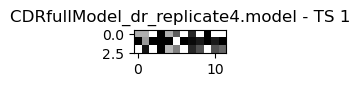

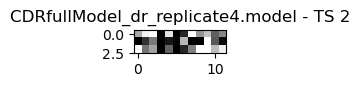

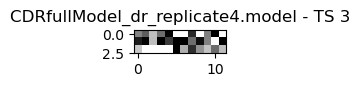

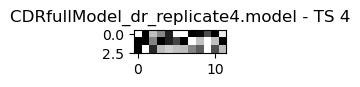

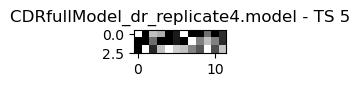

In [51]:
for key, model in cdrmodels.items():
    for ts in [1,2,3,4,5]:
        S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
        figure(figsize=[1.2,0.3])
        imshow(removalIntoMatrix(S,12,H),cmap='gray')
        title(f"{key} - TS {ts}")

C:\Users\enajasa\AppData\Local\Temp\ipykernel_11016\1796801668.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=[1.2,0.3])


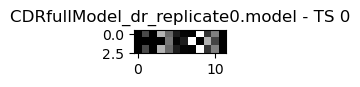

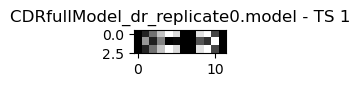

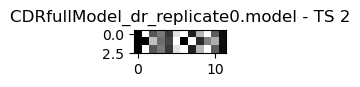

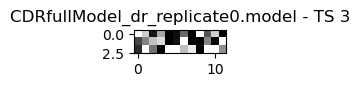

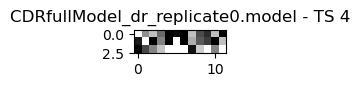

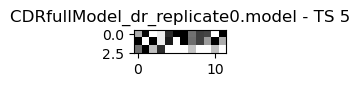

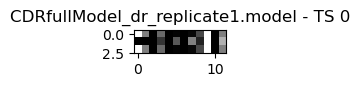

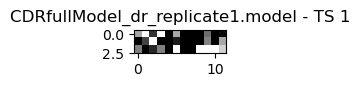

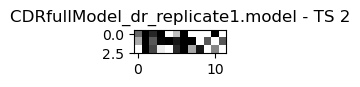

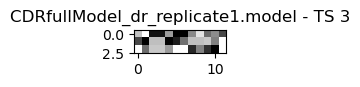

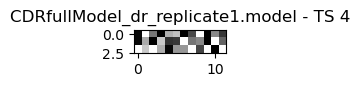

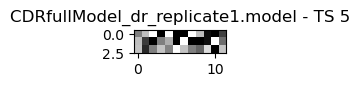

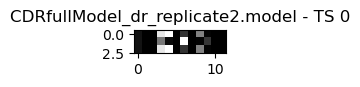

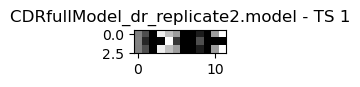

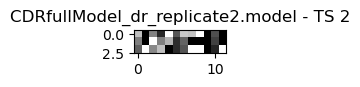

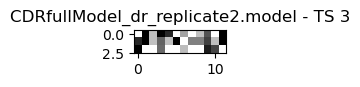

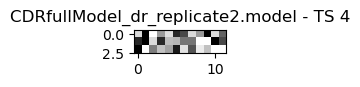

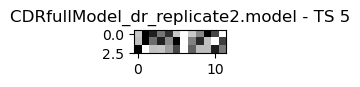

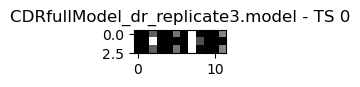

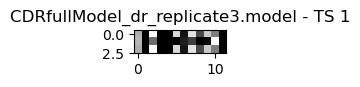

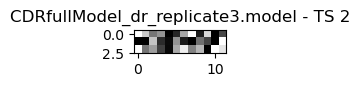

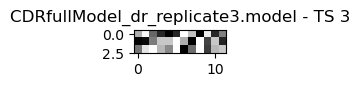

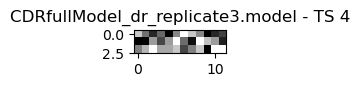

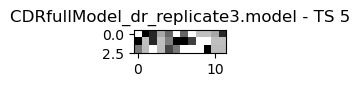

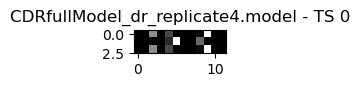

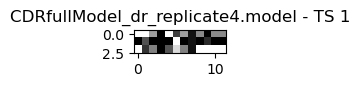

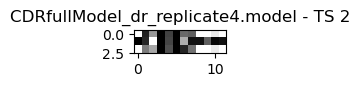

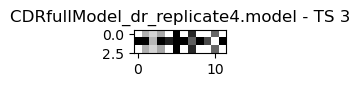

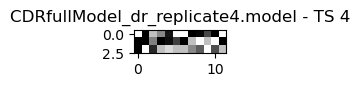

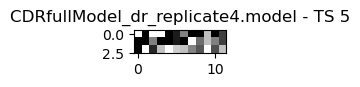

In [52]:
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
images=[]
for key, model in cdrmodels.items():
    for ts in [0,1,2,3,4,5]:
        S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
        figure(figsize=[1.2,0.3])
        I=removalIntoMatrix(S,12,H)
        imshow(I,cmap="gray")
        #title(str(ts))
        title(f"{key} - TS {ts}")
        images.append(I.flatten())

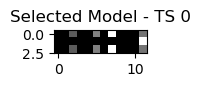

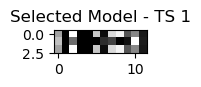

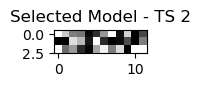

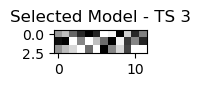

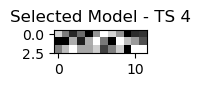

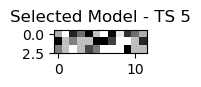

In [71]:
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
images=[]
model = cdrmodels['CDRfullModel_dr_replicate3.model']  # select one model
for ts in [0,1,2,3,4,5]:
    S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
    figure(figsize=[1.2,0.3])
    I=removalIntoMatrix(S,12,H)
    imshow(I,cmap="gray")
    title(f"Selected Model - TS {ts}")
    images.append(I.flatten())


In [70]:
import numpy as np
import matplotlib.pyplot as plt

n_replicates = 20
n_ts = 5
n_models = len(cdrmodels)
image_shape = (12, 8)

# Initialize a dictionary to store the correlation coefficients for the combined delay range
corr_coefs_CDR = []

all_corr_coefs_ID_CDR = []
for rep in range(n_replicates):
    images = []
    for ts in range(1, n_ts + 1):
        for key, model in cdrmodels.items():
            if f"replicate{rep}" in key:  # Select models within the current replicate
                S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
                I = removalIntoMatrix(S, 12, H)
                images.append(I)
                break  # Ensure only one model is used for each time step

    assert len(images) == n_ts, f"Unexpected number of images: {len(images)}"

    corr_coefs_ID_CDR = []
    for i in range(0, len(images) - 1):
        for j in range(i + 1, len(images)):
            corr_coef_ID = np.corrcoef(images[i].flatten(), images[j].flatten())[0, 1]
            corr_coefs_ID_CDR.append(abs(corr_coef_ID))
            print(f"Calculating correlation coefficient for images {i + 1} and {j + 1}: {corr_coef_ID}")

    mean_corr_coef_CDR = np.mean(corr_coefs_ID_CDR)
    all_corr_coefs_ID_CDR.append({'replicate': rep + 1, 'corr_coefs': corr_coefs_ID_CDR, 'mean_corr_coef': mean_corr_coef_CDR})

mean_corr_coefs_for_CDR = np.mean([res['mean_corr_coef'] for res in all_corr_coefs_ID_CDR])
corr_coefs_CDR = mean_corr_coefs_for_CDR

# Print mean correlation coefficients for the combined delay range
print(f"Combined Delay Range - Mean correlation coefficient: {corr_coefs_CDR}")


Calculating correlation coefficient for images 1 and 2: 0.15676517799853057
Calculating correlation coefficient for images 1 and 3: 0.2894071161578643
Calculating correlation coefficient for images 1 and 4: 0.004924814022646421
Calculating correlation coefficient for images 1 and 5: -0.05170732776667185
Calculating correlation coefficient for images 2 and 3: 0.09662604077616294
Calculating correlation coefficient for images 2 and 4: 0.12787095889852246
Calculating correlation coefficient for images 2 and 5: 0.0805436019512407
Calculating correlation coefficient for images 3 and 4: 0.6362777591276833
Calculating correlation coefficient for images 3 and 5: 0.6428313784571523
Calculating correlation coefficient for images 4 and 5: 0.9263453187112917
Calculating correlation coefficient for images 1 and 2: 0.3574074277450932
Calculating correlation coefficient for images 1 and 3: 0.22652735194213844
Calculating correlation coefficient for images 1 and 4: 0.19228138293443633
Calculating corr

Calculating correlation coefficient for images 1 and 2: 0.5463335188763587
Calculating correlation coefficient for images 1 and 3: -0.21418935087209653
Calculating correlation coefficient for images 1 and 4: 0.0847923000486116
Calculating correlation coefficient for images 1 and 5: -0.17455315466744106
Calculating correlation coefficient for images 2 and 3: 0.020499690484273695
Calculating correlation coefficient for images 2 and 4: 0.03240446622722873
Calculating correlation coefficient for images 2 and 5: 0.061709209624026574
Calculating correlation coefficient for images 3 and 4: 0.20874804575105144
Calculating correlation coefficient for images 3 and 5: 0.11621957897563996
Calculating correlation coefficient for images 4 and 5: -0.27722360973393306
Calculating correlation coefficient for images 1 and 2: 0.11922678476121565
Calculating correlation coefficient for images 1 and 3: 0.029510774900959637
Calculating correlation coefficient for images 1 and 4: -0.016827429640100196
Calcul

In [36]:
#8, 0.1

replicates = []
mean_corr_coefs = []

for d in all_corr_coefs:
    replicates.append(d['replicate'])
    mean_corr_coefs.append(d['mean_corr_coef'])

print(replicates)  # output: [1, 2, 3]
print(mean_corr_coefs)  # output: [0.98, 0.95, 0.97]

[1, 2, 3, 4, 5]
[0.33397497453199354, 0.3330479465063228, 0.32533133873137954, 0.32690544407428457, 0.3282328204036535]


In [33]:
#80, 0.1

replicates = []
mean_corr_coefs = []

for d in all_corr_coefs:
    replicates.append(d['replicate'])
    mean_corr_coefs.append(d['mean_corr_coef'])

print(replicates)  # output: [1, 2, 3]
print(mean_corr_coefs)  # output: [0.98, 0.95, 0.97]

[1, 2, 3, 4, 5]
[0.3182167998714032, 0.31622304466593354, 0.3149614723351403, 0.31184046538422816, 0.2968125667677085]


In [29]:
#200 , 0.1

replicates = []
mean_corr_coefs = []

for d in all_corr_coefs:
    replicates.append(d['replicate'])
    mean_corr_coefs.append(d['mean_corr_coef'])

print(replicates)  # output: [1, 2, 3]
print(mean_corr_coefs)  # output: [0.98, 0.95, 0.97]

[1, 2, 3, 4, 5]
[0.3678286985612404, 0.36708122605129667, 0.3634137380763994, 0.3676526533512212, 0.36718715151509135]


1 0.3244019463658008
2 0.10742650088079274
3 0.5085590570693287
4 0.7024548437186846
5 0.43416320276524534


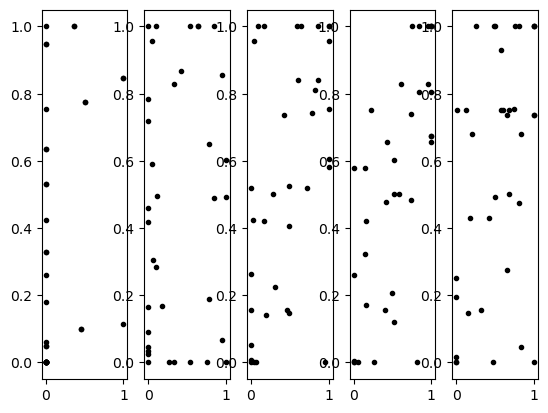

In [72]:
for i in range (1,len(images)):
    print(i,corrcoef(images[i-1],images[i])[0,1])
    subplot(1,5,i)
    plot(images[i-1],images[i],'.k')

1 0.22086885324714248
2 0.3908735969082666
3 0.4953210218563183
4 0.7495284961951206
5 0.9398685633835778
6 -0.016158357898419563
7 0.008005067344192365
8 0.36710195269455476
9 0.13336695312952915
10 0.3419018814423632
11 0.8436237410727476


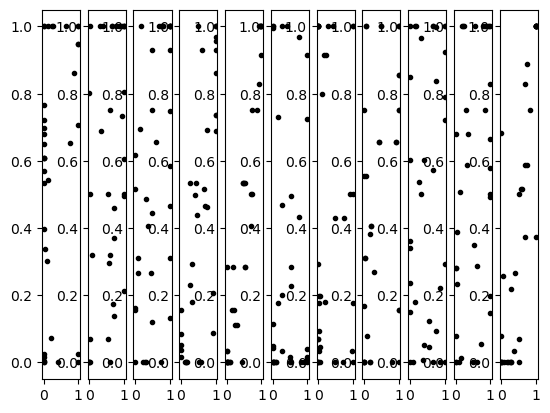

In [47]:
for i in range(1, len(images)):
    print(i, corrcoef(images[i-1], images[i])[0, 1])
    ax = subplot(1, 11, i)
    ax.plot(images[i-1], images[i], '.', color='k')


1 0.22086885324714248
2 0.3908735969082666
3 0.4953210218563183
4 0.7495284961951206
5 0.9398685633835778
6 -0.016158357898419563
7 0.008005067344192365
8 0.36710195269455476
9 0.13336695312952915
10 0.3419018814423632
11 0.8436237410727476


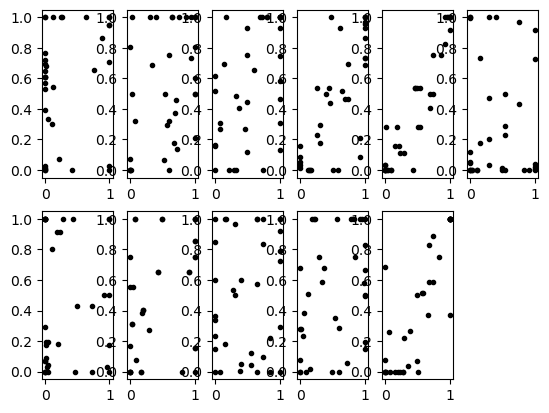

In [50]:
for i in range(1, len(images)):
    print(i, corrcoef(images[i-1], images[i])[0, 1])
    ax = subplot(2, 6, i)
    ax.plot(images[i-1], images[i], '.', color='k')
    #ax.set_xticks([])
    #ax.set_yticks([])


In [14]:
import matplotlib.pyplot as plt


num_replicates = 4
mdrmodels = {}

#for delayRange in delay_ranges:
#    print(f"Training for delay range {delayRange}...")
all_w = []

for replicate in range(num_replicates):
    model=Net(hidden_dim=12,output_dim=6)
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    error = nn.MSELoss()
    acc=0.0
    W=[]
    Ts=[]
    iteration_list = []
    loss_list = []
    accuracy_list = []

    while acc<0.97:
        divs=[]
        model.resetHidden()
        nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[1,3,5,7]) #variance for the ND is 0.2
        for i in range(nX.shape[0]): #use 64 when training for single delayRange
            optimizer.zero_grad()
            output = model(torch.Tensor(nX[i].reshape(1,nX[i].shape[0],4))) #shape greater than 8
            loss = error(output, torch.Tensor(nY[i]))
            loss.backward()
            optimizer.step()
            div=output.detach().numpy().reshape(nY[i].shape)-nY[i]
            divs.append(1.0-abs(div).mean())
            current_iteration = len(iteration_list) + 1
            loss_list.append(loss.item())
            iteration_list.append(current_iteration)
            accuracy_list.append(mean(divs))

        acc=mean(divs)
        W.append(acc)
        #total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
        total = test(model, X=nX, Y=nY, S=nS)
        #Ts.append(subA)
        print(f"Iteration: {current_iteration}, Loss: {loss.item()}, Accuracy: {accuracy_list[-1]}")

    model_name = f"MDRfullModel_dr_replicate{replicate}.model"
    torch.save(model.state_dict(), model_name)
    print(f"Saved {model_name}")
    mdrmodels[model_name] = model

    W_name = f"W_dr_replicate{replicate}.p"
    with open(W_name, "wb") as f:
        pickle.dump(W, f)
    print(f"Saved {W_name}")

    w=[]
    for tr in [0,1,2,3,4,5,6,7]:
        nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[tr])
        #total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
        total = test(model, X=nX, Y=nY, S=nS)
        print(tr,total)
        w.append(total)

    all_w.append(w)
    w_name = f"w_dr_replicate{replicate}.p"
    with open(w_name, "wb") as f:
        pickle.dump(w, f)
    print(f"Saved {w_name}")

    print(f"Replicate {replicate} completed")
    print(f"Time elapsed: {time.process_time()} seconds")


C:\Users\enajasa\AppData\Local\Temp\ipykernel_11016\1205567648.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nX=numpy.array(nX)


Iteration: 64, Loss: 0.24948211014270782, Accuracy: 0.499127013143152
Iteration: 128, Loss: 0.23954565823078156, Accuracy: 0.4990804395638406
Iteration: 192, Loss: 0.26083168387413025, Accuracy: 0.5004144795238972
Iteration: 256, Loss: 0.2258140593767166, Accuracy: 0.5011059669777751
Iteration: 320, Loss: 0.23087529838085175, Accuracy: 0.5010397396981716
Iteration: 384, Loss: 0.2322572022676468, Accuracy: 0.5005470081232488
Iteration: 448, Loss: 0.2570003271102905, Accuracy: 0.501877436414361
Iteration: 512, Loss: 0.24147158861160278, Accuracy: 0.5050969305448234
Iteration: 576, Loss: 0.26475659012794495, Accuracy: 0.5130880647338927
Iteration: 640, Loss: 0.2198401838541031, Accuracy: 0.5397308059036732
Iteration: 704, Loss: 0.1663840264081955, Accuracy: 0.5802895068190992
Iteration: 768, Loss: 0.19575001299381256, Accuracy: 0.6083791712298989
Iteration: 832, Loss: 0.166006937623024, Accuracy: 0.6200563842430711
Iteration: 896, Loss: 0.17906029522418976, Accuracy: 0.6276276255957782
It

Iteration: 7360, Loss: 0.09605464339256287, Accuracy: 0.7910315217450261
Iteration: 7424, Loss: 0.08983659744262695, Accuracy: 0.789175656856969
Iteration: 7488, Loss: 0.07992250472307205, Accuracy: 0.7922888721805066
Iteration: 7552, Loss: 0.0827256366610527, Accuracy: 0.7809143059421331
Iteration: 7616, Loss: 0.12896545231342316, Accuracy: 0.7903552851639688
Iteration: 7680, Loss: 0.07985567301511765, Accuracy: 0.8017958069685847
Iteration: 7744, Loss: 0.11691465973854065, Accuracy: 0.8012798728886992
Iteration: 7808, Loss: 0.08084586262702942, Accuracy: 0.7952255057170987
Iteration: 7872, Loss: 0.07724370807409286, Accuracy: 0.8037964061368257
Iteration: 7936, Loss: 0.07531999051570892, Accuracy: 0.8043554630130529
Iteration: 8000, Loss: 0.09078732877969742, Accuracy: 0.7999732722528279
Iteration: 8064, Loss: 0.0773443654179573, Accuracy: 0.8063115957193077
Iteration: 8128, Loss: 0.09641966223716736, Accuracy: 0.8061036376748234
Iteration: 8192, Loss: 0.07693394273519516, Accuracy: 

Iteration: 14592, Loss: 0.1198694109916687, Accuracy: 0.8448818747419864
Iteration: 14656, Loss: 0.06800616532564163, Accuracy: 0.8440109371440485
Iteration: 14720, Loss: 0.09760609269142151, Accuracy: 0.8458962313598022
Iteration: 14784, Loss: 0.05366737022995949, Accuracy: 0.8405383242061362
Iteration: 14848, Loss: 0.06765156984329224, Accuracy: 0.8343078035395592
Iteration: 14912, Loss: 0.08738409727811813, Accuracy: 0.8450211189920083
Iteration: 14976, Loss: 0.10985667258501053, Accuracy: 0.8442963140551001
Iteration: 15040, Loss: 0.05277494713664055, Accuracy: 0.8439652107190341
Iteration: 15104, Loss: 0.0641854926943779, Accuracy: 0.851502898032777
Iteration: 15168, Loss: 0.05554840341210365, Accuracy: 0.8491455352632329
Iteration: 15232, Loss: 0.09939312189817429, Accuracy: 0.8444697103695944
Iteration: 15296, Loss: 0.07485444098711014, Accuracy: 0.8525160974822938
Iteration: 15360, Loss: 0.10508372634649277, Accuracy: 0.8525961658451706
Iteration: 15424, Loss: 0.097707748413085

Iteration: 21632, Loss: 0.0014962427085265517, Accuracy: 0.9695505390554899
Iteration: 21696, Loss: 0.0014199549332261086, Accuracy: 0.9714959578996059
Saved MDRfullModel_dr_replicate0.model
Saved W_dr_replicate0.p
0 0.6103533734567463
1 0.9554309045197442
2 0.6459900988265872
3 0.9762553691398352
4 0.6554065176751465
5 0.975438057386782
6 0.6526149897836149
7 0.9767309495364316
Saved w_dr_replicate0.p
Replicate 0 completed
Time elapsed: 132.171875 seconds
Iteration: 64, Loss: 0.24755507707595825, Accuracy: 0.49932805728167295
Iteration: 128, Loss: 0.25948306918144226, Accuracy: 0.5000919187441468
Iteration: 192, Loss: 0.2362767606973648, Accuracy: 0.5004877080209553
Iteration: 256, Loss: 0.25467854738235474, Accuracy: 0.5000314726494253
Iteration: 320, Loss: 0.24503688514232635, Accuracy: 0.5043526752851903
Iteration: 384, Loss: 0.20724152028560638, Accuracy: 0.5266550644300878
Iteration: 448, Loss: 0.20331759750843048, Accuracy: 0.5800742264837027
Iteration: 512, Loss: 0.164615049958

Iteration: 6912, Loss: 0.08203490078449249, Accuracy: 0.753819617908448
Iteration: 6976, Loss: 0.05403373762965202, Accuracy: 0.7555523018818349
Iteration: 7040, Loss: 0.10409635305404663, Accuracy: 0.7590420613996685
Iteration: 7104, Loss: 0.105500727891922, Accuracy: 0.7562526462133974
Iteration: 7168, Loss: 0.061754003167152405, Accuracy: 0.7572903106920421
Iteration: 7232, Loss: 0.054836198687553406, Accuracy: 0.7652080762200058
Iteration: 7296, Loss: 0.15489961206912994, Accuracy: 0.766909007448703
Iteration: 7360, Loss: 0.05323168262839317, Accuracy: 0.7657148754224181
Iteration: 7424, Loss: 0.0394473634660244, Accuracy: 0.7647793311625719
Iteration: 7488, Loss: 0.07326029241085052, Accuracy: 0.7695281612686813
Iteration: 7552, Loss: 0.15912514925003052, Accuracy: 0.7699826548341662
Iteration: 7616, Loss: 0.08621533960103989, Accuracy: 0.7754666998516768
Iteration: 7680, Loss: 0.07715187221765518, Accuracy: 0.7714142522308975
Iteration: 7744, Loss: 0.07899745553731918, Accuracy: 

Iteration: 14144, Loss: 0.05784988775849342, Accuracy: 0.8486051888903603
Iteration: 14208, Loss: 0.011674505658447742, Accuracy: 0.8507119328132831
Iteration: 14272, Loss: 0.022765884175896645, Accuracy: 0.8462839440908283
Iteration: 14336, Loss: 0.0654502883553505, Accuracy: 0.8560304172569886
Iteration: 14400, Loss: 0.025917112827301025, Accuracy: 0.8536255454528145
Iteration: 14464, Loss: 0.057692546397447586, Accuracy: 0.8458396226051264
Iteration: 14528, Loss: 0.03220212832093239, Accuracy: 0.8539483710192144
Iteration: 14592, Loss: 0.050085168331861496, Accuracy: 0.8567768486100249
Iteration: 14656, Loss: 0.020683692768216133, Accuracy: 0.8556656952714548
Iteration: 14720, Loss: 0.008518578484654427, Accuracy: 0.8590231204871088
Iteration: 14784, Loss: 0.024168282747268677, Accuracy: 0.8555440861964598
Iteration: 14848, Loss: 0.013086085207760334, Accuracy: 0.8599557317793369
Iteration: 14912, Loss: 0.06545105576515198, Accuracy: 0.8597646433045156
Iteration: 14976, Loss: 0.0586

Iteration: 21184, Loss: 0.10223271697759628, Accuracy: 0.9117588524677558
Iteration: 21248, Loss: 0.004533923231065273, Accuracy: 0.9154942639288493
Iteration: 21312, Loss: 0.01382273156195879, Accuracy: 0.9150610133219743
Iteration: 21376, Loss: 0.01106711570173502, Accuracy: 0.9143169097515056
Iteration: 21440, Loss: 0.019319429993629456, Accuracy: 0.9123354191106046
Iteration: 21504, Loss: 0.12066379934549332, Accuracy: 0.916193308585207
Iteration: 21568, Loss: 0.004959344398230314, Accuracy: 0.9122271353553515
Iteration: 21632, Loss: 0.0010543381795287132, Accuracy: 0.9178785826734384
Iteration: 21696, Loss: 0.005929571110755205, Accuracy: 0.9201330882933689
Iteration: 21760, Loss: 0.0009546854416839778, Accuracy: 0.9132141922891606
Iteration: 21824, Loss: 0.009171449579298496, Accuracy: 0.9211006010882556
Iteration: 21888, Loss: 0.0037326838355511427, Accuracy: 0.9219787005422404
Iteration: 21952, Loss: 0.0023913185577839613, Accuracy: 0.9183339423543657
Iteration: 22016, Loss: 0.

6 0.7663767594494857
7 0.9404408709488052
Saved w_dr_replicate1.p
Replicate 1 completed
Time elapsed: 199.9375 seconds
Iteration: 64, Loss: 0.25195392966270447, Accuracy: 0.5034679262898862
Iteration: 128, Loss: 0.25473329424858093, Accuracy: 0.5030576637946069
Iteration: 192, Loss: 0.22394557297229767, Accuracy: 0.5059378044679761
Iteration: 256, Loss: 0.24664603173732758, Accuracy: 0.5306109902448952
Iteration: 320, Loss: 0.14767144620418549, Accuracy: 0.5835504694841802
Iteration: 384, Loss: 0.20977263152599335, Accuracy: 0.6071638893336058
Iteration: 448, Loss: 0.20097409188747406, Accuracy: 0.6203365274704993
Iteration: 512, Loss: 0.19407467544078827, Accuracy: 0.6278708907775581
Iteration: 576, Loss: 0.18908055126667023, Accuracy: 0.6346385888755322
Iteration: 640, Loss: 0.1854735165834427, Accuracy: 0.6379514345899224
Iteration: 704, Loss: 0.18369941413402557, Accuracy: 0.6416923836804926
Iteration: 768, Loss: 0.17565590143203735, Accuracy: 0.6389590832404792
Iteration: 832, Los

Iteration: 7296, Loss: 0.1342504918575287, Accuracy: 0.688987590605393
Iteration: 7360, Loss: 0.13805367052555084, Accuracy: 0.6886511268094182
Iteration: 7424, Loss: 0.14223141968250275, Accuracy: 0.6923440177924931
Iteration: 7488, Loss: 0.13947419822216034, Accuracy: 0.6867347767110914
Iteration: 7552, Loss: 0.2088547945022583, Accuracy: 0.6849549734033644
Iteration: 7616, Loss: 0.0730118378996849, Accuracy: 0.6762009160593152
Iteration: 7680, Loss: 0.19348770380020142, Accuracy: 0.6816148736979812
Iteration: 7744, Loss: 0.11075512319803238, Accuracy: 0.6903570564463735
Iteration: 7808, Loss: 0.10449621081352234, Accuracy: 0.695424125995487
Iteration: 7872, Loss: 0.14213822782039642, Accuracy: 0.6975364226382226
Iteration: 7936, Loss: 0.20263998210430145, Accuracy: 0.691314950119704
Iteration: 8000, Loss: 0.2015981674194336, Accuracy: 0.7008215708192438
Iteration: 8064, Loss: 0.18833565711975098, Accuracy: 0.6914418151136488
Iteration: 8128, Loss: 0.13937418162822723, Accuracy: 0.69

Iteration: 14528, Loss: 0.10866466909646988, Accuracy: 0.7235676555428654
Iteration: 14592, Loss: 0.10643463581800461, Accuracy: 0.7176662422716618
Iteration: 14656, Loss: 0.12068406492471695, Accuracy: 0.7554998660925776
Iteration: 14720, Loss: 0.08430521935224533, Accuracy: 0.7438667574897408
Iteration: 14784, Loss: 0.09090586751699448, Accuracy: 0.7421895009465516
Iteration: 14848, Loss: 0.08080383390188217, Accuracy: 0.75207897904329
Iteration: 14912, Loss: 0.07572005689144135, Accuracy: 0.7501581585966051
Iteration: 14976, Loss: 0.09083447605371475, Accuracy: 0.7450585076585412
Iteration: 15040, Loss: 0.10752839595079422, Accuracy: 0.7397683132439852
Iteration: 15104, Loss: 0.2938797175884247, Accuracy: 0.7470897070597857
Iteration: 15168, Loss: 0.07238148897886276, Accuracy: 0.7563174732495099
Iteration: 15232, Loss: 0.11816635727882385, Accuracy: 0.7448519377503544
Iteration: 15296, Loss: 0.2669427692890167, Accuracy: 0.7327935809735209
Iteration: 15360, Loss: 0.1102088466286659

Iteration: 21760, Loss: 0.08079324662685394, Accuracy: 0.7693172520957887
Iteration: 21824, Loss: 0.10059109330177307, Accuracy: 0.7762658859137446
Iteration: 21888, Loss: 0.13468074798583984, Accuracy: 0.7884298439603299
Iteration: 21952, Loss: 0.08765042573213577, Accuracy: 0.772551269736141
Iteration: 22016, Loss: 0.34615039825439453, Accuracy: 0.7587685626931489
Iteration: 22080, Loss: 0.08679724484682083, Accuracy: 0.7768554331269115
Iteration: 22144, Loss: 0.0933038666844368, Accuracy: 0.7649054257199168
Iteration: 22208, Loss: 0.08162528276443481, Accuracy: 0.7882137827109545
Iteration: 22272, Loss: 0.10279524326324463, Accuracy: 0.787489648675546
Iteration: 22336, Loss: 0.07555421441793442, Accuracy: 0.7817770165856928
Iteration: 22400, Loss: 0.10718736052513123, Accuracy: 0.7856730429921299
Iteration: 22464, Loss: 0.08207166194915771, Accuracy: 0.7871967407409102
Iteration: 22528, Loss: 0.0835106298327446, Accuracy: 0.7829809091053903
Iteration: 22592, Loss: 0.0798127725720405

Iteration: 28992, Loss: 0.08612997084856033, Accuracy: 0.7796078491955996
Iteration: 29056, Loss: 0.09314081072807312, Accuracy: 0.8030474064871669
Iteration: 29120, Loss: 0.09015077352523804, Accuracy: 0.8029820325318724
Iteration: 29184, Loss: 0.09000743180513382, Accuracy: 0.7997082413639873
Iteration: 29248, Loss: 0.09470448642969131, Accuracy: 0.7991156596690416
Iteration: 29312, Loss: 0.08045704662799835, Accuracy: 0.7899202748667449
Iteration: 29376, Loss: 0.09044142812490463, Accuracy: 0.7874906454235315
Iteration: 29440, Loss: 0.09853307157754898, Accuracy: 0.7883014879189432
Iteration: 29504, Loss: 0.09121468663215637, Accuracy: 0.7947274988982826
Iteration: 29568, Loss: 0.0772799625992775, Accuracy: 0.798480836674571
Iteration: 29632, Loss: 0.09347618371248245, Accuracy: 0.7847591913305223
Iteration: 29696, Loss: 0.0799349844455719, Accuracy: 0.7997623186092824
Iteration: 29760, Loss: 0.09076955169439316, Accuracy: 0.8017199297901243
Iteration: 29824, Loss: 0.092779986560344

Iteration: 36160, Loss: 0.08249691873788834, Accuracy: 0.8063564754556865
Iteration: 36224, Loss: 0.0864989161491394, Accuracy: 0.8038406274281442
Iteration: 36288, Loss: 0.08303416520357132, Accuracy: 0.8090190168004483
Iteration: 36352, Loss: 0.08419925719499588, Accuracy: 0.805758518865332
Iteration: 36416, Loss: 0.08517319709062576, Accuracy: 0.8059325627982616
Iteration: 36480, Loss: 0.2679489850997925, Accuracy: 0.8028563263360411
Iteration: 36544, Loss: 0.08300013840198517, Accuracy: 0.8073876907583326
Iteration: 36608, Loss: 0.08435847610235214, Accuracy: 0.8054246341343969
Iteration: 36672, Loss: 0.08521997183561325, Accuracy: 0.8033314817585051
Iteration: 36736, Loss: 0.0870843231678009, Accuracy: 0.8027637319173664
Iteration: 36800, Loss: 0.08413410931825638, Accuracy: 0.7941892684902996
Iteration: 36864, Loss: 0.08739835768938065, Accuracy: 0.780154736712575
Iteration: 36928, Loss: 0.08562908321619034, Accuracy: 0.798299317015335
Iteration: 36992, Loss: 0.08975597470998764,

Iteration: 43328, Loss: 0.08411845564842224, Accuracy: 0.8046109206043184
Iteration: 43392, Loss: 0.08042413741350174, Accuracy: 0.8099672240205109
Iteration: 43456, Loss: 0.09148366004228592, Accuracy: 0.8098474652506411
Iteration: 43520, Loss: 0.2949427664279938, Accuracy: 0.8038883099798113
Iteration: 43584, Loss: 0.1752041131258011, Accuracy: 0.8005839767865837
Iteration: 43648, Loss: 0.08812227100133896, Accuracy: 0.8112514882814139
Iteration: 43712, Loss: 0.08371911197900772, Accuracy: 0.8090119541157037
Iteration: 43776, Loss: 0.08058110624551773, Accuracy: 0.8137818221002817
Iteration: 43840, Loss: 0.08331221342086792, Accuracy: 0.808465565321967
Iteration: 43904, Loss: 0.08156827837228775, Accuracy: 0.8013331955298781
Iteration: 43968, Loss: 0.09215890616178513, Accuracy: 0.8111266051419079
Iteration: 44032, Loss: 0.09093708544969559, Accuracy: 0.8130188877694309
Iteration: 44096, Loss: 0.08111453056335449, Accuracy: 0.8204396145883948
Iteration: 44160, Loss: 0.083387129008769

Iteration: 50560, Loss: 0.08591610938310623, Accuracy: 0.7857683452311903
Iteration: 50624, Loss: 0.08549719303846359, Accuracy: 0.814972574589774
Iteration: 50688, Loss: 0.0860641673207283, Accuracy: 0.8206998007372022
Iteration: 50752, Loss: 0.08607206493616104, Accuracy: 0.8190343349706382
Iteration: 50816, Loss: 0.07492225617170334, Accuracy: 0.8218119444791228
Iteration: 50880, Loss: 0.08752266317605972, Accuracy: 0.8207272929139435
Iteration: 50944, Loss: 0.08653775602579117, Accuracy: 0.8220937536098063
Iteration: 51008, Loss: 0.08713721483945847, Accuracy: 0.818513106321916
Iteration: 51072, Loss: 0.08061530441045761, Accuracy: 0.8063987146597356
Iteration: 51136, Loss: 0.07637716084718704, Accuracy: 0.7985326102934778
Iteration: 51200, Loss: 0.07819049060344696, Accuracy: 0.8103315359912813
Iteration: 51264, Loss: 0.07824958860874176, Accuracy: 0.8197686451021582
Iteration: 51328, Loss: 0.08753965049982071, Accuracy: 0.8201827062293887
Iteration: 51392, Loss: 0.092044584453105

Iteration: 57728, Loss: 0.10241946578025818, Accuracy: 0.8111053900793195
Iteration: 57792, Loss: 0.021794818341732025, Accuracy: 0.8393862658413127
Iteration: 57856, Loss: 0.013951074331998825, Accuracy: 0.8325782535830513
Iteration: 57920, Loss: 0.06918541342020035, Accuracy: 0.8254714346840046
Iteration: 57984, Loss: 0.05289780721068382, Accuracy: 0.8292113627539948
Iteration: 58048, Loss: 0.08031822741031647, Accuracy: 0.8432796525303274
Iteration: 58112, Loss: 0.07170317322015762, Accuracy: 0.8287487354828045
Iteration: 58176, Loss: 0.020049704238772392, Accuracy: 0.8355028726509772
Iteration: 58240, Loss: 0.08723030239343643, Accuracy: 0.8357238807948306
Iteration: 58304, Loss: 0.07045425474643707, Accuracy: 0.8392858534352854
Iteration: 58368, Loss: 0.0580110065639019, Accuracy: 0.8423752812668681
Iteration: 58432, Loss: 0.0985722541809082, Accuracy: 0.841897364705801
Iteration: 58496, Loss: 0.09278357774019241, Accuracy: 0.8443078640848398
Iteration: 58560, Loss: 0.080092638731

Iteration: 64896, Loss: 0.016069186851382256, Accuracy: 0.9251177828991786
Iteration: 64960, Loss: 0.016354883089661598, Accuracy: 0.9184064992296044
Iteration: 65024, Loss: 0.0005768600385636091, Accuracy: 0.9222911349934293
Iteration: 65088, Loss: 0.012843061238527298, Accuracy: 0.9395665026531788
Iteration: 65152, Loss: 0.01607612706720829, Accuracy: 0.931553297341452
Iteration: 65216, Loss: 0.007381143514066935, Accuracy: 0.9383980982238427
Iteration: 65280, Loss: 0.0008363372180610895, Accuracy: 0.9373436097375816
Iteration: 65344, Loss: 0.021777011454105377, Accuracy: 0.9377659235324245
Iteration: 65408, Loss: 0.009342784993350506, Accuracy: 0.9358991723856889
Iteration: 65472, Loss: 0.005159873049706221, Accuracy: 0.9398151507921284
Iteration: 65536, Loss: 0.05030034855008125, Accuracy: 0.932868307150784
Iteration: 65600, Loss: 0.003171575488522649, Accuracy: 0.9478278118622256
Iteration: 65664, Loss: 0.004389596171677113, Accuracy: 0.93090671482787
Iteration: 65728, Loss: 0.021

Iteration: 1664, Loss: 0.1722915917634964, Accuracy: 0.6507946932688355
Iteration: 1728, Loss: 0.16410580277442932, Accuracy: 0.6514933235011995
Iteration: 1792, Loss: 0.16482755541801453, Accuracy: 0.6520154844038188
Iteration: 1856, Loss: 0.16896550357341766, Accuracy: 0.6528276847675443
Iteration: 1920, Loss: 0.16917955875396729, Accuracy: 0.6525368308648467
Iteration: 1984, Loss: 0.17389750480651855, Accuracy: 0.6537330509163439
Iteration: 2048, Loss: 0.16392135620117188, Accuracy: 0.6539474255405366
Iteration: 2112, Loss: 0.167446568608284, Accuracy: 0.6534416386857629
Iteration: 2176, Loss: 0.16616182029247284, Accuracy: 0.6552217965945601
Iteration: 2240, Loss: 0.17020349204540253, Accuracy: 0.6549809612333775
Iteration: 2304, Loss: 0.16434027254581451, Accuracy: 0.6559398034587502
Iteration: 2368, Loss: 0.16401223838329315, Accuracy: 0.6559657179750502
Iteration: 2432, Loss: 0.16484390199184418, Accuracy: 0.6561700366437435
Iteration: 2496, Loss: 0.165812149643898, Accuracy: 0.

Iteration: 8896, Loss: 0.13755644857883453, Accuracy: 0.709869786631316
Iteration: 8960, Loss: 0.1058821752667427, Accuracy: 0.7057414737064391
Iteration: 9024, Loss: 0.16445836424827576, Accuracy: 0.7159093925729394
Iteration: 9088, Loss: 0.16512715816497803, Accuracy: 0.712513092905283
Iteration: 9152, Loss: 0.16677594184875488, Accuracy: 0.7093331923242658
Iteration: 9216, Loss: 0.18230049312114716, Accuracy: 0.7131765550002456
Iteration: 9280, Loss: 0.16401205956935883, Accuracy: 0.7155667005572468
Iteration: 9344, Loss: 0.09611397236585617, Accuracy: 0.711679513566196
Iteration: 9408, Loss: 0.08469974994659424, Accuracy: 0.7029049838893116
Iteration: 9472, Loss: 0.1664770096540451, Accuracy: 0.7160861389711499
Iteration: 9536, Loss: 0.10251063108444214, Accuracy: 0.7195636560209095
Iteration: 9600, Loss: 0.12312636524438858, Accuracy: 0.7135262528900057
Iteration: 9664, Loss: 0.12983942031860352, Accuracy: 0.7277374693658203
Iteration: 9728, Loss: 0.10321074724197388, Accuracy: 0.

Iteration: 16064, Loss: 0.00948090199381113, Accuracy: 0.8525739018805325
Iteration: 16128, Loss: 0.1006903424859047, Accuracy: 0.8374927901895717
Iteration: 16192, Loss: 0.10254060477018356, Accuracy: 0.8541681687347591
Iteration: 16256, Loss: 0.008057860657572746, Accuracy: 0.8350200720597059
Iteration: 16320, Loss: 0.10176032036542892, Accuracy: 0.852881642174907
Iteration: 16384, Loss: 0.06938643008470535, Accuracy: 0.8512237905524671
Iteration: 16448, Loss: 0.02292245626449585, Accuracy: 0.8635290686506778
Iteration: 16512, Loss: 0.1137411966919899, Accuracy: 0.8670066043268889
Iteration: 16576, Loss: 0.010532032698392868, Accuracy: 0.8510040594846942
Iteration: 16640, Loss: 0.01617874950170517, Accuracy: 0.8458533434895799
Iteration: 16704, Loss: 0.10995036363601685, Accuracy: 0.851998501282651
Iteration: 16768, Loss: 0.171524778008461, Accuracy: 0.8553821994573809
Iteration: 16832, Loss: 0.10582398623228073, Accuracy: 0.8513845313573256
Iteration: 16896, Loss: 0.0335618518292903

Iteration: 23104, Loss: 0.0047828094102442265, Accuracy: 0.9484130493365228
Iteration: 23168, Loss: 0.0012880812864750624, Accuracy: 0.9506458490504883
Iteration: 23232, Loss: 0.0041870675049722195, Accuracy: 0.9468979765661061
Iteration: 23296, Loss: 0.022061826661229134, Accuracy: 0.947312910517212
Iteration: 23360, Loss: 0.001276573515497148, Accuracy: 0.9498455853317864
Iteration: 23424, Loss: 0.00911769550293684, Accuracy: 0.9559104906802531
Iteration: 23488, Loss: 0.0019037224119529128, Accuracy: 0.9609908589336555
Iteration: 23552, Loss: 0.0008805743418633938, Accuracy: 0.961295643588528
Iteration: 23616, Loss: 0.007576847914606333, Accuracy: 0.9657446664350573
Iteration: 23680, Loss: 0.0016006715595722198, Accuracy: 0.934320483909687
Iteration: 23744, Loss: 0.002553475322201848, Accuracy: 0.9572356276621576
Iteration: 23808, Loss: 0.0009427845943719149, Accuracy: 0.9586731081362814
Iteration: 23872, Loss: 0.002521609654650092, Accuracy: 0.9621793261030689
Iteration: 23936, Loss

In [73]:
mdrmodels

{'MDRfullModel_dr_replicate0.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'MDRfullModel_dr_replicate1.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'MDRfullModel_dr_replicate2.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'MDRfullModel_dr_replicate3.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 )}

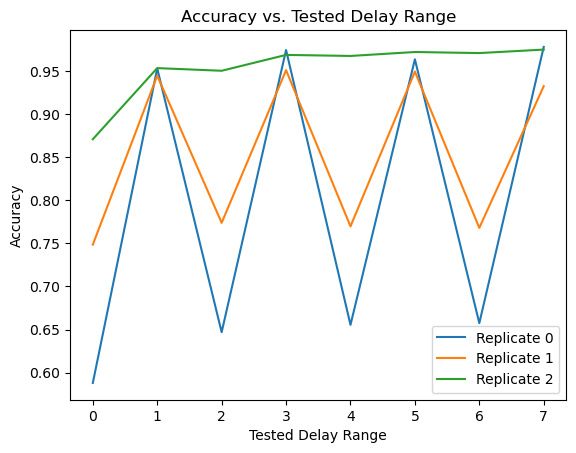

In [77]:
test_delay_ranges = range(8)
num_replicates=3

for replicate in range(num_replicates):
    # Load the trained model for the current delay range and replicate
    accuracies = []
    model_name = f"MDRfullModel_dr_replicate{replicate}.model"
    model = Net(hidden_dim=12, output_dim=6)
    model.load_state_dict(torch.load(model_name))
    #model.eval()

    # Loop over the test delay ranges and test the model
    for test_delay in test_delay_ranges:
        # Create a noisy dataset with the test delay
        nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.2, delayRange=[test_delay])
        # Test the model on the noisy dataset
        total = test(model, X=nX, Y=nY, S=nS)
        accuracy = total
        accuracies.append(accuracy)

    # Plot the accuracies against the test delay ranges
    plt.plot(test_delay_ranges, accuracies, label=f"Replicate {replicate}")

# Add axis labels and title to the plot
plt.xlabel("Tested Delay Range")
plt.ylabel("Accuracy")
plt.title(f"Accuracy vs. Tested Delay Range")

# Set y-axis limit to 0-1
#plt.ylim(0, 1)

# Show legend for replicate lines
plt.legend()

plt.savefig(f"MDR.png", dpi=300, bbox_inches='tight')

# Show the plot for all replicates
plt.show()


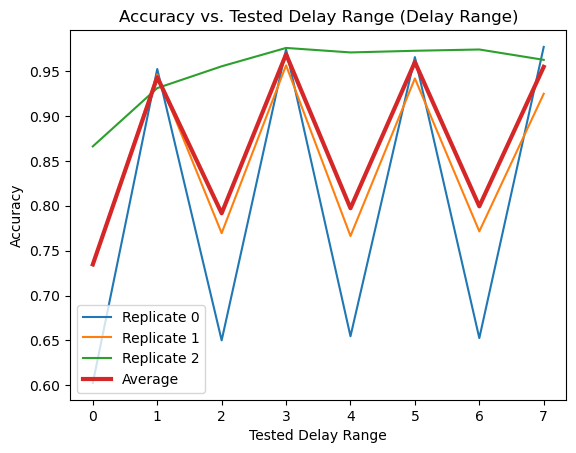

In [78]:
test_delay_ranges = range(8)

# Create a list to store the accuracies for each replicate
all_accuracies = []

for replicate in range(num_replicates):
    # Load the trained model for the current delay range and replicate
    accuracies = []
    model_name = f"MDRfullModel_dr_replicate{replicate}.model"
    model = Net(hidden_dim=12, output_dim=6)
    model.load_state_dict(torch.load(model_name))
    #model.eval()

    # Loop over the test delay ranges and test the model
    for test_delay in test_delay_ranges:
        # Create a noisy dataset with the test delay
        nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.2, delayRange=[test_delay])
        # Test the model on the noisy dataset
        total = test(model, X=nX, Y=nY, S=nS)
        accuracy = total
        accuracies.append(accuracy)

    # Add the accuracies for this replicate to the list
    all_accuracies.append(accuracies)

    # Plot the accuracies against the test delay ranges for this replicate
    plt.plot(test_delay_ranges, accuracies, label=f"Replicate {replicate}")

# Take the mean of the accuracies for all replicates to create the average plot
average_accuracies = np.mean(all_accuracies, axis=0)

# Plot the average accuracies against the test delay ranges
plt.plot(test_delay_ranges, average_accuracies, label="Average", linewidth=3)

# Add axis labels and title to the plot
plt.xlabel("Tested Delay Range")
plt.ylabel("Accuracy")
plt.title(f"Accuracy vs. Tested Delay Range (Delay Range)")

# Set y-axis limit to 0-1
#plt.ylim(0, 1)

# Show legend for all lines
plt.legend()

plt.savefig(f"MDR.png", dpi=300, bbox_inches='tight')

# Show the plot for all replicates and the average
plt.show()


In [71]:
def getOutTaH(model,dataSet):
    O,H=model.step(torch.Tensor(dataSet))
    H=H.transpose()
    O=O.transpose()
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5):
    output,H=getOutTaH(model,dataSet)
    output=output.transpose()[whichTS::8].transpose()
    H=H.transpose()[whichTS::8].transpose()
    target=target.transpose()[whichTS::8].transpose()
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number*2]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

for model in mdrmodels:
    #print(models[model])
    nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1) #move 8 upto 80 (57), playaround with 0.1
    
    S,H=shrinkingDecompositionInformation(mdrmodels[model],12,nX,nW.transpose())
#nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
#S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose())

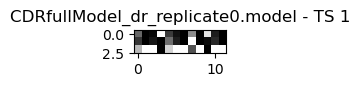

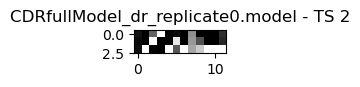

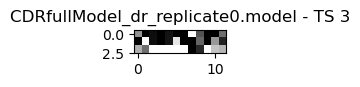

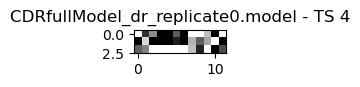

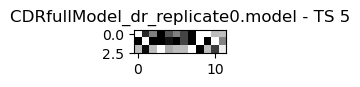

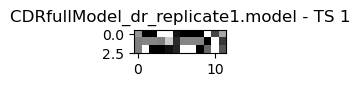

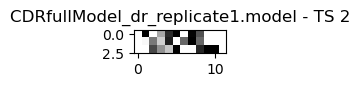

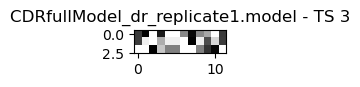

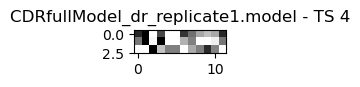

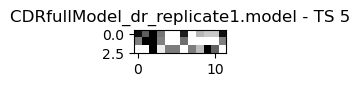

In [72]:
for key, model in mdrmodels.items():
    for ts in [1,2,3,4,5]:
        S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
        figure(figsize=[1.2,0.3])
        imshow(removalIntoMatrix(S,12,H),cmap='gray')
        title(f"{key} - TS {ts}")

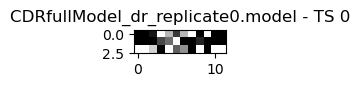

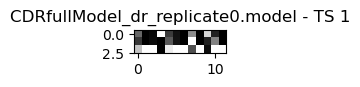

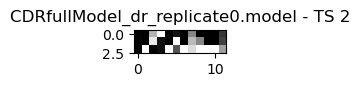

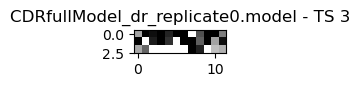

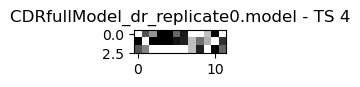

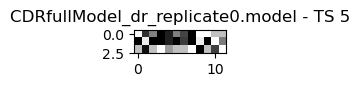

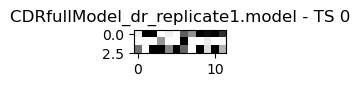

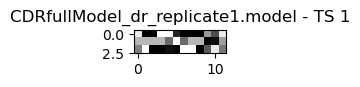

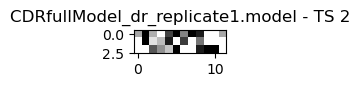

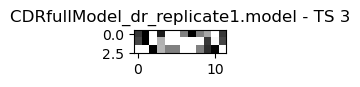

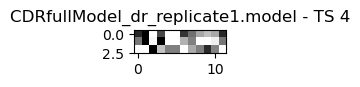

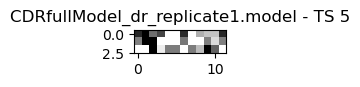

In [73]:
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
images=[]
for key, model in mdrmodels.items():
    for ts in [0,1,2,3,4,5]:
        S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
        figure(figsize=[1.2,0.3])
        I=removalIntoMatrix(S,12,H)
        imshow(I,cmap="gray")
        #title(str(ts))
        title(f"{key} - TS {ts}")
        images.append(I.flatten())

1 0.6759424435399494
2 0.4284633203567386
3 0.2308661786306824
4 0.585461369468165
5 0.6198914721119048
6 -0.20845040352834218
7 0.47323713286250885
8 0.381882078601342
9 0.382833479263889
10 0.76784750961258
11 0.6446568999331467


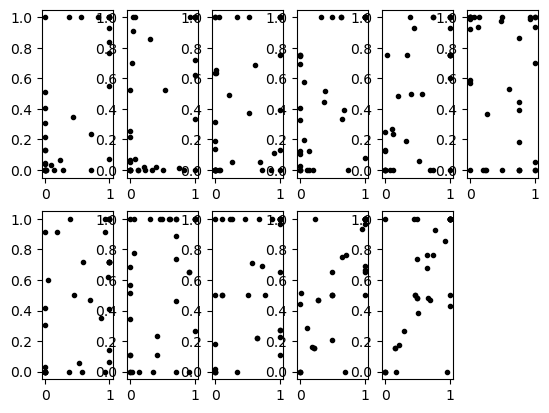

In [74]:
for i in range(1, len(images)):
    print(i, corrcoef(images[i-1], images[i])[0, 1])
    ax = subplot(2, 6, i)
    ax.plot(images[i-1], images[i], '.', color='k')
    #ax.set_xticks([])
    #ax.set_yticks([])


In [31]:
for dr in [1,2,3,4,5]:
    for replicate in range(5):
        #image[dr][replicate]
        print("dr:",dr,"rep:",replicate)
        #for img in range(5):
            #print("img",img)
        for i in range(5):
            for j in range(i+1,5):
                print("compare:",i+1,j+1)
                pool.append(numpy.random.random())
    print(pool)
    print("mean dist for dr",dr,mean(pool))

dr: 1 rep: 0
compare: 1 2
compare: 1 3
compare: 1 4
compare: 1 5
compare: 2 3
compare: 2 4
compare: 2 5
compare: 3 4
compare: 3 5
compare: 4 5
dr: 1 rep: 1
compare: 1 2
compare: 1 3
compare: 1 4
compare: 1 5
compare: 2 3
compare: 2 4
compare: 2 5
compare: 3 4
compare: 3 5
compare: 4 5
dr: 1 rep: 2
compare: 1 2
compare: 1 3
compare: 1 4
compare: 1 5
compare: 2 3
compare: 2 4
compare: 2 5
compare: 3 4
compare: 3 5
compare: 4 5
dr: 1 rep: 3
compare: 1 2
compare: 1 3
compare: 1 4
compare: 1 5
compare: 2 3
compare: 2 4
compare: 2 5
compare: 3 4
compare: 3 5
compare: 4 5
dr: 1 rep: 4
compare: 1 2
compare: 1 3
compare: 1 4
compare: 1 5
compare: 2 3
compare: 2 4
compare: 2 5
compare: 3 4
compare: 3 5
compare: 4 5
[0.21347720015207727, 0.8326014610622707, 0.7263591887666632, 0.6410828355695861, 0.6447272963286095, 0.03032129201855116, 0.27723729637243144, 0.989425152176448, 0.4642648356617589, 0.08766773339590606, 0.7605407967041268, 0.24247164940418575, 0.3014141691311589, 0.5520029422428642, 